In [ ]:
import os  
# Provides functions to interact with the operating system (e.g., file paths, directory management).

import copy  
# Used to create deep copies of models and objects, especially for initializing client models in Federated Learning.

import torch  
# Core PyTorch library for tensors, neural network computations, and GPU acceleration.

from torch import nn  
# Provides building blocks for defining neural networks (e.g., layers, activation functions, etc.).

from torch.utils.data import Dataset, DataLoader, random_split  
# Dataset  -> Base class for creating custom datasets.
# DataLoader -> Loads data efficiently in batches for training and evaluation.
# random_split -> Splits datasets into training, validation, and test subsets.

from torchvision.transforms import (
    ToTensor, Compose, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation,
    ColorJitter, GaussianBlur, RandomAffine, Resize, Normalize
)
# torchvision.transforms -> Provides image transformations for data preprocessing and augmentation.
# ToTensor -> Converts images to PyTorch tensors.
# Compose -> Chains multiple transformations together.
# RandomHorizontalFlip -> Randomly flips images horizontally.
# RandomVerticalFlip -> Randomly flips images vertically.
# RandomRotation -> Rotates images randomly to improve generalization.
# ColorJitter -> Randomly changes brightness, contrast, saturation, and hue.
# GaussianBlur -> Applies blur to images for robustness.
# RandomAffine -> Applies random scaling, rotation, and translation.
# Resize -> Resizes images to a fixed size for ViT.
# Normalize -> Normalizes images using mean and standard deviation.

from PIL import Image  
# Python Imaging Library (PIL) for image loading and manipulation.

from tqdm import tqdm  
# Displays progress bars during dataset loading and model training for better visualization.

import numpy as np  
# Library for numerical computations, matrix manipulations, and efficient handling of arrays.

from sklearn.metrics import confusion_matrix, f1_score, classification_report  
# confusion_matrix -> Evaluates classification performance by showing true vs. predicted labels.
# f1_score -> Harmonic mean of precision and recall, useful for imbalanced datasets.
# classification_report -> Summarizes precision, recall, F1-score, and accuracy for each class.

import matplotlib.pyplot as plt  
# Used to plot graphs such as accuracy curves, loss curves, confusion matrices, and AUC metrics.

import seaborn as sns  
# High-level visualization library used to create attractive and informative statistical plots.
# Commonly used here for plotting confusion matrices with heatmaps.

import json  
# Handles saving and loading of training histories, metrics, and configurations in JSON format.

from torchvision.models import vit_b_16, ViT_B_16_Weights  
# vit_b_16 -> Vision Transformer (ViT) Base model with a 16x16 patch size from torchvision.
# ViT_B_16_Weights -> Pretrained weights for ViT-B/16, useful for transfer learning.

from collections import Counter  
# Used to count class frequencies in the dataset, helpful for analyzing class imbalance.

import random  
# Provides random number generation, often used for shuffling datasets or applying reproducible augmentations.

# --- Dataset Directory ---
DatasetFolder = 'D:/RHJ/DataSet/HAM10000'
# Path to the HAM10000 dataset folder where images are organized into subfolders by class.

# --- Device Selection ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Automatically selects GPU if available; otherwise, uses CPU.
# Ensures training and inference are performed on the best available hardware.


In [ ]:
# ----------------------------
# HYPERPARAMETERS & SETTINGS
# ----------------------------

NUM_CLIENTS = 3  
# Total number of clients (or nodes) participating in Federated Learning.
# Each client trains locally on its own dataset and shares model updates.

NUM_EPOCHS_PER_CLIENT = 3  
# Number of epochs for which each client trains its local model in one round.
# A higher value increases local training but may cause overfitting if too large.

NUM_ROUNDS = 50  
# Total number of Federated Learning rounds.
# In each round, all clients train locally, and their model weights are aggregated on the server.

LR = 0.0001  
# Learning rate for the optimizer.
# A smaller LR ensures stable convergence but slows training, while a larger LR speeds up training but may cause instability.

BATCH_SIZE = 32  
# Number of training samples per batch during local training.
# Smaller batch sizes → better generalization but slower training.
# Larger batch sizes → faster training but require more GPU memory.


In [ ]:
class HAM10000(Dataset):
    """
    A custom PyTorch Dataset class for the HAM10000 dataset.
    
    The HAM10000 dataset is used for skin lesion classification. 
    This class loads images from the given dataset directory, 
    assigns labels based on folder names, and applies optional transformations.
    """

    def __init__(self, root_dir, transform=None):
        """
        Initialize the dataset.

        Args:
            root_dir (str): Path to the dataset directory.
                           Expected structure:
                               root_dir/
                                   ├── class_1/
                                   │      ├── img1.jpg
                                   │      ├── img2.jpg
                                   ├── class_2/
                                   │      ├── img1.jpg
                                   │      ├── img2.jpg
                                   └── ...
            transform (callable, optional): Transformations to apply to the images.
        """
        self.root_dir = root_dir
        self.transform = transform

        # Get all class folder names and sort them for consistency
        self.classes = sorted(os.listdir(root_dir))

        # Map each class name to a numeric label (e.g., {"melanoma": 0, "nv": 1, ...})
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        # Initialize lists to store all image paths and corresponding labels
        self.image_paths = []
        self.labels = []

        # Loop through each class folder to collect image paths and labels
        for cls_name in self.classes:
            cls_path = os.path.join(root_dir, cls_name)

            # Iterate over all images inside the current class folder
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)

                # Store image path
                self.image_paths.append(img_path)

                # Store label based on class name
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        """
        Returns:
            int: Total number of images in the dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Get an image and its corresponding label by index.

        Args:
            idx (int): Index of the image.

        Returns:
            tuple: (image, label)
                   - image: Transformed image tensor if transform is provided,
                            otherwise raw PIL image.
                   - label: Integer label corresponding to the image.
        """
        # Load image path and label
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Open the image using PIL and convert it to RGB format
        image = Image.open(img_path).convert('RGB')

        # Apply transformations if provided (e.g., resizing, normalization, augmentation)
        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
# Data Partitioning for Clients (Balanced Class Distribution)

def partition_data_balanced(dataset, num_clients):
    """
    Partitions the dataset into multiple clients while ensuring a balanced class distribution.
    Each client receives approximately the same number of samples for each class.
    Additionally, each client's data is split into training and testing sets (80/20).
    
    Args:
        dataset (Dataset): A PyTorch dataset object containing:
            - dataset.labels: List/array of labels for all samples.
            - dataset.classes: List of all class names.
        num_clients (int): Number of clients to divide the dataset into.
    
    Returns:
        list: A list of dictionaries, where each dictionary contains:
            {
                'train_indices': indices for training data,
                'test_indices': indices for testing data
            }
    """

    # Get the total number of samples in the dataset
    num_samples = len(dataset)

    # Generate a list of indices for all samples
    indices = list(range(num_samples))

    # Convert dataset labels into a NumPy array for easier indexing
    labels = np.array(dataset.labels)

    # Total number of classes in the dataset
    num_classes = len(dataset.classes)

    # Get indices of samples belonging to each class
    # Example: class_indices[0] → indices of all samples of class 0
    class_indices = [np.where(labels == i)[0] for i in range(num_classes)]

    # Initialize a list to store indices for each client
    client_indices = [[] for _ in range(num_clients)]

    # --------------------------------------------------------
    # Distribute the dataset indices among clients, class-wise
    # --------------------------------------------------------
    for class_idx in range(num_classes):
        # Randomly shuffle the indices of the current class
        indices_for_class = np.random.permutation(class_indices[class_idx])

        # Total number of samples available for this class
        num_samples_per_class = len(indices_for_class)

        # Number of samples from this class assigned to each client
        samples_per_client = num_samples_per_class // num_clients

        # Remaining samples after equal division (distributed one by one)
        remaining_samples = num_samples_per_class % num_clients

        start = 0
        # Assign indices for the current class to each client
        for i in range(num_clients):
            # First few clients get one extra sample if there are leftovers
            end = start + samples_per_client + (1 if i < remaining_samples else 0)

            # Add the selected indices to the client's list
            client_indices[i].extend(indices_for_class[start:end])

            # Move start pointer forward for next allocation
            start = end

    # --------------------------------------------------------
    # Shuffle indices within each client's partition
    # --------------------------------------------------------
    for i in range(num_clients):
        np.random.shuffle(client_indices[i])

    # --------------------------------------------------------
    # Split each client's data into training and testing sets
    # --------------------------------------------------------
    partitions = []
    for i in range(num_clients):
        # Get all data indices for the current client
        client_data = client_indices[i]

        # Calculate training set size (80% of the data)
        train_size = int(0.8 * len(client_data))

        # First 80% → Training set, Remaining 20% → Testing set
        train_indices = client_data[:train_size]
        test_indices = client_data[train_size:]

        # Store the split indices for the client
        partitions.append({'train_indices': train_indices, 'test_indices': test_indices})

    # Return the final list of partitions for all clients
    return partitions


In [ ]:
# Training function for a single client
def train_client(client_id, model, train_loader, optimizer, epoch, mu=0.0):
    """
    Trains the model for a single client in a Federated Learning setup.

    Args:
        client_id (int): The ID of the client being trained.
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the client's training data.
        optimizer (torch.optim.Optimizer): Optimizer used for parameter updates.
        epoch (int): Current epoch number (0-based index).
        mu (float, optional): Regularization coefficient for FedProx-like training.
                              Default is 0.0 (disabled).

    Returns:
        tuple:
            avg_loss (float): Average training loss for this client in the current epoch.
            accuracy (float): Training accuracy (%) for this client in the current epoch.
    """

    # Set the model in training mode
    model.train()

    # Initialize tracking variables for loss and accuracy
    train_loss = 0.0
    correct = 0
    total = 0

    # Iterate through the batches of the client's training data
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader, desc=f"Client {client_id} Epoch {epoch+1}")):
        # Move inputs and labels to the computation device (CPU/GPU)
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Reset gradients before the next backward pass
        optimizer.zero_grad()

        # Forward pass: Compute model predictions
        outputs = model(inputs)

        # Compute cross-entropy loss for classification
        loss = nn.CrossEntropyLoss()(outputs, targets)

        # ---------------------------------------------------------
        # Optional FedProx Regularization Term
        # ---------------------------------------------------------
        # If mu > 0, apply additional penalty to reduce client drift.
        # This encourages the model to stay closer to the global model.
        if mu > 0 and hasattr(model, 'weight_update') and model.weight_update is not None:
            reg_loss = 0.0

            # Iterate through each model parameter
            for name, param in model.named_parameters():
                # Only apply regularization if the parameter exists in weight_update
                if name in model.weight_update:
                    old_param = model.weight_update[name]

                    # Add squared L2 distance between local and global weights
                    # Ensures old_param is moved to the same device as current param
                    reg_loss += torch.sum(torch.square(param - old_param.to(DEVICE)))

            # Add the regularization term to the original loss
            loss += mu / 2 * reg_loss

        # Backpropagation: Compute gradients
        loss.backward()

        # Update model weights
        optimizer.step()

        # Track training loss
        train_loss += loss.item()

        # Get predicted class labels
        _, predicted = outputs.max(1)

        # Update total sample count
        total += targets.size(0)

        # Count correct predictions for accuracy calculation
        correct += predicted.eq(targets).sum().item()

    # ---------------------------------------------------------
    # Compute Average Loss and Accuracy for the Current Epoch
    # ---------------------------------------------------------
    avg_loss = train_loss / len(train_loader)
    accuracy = 100. * correct / total

    # Print training statistics for the client
    print(f"Client {client_id} Epoch {epoch+1}: Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%")

    # Return average loss and accuracy for logging
    return avg_loss, accuracy


In [ ]:
# Testing function
def test_model(model, test_loader):
    """
    Evaluates the trained model on the given test dataset and calculates performance metrics.

    Args:
        model (torch.nn.Module): Trained model to evaluate.
        test_loader (DataLoader): DataLoader containing the test dataset.

    Returns:
        tuple:
            history (dict): A dictionary containing evaluation metrics:
                - 'test_loss': Average loss on the test dataset
                - 'test_accuracy': Overall accuracy (%)
                - 'f1_score': Weighted F1 score
                - 'confusion_matrix': Confusion matrix (as a list)
                - 'sensitivity': Sensitivity per class
                - 'recall': Recall per class (same as sensitivity)
                - 'classification_report': Detailed classification report
            all_preds (list): List of predicted labels for the test dataset.
            all_labels (list): List of ground-truth labels for the test dataset.
    """

    # Set the model to evaluation mode (disables dropout, batchnorm updates, etc.)
    model.eval()

    # Initialize variables to track test statistics
    test_loss = 0.0
    correct = 0
    total = 0

    # Lists to store predictions and actual labels for further evaluation
    all_preds = []
    all_labels = []

    # Disable gradient computation during evaluation to save memory & improve speed
    with torch.no_grad():
        # Iterate over the test dataset
        for inputs, targets in tqdm(test_loader, desc="Testing"):
            # Move inputs and targets to the appropriate device (CPU/GPU)
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # Forward pass: Get model predictions
            outputs = model(inputs)

            # Calculate cross-entropy loss for the current batch
            loss = nn.CrossEntropyLoss()(outputs, targets)
            test_loss += loss.item()

            # Get the predicted class labels
            _, predicted = outputs.max(1)

            # Update the total number of samples processed
            total += targets.size(0)

            # Count correctly classified samples
            correct += predicted.eq(targets).sum().item()

            # Store predictions and true labels for metric calculations
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    # -------------------------------------------------------------------
    # Compute Overall Evaluation Metrics
    # -------------------------------------------------------------------

    # Calculate average test loss per batch
    avg_loss = test_loss / len(test_loader)

    # Calculate test accuracy percentage
    accuracy = 100. * correct / total

    # Weighted F1-score accounts for class imbalance
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Generate confusion matrix to analyze class-wise performance
    cm = confusion_matrix(all_labels, all_preds)

    # Generate a detailed classification report (precision, recall, F1-score per class)
    report = classification_report(all_labels, all_preds, zero_division=0)

    # Calculate sensitivity (recall) per class: TP / (TP + FN)
    sensitivity = np.diag(cm) / np.sum(cm, axis=1) if np.sum(cm, axis=1).any() else np.zeros_like(np.diag(cm))
    recall = sensitivity  # Sensitivity and recall are equivalent for classification

    # -------------------------------------------------------------------
    # Print Evaluation Results
    # -------------------------------------------------------------------
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%, F1-Score: {f1:.4f}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)
    print("Sensitivity/Recall:\n", sensitivity)

    # -------------------------------------------------------------------
    # Store Evaluation Metrics in a History Dictionary
    # -------------------------------------------------------------------
    history = {
        'test_loss': avg_loss,
        'test_accuracy': accuracy,
        'f1_score': f1,
        'confusion_matrix': cm.tolist(),  # Convert to list for JSON serialization
        'sensitivity': sensitivity.tolist(),
        'recall': recall.tolist(),
        'classification_report': report
    }

    # Return metrics history, predicted labels, and true labels
    return history, all_preds, all_labels


In [ ]:
# Federated Averaging Function
def federated_averaging(global_model, client_models):
    """
    Performs Federated Averaging (FedAvg) to aggregate model parameters 
    from multiple clients into a single global model.

    Args:
        global_model (torch.nn.Module): The global model to be updated.
        client_models (list): A list of client models (torch.nn.Module) after local training.

    Returns:
        None: The function updates the global_model in-place.
    """

    # Extract the current parameters of the global model
    global_params = global_model.state_dict()

    # Iterate over each parameter (weight/bias) in the global model
    for name in global_params:
        # Stack corresponding parameters from all client models along a new dimension,
        # then take the mean to compute the average parameter value.
        # This implements the core step of the Federated Averaging algorithm.
        global_params[name] = torch.mean(
            torch.stack([client_models[i].state_dict()[name] for i in range(len(client_models))]),
            dim=0
        )

    # Load the averaged parameters back into the global model
    global_model.load_state_dict(global_params)


In [ ]:
# Plotting Confusion Matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plots a confusion matrix using Seaborn's heatmap for better visualization.

    Args:
        cm (array-like): Confusion matrix (2D array) with shape [n_classes, n_classes].
        classes (list): List of class names corresponding to labels in cm.
        title (str, optional): Title of the plot. Default is 'Confusion Matrix'.
        cmap (matplotlib colormap, optional): Colormap for heatmap. Default is plt.cm.Blues.

    Returns:
        None: Displays the confusion matrix plot.
    """

    # Create a new figure with a fixed size for readability
    plt.figure(figsize=(8, 8))

    # Draw heatmap with annotations (show actual values inside each cell)
    sns.heatmap(
        cm, 
        annot=True,       # Show values in cells
        fmt='d',          # Format as integers
        cmap=cmap,        # Apply color map
        xticklabels=classes, 
        yticklabels=classes
    )

    # Add title and axis labels
    plt.title(title)
    plt.ylabel('True Label')      # Y-axis: Actual labels
    plt.xlabel('Predicted Label') # X-axis: Predicted labels

    # Adjust layout to prevent clipping of labels
    plt.tight_layout()

    # Display the plot
    plt.show()


In [ ]:
# Data loading and partitioning

# Create an instance of the HAM10000 dataset
# - Loads all images from the specified dataset folder
# - Automatically assigns class labels based on subfolder names
# - Supports optional transformations (if provided during initialization)
ham_dataset = HAM10000(root_dir=DatasetFolder)

# Partition the dataset among multiple clients in a balanced way
# - Ensures that each client receives an equal distribution of classes
# - Returns a list of dictionaries, each containing train and test indices for a client
client_data = partition_data_balanced(ham_dataset, NUM_CLIENTS)

# Get the total number of classes in the dataset
# This is used later for classification metrics and confusion matrix plotting
num_classes = len(ham_dataset.classes)

# Retrieve the actual class names (sorted alphabetically) from the dataset
# These will be used as labels when visualizing confusion matrices and evaluation metrics
class_names = ham_dataset.classes


In [ ]:
# Identify classes with relatively fewer images
def get_class_distribution(dataset):
    # Uses the Counter class from the collections module to count occurrences of each label
    # dataset.labels -> A list of integer labels corresponding to images
    # Returns a dictionary where:
    #   - Key   = Class index (e.g., 0, 1, 2, ...)
    #   - Value = Number of images belonging to that class
    return Counter(dataset.labels)


In [ ]:
# Get the class distribution (number of images per class) for the entire dataset
full_dataset_distribution = get_class_distribution(ham_dataset)

# Calculate the median number of images per class
# np.median() computes the middle value when class counts are sorted
# This helps us identify which classes have "relatively fewer" images
median_class_count = np.median(list(full_dataset_distribution.values()))

# Find indices of classes having fewer images than the median count
# enumerate(full_dataset_distribution.values()) gives (index, count)
# We add the class index to 'low_count_classes' if its image count < median
low_count_classes = set([
    i for i, count in enumerate(full_dataset_distribution.values()) 
    if count < median_class_count
])

# Print the set of class indices that have relatively fewer images
print("Indices of classes with relatively fewer images:", low_count_classes)


Indices of classes with relatively fewer images: {0, 3, 6}


In [ ]:
# Load the default pre-trained weights for ViT-B_16 (Vision Transformer)
# These weights come with recommended normalization and preprocessing transforms
weights = ViT_B_16_Weights.DEFAULT

# --------------------------------------------------------
# Define the base transform for training data
# Purpose: Apply light augmentations + required preprocessing
# --------------------------------------------------------
base_train_transform = Compose([
    Resize((224, 224)),                # Resize all images to 224x224 (ViT input size)
    ToTensor(),                       # Convert images to PyTorch tensors and scale to [0,1]
    RandomHorizontalFlip(p=0.5),      # Randomly flip images horizontally with 50% probability
    RandomVerticalFlip(p=0.5),        # Randomly flip images vertically with 50% probability
    weights.transforms(),             # Apply ViT-specific normalization and preprocessing
])

# --------------------------------------------------------
# Define the strong transform for training data
# Purpose: Apply heavier augmentations for better generalization on smaller datasets
# --------------------------------------------------------
strong_train_transform = Compose([
    Resize((224, 224)),                      # Resize images to 224x224 for ViT compatibility
    ToTensor(),                             # Convert image to tensor and scale pixel values to [0,1]
    RandomHorizontalFlip(p=0.8),            # Stronger horizontal flip (80% probability)
    RandomVerticalFlip(p=0.8),              # Stronger vertical flip (80% probability)
    RandomRotation(degrees=30),             # Randomly rotate image within ±30 degrees
    ColorJitter(                            # Randomly change image colors to improve robustness
        brightness=0.3,                     # Adjust brightness by ±30%
        contrast=0.3,                       # Adjust contrast by ±30%
        saturation=0.3,                     # Adjust saturation by ±30%
        hue=0.2                             # Adjust hue within ±0.2 range
    ),
    GaussianBlur(kernel_size=5, sigma=(0.1, 3.0)),   # Randomly blur images for better robustness
    RandomAffine(                          # Apply affine transformations to add geometric variety
        degrees=20,                        # Rotate image randomly within ±20°
        translate=(0.15, 0.15),            # Randomly shift image by up to 15% horizontally & vertically
        scale=(0.85, 1.15),                # Randomly zoom in/out by ±15%
        shear=15                           # Randomly shear the image by ±15°
    ),
    weights.transforms(),                 # Apply ViT-specific normalization and preprocessing
])


In [ ]:
def selective_augment_collate_fn(batch):
    """
    Custom collate function for DataLoader to selectively apply strong or base augmentations.

    Purpose:
    --------
    - For classes that have fewer images (low_count_classes), we apply **strong augmentations** more frequently
      to artificially increase data diversity and help balance class representation.
    - For classes with sufficient images, we apply only **basic augmentations** to avoid over-distortion.

    Parameters:
    -----------
    batch : list
        A list of tuples where each element is (image, label_idx).

    Returns:
    --------
    images : torch.Tensor
        A stacked tensor of transformed images ready for model input.
    labels : torch.Tensor
        A tensor of corresponding labels for the images.
    """

    images = []  # List to store transformed images
    labels = []  # List to store labels

    # Iterate through each sample (image, label) in the current mini-batch
    for img, label_idx in batch:
        # If the sample belongs to a class with fewer images:
        #   -> Apply strong augmentation with 70% probability.
        # Else:
        #   -> Apply standard/base augmentation.
        if label_idx in low_count_classes and random.random() < 0.7:
            augmented_img = strong_train_transform(img)
        else:
            augmented_img = base_train_transform(img)

        # Append the transformed image and label to lists
        images.append(augmented_img)
        labels.append(label_idx)

    # Stack all images into a single tensor and convert labels to tensor
    return torch.stack(images), torch.tensor(labels)


In [ ]:
# Create training datasets for each client
client_train_datasets = [
    # For every client, create a subset of the main dataset using the client's train indices
    torch.utils.data.Subset(ham_dataset, client['train_indices'])
    for client in client_data
]

# Create testing datasets for each client
client_test_datasets = [
    # For every client, create a subset of the main dataset using the client's test indices
    torch.utils.data.Subset(ham_dataset, client['test_indices'])
    for client in client_data
]


In [ ]:
# ----------------------------------------------------------
# Create DataLoaders for training data for each client
# ----------------------------------------------------------
client_train_loaders = [
    DataLoader(
        client_dataset,                 # Subset of dataset belonging to a single client
        batch_size=BATCH_SIZE,         # Number of images per batch
        shuffle=True,                 # Shuffle data to avoid learning patterns in sequence
        collate_fn=selective_augment_collate_fn,  # Apply selective augmentation based on class imbalance
        pin_memory=True               # Speeds up data transfer to GPU
    )
    for client_dataset in client_train_datasets
]

# ----------------------------------------------------------
# Define transformation pipeline for test data
# ----------------------------------------------------------
test_transform = Compose([
    Resize((224, 224)),       # Resize images to match ViT input dimensions
    ToTensor(),              # Convert images to PyTorch tensors
    weights.transforms(),    # Apply the same normalization used during ViT pretraining
])

# ----------------------------------------------------------
# Create DataLoaders for testing data for each client
# ----------------------------------------------------------
client_test_loaders = [
    DataLoader(
        client_dataset,                  # Subset of dataset for this client (test portion)
        batch_size=BATCH_SIZE,          # Number of images per batch during testing
        shuffle=False,                 # No shuffling; ensures consistent evaluation
        collate_fn=lambda batch: (
            torch.stack([test_transform(item[0]) for item in batch]),  # Apply test transforms
            torch.tensor([item[1] for item in batch])                  # Collect labels
        ),
        pin_memory=True                # Faster data transfer to GPU
    )
    for client_dataset in client_test_datasets
]


In [ ]:
# ----------------------------------------------------------
# Initialize Global Model using Pre-trained Vision Transformer (ViT-B/16)
# ----------------------------------------------------------

# Load a pre-trained ViT-B/16 model with default weights
pretrained_model = vit_b_16(weights=weights)

# Get the number of input features from the final classification head
in_features = pretrained_model.heads.head.in_features

# Replace the default classification head with a new Linear layer
# The new head outputs 'num_classes' logits for our custom dataset
pretrained_model.heads.head = nn.Linear(in_features, num_classes)

# Move the model to the selected device (GPU if available, else CPU)
global_model = pretrained_model.to(DEVICE)

# ----------------------------------------------------------
# Initialize Local Client Models
# ----------------------------------------------------------

# Create a deep copy of the global model for each client
# Each client starts training from the same initial weights
client_models = [copy.deepcopy(global_model) for _ in range(NUM_CLIENTS)]

# ----------------------------------------------------------
# Initialize Optimizers for Each Client Model
# ----------------------------------------------------------

# Use Adam optimizer for each client, optimizing its local model parameters
# All clients use the same learning rate (LR) defined earlier
optimizers = [torch.optim.Adam(model.parameters(), lr=LR) for model in client_models]



--- Round 1 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [02:15<00:00,  1.62s/it]


Client 1 Epoch 1: Train Loss: 0.9278, Train Accuracy: 71.93%


Client 1 Epoch 2: 100%|██████████| 84/84 [02:10<00:00,  1.55s/it]


Client 1 Epoch 2: Train Loss: 0.7790, Train Accuracy: 77.40%


Client 1 Epoch 3: 100%|██████████| 84/84 [02:09<00:00,  1.54s/it]


Client 1 Epoch 3: Train Loss: 0.7408, Train Accuracy: 79.72%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:07<00:00,  2.99it/s]


Test Loss: 0.7369, Test Accuracy: 72.80%, F1-Score: 0.6748
Confusion Matrix:
 [[  0   6   7   0   4  11   0]
 [  0  24   1   0   2   6   0]
 [  0   2  23   0   4  43   0]
 [  0   5   2   0   0   3   0]
 [  0   3   9   0  15  50   0]
 [  1   7   6   0   1 423   0]
 [  0   5   0   0   3   1   2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.46      0.73      0.56        33
           2       0.48      0.32      0.38        72
           3       0.00      0.00      0.00        10
           4       0.52      0.19      0.28        77
           5       0.79      0.97      0.87       438
           6       1.00      0.18      0.31        11

    accuracy                           0.73       669
   macro avg       0.46      0.34      0.34       669
weighted avg       0.67      0.73      0.67       669

Sensitivity/Recall:
 [0.         0.72727273 0.31944444 0.         0.19480519 0.9657

Client 2 Epoch 1: 100%|██████████| 84/84 [03:31<00:00,  2.52s/it]


Client 2 Epoch 1: Train Loss: 0.9987, Train Accuracy: 69.31%


Client 2 Epoch 2: 100%|██████████| 84/84 [03:31<00:00,  2.51s/it]


Client 2 Epoch 2: Train Loss: 0.7912, Train Accuracy: 76.81%


Client 2 Epoch 3: 100%|██████████| 84/84 [03:23<00:00,  2.42s/it]


Client 2 Epoch 3: Train Loss: 0.7547, Train Accuracy: 80.07%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


Test Loss: 0.6142, Test Accuracy: 77.99%, F1-Score: 0.7605
Confusion Matrix:
 [[  0   8  10   0   1   3   0]
 [  0  35   3   0   0   0   0]
 [  0  13  32   0   3  10   0]
 [  0   5   1   1   0   1   1]
 [  0  10  12   0  17  29   0]
 [  0   8  16   0  10 429   0]
 [  0   1   0   0   2   0   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.44      0.92      0.59        38
           2       0.43      0.55      0.48        58
           3       1.00      0.11      0.20         9
           4       0.52      0.25      0.34        68
           5       0.91      0.93      0.92       463
           6       0.88      0.70      0.78        10

    accuracy                           0.78       668
   macro avg       0.60      0.49      0.47       668
weighted avg       0.77      0.78      0.76       668

Sensitivity/Recall:
 [0.         0.92105263 0.55172414 0.11111111 0.25       0.9265

Client 3 Epoch 1: 100%|██████████| 84/84 [08:55<00:00,  6.38s/it]


Client 3 Epoch 1: Train Loss: 0.9145, Train Accuracy: 71.30%


Client 3 Epoch 2: 100%|██████████| 84/84 [08:52<00:00,  6.34s/it]


Client 3 Epoch 2: Train Loss: 0.7713, Train Accuracy: 77.63%


Client 3 Epoch 3: 100%|██████████| 84/84 [08:50<00:00,  6.31s/it]


Client 3 Epoch 3: Train Loss: 0.7385, Train Accuracy: 80.37%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [01:09<00:00,  3.31s/it]


Test Loss: 0.6097, Test Accuracy: 76.35%, F1-Score: 0.7505
Confusion Matrix:
 [[  2   3   5   0   6   2   0]
 [  1  30   1   0   5   3   0]
 [  0   6  41   0  16  19   0]
 [  0   0   1   1   2   1   0]
 [  0   0   1   0  31  42   0]
 [  0   4   9   0  21 400   0]
 [  1   2   0   1   2   4   5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.11      0.18        18
           1       0.67      0.75      0.71        40
           2       0.71      0.50      0.59        82
           3       0.50      0.20      0.29         5
           4       0.37      0.42      0.39        74
           5       0.85      0.92      0.88       434
           6       1.00      0.33      0.50        15

    accuracy                           0.76       668
   macro avg       0.66      0.46      0.51       668
weighted avg       0.76      0.76      0.75       668

Sensitivity/Recall:
 [0.11111111 0.75       0.5        0.2        0.41891892 0.9216

Testing: 100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Test Loss: 0.6265, Test Accuracy: 77.43%, F1-Score: 0.7382
Confusion Matrix:
 [[  0   8  13   0   5   2   0]
 [  0  27   2   0   0   4   0]
 [  0   0  45   0   4  23   0]
 [  0   5   2   0   2   1   0]
 [  0   1  16   0  23  37   0]
 [  0   4  10   0   4 420   0]
 [  0   1   0   0   3   4   3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.59      0.82      0.68        33
           2       0.51      0.62      0.56        72
           3       0.00      0.00      0.00        10
           4       0.56      0.30      0.39        77
           5       0.86      0.96      0.90       438
           6       1.00      0.27      0.43        11

    accuracy                           0.77       669
   macro avg       0.50      0.42      0.42       669
weighted avg       0.73      0.77      0.74       669

Sensitivity/Recall:
 [0.         0.81818182 0.625      0.         0.2987013  0.9589

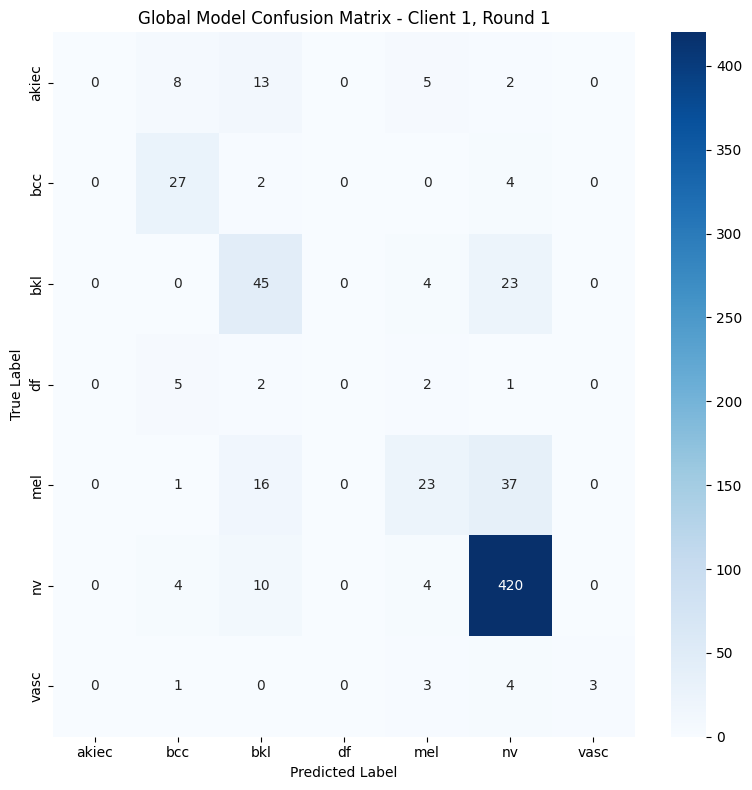


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:17<00:00,  1.23it/s]


Test Loss: 0.5671, Test Accuracy: 79.34%, F1-Score: 0.7624
Confusion Matrix:
 [[  0   2   9   0   7   4   0]
 [  0  25   4   0   3   6   0]
 [  0   5  30   0   4  19   0]
 [  0   2   4   0   0   3   0]
 [  0   1   8   0  22  37   0]
 [  0   1   8   0   5 449   0]
 [  0   1   0   0   2   3   4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.68      0.66      0.67        38
           2       0.48      0.52      0.50        58
           3       0.00      0.00      0.00         9
           4       0.51      0.32      0.40        68
           5       0.86      0.97      0.91       463
           6       1.00      0.40      0.57        10

    accuracy                           0.79       668
   macro avg       0.50      0.41      0.43       668
weighted avg       0.74      0.79      0.76       668

Sensitivity/Recall:
 [0.         0.65789474 0.51724138 0.         0.32352941 0.9697

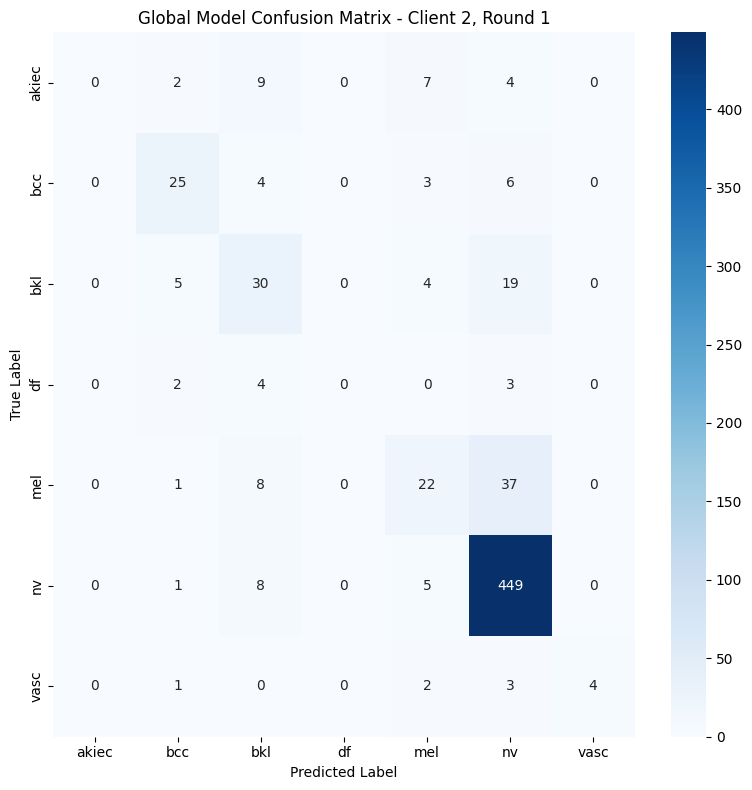


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Test Loss: 0.5805, Test Accuracy: 79.64%, F1-Score: 0.7655
Confusion Matrix:
 [[  0   3  11   0   1   3   0]
 [  0  31   3   0   2   4   0]
 [  0   5  51   0   5  21   0]
 [  0   2   3   0   0   0   0]
 [  0   0   2   0  23  49   0]
 [  0   5   5   0   4 420   0]
 [  0   1   0   0   1   6   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.66      0.78      0.71        40
           2       0.68      0.62      0.65        82
           3       0.00      0.00      0.00         5
           4       0.64      0.31      0.42        74
           5       0.83      0.97      0.90       434
           6       1.00      0.47      0.64        15

    accuracy                           0.80       668
   macro avg       0.54      0.45      0.47       668
weighted avg       0.76      0.80      0.77       668

Sensitivity/Recall:
 [0.         0.775      0.62195122 0.         0.31081081 0.9677

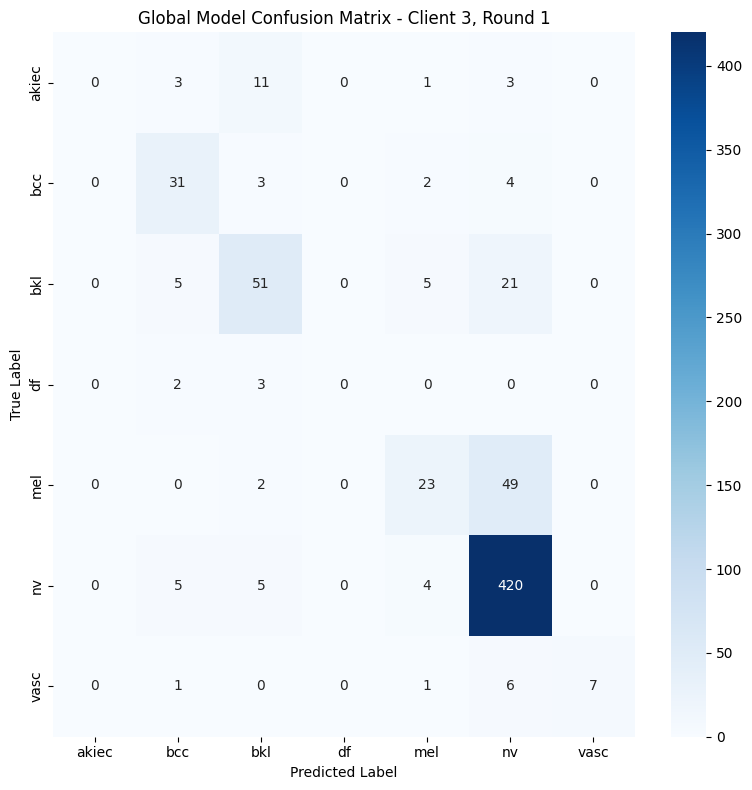


--- Round 2 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [06:15<00:00,  4.48s/it]


Client 1 Epoch 1: Train Loss: 0.6373, Train Accuracy: 80.05%


Client 1 Epoch 2: 100%|██████████| 84/84 [06:10<00:00,  4.41s/it]


Client 1 Epoch 2: Train Loss: 0.6063, Train Accuracy: 82.60%


Client 1 Epoch 3: 100%|██████████| 84/84 [06:16<00:00,  4.48s/it]


Client 1 Epoch 3: Train Loss: 0.5830, Train Accuracy: 85.55%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:21<00:00,  1.01s/it]


Test Loss: 0.6405, Test Accuracy: 77.73%, F1-Score: 0.7467
Confusion Matrix:
 [[ 15   5   2   0   1   5   0]
 [  0  24   2   0   0   7   0]
 [  3   3  41   0   1  24   0]
 [  2   2   2   1   0   3   0]
 [  7   2  12   0  19  37   0]
 [  0   7   8   0   3 420   0]
 [  0   3   0   0   3   5   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.54      0.55        28
           1       0.52      0.73      0.61        33
           2       0.61      0.57      0.59        72
           3       1.00      0.10      0.18        10
           4       0.70      0.25      0.37        77
           5       0.84      0.96      0.89       438
           6       0.00      0.00      0.00        11

    accuracy                           0.78       669
   macro avg       0.60      0.45      0.45       669
weighted avg       0.76      0.78      0.75       669

Sensitivity/Recall:
 [0.53571429 0.72727273 0.56944444 0.1        0.24675325 0.9589

Client 2 Epoch 1: 100%|██████████| 84/84 [05:17<00:00,  3.79s/it]


Client 2 Epoch 1: Train Loss: 0.6065, Train Accuracy: 81.04%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:00<00:00,  3.58s/it]


Client 2 Epoch 2: Train Loss: 0.5693, Train Accuracy: 84.26%


Client 2 Epoch 3: 100%|██████████| 84/84 [04:57<00:00,  3.55s/it]


Client 2 Epoch 3: Train Loss: 0.5903, Train Accuracy: 85.80%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:42<00:00,  2.02s/it]


Test Loss: 0.6229, Test Accuracy: 79.79%, F1-Score: 0.7650
Confusion Matrix:
 [[  1   0  16   0   3   2   0]
 [  0  19   9   0   0  10   0]
 [  0   0  41   0   1  16   0]
 [  0   1   4   0   0   4   0]
 [  0   0  13   0  15  40   0]
 [  1   0   8   0   3 451   0]
 [  0   0   0   0   2   2   6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.05      0.08        22
           1       0.95      0.50      0.66        38
           2       0.45      0.71      0.55        58
           3       0.00      0.00      0.00         9
           4       0.62      0.22      0.33        68
           5       0.86      0.97      0.91       463
           6       1.00      0.60      0.75        10

    accuracy                           0.80       668
   macro avg       0.63      0.44      0.47       668
weighted avg       0.78      0.80      0.77       668

Sensitivity/Recall:
 [0.04545455 0.5        0.70689655 0.         0.22058824 0.9740

Client 3 Epoch 1: 100%|██████████| 84/84 [04:03<00:00,  2.90s/it]


Client 3 Epoch 1: Train Loss: 0.6363, Train Accuracy: 79.73%


Client 3 Epoch 2: 100%|██████████| 84/84 [04:04<00:00,  2.91s/it]


Client 3 Epoch 2: Train Loss: 0.5823, Train Accuracy: 83.40%


Client 3 Epoch 3: 100%|██████████| 84/84 [04:04<00:00,  2.91s/it]


Client 3 Epoch 3: Train Loss: 0.5846, Train Accuracy: 85.87%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:18<00:00,  1.13it/s]


Test Loss: 0.6211, Test Accuracy: 76.80%, F1-Score: 0.7558
Confusion Matrix:
 [[  4   1   7   0   5   1   0]
 [  1  35   1   0   3   0   0]
 [  0   6  36   0  21  19   0]
 [  0   1   2   0   2   0   0]
 [  0   1   0   0  30  43   0]
 [  1  14   6   0  14 399   0]
 [  0   1   0   1   3   1   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.22      0.33        18
           1       0.59      0.88      0.71        40
           2       0.69      0.44      0.54        82
           3       0.00      0.00      0.00         5
           4       0.38      0.41      0.39        74
           5       0.86      0.92      0.89       434
           6       1.00      0.60      0.75        15

    accuracy                           0.77       668
   macro avg       0.60      0.49      0.52       668
weighted avg       0.76      0.77      0.76       668

Sensitivity/Recall:
 [0.22222222 0.875      0.43902439 0.         0.40540541 0.9193

Testing: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]

Test Loss: 0.5088, Test Accuracy: 81.76%, F1-Score: 0.7998
Confusion Matrix:
 [[  5   3  11   0   8   1   0]
 [  0  23   5   0   0   5   0]
 [  0   0  51   0   5  16   0]
 [  2   1   4   1   2   0   0]
 [  0   0  11   0  37  29   0]
 [  0   4   8   0   2 424   0]
 [  0   0   0   0   3   2   6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.18      0.29        28
           1       0.74      0.70      0.72        33
           2       0.57      0.71      0.63        72
           3       1.00      0.10      0.18        10
           4       0.65      0.48      0.55        77
           5       0.89      0.97      0.93       438
           6       1.00      0.55      0.71        11

    accuracy                           0.82       669
   macro avg       0.79      0.53      0.57       669
weighted avg       0.82      0.82      0.80       669

Sensitivity/Recall:
 [0.17857143 0.6969697  0.70833333 0.1        0.48051948 0.9680


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:20<00:00,  1.04it/s]

Test Loss: 0.4867, Test Accuracy: 82.78%, F1-Score: 0.8082
Confusion Matrix:
 [[  1   2  11   0   5   3   0]
 [  0  27   4   0   1   6   0]
 [  0   0  40   0   5  13   0]
 [  1   1   1   1   1   4   0]
 [  0   1   5   0  32  30   0]
 [  0   0   9   0   8 446   0]
 [  0   1   0   0   2   1   6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.05      0.08        22
           1       0.84      0.71      0.77        38
           2       0.57      0.69      0.62        58
           3       1.00      0.11      0.20         9
           4       0.59      0.47      0.52        68
           5       0.89      0.96      0.92       463
           6       1.00      0.60      0.75        10

    accuracy                           0.83       668
   macro avg       0.77      0.51      0.55       668
weighted avg       0.82      0.83      0.81       668

Sensitivity/Recall:
 [0.04545455 0.71052632 0.68965517 0.11111111 0.47058824 0.9632

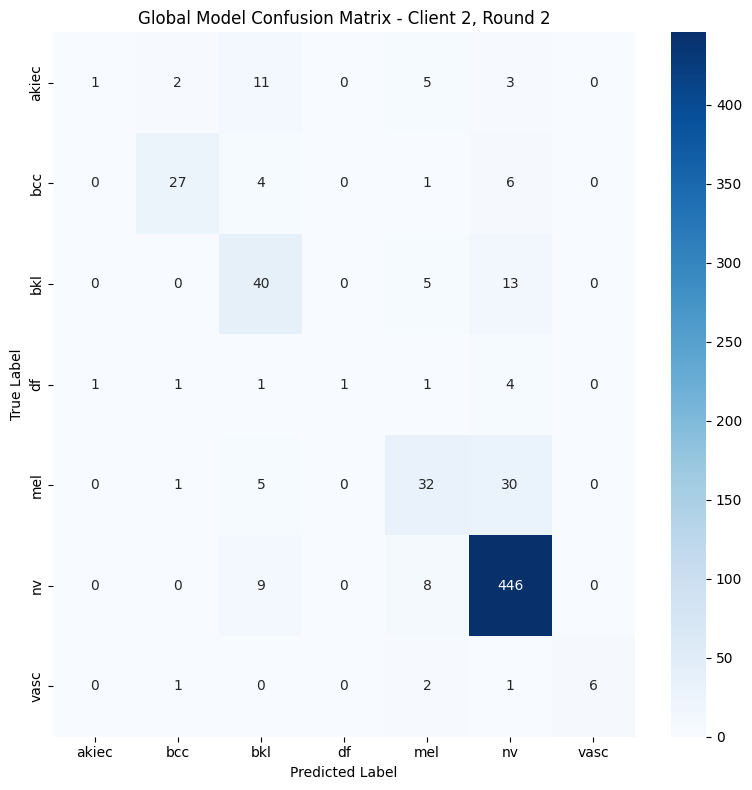


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:20<00:00,  1.02it/s]

Test Loss: 0.4827, Test Accuracy: 81.74%, F1-Score: 0.7974
Confusion Matrix:
 [[  2   3   7   0   5   1   0]
 [  0  29   3   0   3   5   0]
 [  0   4  56   0   3  19   0]
 [  1   0   2   1   0   1   0]
 [  0   0   2   0  29  43   0]
 [  0   4   5   0   5 420   0]
 [  0   0   0   1   1   4   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.11      0.19        18
           1       0.72      0.72      0.72        40
           2       0.75      0.68      0.71        82
           3       0.50      0.20      0.29         5
           4       0.63      0.39      0.48        74
           5       0.85      0.97      0.91       434
           6       1.00      0.60      0.75        15

    accuracy                           0.82       668
   macro avg       0.73      0.53      0.58       668
weighted avg       0.80      0.82      0.80       668

Sensitivity/Recall:
 [0.11111111 0.725      0.68292683 0.2        0.39189189 0.9677

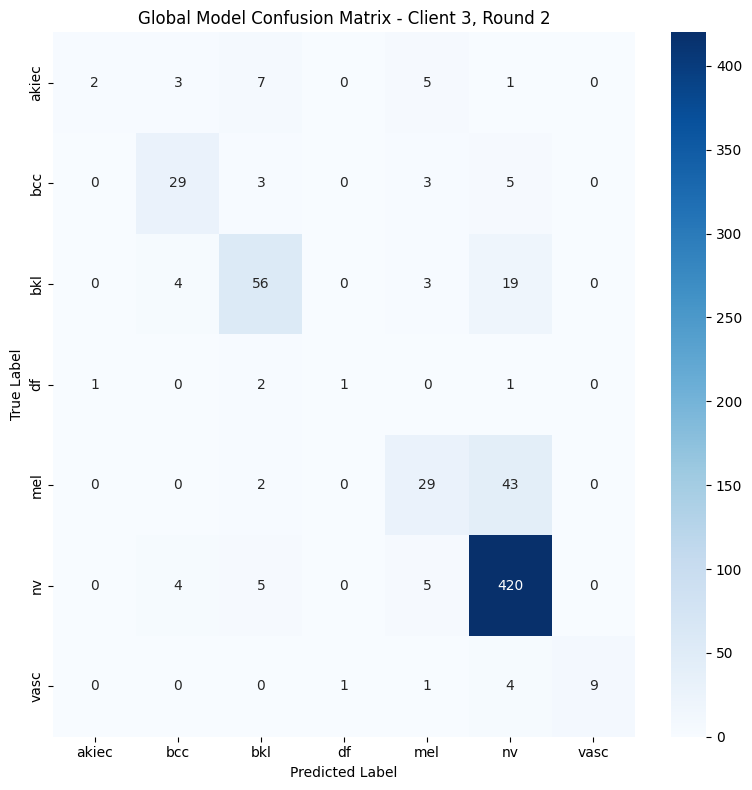


--- Round 3 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [05:56<00:00,  4.25s/it]


Client 1 Epoch 1: Train Loss: 0.5374, Train Accuracy: 84.39%


Client 1 Epoch 2: 100%|██████████| 84/84 [06:01<00:00,  4.30s/it]


Client 1 Epoch 2: Train Loss: 0.5100, Train Accuracy: 87.24%


Client 1 Epoch 3: 100%|██████████| 84/84 [06:01<00:00,  4.30s/it]


Client 1 Epoch 3: Train Loss: 0.5052, Train Accuracy: 88.62%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:21<00:00,  1.01s/it]


Test Loss: 0.5563, Test Accuracy: 80.42%, F1-Score: 0.7866
Confusion Matrix:
 [[  3  13   5   0   2   5   0]
 [  0  21   0   0   2  10   0]
 [  0   3  39   0  13  17   0]
 [  0   2   2   3   1   2   0]
 [  0   0   3   0  46  27   1]
 [  0   2   6   0  12 418   0]
 [  0   0   0   0   1   2   8]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.11      0.19        28
           1       0.51      0.64      0.57        33
           2       0.71      0.54      0.61        72
           3       1.00      0.30      0.46        10
           4       0.60      0.60      0.60        77
           5       0.87      0.95      0.91       438
           6       0.89      0.73      0.80        11

    accuracy                           0.80       669
   macro avg       0.80      0.55      0.59       669
weighted avg       0.81      0.80      0.79       669

Sensitivity/Recall:
 [0.10714286 0.63636364 0.54166667 0.3        0.5974026  0.9543

Client 2 Epoch 1: 100%|██████████| 84/84 [05:20<00:00,  3.82s/it]


Client 2 Epoch 1: Train Loss: 0.5408, Train Accuracy: 83.89%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:15<00:00,  3.76s/it]


Client 2 Epoch 2: Train Loss: 0.4901, Train Accuracy: 87.94%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:15<00:00,  3.75s/it]


Client 2 Epoch 3: Train Loss: 0.5012, Train Accuracy: 88.57%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:41<00:00,  1.95s/it]


Test Loss: 0.6132, Test Accuracy: 80.39%, F1-Score: 0.7834
Confusion Matrix:
 [[  0   1   5   2  10   4   0]
 [  0  20   4   0   7   7   0]
 [  0   1  30   0  13  14   0]
 [  0   0   1   3   2   3   0]
 [  0   1   2   0  29  36   0]
 [  0   0   6   0   9 448   0]
 [  0   0   0   0   3   0   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.87      0.53      0.66        38
           2       0.62      0.52      0.57        58
           3       0.60      0.33      0.43         9
           4       0.40      0.43      0.41        68
           5       0.88      0.97      0.92       463
           6       1.00      0.70      0.82        10

    accuracy                           0.80       668
   macro avg       0.62      0.50      0.54       668
weighted avg       0.77      0.80      0.78       668

Sensitivity/Recall:
 [0.         0.52631579 0.51724138 0.33333333 0.42647059 0.9676

Client 3 Epoch 1: 100%|██████████| 84/84 [04:11<00:00,  2.99s/it]


Client 3 Epoch 1: Train Loss: 0.5308, Train Accuracy: 83.63%


Client 3 Epoch 2: 100%|██████████| 84/84 [04:11<00:00,  2.99s/it]


Client 3 Epoch 2: Train Loss: 0.4751, Train Accuracy: 87.64%


Client 3 Epoch 3: 100%|██████████| 84/84 [04:11<00:00,  2.99s/it]


Client 3 Epoch 3: Train Loss: 0.4752, Train Accuracy: 89.96%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:06<00:00,  3.01it/s]


Test Loss: 0.5318, Test Accuracy: 80.99%, F1-Score: 0.7973
Confusion Matrix:
 [[  6   4   2   0   5   1   0]
 [  0  35   1   0   3   1   0]
 [  0   5  41   0   8  28   0]
 [  1   1   1   1   0   1   0]
 [  0   0   0   0  36  37   1]
 [  0   2   4   0  17 407   4]
 [  0   0   0   0   0   0  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.33      0.48        18
           1       0.74      0.88      0.80        40
           2       0.84      0.50      0.63        82
           3       1.00      0.20      0.33         5
           4       0.52      0.49      0.50        74
           5       0.86      0.94      0.90       434
           6       0.75      1.00      0.86        15

    accuracy                           0.81       668
   macro avg       0.80      0.62      0.64       668
weighted avg       0.81      0.81      0.80       668

Sensitivity/Recall:
 [0.33333333 0.875      0.5        0.2        0.48648649 0.9377

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.60it/s]

Test Loss: 0.4886, Test Accuracy: 82.36%, F1-Score: 0.8033
Confusion Matrix:
 [[  0   3   9   0  12   4   0]
 [  0  22   3   0   2   5   1]
 [  0   0  51   0   4  17   0]
 [  1   0   1   4   3   1   0]
 [  0   0   4   0  45  26   2]
 [  0   2   5   0  10 420   1]
 [  0   0   0   0   2   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.81      0.67      0.73        33
           2       0.70      0.71      0.70        72
           3       1.00      0.40      0.57        10
           4       0.58      0.58      0.58        77
           5       0.89      0.96      0.92       438
           6       0.69      0.82      0.75        11

    accuracy                           0.82       669
   macro avg       0.67      0.59      0.61       669
weighted avg       0.79      0.82      0.80       669

Sensitivity/Recall:
 [0.         0.66666667 0.70833333 0.4        0.58441558 0.9589

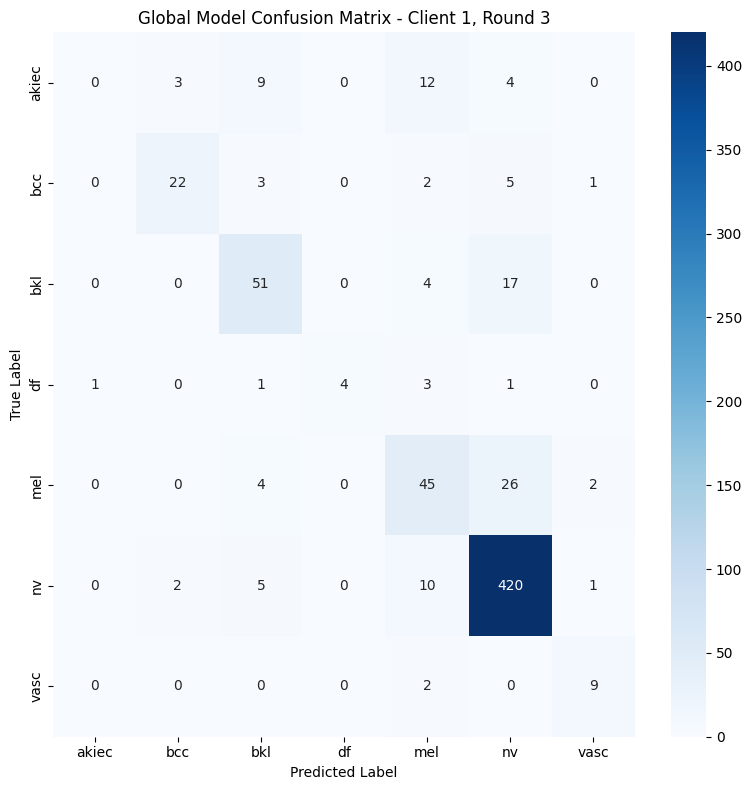


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.4782, Test Accuracy: 83.98%, F1-Score: 0.8185
Confusion Matrix:
 [[  0   2   9   0   6   5   0]
 [  0  22   3   0   4   9   0]
 [  0   2  39   0   6  11   0]
 [  1   0   1   2   3   2   0]
 [  0   2   3   0  36  27   0]
 [  0   1   3   0   5 454   0]
 [  0   0   0   0   2   0   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.76      0.58      0.66        38
           2       0.67      0.67      0.67        58
           3       1.00      0.22      0.36         9
           4       0.58      0.53      0.55        68
           5       0.89      0.98      0.94       463
           6       1.00      0.80      0.89        10

    accuracy                           0.84       668
   macro avg       0.70      0.54      0.58       668
weighted avg       0.81      0.84      0.82       668

Sensitivity/Recall:
 [0.         0.57894737 0.67241379 0.22222222 0.52941176 0.9805

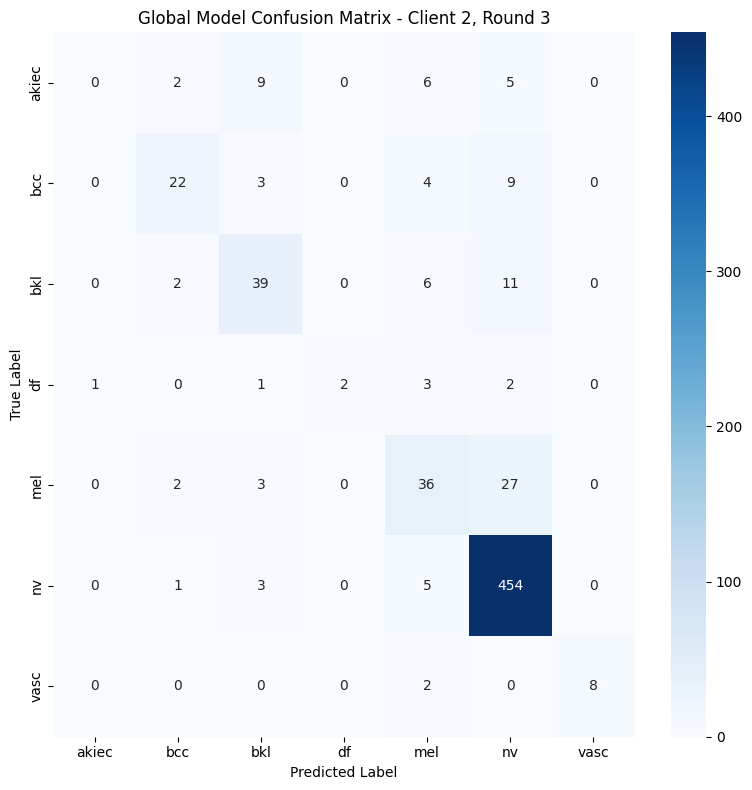


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]


Test Loss: 0.4687, Test Accuracy: 82.63%, F1-Score: 0.8032
Confusion Matrix:
 [[  0   3   9   0   5   1   0]
 [  0  29   2   1   3   5   0]
 [  0   5  52   0   7  18   0]
 [  0   0   1   2   0   2   0]
 [  0   0   1   0  30  43   0]
 [  0   1   4   0   5 424   0]
 [  0   0   0   0   0   0  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.76      0.72      0.74        40
           2       0.75      0.63      0.69        82
           3       0.67      0.40      0.50         5
           4       0.60      0.41      0.48        74
           5       0.86      0.98      0.91       434
           6       1.00      1.00      1.00        15

    accuracy                           0.83       668
   macro avg       0.66      0.59      0.62       668
weighted avg       0.79      0.83      0.80       668

Sensitivity/Recall:
 [0.         0.725      0.63414634 0.4        0.40540541 0.9769

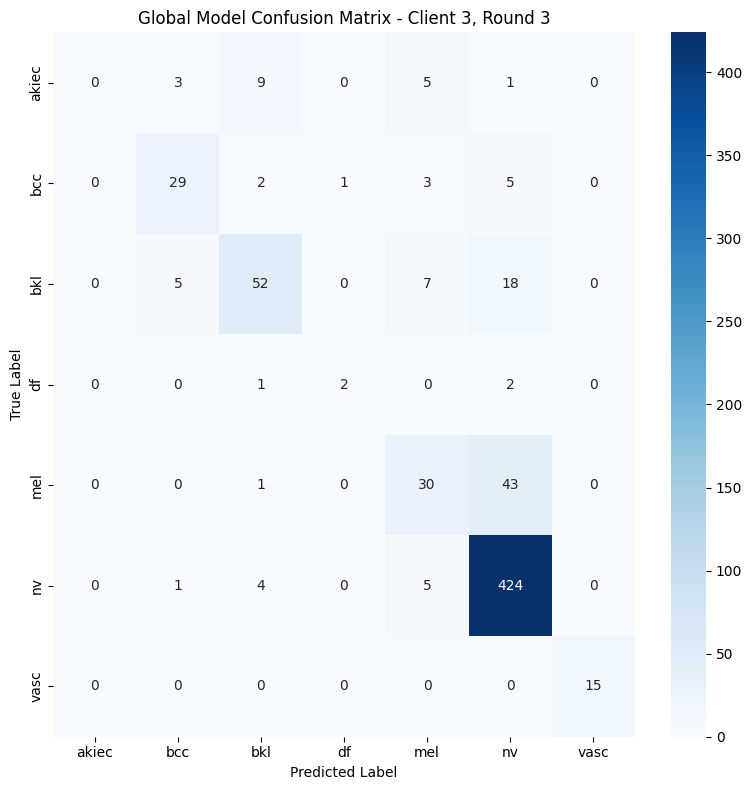


--- Round 4 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [04:33<00:00,  3.26s/it]


Client 1 Epoch 1: Train Loss: 0.4938, Train Accuracy: 85.37%


Client 1 Epoch 2: 100%|██████████| 84/84 [04:33<00:00,  3.26s/it]


Client 1 Epoch 2: Train Loss: 0.4675, Train Accuracy: 88.47%


Client 1 Epoch 3: 100%|██████████| 84/84 [04:34<00:00,  3.27s/it]


Client 1 Epoch 3: Train Loss: 0.4419, Train Accuracy: 91.02%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:22<00:00,  1.06s/it]


Test Loss: 0.7185, Test Accuracy: 77.73%, F1-Score: 0.7360
Confusion Matrix:
 [[  0  18   8   0   0   2   0]
 [  0  26   1   0   0   6   0]
 [  0   3  44   0   3  22   0]
 [  0   5   2   2   0   1   0]
 [  0   1   9   0  15  51   1]
 [  0   6   7   0   0 424   1]
 [  0   0   0   0   1   1   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.44      0.79      0.57        33
           2       0.62      0.61      0.62        72
           3       1.00      0.20      0.33        10
           4       0.79      0.19      0.31        77
           5       0.84      0.97      0.90       438
           6       0.82      0.82      0.82        11

    accuracy                           0.78       669
   macro avg       0.64      0.51      0.51       669
weighted avg       0.76      0.78      0.74       669

Sensitivity/Recall:
 [0.         0.78787879 0.61111111 0.2        0.19480519 0.9680

Client 2 Epoch 1: 100%|██████████| 84/84 [05:20<00:00,  3.82s/it]


Client 2 Epoch 1: Train Loss: 0.4626, Train Accuracy: 87.22%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:20<00:00,  3.82s/it]


Client 2 Epoch 2: Train Loss: 0.4373, Train Accuracy: 89.55%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:25<00:00,  3.88s/it]


Client 2 Epoch 3: Train Loss: 0.4444, Train Accuracy: 90.71%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:16<00:00,  1.28it/s]


Test Loss: 0.5571, Test Accuracy: 81.14%, F1-Score: 0.7855
Confusion Matrix:
 [[  0   2   7   0   7   6   0]
 [  0  23   4   0   0  11   0]
 [  0   1  35   0   6  16   0]
 [  0   1   1   2   0   5   0]
 [  0   4   5   0  27  32   0]
 [  0   0   9   0   5 449   0]
 [  0   0   0   0   2   2   6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.74      0.61      0.67        38
           2       0.57      0.60      0.59        58
           3       1.00      0.22      0.36         9
           4       0.57      0.40      0.47        68
           5       0.86      0.97      0.91       463
           6       1.00      0.60      0.75        10

    accuracy                           0.81       668
   macro avg       0.68      0.49      0.54       668
weighted avg       0.78      0.81      0.79       668

Sensitivity/Recall:
 [0.         0.60526316 0.60344828 0.22222222 0.39705882 0.9697

Client 3 Epoch 1: 100%|██████████| 84/84 [06:53<00:00,  4.93s/it]


Client 3 Epoch 1: Train Loss: 0.4684, Train Accuracy: 87.41%


Client 3 Epoch 2: 100%|██████████| 84/84 [07:07<00:00,  5.08s/it]


Client 3 Epoch 2: Train Loss: 0.4212, Train Accuracy: 90.18%


Client 3 Epoch 3: 100%|██████████| 84/84 [06:58<00:00,  4.98s/it]


Client 3 Epoch 3: Train Loss: 0.4634, Train Accuracy: 90.41%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:24<00:00,  1.16s/it]


Test Loss: 0.5872, Test Accuracy: 79.94%, F1-Score: 0.7789
Confusion Matrix:
 [[  2   1  11   0   2   2   0]
 [  4  21   8   0   3   3   1]
 [  0   2  66   0   2  12   0]
 [  0   0   1   0   2   2   0]
 [  0   0  11   0  23  40   0]
 [  0   1  17   0   6 409   1]
 [  0   0   1   0   0   1  13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.11      0.17        18
           1       0.84      0.53      0.65        40
           2       0.57      0.80      0.67        82
           3       0.00      0.00      0.00         5
           4       0.61      0.31      0.41        74
           5       0.87      0.94      0.91       434
           6       0.87      0.87      0.87        15

    accuracy                           0.80       668
   macro avg       0.58      0.51      0.52       668
weighted avg       0.78      0.80      0.78       668

Sensitivity/Recall:
 [0.11111111 0.525      0.80487805 0.         0.31081081 0.9423

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.60it/s]

Test Loss: 0.5286, Test Accuracy: 82.21%, F1-Score: 0.7980
Confusion Matrix:
 [[  0   4  13   0   5   6   0]
 [  0  20   6   0   0   7   0]
 [  0   0  56   0   2  14   0]
 [  0   0   4   3   2   1   0]
 [  0   0  12   0  37  28   0]
 [  0   2  10   0   1 425   0]
 [  0   0   0   0   2   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.77      0.61      0.68        33
           2       0.55      0.78      0.65        72
           3       1.00      0.30      0.46        10
           4       0.76      0.48      0.59        77
           5       0.88      0.97      0.92       438
           6       1.00      0.82      0.90        11

    accuracy                           0.82       669
   macro avg       0.71      0.56      0.60       669
weighted avg       0.79      0.82      0.80       669

Sensitivity/Recall:
 [0.         0.60606061 0.77777778 0.3        0.48051948 0.9703

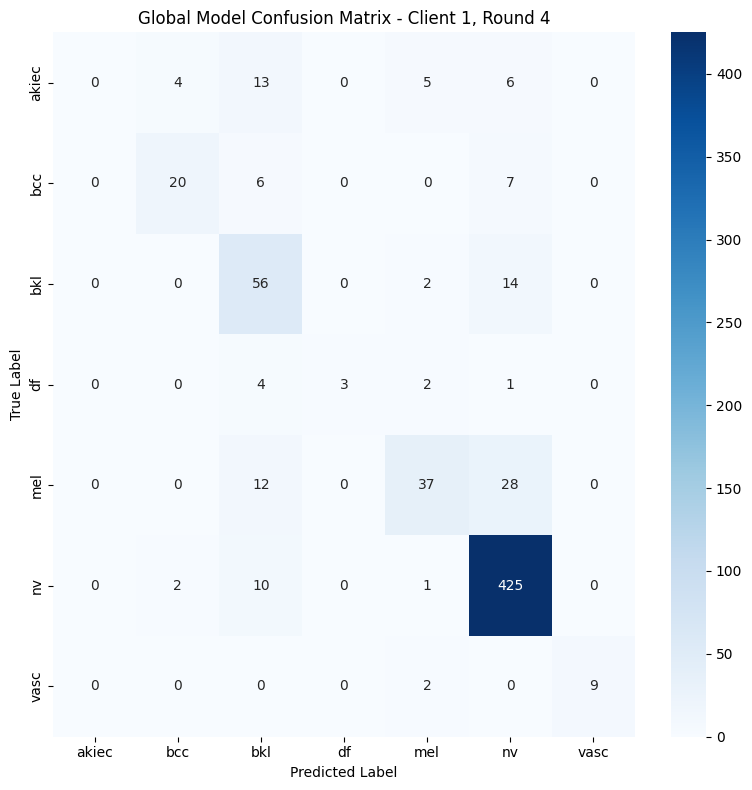


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:12<00:00,  1.62it/s]

Test Loss: 0.4880, Test Accuracy: 82.78%, F1-Score: 0.7990
Confusion Matrix:
 [[  0   2  12   0   3   5   0]
 [  0  25   6   0   2   5   0]
 [  0   1  43   0   2  12   0]
 [  1   2   2   1   0   3   0]
 [  0   1   5   0  23  39   0]
 [  0   1   5   0   3 454   0]
 [  0   0   0   0   2   1   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.78      0.66      0.71        38
           2       0.59      0.74      0.66        58
           3       1.00      0.11      0.20         9
           4       0.66      0.34      0.45        68
           5       0.87      0.98      0.92       463
           6       1.00      0.70      0.82        10

    accuracy                           0.83       668
   macro avg       0.70      0.50      0.54       668
weighted avg       0.80      0.83      0.80       668

Sensitivity/Recall:
 [0.         0.65789474 0.74137931 0.11111111 0.33823529 0.9805

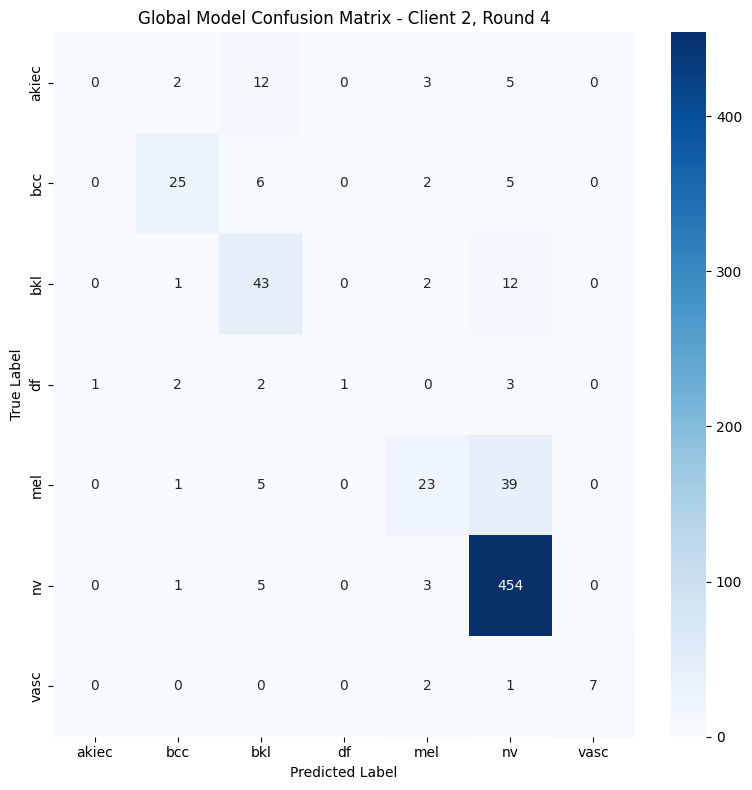


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:12<00:00,  1.62it/s]

Test Loss: 0.5060, Test Accuracy: 83.38%, F1-Score: 0.8096
Confusion Matrix:
 [[  1   2  12   0   2   1   0]
 [  0  29   5   0   2   4   0]
 [  0   3  61   0   1  17   0]
 [  0   0   2   1   0   2   0]
 [  0   0   5   0  26  43   0]
 [  0   1   6   0   3 424   0]
 [  0   0   0   0   0   0  15]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.06      0.11        18
           1       0.83      0.72      0.77        40
           2       0.67      0.74      0.71        82
           3       1.00      0.20      0.33         5
           4       0.76      0.35      0.48        74
           5       0.86      0.98      0.92       434
           6       1.00      1.00      1.00        15

    accuracy                           0.83       668
   macro avg       0.88      0.58      0.62       668
weighted avg       0.83      0.83      0.81       668

Sensitivity/Recall:
 [0.05555556 0.725      0.74390244 0.2        0.35135135 0.9769

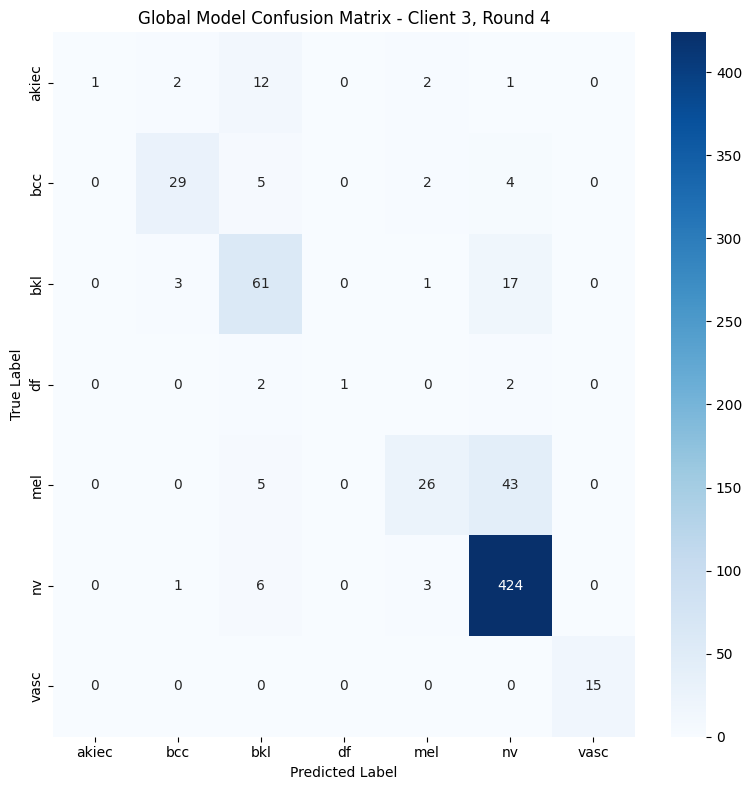


--- Round 5 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [03:49<00:00,  2.73s/it]


Client 1 Epoch 1: Train Loss: 0.4528, Train Accuracy: 86.53%


Client 1 Epoch 2: 100%|██████████| 84/84 [03:49<00:00,  2.73s/it]


Client 1 Epoch 2: Train Loss: 0.3925, Train Accuracy: 91.95%


Client 1 Epoch 3: 100%|██████████| 84/84 [03:49<00:00,  2.74s/it]


Client 1 Epoch 3: Train Loss: 0.4055, Train Accuracy: 92.18%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:17<00:00,  1.18it/s]


Test Loss: 0.6465, Test Accuracy: 78.77%, F1-Score: 0.7556
Confusion Matrix:
 [[  3   9  11   0   1   4   0]
 [  0  21   2   0   0  10   0]
 [  0   0  56   0   2  14   0]
 [  0   1   4   4   1   0   0]
 [  0   0  16   0  17  44   0]
 [  0   5  11   0   1 421   0]
 [  0   0   0   0   3   3   5]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.11      0.19        28
           1       0.58      0.64      0.61        33
           2       0.56      0.78      0.65        72
           3       1.00      0.40      0.57        10
           4       0.68      0.22      0.33        77
           5       0.85      0.96      0.90       438
           6       1.00      0.45      0.62        11

    accuracy                           0.79       669
   macro avg       0.81      0.51      0.55       669
weighted avg       0.80      0.79      0.76       669

Sensitivity/Recall:
 [0.10714286 0.63636364 0.77777778 0.4        0.22077922 0.9611

Client 2 Epoch 1: 100%|██████████| 84/84 [06:07<00:00,  4.37s/it]


Client 2 Epoch 1: Train Loss: 0.4123, Train Accuracy: 89.77%


Client 2 Epoch 2: 100%|██████████| 84/84 [06:07<00:00,  4.38s/it]


Client 2 Epoch 2: Train Loss: 0.4116, Train Accuracy: 91.31%


Client 2 Epoch 3: 100%|██████████| 84/84 [06:07<00:00,  4.38s/it]


Client 2 Epoch 3: Train Loss: 0.3758, Train Accuracy: 93.56%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:25<00:00,  1.24s/it]


Test Loss: 0.5351, Test Accuracy: 81.14%, F1-Score: 0.7879
Confusion Matrix:
 [[  6   2   5   0   3   6   0]
 [  2  23   3   0   0  10   0]
 [  0   4  29   0   3  22   0]
 [  0   0   2   0   1   6   0]
 [  0   4   2   0  28  33   1]
 [  1   1   2   0   8 451   0]
 [  0   0   0   0   3   2   5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.27      0.39        22
           1       0.68      0.61      0.64        38
           2       0.67      0.50      0.57        58
           3       0.00      0.00      0.00         9
           4       0.61      0.41      0.49        68
           5       0.85      0.97      0.91       463
           6       0.83      0.50      0.62        10

    accuracy                           0.81       668
   macro avg       0.62      0.47      0.52       668
weighted avg       0.78      0.81      0.79       668

Sensitivity/Recall:
 [0.27272727 0.60526316 0.5        0.         0.41176471 0.9740

Client 3 Epoch 1: 100%|██████████| 84/84 [06:07<00:00,  4.38s/it]


Client 3 Epoch 1: Train Loss: 0.4036, Train Accuracy: 88.87%


Client 3 Epoch 2: 100%|██████████| 84/84 [06:07<00:00,  4.38s/it]


Client 3 Epoch 2: Train Loss: 0.4201, Train Accuracy: 90.67%


Client 3 Epoch 3: 100%|██████████| 84/84 [06:07<00:00,  4.38s/it]


Client 3 Epoch 3: Train Loss: 0.3759, Train Accuracy: 94.16%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:35<00:00,  1.69s/it]


Test Loss: 0.5657, Test Accuracy: 81.14%, F1-Score: 0.7978
Confusion Matrix:
 [[ 10   3   1   0   1   3   0]
 [  1  33   1   0   3   2   0]
 [  1   4  44   0   9  24   0]
 [  1   0   1   2   0   1   0]
 [  1   0   3   0  29  41   0]
 [  1   8   5   0   7 413   0]
 [  0   0   1   1   0   2  11]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.56      0.61        18
           1       0.69      0.82      0.75        40
           2       0.79      0.54      0.64        82
           3       0.67      0.40      0.50         5
           4       0.59      0.39      0.47        74
           5       0.85      0.95      0.90       434
           6       1.00      0.73      0.85        15

    accuracy                           0.81       668
   macro avg       0.75      0.63      0.67       668
weighted avg       0.80      0.81      0.80       668

Sensitivity/Recall:
 [0.55555556 0.825      0.53658537 0.4        0.39189189 0.9516

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.59it/s]

Test Loss: 0.4632, Test Accuracy: 84.16%, F1-Score: 0.8258
Confusion Matrix:
 [[  6   2   8   0   9   3   0]
 [  0  22   5   0   0   6   0]
 [  0   0  55   0   2  15   0]
 [  1   0   3   3   2   1   0]
 [  1   0   6   0  41  29   0]
 [  0   3   4   0   2 429   0]
 [  0   0   0   0   3   1   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.21      0.33        28
           1       0.81      0.67      0.73        33
           2       0.68      0.76      0.72        72
           3       1.00      0.30      0.46        10
           4       0.69      0.53      0.60        77
           5       0.89      0.98      0.93       438
           6       1.00      0.64      0.78        11

    accuracy                           0.84       669
   macro avg       0.83      0.58      0.65       669
weighted avg       0.84      0.84      0.83       669

Sensitivity/Recall:
 [0.21428571 0.66666667 0.76388889 0.3        0.53246753 0.9794

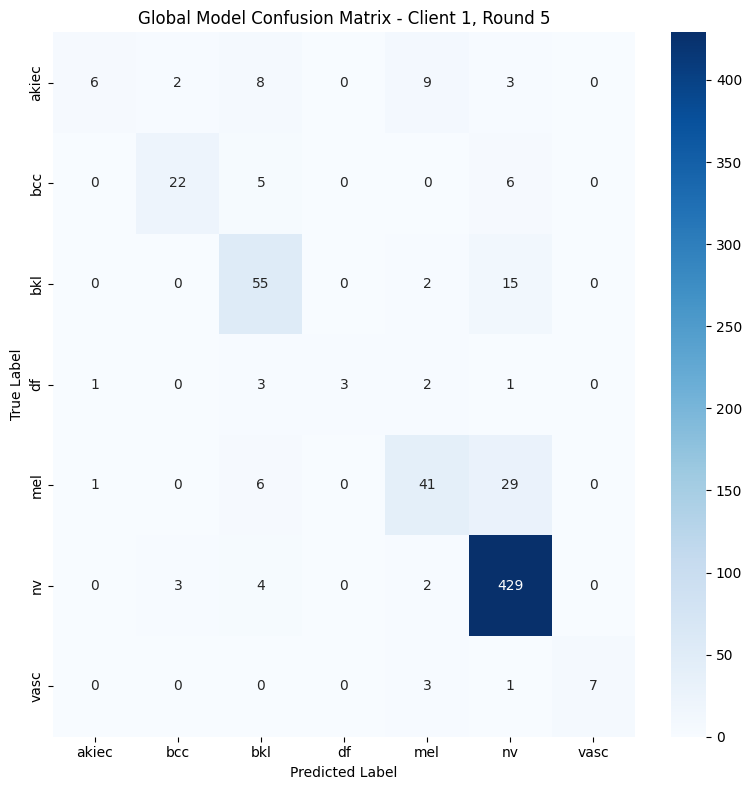


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.56it/s]

Test Loss: 0.4365, Test Accuracy: 83.38%, F1-Score: 0.8108
Confusion Matrix:
 [[  1   2   8   0   5   6   0]
 [  0  26   5   0   3   4   0]
 [  0   0  39   0   4  15   0]
 [  1   0   2   1   1   4   0]
 [  0   3   5   0  29  31   0]
 [  0   1   4   0   5 453   0]
 [  0   0   0   0   2   0   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.05      0.08        22
           1       0.81      0.68      0.74        38
           2       0.62      0.67      0.64        58
           3       1.00      0.11      0.20         9
           4       0.59      0.43      0.50        68
           5       0.88      0.98      0.93       463
           6       1.00      0.80      0.89        10

    accuracy                           0.83       668
   macro avg       0.77      0.53      0.57       668
weighted avg       0.82      0.83      0.81       668

Sensitivity/Recall:
 [0.04545455 0.68421053 0.67241379 0.11111111 0.42647059 0.9784

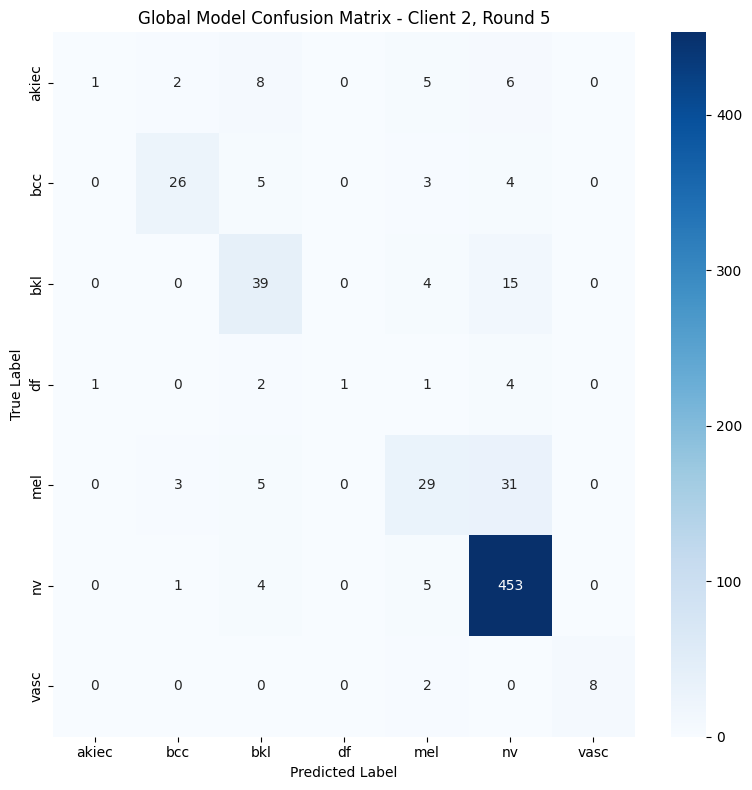


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]

Test Loss: 0.4497, Test Accuracy: 83.53%, F1-Score: 0.8184
Confusion Matrix:
 [[  4   2   8   0   2   2   0]
 [  1  32   3   0   3   1   0]
 [  0   3  58   0   4  17   0]
 [  0   0   1   2   0   2   0]
 [  0   0   3   0  29  42   0]
 [  0   3   5   0   3 423   0]
 [  0   0   1   0   2   2  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.22      0.35        18
           1       0.80      0.80      0.80        40
           2       0.73      0.71      0.72        82
           3       1.00      0.40      0.57         5
           4       0.67      0.39      0.50        74
           5       0.87      0.97      0.92       434
           6       1.00      0.67      0.80        15

    accuracy                           0.84       668
   macro avg       0.84      0.59      0.66       668
weighted avg       0.83      0.84      0.82       668

Sensitivity/Recall:
 [0.22222222 0.8        0.70731707 0.4        0.39189189 0.9746

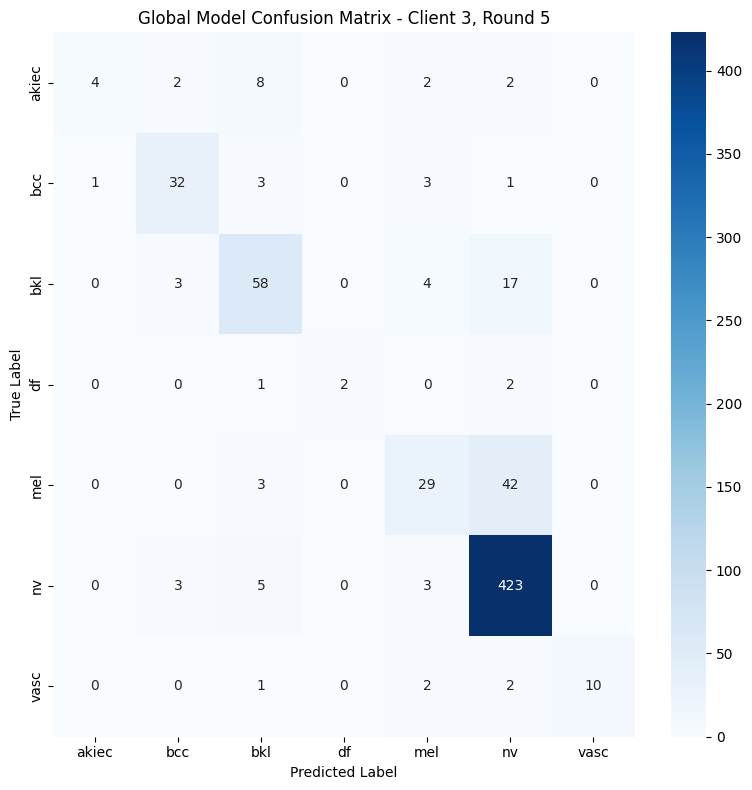


--- Round 6 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [03:45<00:00,  2.68s/it]


Client 1 Epoch 1: Train Loss: 0.3743, Train Accuracy: 90.72%


Client 1 Epoch 2: 100%|██████████| 84/84 [03:45<00:00,  2.69s/it]


Client 1 Epoch 2: Train Loss: 0.3411, Train Accuracy: 93.82%


Client 1 Epoch 3: 100%|██████████| 84/84 [03:46<00:00,  2.69s/it]


Client 1 Epoch 3: Train Loss: 0.3632, Train Accuracy: 94.16%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Test Loss: 0.5909, Test Accuracy: 81.32%, F1-Score: 0.7976
Confusion Matrix:
 [[ 11   6   4   0   2   4   1]
 [  0  18   7   0   0   7   1]
 [  1   0  50   0   2  19   0]
 [  2   0   3   2   0   3   0]
 [  0   1   9   0  35  32   0]
 [  0   2   7   0   7 422   0]
 [  0   0   0   0   2   3   6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.39      0.52        28
           1       0.67      0.55      0.60        33
           2       0.62      0.69      0.66        72
           3       1.00      0.20      0.33        10
           4       0.73      0.45      0.56        77
           5       0.86      0.96      0.91       438
           6       0.75      0.55      0.63        11

    accuracy                           0.81       669
   macro avg       0.77      0.54      0.60       669
weighted avg       0.81      0.81      0.80       669

Sensitivity/Recall:
 [0.39285714 0.54545455 0.69444444 0.2        0.45454545 0.9634

Client 2 Epoch 1: 100%|██████████| 84/84 [05:28<00:00,  3.91s/it]


Client 2 Epoch 1: Train Loss: 0.3562, Train Accuracy: 91.38%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:28<00:00,  3.91s/it]


Client 2 Epoch 2: Train Loss: 0.3363, Train Accuracy: 93.86%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:28<00:00,  3.91s/it]


Client 2 Epoch 3: Train Loss: 0.3574, Train Accuracy: 94.72%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it]


Test Loss: 0.6082, Test Accuracy: 81.44%, F1-Score: 0.8096
Confusion Matrix:
 [[  1   2  16   0   1   2   0]
 [  0  22  11   0   2   3   0]
 [  0   0  50   0   1   7   0]
 [  0   1   3   3   0   2   0]
 [  0   0  13   0  36  19   0]
 [  1   0  21   0  18 423   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.05      0.08        22
           1       0.88      0.58      0.70        38
           2       0.44      0.86      0.58        58
           3       1.00      0.33      0.50         9
           4       0.61      0.53      0.57        68
           5       0.93      0.91      0.92       463
           6       1.00      0.90      0.95        10

    accuracy                           0.81       668
   macro avg       0.77      0.59      0.61       668
weighted avg       0.84      0.81      0.81       668

Sensitivity/Recall:
 [0.04545455 0.57894737 0.86206897 0.33333333 0.52941176 0.9136

Client 3 Epoch 1: 100%|██████████| 84/84 [07:37<00:00,  5.45s/it]


Client 3 Epoch 1: Train Loss: 0.3674, Train Accuracy: 90.78%


Client 3 Epoch 2: 100%|██████████| 84/84 [07:38<00:00,  5.46s/it]


Client 3 Epoch 2: Train Loss: 0.3467, Train Accuracy: 93.97%


Client 3 Epoch 3: 100%|██████████| 84/84 [07:39<00:00,  5.46s/it]


Client 3 Epoch 3: Train Loss: 0.3663, Train Accuracy: 93.89%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:40<00:00,  1.93s/it]


Test Loss: 0.6422, Test Accuracy: 78.89%, F1-Score: 0.7901
Confusion Matrix:
 [[ 11   4   0   0   3   0   0]
 [  1  36   1   0   1   0   1]
 [  5   9  38   0  17  13   0]
 [  0   2   0   1   1   1   0]
 [  1   2   1   1  42  27   0]
 [  1  20   5   1  22 385   0]
 [  0   0   0   1   0   0  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.61      0.59        18
           1       0.49      0.90      0.64        40
           2       0.84      0.46      0.60        82
           3       0.25      0.20      0.22         5
           4       0.49      0.57      0.53        74
           5       0.90      0.89      0.90       434
           6       0.93      0.93      0.93        15

    accuracy                           0.79       668
   macro avg       0.64      0.65      0.63       668
weighted avg       0.81      0.79      0.79       668

Sensitivity/Recall:
 [0.61111111 0.9        0.46341463 0.2        0.56756757 0.8870

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.60it/s]

Test Loss: 0.4497, Test Accuracy: 84.90%, F1-Score: 0.8412
Confusion Matrix:
 [[  7   2  11   0   6   2   0]
 [  0  22   6   0   0   4   1]
 [  0   0  59   0   3  10   0]
 [  2   0   3   4   1   0   0]
 [  1   0   6   0  50  20   0]
 [  0   2   7   0  11 418   0]
 [  0   0   0   0   3   0   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.25      0.37        28
           1       0.85      0.67      0.75        33
           2       0.64      0.82      0.72        72
           3       1.00      0.40      0.57        10
           4       0.68      0.65      0.66        77
           5       0.92      0.95      0.94       438
           6       0.89      0.73      0.80        11

    accuracy                           0.85       669
   macro avg       0.81      0.64      0.69       669
weighted avg       0.85      0.85      0.84       669

Sensitivity/Recall:
 [0.25       0.66666667 0.81944444 0.4        0.64935065 0.9543

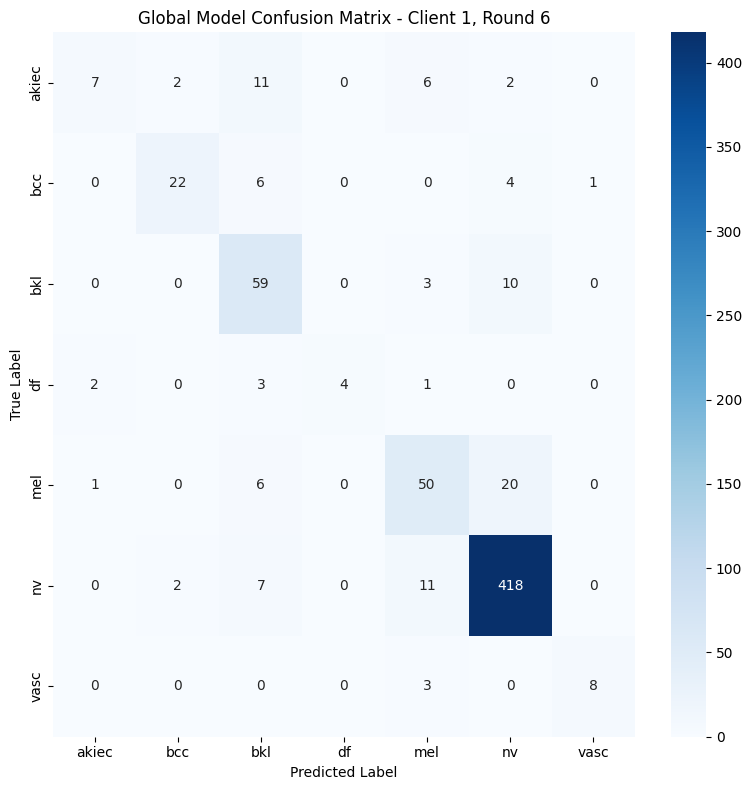


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]

Test Loss: 0.4216, Test Accuracy: 85.93%, F1-Score: 0.8456
Confusion Matrix:
 [[  2   2  11   0   4   3   0]
 [  0  30   6   0   0   2   0]
 [  0   1  50   0   1   6   0]
 [  2   1   1   2   2   1   0]
 [  0   3   5   0  36  24   0]
 [  0   1   9   0   8 445   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.09      0.15        22
           1       0.79      0.79      0.79        38
           2       0.61      0.86      0.71        58
           3       1.00      0.22      0.36         9
           4       0.69      0.53      0.60        68
           5       0.93      0.96      0.94       463
           6       1.00      0.90      0.95        10

    accuracy                           0.86       668
   macro avg       0.79      0.62      0.64       668
weighted avg       0.85      0.86      0.85       668

Sensitivity/Recall:
 [0.09090909 0.78947368 0.86206897 0.22222222 0.52941176 0.9611

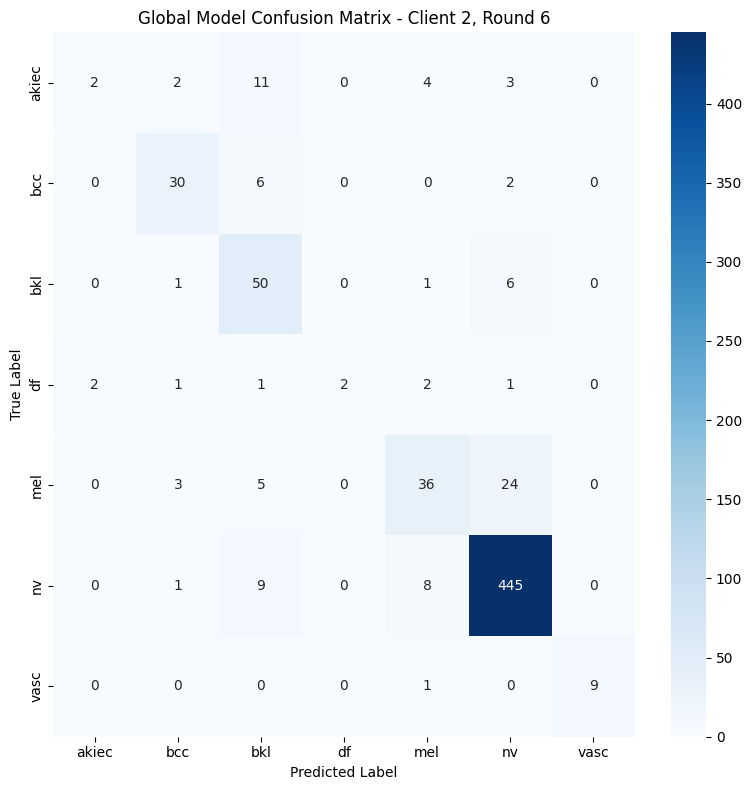


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.56it/s]

Test Loss: 0.4633, Test Accuracy: 83.53%, F1-Score: 0.8222
Confusion Matrix:
 [[  3   2   7   0   5   1   0]
 [  1  29   4   0   2   4   0]
 [  0   3  63   0   5  11   0]
 [  1   0   1   1   0   2   0]
 [  0   0   6   0  34  34   0]
 [  0   4   6   0   8 416   0]
 [  0   0   0   1   1   1  12]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.17      0.26        18
           1       0.76      0.72      0.74        40
           2       0.72      0.77      0.75        82
           3       0.50      0.20      0.29         5
           4       0.62      0.46      0.53        74
           5       0.89      0.96      0.92       434
           6       1.00      0.80      0.89        15

    accuracy                           0.84       668
   macro avg       0.73      0.58      0.62       668
weighted avg       0.82      0.84      0.82       668

Sensitivity/Recall:
 [0.16666667 0.725      0.76829268 0.2        0.45945946 0.9585

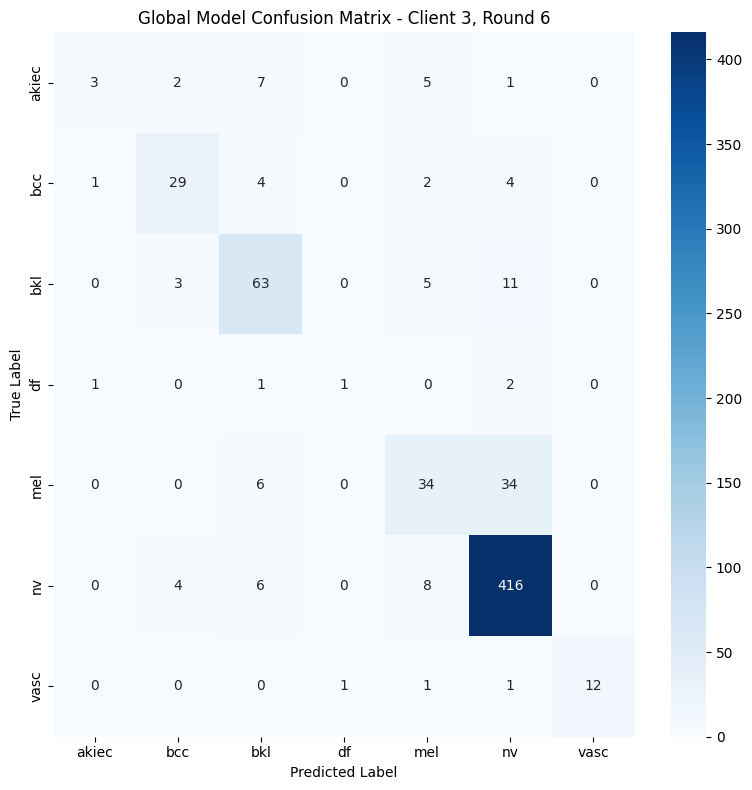


--- Round 7 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [04:04<00:00,  2.91s/it]


Client 1 Epoch 1: Train Loss: 0.3312, Train Accuracy: 92.03%


Client 1 Epoch 2: 100%|██████████| 84/84 [04:04<00:00,  2.91s/it]


Client 1 Epoch 2: Train Loss: 0.3392, Train Accuracy: 93.94%


Client 1 Epoch 3: 100%|██████████| 84/84 [04:04<00:00,  2.91s/it]


Client 1 Epoch 3: Train Loss: 0.3337, Train Accuracy: 95.32%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Test Loss: 0.6231, Test Accuracy: 82.21%, F1-Score: 0.8155
Confusion Matrix:
 [[ 11   5   4   0   5   2   1]
 [  0  25   1   0   2   4   1]
 [  0   0  49   0   6  17   0]
 [  0   0   3   7   0   0   0]
 [  1   0   3   0  42  31   0]
 [  0   5  12   2  10 409   0]
 [  0   0   0   0   3   1   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.39      0.55        28
           1       0.71      0.76      0.74        33
           2       0.68      0.68      0.68        72
           3       0.78      0.70      0.74        10
           4       0.62      0.55      0.58        77
           5       0.88      0.93      0.91       438
           6       0.78      0.64      0.70        11

    accuracy                           0.82       669
   macro avg       0.77      0.66      0.70       669
weighted avg       0.82      0.82      0.82       669

Sensitivity/Recall:
 [0.39285714 0.75757576 0.68055556 0.7        0.54545455 0.9337

Client 2 Epoch 1: 100%|██████████| 84/84 [05:20<00:00,  3.81s/it]


Client 2 Epoch 1: Train Loss: 0.3280, Train Accuracy: 92.66%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:20<00:00,  3.81s/it]


Client 2 Epoch 2: Train Loss: 0.3112, Train Accuracy: 94.87%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:20<00:00,  3.81s/it]


Client 2 Epoch 3: Train Loss: 0.3181, Train Accuracy: 95.24%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:24<00:00,  1.17s/it]


Test Loss: 0.7146, Test Accuracy: 81.44%, F1-Score: 0.7790
Confusion Matrix:
 [[  1   0  15   0   0   6   0]
 [  0  19   9   0   0  10   0]
 [  0   0  45   0   0  13   0]
 [  0   1   2   4   0   2   0]
 [  0   1  12   0  12  43   0]
 [  0   0   9   0   0 454   0]
 [  0   0   0   0   0   1   9]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.05      0.09        22
           1       0.90      0.50      0.64        38
           2       0.49      0.78      0.60        58
           3       1.00      0.44      0.62         9
           4       1.00      0.18      0.30        68
           5       0.86      0.98      0.92       463
           6       1.00      0.90      0.95        10

    accuracy                           0.81       668
   macro avg       0.89      0.55      0.59       668
weighted avg       0.85      0.81      0.78       668

Sensitivity/Recall:
 [0.04545455 0.5        0.77586207 0.44444444 0.17647059 0.9805

Client 3 Epoch 1: 100%|██████████| 84/84 [06:13<00:00,  4.44s/it]


Client 3 Epoch 1: Train Loss: 0.3097, Train Accuracy: 92.69%


Client 3 Epoch 2: 100%|██████████| 84/84 [06:13<00:00,  4.45s/it]


Client 3 Epoch 2: Train Loss: 0.3112, Train Accuracy: 94.75%


Client 3 Epoch 3: 100%|██████████| 84/84 [06:13<00:00,  4.45s/it]


Client 3 Epoch 3: Train Loss: 0.3343, Train Accuracy: 95.24%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Test Loss: 0.5588, Test Accuracy: 81.89%, F1-Score: 0.8172
Confusion Matrix:
 [[  8   0   4   0   6   0   0]
 [  6  26   4   1   3   0   0]
 [  1   2  68   0   4   7   0]
 [  0   0   1   0   3   1   0]
 [  0   0   5   0  40  29   0]
 [  0   4  20   0  17 392   1]
 [  0   0   1   1   0   0  13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.44      0.48        18
           1       0.81      0.65      0.72        40
           2       0.66      0.83      0.74        82
           3       0.00      0.00      0.00         5
           4       0.55      0.54      0.54        74
           5       0.91      0.90      0.91       434
           6       0.93      0.87      0.90        15

    accuracy                           0.82       668
   macro avg       0.63      0.60      0.61       668
weighted avg       0.82      0.82      0.82       668

Sensitivity/Recall:
 [0.44444444 0.65       0.82926829 0.         0.54054054 0.9032

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.60it/s]


Test Loss: 0.4802, Test Accuracy: 84.30%, F1-Score: 0.8329
Confusion Matrix:
 [[ 10   1   8   0   5   4   0]
 [  0  21   6   0   0   5   1]
 [  0   0  54   0   2  16   0]
 [  1   0   3   5   1   0   0]
 [  1   0   5   0  42  29   0]
 [  0   2   6   0   6 424   0]
 [  0   0   0   0   2   1   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.36      0.50        28
           1       0.88      0.64      0.74        33
           2       0.66      0.75      0.70        72
           3       1.00      0.50      0.67        10
           4       0.72      0.55      0.62        77
           5       0.89      0.97      0.92       438
           6       0.89      0.73      0.80        11

    accuracy                           0.84       669
   macro avg       0.84      0.64      0.71       669
weighted avg       0.84      0.84      0.83       669

Sensitivity/Recall:
 [0.35714286 0.63636364 0.75       0.5        0.54545455 0.9680

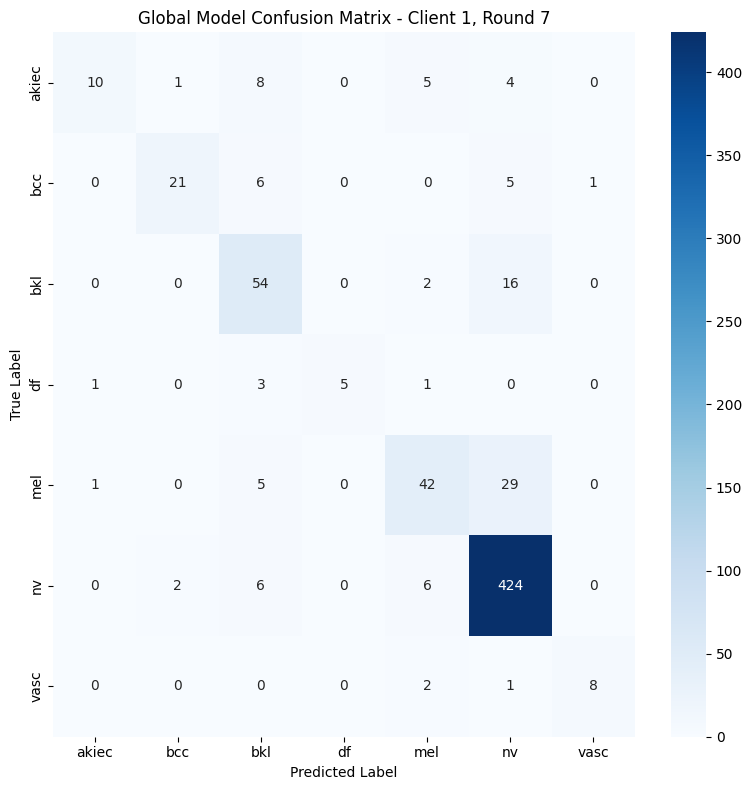


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.50it/s]

Test Loss: 0.4249, Test Accuracy: 85.18%, F1-Score: 0.8345
Confusion Matrix:
 [[  2   0  11   0   6   3   0]
 [  0  27   7   0   1   3   0]
 [  0   1  44   0   2  11   0]
 [  1   1   1   3   2   1   0]
 [  0   2   3   0  31  32   0]
 [  1   1   4   0   4 453   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.09      0.15        22
           1       0.84      0.71      0.77        38
           2       0.63      0.76      0.69        58
           3       1.00      0.33      0.50         9
           4       0.66      0.46      0.54        68
           5       0.90      0.98      0.94       463
           6       1.00      0.90      0.95        10

    accuracy                           0.85       668
   macro avg       0.79      0.60      0.65       668
weighted avg       0.84      0.85      0.83       668

Sensitivity/Recall:
 [0.09090909 0.71052632 0.75862069 0.33333333 0.45588235 0.9784

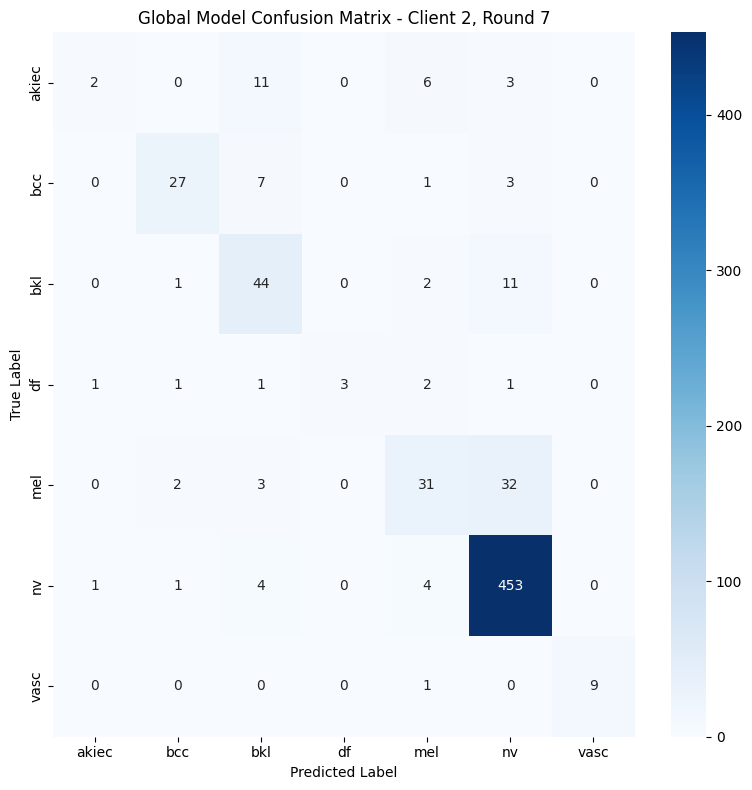


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:14<00:00,  1.50it/s]

Test Loss: 0.5155, Test Accuracy: 84.58%, F1-Score: 0.8318
Confusion Matrix:
 [[  4   1   8   0   3   2   0]
 [  0  33   3   1   1   1   1]
 [  0   3  59   0   4  16   0]
 [  0   0   1   2   0   2   0]
 [  0   0   1   0  34  39   0]
 [  0   4   5   0   6 419   0]
 [  0   0   0   0   0   1  14]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.22      0.36        18
           1       0.80      0.82      0.81        40
           2       0.77      0.72      0.74        82
           3       0.67      0.40      0.50         5
           4       0.71      0.46      0.56        74
           5       0.87      0.97      0.92       434
           6       0.93      0.93      0.93        15

    accuracy                           0.85       668
   macro avg       0.82      0.65      0.69       668
weighted avg       0.84      0.85      0.83       668

Sensitivity/Recall:
 [0.22222222 0.825      0.7195122  0.4        0.45945946 0.9654

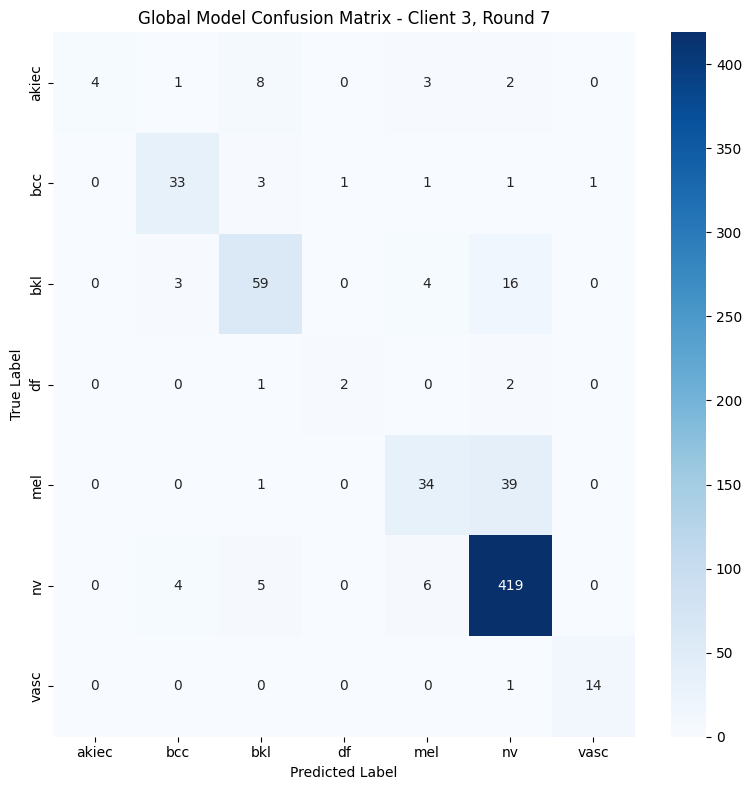


--- Round 8 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [03:53<00:00,  2.78s/it]


Client 1 Epoch 1: Train Loss: 0.2984, Train Accuracy: 93.19%


Client 1 Epoch 2: 100%|██████████| 84/84 [03:53<00:00,  2.78s/it]


Client 1 Epoch 2: Train Loss: 0.3021, Train Accuracy: 95.88%


Client 1 Epoch 3: 100%|██████████| 84/84 [03:53<00:00,  2.78s/it]


Client 1 Epoch 3: Train Loss: 0.3053, Train Accuracy: 96.15%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:26<00:00,  1.25s/it]


Test Loss: 0.6417, Test Accuracy: 82.36%, F1-Score: 0.8048
Confusion Matrix:
 [[  9   9   3   0   3   4   0]
 [  1  19   1   1   2   8   1]
 [  1   0  47   2   2  20   0]
 [  0   0   0   9   0   1   0]
 [  1   0   9   1  29  35   2]
 [  0   1   6   1   2 427   1]
 [  0   0   0   0   0   0  11]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.32      0.45        28
           1       0.66      0.58      0.61        33
           2       0.71      0.65      0.68        72
           3       0.64      0.90      0.75        10
           4       0.76      0.38      0.50        77
           5       0.86      0.97      0.92       438
           6       0.73      1.00      0.85        11

    accuracy                           0.82       669
   macro avg       0.73      0.69      0.68       669
weighted avg       0.81      0.82      0.80       669

Sensitivity/Recall:
 [0.32142857 0.57575758 0.65277778 0.9        0.37662338 0.9748

Client 2 Epoch 1: 100%|██████████| 84/84 [05:28<00:00,  3.90s/it]


Client 2 Epoch 1: Train Loss: 0.3035, Train Accuracy: 93.59%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:28<00:00,  3.91s/it]


Client 2 Epoch 2: Train Loss: 0.3009, Train Accuracy: 95.32%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:28<00:00,  3.91s/it]


Client 2 Epoch 3: Train Loss: 0.3355, Train Accuracy: 95.65%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:27<00:00,  1.29s/it]


Test Loss: 0.5111, Test Accuracy: 82.93%, F1-Score: 0.8245
Confusion Matrix:
 [[  1   1   9   2   7   2   0]
 [  1  24   6   1   1   5   0]
 [  0   1  44   0   6   7   0]
 [  0   0   2   6   1   0   0]
 [  0   1   5   0  45  16   1]
 [  1   0  17   0  21 424   0]
 [  0   0   0   0   0   0  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.05      0.08        22
           1       0.89      0.63      0.74        38
           2       0.53      0.76      0.62        58
           3       0.67      0.67      0.67         9
           4       0.56      0.66      0.60        68
           5       0.93      0.92      0.92       463
           6       0.91      1.00      0.95        10

    accuracy                           0.83       668
   macro avg       0.69      0.67      0.66       668
weighted avg       0.83      0.83      0.82       668

Sensitivity/Recall:
 [0.04545455 0.63157895 0.75862069 0.66666667 0.66176471 0.9157

Client 3 Epoch 1: 100%|██████████| 84/84 [06:19<00:00,  4.51s/it]


Client 3 Epoch 1: Train Loss: 0.2919, Train Accuracy: 93.56%


Client 3 Epoch 2: 100%|██████████| 84/84 [06:19<00:00,  4.52s/it]


Client 3 Epoch 2: Train Loss: 0.3734, Train Accuracy: 93.74%


Client 3 Epoch 3: 100%|██████████| 84/84 [06:19<00:00,  4.52s/it]


Client 3 Epoch 3: Train Loss: 0.3103, Train Accuracy: 96.14%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it]


Test Loss: 0.6274, Test Accuracy: 79.49%, F1-Score: 0.7999
Confusion Matrix:
 [[  5   1   8   0   3   1   0]
 [ 12  17   7   0   2   2   0]
 [  0   2  68   0   6   6   0]
 [  2   0   0   3   0   0   0]
 [  0   0   5   0  52  17   0]
 [  1   3  23   0  33 373   1]
 [  0   0   0   1   0   1  13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.28      0.26        18
           1       0.74      0.42      0.54        40
           2       0.61      0.83      0.70        82
           3       0.75      0.60      0.67         5
           4       0.54      0.70      0.61        74
           5       0.93      0.86      0.89       434
           6       0.93      0.87      0.90        15

    accuracy                           0.79       668
   macro avg       0.68      0.65      0.65       668
weighted avg       0.82      0.79      0.80       668

Sensitivity/Recall:
 [0.27777778 0.425      0.82926829 0.6        0.7027027  0.8594

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.59it/s]

Test Loss: 0.4726, Test Accuracy: 85.05%, F1-Score: 0.8440
Confusion Matrix:
 [[  7   1   9   0   8   3   0]
 [  0  19   7   0   0   6   1]
 [  0   0  61   0   3   8   0]
 [  1   0   2   7   0   0   0]
 [  1   0   8   0  51  17   0]
 [  0   1  12   0  11 414   0]
 [  0   0   0   0   0   1  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.25      0.38        28
           1       0.90      0.58      0.70        33
           2       0.62      0.85      0.71        72
           3       1.00      0.70      0.82        10
           4       0.70      0.66      0.68        77
           5       0.92      0.95      0.93       438
           6       0.91      0.91      0.91        11

    accuracy                           0.85       669
   macro avg       0.83      0.70      0.73       669
weighted avg       0.86      0.85      0.84       669

Sensitivity/Recall:
 [0.25       0.57575758 0.84722222 0.7        0.66233766 0.9452

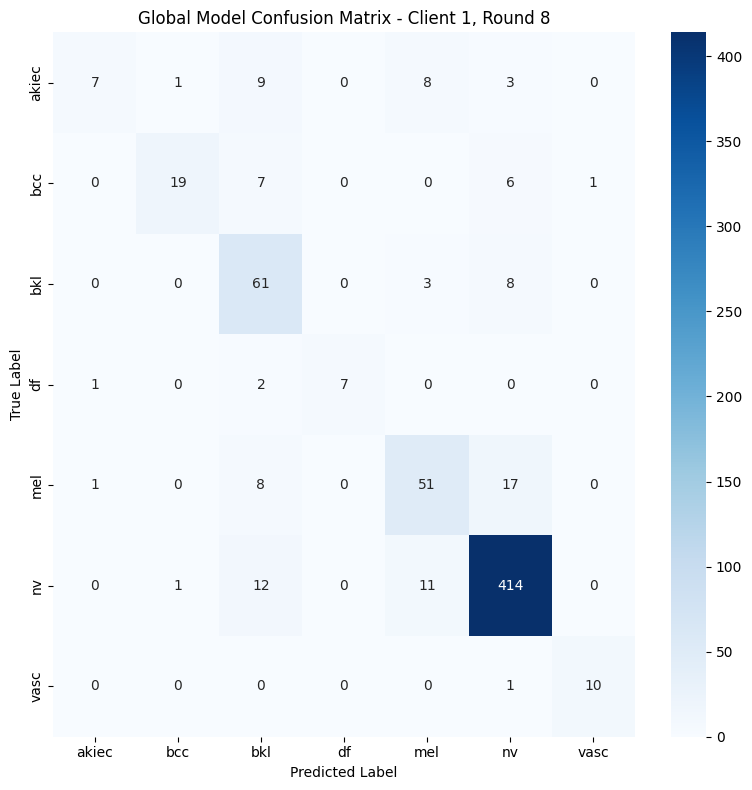


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.54it/s]

Test Loss: 0.4306, Test Accuracy: 85.63%, F1-Score: 0.8468
Confusion Matrix:
 [[  3   1   9   0   6   3   0]
 [  0  25   7   0   2   4   0]
 [  0   0  50   0   2   6   0]
 [  3   0   0   4   1   1   0]
 [  0   2   4   0  38  23   1]
 [  1   0  11   0   9 442   0]
 [  0   0   0   0   0   0  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.14      0.21        22
           1       0.89      0.66      0.76        38
           2       0.62      0.86      0.72        58
           3       1.00      0.44      0.62         9
           4       0.66      0.56      0.60        68
           5       0.92      0.95      0.94       463
           6       0.91      1.00      0.95        10

    accuracy                           0.86       668
   macro avg       0.78      0.66      0.68       668
weighted avg       0.85      0.86      0.85       668

Sensitivity/Recall:
 [0.13636364 0.65789474 0.86206897 0.44444444 0.55882353 0.9546

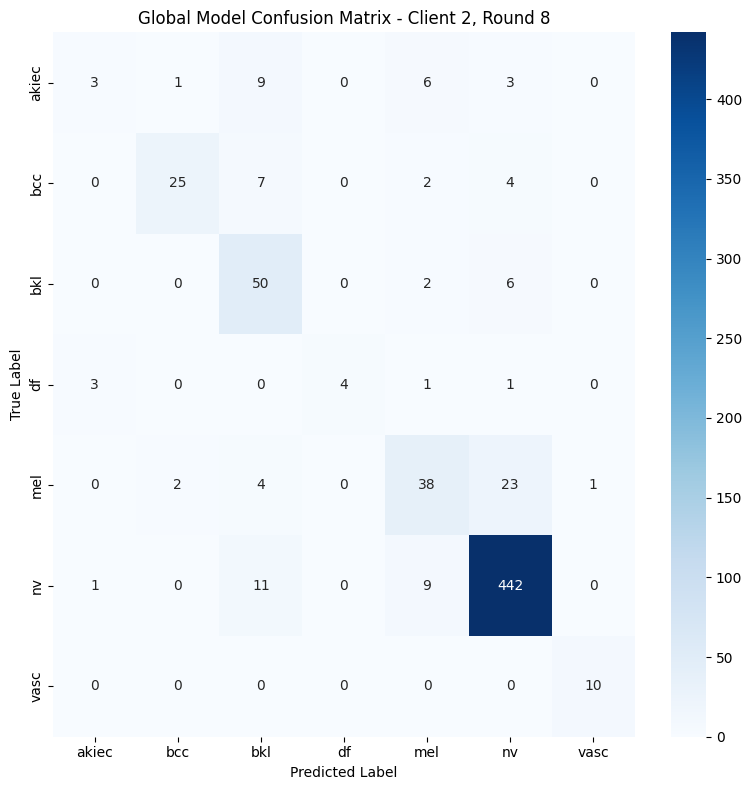


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.55it/s]

Test Loss: 0.4941, Test Accuracy: 85.03%, F1-Score: 0.8420
Confusion Matrix:
 [[  6   1   7   0   2   2   0]
 [  1  29   4   1   2   2   1]
 [  0   3  63   0   6  10   0]
 [  0   0   0   3   0   2   0]
 [  0   0   3   0  38  33   0]
 [  0   2   6   0  10 415   1]
 [  0   0   0   1   0   0  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.33      0.48        18
           1       0.83      0.72      0.77        40
           2       0.76      0.77      0.76        82
           3       0.60      0.60      0.60         5
           4       0.66      0.51      0.58        74
           5       0.89      0.96      0.92       434
           6       0.88      0.93      0.90        15

    accuracy                           0.85       668
   macro avg       0.78      0.69      0.72       668
weighted avg       0.84      0.85      0.84       668

Sensitivity/Recall:
 [0.33333333 0.725      0.76829268 0.6        0.51351351 0.9562

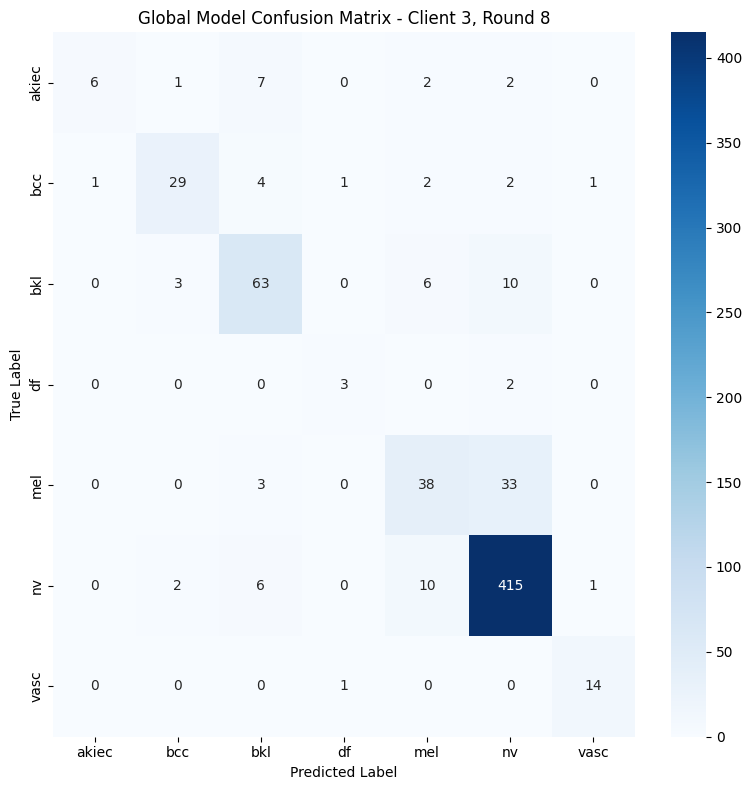


--- Round 9 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [04:22<00:00,  3.13s/it]


Client 1 Epoch 1: Train Loss: 0.2728, Train Accuracy: 94.57%


Client 1 Epoch 2: 100%|██████████| 84/84 [04:23<00:00,  3.14s/it]


Client 1 Epoch 2: Train Loss: 0.3109, Train Accuracy: 95.32%


Client 1 Epoch 3: 100%|██████████| 84/84 [04:23<00:00,  3.13s/it]


Client 1 Epoch 3: Train Loss: 0.3293, Train Accuracy: 95.73%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:34<00:00,  1.64s/it]


Test Loss: 0.6530, Test Accuracy: 79.97%, F1-Score: 0.7912
Confusion Matrix:
 [[ 12   0   7   0   4   5   0]
 [  4  13   4   1   1   9   1]
 [  2   0  56   0   3  11   0]
 [  1   0   4   4   1   0   0]
 [  2   0   9   0  38  27   1]
 [  1   2  20   0   9 406   0]
 [  0   0   0   0   1   4   6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.43      0.48        28
           1       0.87      0.39      0.54        33
           2       0.56      0.78      0.65        72
           3       0.80      0.40      0.53        10
           4       0.67      0.49      0.57        77
           5       0.88      0.93      0.90       438
           6       0.75      0.55      0.63        11

    accuracy                           0.80       669
   macro avg       0.72      0.57      0.62       669
weighted avg       0.80      0.80      0.79       669

Sensitivity/Recall:
 [0.42857143 0.39393939 0.77777778 0.4        0.49350649 0.9269

Client 2 Epoch 1: 100%|██████████| 84/84 [05:09<00:00,  3.68s/it]


Client 2 Epoch 1: Train Loss: 0.2798, Train Accuracy: 94.53%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:09<00:00,  3.68s/it]


Client 2 Epoch 2: Train Loss: 0.2799, Train Accuracy: 96.48%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:09<00:00,  3.68s/it]


Client 2 Epoch 3: Train Loss: 0.3337, Train Accuracy: 96.07%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Test Loss: 0.5779, Test Accuracy: 83.98%, F1-Score: 0.8375
Confusion Matrix:
 [[  5   6   6   0   3   2   0]
 [  0  37   0   0   0   1   0]
 [  1   5  39   0   4   9   0]
 [  1   2   0   4   2   0   0]
 [  1   5   6   0  41  15   0]
 [  1   6   6   0  23 427   0]
 [  0   0   0   0   2   0   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.23      0.32        22
           1       0.61      0.97      0.75        38
           2       0.68      0.67      0.68        58
           3       1.00      0.44      0.62         9
           4       0.55      0.60      0.57        68
           5       0.94      0.92      0.93       463
           6       1.00      0.80      0.89        10

    accuracy                           0.84       668
   macro avg       0.76      0.66      0.68       668
weighted avg       0.85      0.84      0.84       668

Sensitivity/Recall:
 [0.22727273 0.97368421 0.67241379 0.44444444 0.60294118 0.9222

Client 3 Epoch 1: 100%|██████████| 84/84 [05:59<00:00,  4.28s/it]


Client 3 Epoch 1: Train Loss: 0.2779, Train Accuracy: 94.64%


Client 3 Epoch 2: 100%|██████████| 84/84 [06:07<00:00,  4.37s/it]


Client 3 Epoch 2: Train Loss: 0.3177, Train Accuracy: 94.94%


Client 3 Epoch 3: 100%|██████████| 84/84 [06:01<00:00,  4.30s/it]


Client 3 Epoch 3: Train Loss: 0.2952, Train Accuracy: 96.37%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:37<00:00,  1.79s/it]


Test Loss: 0.5751, Test Accuracy: 83.23%, F1-Score: 0.8233
Confusion Matrix:
 [[  6   1   6   0   3   2   0]
 [  1  34   1   0   3   0   1]
 [  0   3  56   0   4  19   0]
 [  0   0   0   3   0   2   0]
 [  0   0   1   0  35  38   0]
 [  0   2   9   0  14 409   0]
 [  0   0   1   1   0   0  13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.33      0.48        18
           1       0.85      0.85      0.85        40
           2       0.76      0.68      0.72        82
           3       0.75      0.60      0.67         5
           4       0.59      0.47      0.53        74
           5       0.87      0.94      0.90       434
           6       0.93      0.87      0.90        15

    accuracy                           0.83       668
   macro avg       0.80      0.68      0.72       668
weighted avg       0.82      0.83      0.82       668

Sensitivity/Recall:
 [0.33333333 0.85       0.68292683 0.6        0.47297297 0.9423

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.59it/s]

Test Loss: 0.4990, Test Accuracy: 84.16%, F1-Score: 0.8351
Confusion Matrix:
 [[  9   3   8   0   6   2   0]
 [  0  21   5   0   0   7   0]
 [  0   0  57   0   3  12   0]
 [  1   0   4   5   0   0   0]
 [  2   0   6   0  48  21   0]
 [  0   2   9   0  12 415   0]
 [  0   0   0   0   2   1   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.32      0.45        28
           1       0.81      0.64      0.71        33
           2       0.64      0.79      0.71        72
           3       1.00      0.50      0.67        10
           4       0.68      0.62      0.65        77
           5       0.91      0.95      0.93       438
           6       1.00      0.73      0.84        11

    accuracy                           0.84       669
   macro avg       0.83      0.65      0.71       669
weighted avg       0.84      0.84      0.84       669

Sensitivity/Recall:
 [0.32142857 0.63636364 0.79166667 0.5        0.62337662 0.9474

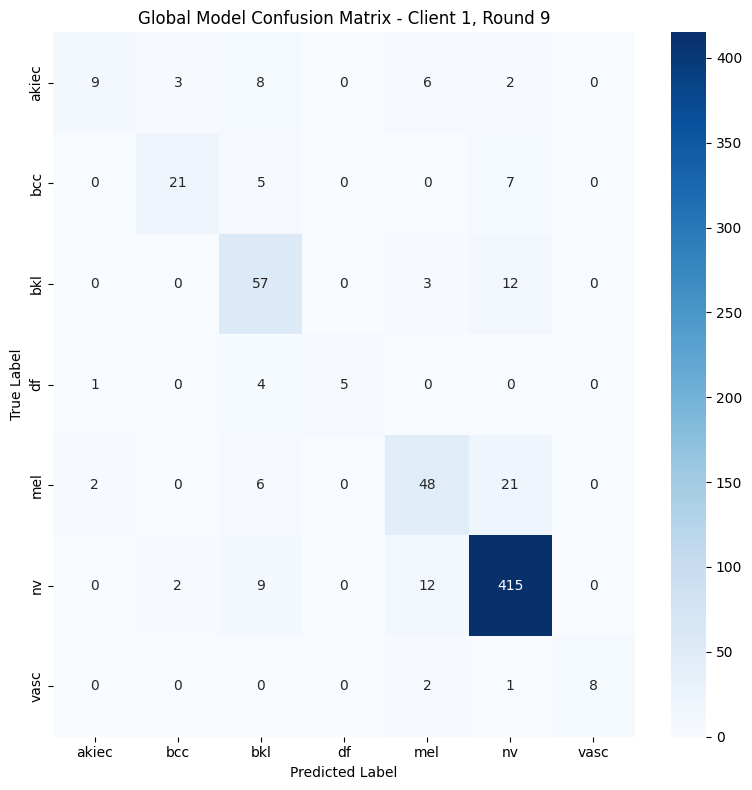


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.54it/s]

Test Loss: 0.4404, Test Accuracy: 85.63%, F1-Score: 0.8470
Confusion Matrix:
 [[  5   1   8   0   5   3   0]
 [  1  28   4   0   1   4   0]
 [  0   0  46   0   2  10   0]
 [  2   1   0   3   2   1   0]
 [  0   3   7   0  36  22   0]
 [  0   1  10   0   7 445   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.23      0.33        22
           1       0.82      0.74      0.78        38
           2       0.61      0.79      0.69        58
           3       1.00      0.33      0.50         9
           4       0.67      0.53      0.59        68
           5       0.92      0.96      0.94       463
           6       1.00      0.90      0.95        10

    accuracy                           0.86       668
   macro avg       0.81      0.64      0.68       668
weighted avg       0.85      0.86      0.85       668

Sensitivity/Recall:
 [0.22727273 0.73684211 0.79310345 0.33333333 0.52941176 0.9611

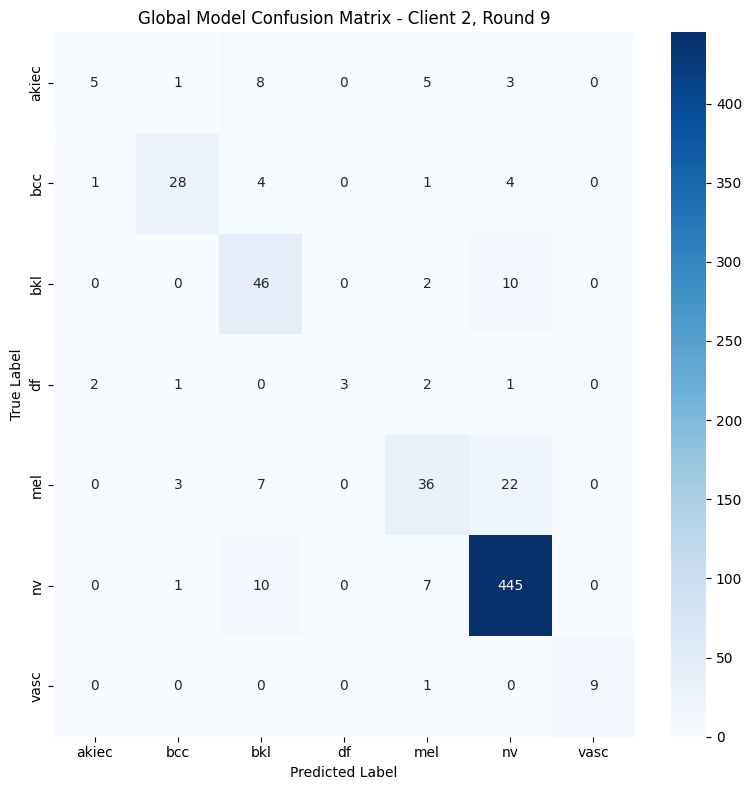


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.54it/s]

Test Loss: 0.5082, Test Accuracy: 84.58%, F1-Score: 0.8357
Confusion Matrix:
 [[  7   1   7   0   1   2   0]
 [  2  33   0   0   3   2   0]
 [  0   4  60   0   4  14   0]
 [  0   0   1   2   0   2   0]
 [  0   0   4   0  34  36   0]
 [  0   3   7   0   9 415   0]
 [  0   0   0   0   0   1  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.39      0.52        18
           1       0.80      0.82      0.81        40
           2       0.76      0.73      0.75        82
           3       1.00      0.40      0.57         5
           4       0.67      0.46      0.54        74
           5       0.88      0.96      0.92       434
           6       1.00      0.93      0.97        15

    accuracy                           0.85       668
   macro avg       0.84      0.67      0.73       668
weighted avg       0.84      0.85      0.84       668

Sensitivity/Recall:
 [0.38888889 0.825      0.73170732 0.4        0.45945946 0.9562

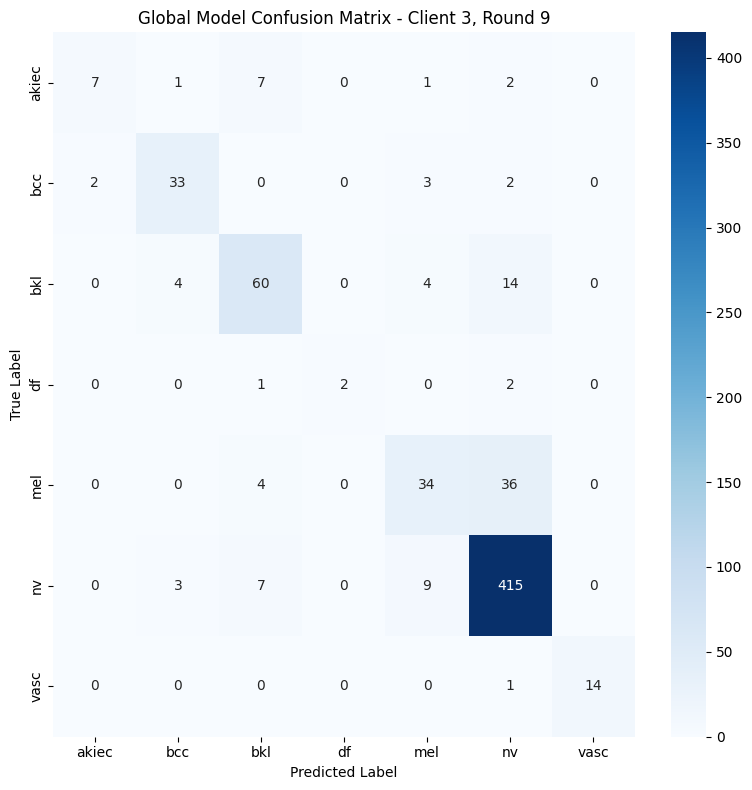


--- Round 10 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [04:21<00:00,  3.12s/it]


Client 1 Epoch 1: Train Loss: 0.2506, Train Accuracy: 95.47%


Client 1 Epoch 2: 100%|██████████| 84/84 [04:22<00:00,  3.12s/it]


Client 1 Epoch 2: Train Loss: 0.2753, Train Accuracy: 96.59%


Client 1 Epoch 3: 100%|██████████| 84/84 [04:22<00:00,  3.12s/it]


Client 1 Epoch 3: Train Loss: 0.2832, Train Accuracy: 96.48%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:31<00:00,  1.51s/it]


Test Loss: 0.6170, Test Accuracy: 83.26%, F1-Score: 0.8286
Confusion Matrix:
 [[ 17   4   2   0   3   2   0]
 [  1  23   2   0   1   4   2]
 [  3   0  48   0   4  17   0]
 [  1   2   1   6   0   0   0]
 [  5   1   7   0  42  22   0]
 [  1   5  13   0   9 410   0]
 [  0   0   0   0   0   0  11]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.61      0.61        28
           1       0.66      0.70      0.68        33
           2       0.66      0.67      0.66        72
           3       1.00      0.60      0.75        10
           4       0.71      0.55      0.62        77
           5       0.90      0.94      0.92       438
           6       0.85      1.00      0.92        11

    accuracy                           0.83       669
   macro avg       0.77      0.72      0.74       669
weighted avg       0.83      0.83      0.83       669

Sensitivity/Recall:
 [0.60714286 0.6969697  0.66666667 0.6        0.54545455 0.9360

Client 2 Epoch 1: 100%|██████████| 84/84 [05:32<00:00,  3.95s/it]


Client 2 Epoch 1: Train Loss: 0.2758, Train Accuracy: 94.98%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:32<00:00,  3.96s/it]


Client 2 Epoch 2: Train Loss: 0.2985, Train Accuracy: 96.07%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:32<00:00,  3.96s/it]


Client 2 Epoch 3: Train Loss: 0.2639, Train Accuracy: 97.49%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:20<00:00,  1.01it/s]


Test Loss: 0.6091, Test Accuracy: 83.08%, F1-Score: 0.8183
Confusion Matrix:
 [[ 10   2   6   0   2   2   0]
 [  3  23   4   0   0   8   0]
 [  0   0  39   0   4  15   0]
 [  2   0   0   3   1   3   0]
 [  0   2   5   0  28  33   0]
 [  0   1   5   0  11 446   0]
 [  0   0   0   0   1   3   6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.45      0.54        22
           1       0.82      0.61      0.70        38
           2       0.66      0.67      0.67        58
           3       1.00      0.33      0.50         9
           4       0.60      0.41      0.49        68
           5       0.87      0.96      0.92       463
           6       1.00      0.60      0.75        10

    accuracy                           0.83       668
   macro avg       0.80      0.58      0.65       668
weighted avg       0.82      0.83      0.82       668

Sensitivity/Recall:
 [0.45454545 0.60526316 0.67241379 0.33333333 0.41176471 0.9632

Client 3 Epoch 1: 100%|██████████| 84/84 [05:37<00:00,  4.02s/it]


Client 3 Epoch 1: Train Loss: 0.2535, Train Accuracy: 95.09%


Client 3 Epoch 2: 100%|██████████| 84/84 [05:37<00:00,  4.02s/it]


Client 3 Epoch 2: Train Loss: 0.2568, Train Accuracy: 96.78%


Client 3 Epoch 3: 100%|██████████| 84/84 [05:38<00:00,  4.03s/it]


Client 3 Epoch 3: Train Loss: 0.2831, Train Accuracy: 96.93%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:16<00:00,  1.24it/s]


Test Loss: 0.5657, Test Accuracy: 83.83%, F1-Score: 0.8282
Confusion Matrix:
 [[  5   2   5   0   4   2   0]
 [  1  24   7   0   5   2   1]
 [  0   3  60   0   8  11   0]
 [  1   0   1   0   1   2   0]
 [  0   1   2   0  43  28   0]
 [  0   1  11   0   8 413   1]
 [  0   0   0   0   0   0  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.28      0.40        18
           1       0.77      0.60      0.68        40
           2       0.70      0.73      0.71        82
           3       0.00      0.00      0.00         5
           4       0.62      0.58      0.60        74
           5       0.90      0.95      0.93       434
           6       0.88      1.00      0.94        15

    accuracy                           0.84       668
   macro avg       0.66      0.59      0.61       668
weighted avg       0.83      0.84      0.83       668

Sensitivity/Recall:
 [0.27777778 0.6        0.73170732 0.         0.58108108 0.9516

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.5121, Test Accuracy: 86.10%, F1-Score: 0.8559
Confusion Matrix:
 [[ 13   2   4   0   6   3   0]
 [  0  18   5   0   2   7   1]
 [  0   0  56   0   3  13   0]
 [  1   0   3   6   0   0   0]
 [  0   0   4   0  54  19   0]
 [  0   0  10   0  10 418   0]
 [  0   0   0   0   0   0  11]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.46      0.62        28
           1       0.90      0.55      0.68        33
           2       0.68      0.78      0.73        72
           3       1.00      0.60      0.75        10
           4       0.72      0.70      0.71        77
           5       0.91      0.95      0.93       438
           6       0.92      1.00      0.96        11

    accuracy                           0.86       669
   macro avg       0.87      0.72      0.77       669
weighted avg       0.86      0.86      0.86       669

Sensitivity/Recall:
 [0.46428571 0.54545455 0.77777778 0.6        0.7012987  0.9543

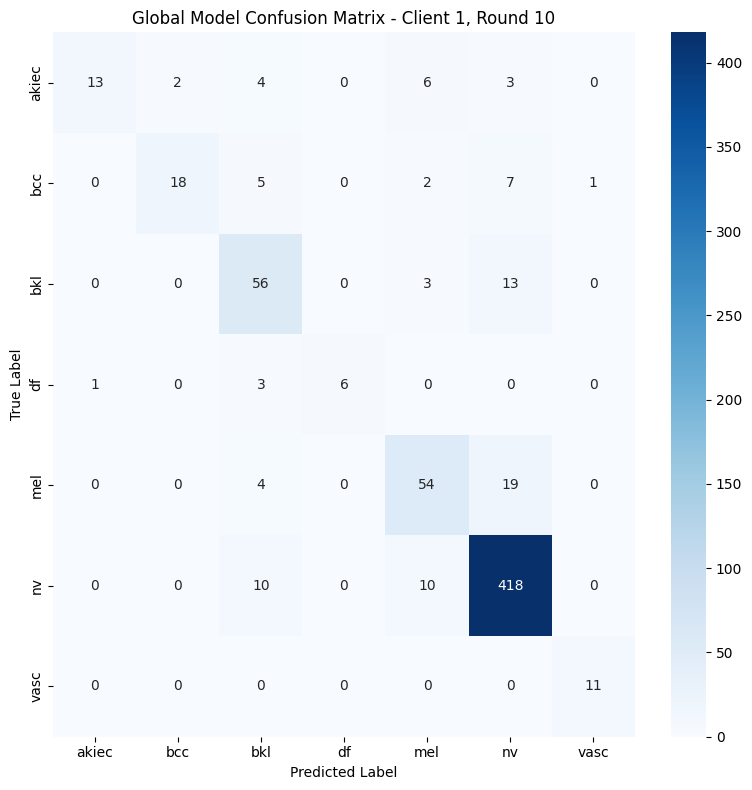


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]


Test Loss: 0.4542, Test Accuracy: 87.28%, F1-Score: 0.8632
Confusion Matrix:
 [[  5   2   6   0   6   3   0]
 [  1  26   4   0   2   5   0]
 [  0   0  48   0   2   8   0]
 [  3   0   0   3   2   1   0]
 [  0   1   4   0  41  22   0]
 [  1   1   4   0   7 450   0]
 [  0   0   0   0   0   0  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.23      0.31        22
           1       0.87      0.68      0.76        38
           2       0.73      0.83      0.77        58
           3       1.00      0.33      0.50         9
           4       0.68      0.60      0.64        68
           5       0.92      0.97      0.95       463
           6       1.00      1.00      1.00        10

    accuracy                           0.87       668
   macro avg       0.81      0.66      0.71       668
weighted avg       0.86      0.87      0.86       668

Sensitivity/Recall:
 [0.22727273 0.68421053 0.82758621 0.33333333 0.60294118 0.9719

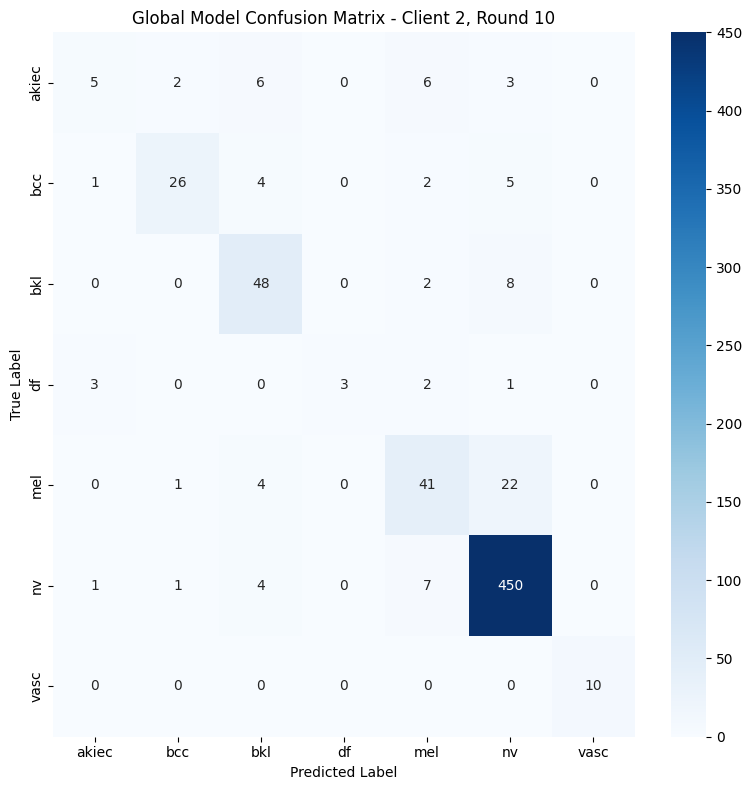


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]

Test Loss: 0.5005, Test Accuracy: 84.73%, F1-Score: 0.8388
Confusion Matrix:
 [[  8   1   3   0   4   2   0]
 [  3  27   2   0   2   5   1]
 [  2   2  60   0   4  14   0]
 [  0   0   1   2   0   2   0]
 [  1   0   4   0  37  32   0]
 [  0   1   7   0   9 417   0]
 [  0   0   0   0   0   0  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.44      0.50        18
           1       0.87      0.68      0.76        40
           2       0.78      0.73      0.75        82
           3       1.00      0.40      0.57         5
           4       0.66      0.50      0.57        74
           5       0.88      0.96      0.92       434
           6       0.94      1.00      0.97        15

    accuracy                           0.85       668
   macro avg       0.81      0.67      0.72       668
weighted avg       0.84      0.85      0.84       668

Sensitivity/Recall:
 [0.44444444 0.675      0.73170732 0.4        0.5        0.9608

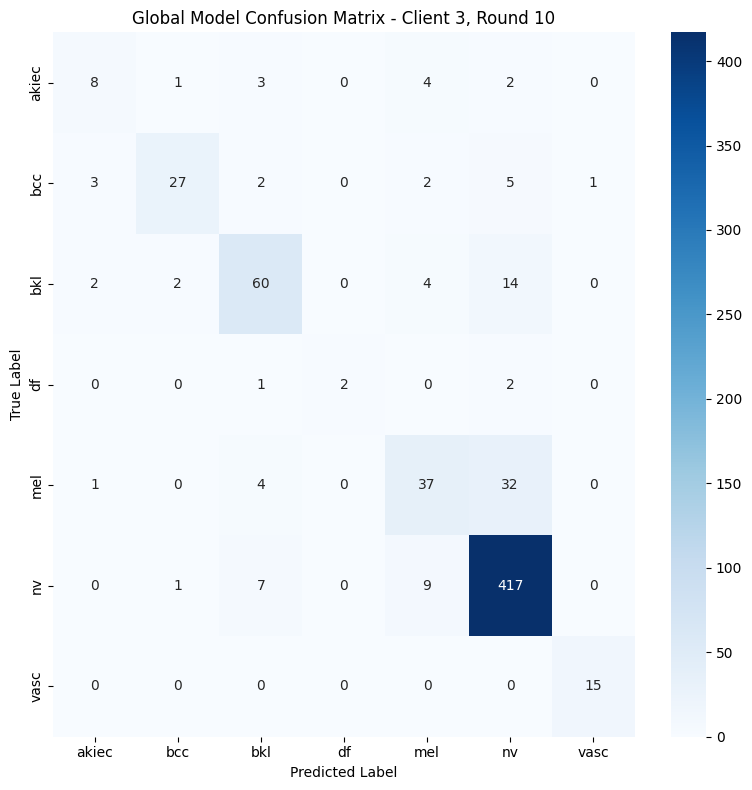


--- Round 11 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [04:18<00:00,  3.08s/it]


Client 1 Epoch 1: Train Loss: 0.2409, Train Accuracy: 96.26%


Client 1 Epoch 2: 100%|██████████| 84/84 [04:19<00:00,  3.09s/it]


Client 1 Epoch 2: Train Loss: 0.2597, Train Accuracy: 97.31%


Client 1 Epoch 3: 100%|██████████| 84/84 [04:19<00:00,  3.08s/it]


Client 1 Epoch 3: Train Loss: 0.2892, Train Accuracy: 97.08%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:38<00:00,  1.81s/it]


Test Loss: 0.6623, Test Accuracy: 81.76%, F1-Score: 0.8139
Confusion Matrix:
 [[ 10   0   8   2   6   2   0]
 [  2  16   5   2   1   7   0]
 [  1   0  54   0   8   9   0]
 [  0   0   4   6   0   0   0]
 [  1   0   6   0  52  18   0]
 [  0   0  13   0  20 405   0]
 [  0   0   1   0   2   4   4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.36      0.48        28
           1       1.00      0.48      0.65        33
           2       0.59      0.75      0.66        72
           3       0.60      0.60      0.60        10
           4       0.58      0.68      0.63        77
           5       0.91      0.92      0.92       438
           6       1.00      0.36      0.53        11

    accuracy                           0.82       669
   macro avg       0.77      0.59      0.64       669
weighted avg       0.83      0.82      0.81       669

Sensitivity/Recall:
 [0.35714286 0.48484848 0.75       0.6        0.67532468 0.9246

Client 2 Epoch 1: 100%|██████████| 84/84 [05:04<00:00,  3.62s/it]


Client 2 Epoch 1: Train Loss: 0.2505, Train Accuracy: 95.09%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:03<00:00,  3.62s/it]


Client 2 Epoch 2: Train Loss: 0.2299, Train Accuracy: 97.56%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:03<00:00,  3.62s/it]


Client 2 Epoch 3: Train Loss: 0.2841, Train Accuracy: 96.55%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:21<00:00,  1.01s/it]


Test Loss: 0.5987, Test Accuracy: 83.38%, F1-Score: 0.8284
Confusion Matrix:
 [[  7   1   4   0   6   4   0]
 [  0  29   3   0   0   6   0]
 [  1   1  42   0   4  10   0]
 [  1   2   1   1   3   1   0]
 [  0   4   5   0  40  17   2]
 [  1   3   9   0  19 431   0]
 [  0   0   0   1   2   0   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.32      0.44        22
           1       0.72      0.76      0.74        38
           2       0.66      0.72      0.69        58
           3       0.50      0.11      0.18         9
           4       0.54      0.59      0.56        68
           5       0.92      0.93      0.92       463
           6       0.78      0.70      0.74        10

    accuracy                           0.83       668
   macro avg       0.69      0.59      0.61       668
weighted avg       0.83      0.83      0.83       668

Sensitivity/Recall:
 [0.31818182 0.76315789 0.72413793 0.11111111 0.58823529 0.9308

Client 3 Epoch 1: 100%|██████████| 84/84 [06:00<00:00,  4.29s/it]


Client 3 Epoch 1: Train Loss: 0.2306, Train Accuracy: 96.37%


Client 3 Epoch 2: 100%|██████████| 84/84 [06:01<00:00,  4.30s/it]


Client 3 Epoch 2: Train Loss: 0.3109, Train Accuracy: 96.48%


Client 3 Epoch 3: 100%|██████████| 84/84 [06:01<00:00,  4.30s/it]


Client 3 Epoch 3: Train Loss: 0.2358, Train Accuracy: 98.09%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:27<00:00,  1.33s/it]


Test Loss: 0.8207, Test Accuracy: 81.59%, F1-Score: 0.7919
Confusion Matrix:
 [[ 14   2   0   0   0   2   0]
 [  4  29   1   0   2   3   1]
 [  4   4  35   0   2  37   0]
 [  0   0   0   3   0   2   0]
 [  1   1   0   0  24  48   0]
 [  0   4   2   0   2 425   1]
 [  0   0   0   0   0   0  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.78      0.68        18
           1       0.72      0.72      0.72        40
           2       0.92      0.43      0.58        82
           3       1.00      0.60      0.75         5
           4       0.80      0.32      0.46        74
           5       0.82      0.98      0.89       434
           6       0.88      1.00      0.94        15

    accuracy                           0.82       668
   macro avg       0.82      0.69      0.72       668
weighted avg       0.82      0.82      0.79       668

Sensitivity/Recall:
 [0.77777778 0.725      0.42682927 0.6        0.32432432 0.9792

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.60it/s]

Test Loss: 0.4813, Test Accuracy: 86.10%, F1-Score: 0.8571
Confusion Matrix:
 [[ 15   1   5   0   5   2   0]
 [  2  20   4   0   0   6   1]
 [  0   0  57   0   3  12   0]
 [  1   0   3   6   0   0   0]
 [  1   0   5   0  52  19   0]
 [  0   3   9   0   7 418   1]
 [  0   0   0   0   2   1   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.54      0.64        28
           1       0.83      0.61      0.70        33
           2       0.69      0.79      0.74        72
           3       1.00      0.60      0.75        10
           4       0.75      0.68      0.71        77
           5       0.91      0.95      0.93       438
           6       0.80      0.73      0.76        11

    accuracy                           0.86       669
   macro avg       0.83      0.70      0.75       669
weighted avg       0.86      0.86      0.86       669

Sensitivity/Recall:
 [0.53571429 0.60606061 0.79166667 0.6        0.67532468 0.9543

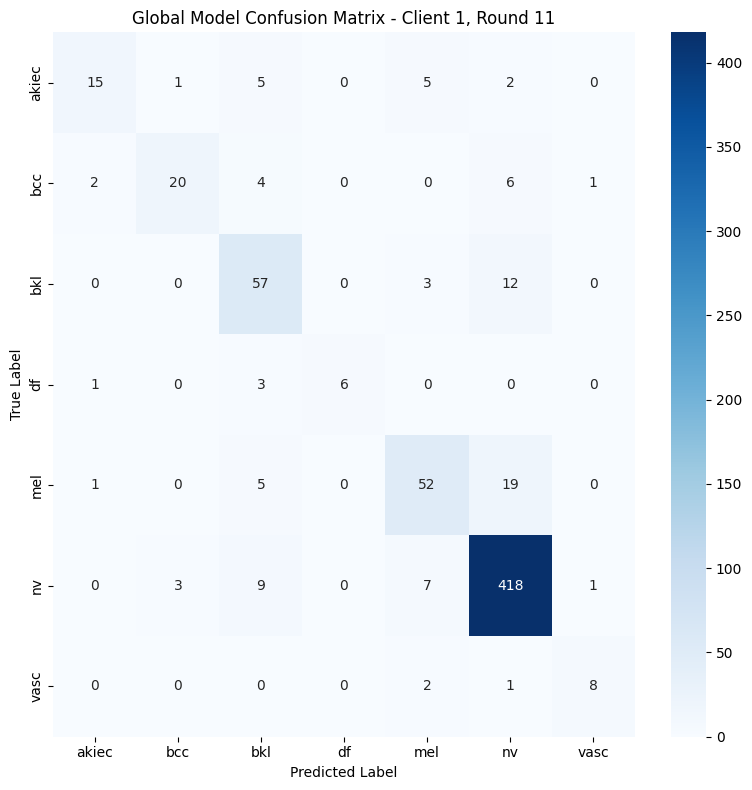


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]

Test Loss: 0.4151, Test Accuracy: 86.98%, F1-Score: 0.8612
Confusion Matrix:
 [[  7   1   7   0   3   4   0]
 [  2  29   3   0   0   4   0]
 [  0   1  43   0   4  10   0]
 [  3   0   0   4   1   1   0]
 [  0   3   2   0  38  25   0]
 [  1   1   4   0   6 451   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.32      0.40        22
           1       0.83      0.76      0.79        38
           2       0.73      0.74      0.74        58
           3       1.00      0.44      0.62         9
           4       0.72      0.56      0.63        68
           5       0.91      0.97      0.94       463
           6       1.00      0.90      0.95        10

    accuracy                           0.87       668
   macro avg       0.82      0.67      0.72       668
weighted avg       0.86      0.87      0.86       668

Sensitivity/Recall:
 [0.31818182 0.76315789 0.74137931 0.44444444 0.55882353 0.9740

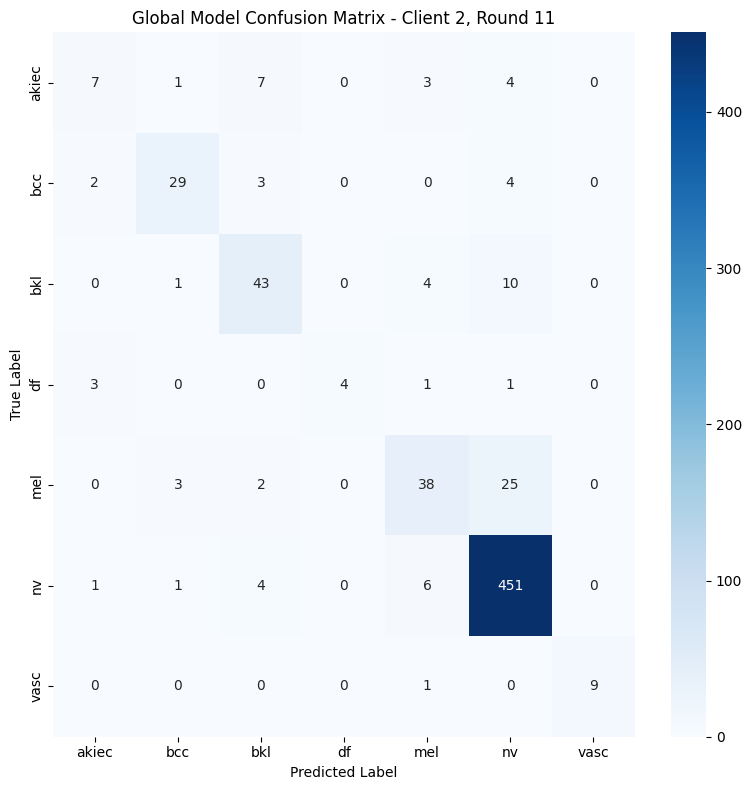


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.5116, Test Accuracy: 84.88%, F1-Score: 0.8406
Confusion Matrix:
 [[ 10   1   3   0   2   2   0]
 [  2  31   1   1   2   2   1]
 [  0   3  59   0   5  15   0]
 [  0   0   1   2   0   2   0]
 [  0   1   2   0  35  36   0]
 [  0   3   3   0  11 416   1]
 [  0   0   0   1   0   0  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.56      0.67        18
           1       0.79      0.78      0.78        40
           2       0.86      0.72      0.78        82
           3       0.50      0.40      0.44         5
           4       0.64      0.47      0.54        74
           5       0.88      0.96      0.92       434
           6       0.88      0.93      0.90        15

    accuracy                           0.85       668
   macro avg       0.77      0.69      0.72       668
weighted avg       0.84      0.85      0.84       668

Sensitivity/Recall:
 [0.55555556 0.775      0.7195122  0.4        0.47297297 0.9585

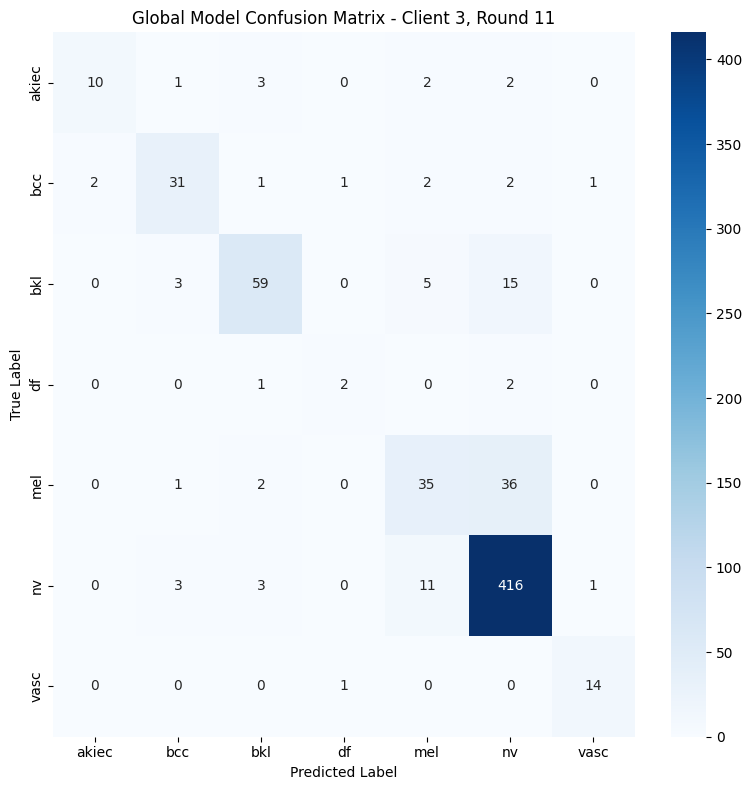


--- Round 12 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [04:37<00:00,  3.31s/it]


Client 1 Epoch 1: Train Loss: 0.2105, Train Accuracy: 96.56%


Client 1 Epoch 2: 100%|██████████| 84/84 [04:38<00:00,  3.31s/it]


Client 1 Epoch 2: Train Loss: 0.2467, Train Accuracy: 97.23%


Client 1 Epoch 3: 100%|██████████| 84/84 [04:38<00:00,  3.31s/it]


Client 1 Epoch 3: Train Loss: 0.2796, Train Accuracy: 96.97%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:42<00:00,  2.01s/it]


Test Loss: 0.7976, Test Accuracy: 80.72%, F1-Score: 0.7928
Confusion Matrix:
 [[  7   7   1   0   8   4   1]
 [  1  22   0   0   3   5   2]
 [  2   3  24   0  19  24   0]
 [  1   0   1   4   3   1   0]
 [  1   0   0   0  59  15   2]
 [  0   2   1   0  19 415   1]
 [  0   0   0   0   1   1   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.25      0.35        28
           1       0.65      0.67      0.66        33
           2       0.89      0.33      0.48        72
           3       1.00      0.40      0.57        10
           4       0.53      0.77      0.62        77
           5       0.89      0.95      0.92       438
           6       0.60      0.82      0.69        11

    accuracy                           0.81       669
   macro avg       0.73      0.60      0.61       669
weighted avg       0.82      0.81      0.79       669

Sensitivity/Recall:
 [0.25       0.66666667 0.33333333 0.4        0.76623377 0.9474

Client 2 Epoch 1: 100%|██████████| 84/84 [05:34<00:00,  3.98s/it]


Client 2 Epoch 1: Train Loss: 0.2427, Train Accuracy: 96.22%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:35<00:00,  3.99s/it]


Client 2 Epoch 2: Train Loss: 0.2398, Train Accuracy: 97.60%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:35<00:00,  3.99s/it]


Client 2 Epoch 3: Train Loss: 0.3004, Train Accuracy: 96.55%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:21<00:00,  1.00s/it]


Test Loss: 0.5351, Test Accuracy: 84.43%, F1-Score: 0.8345
Confusion Matrix:
 [[  7   2   7   0   3   3   0]
 [  1  29   2   0   1   5   0]
 [  1   0  46   0   0  11   0]
 [  2   2   0   3   0   2   0]
 [  0   2   5   0  32  29   0]
 [  1   1  10   0  11 440   0]
 [  0   0   0   0   1   2   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.32      0.41        22
           1       0.81      0.76      0.78        38
           2       0.66      0.79      0.72        58
           3       1.00      0.33      0.50         9
           4       0.67      0.47      0.55        68
           5       0.89      0.95      0.92       463
           6       1.00      0.70      0.82        10

    accuracy                           0.84       668
   macro avg       0.80      0.62      0.67       668
weighted avg       0.84      0.84      0.83       668

Sensitivity/Recall:
 [0.31818182 0.76315789 0.79310345 0.33333333 0.47058824 0.9503

Client 3 Epoch 1: 100%|██████████| 84/84 [06:12<00:00,  4.43s/it]


Client 3 Epoch 1: Train Loss: 0.2476, Train Accuracy: 95.62%


Client 3 Epoch 2: 100%|██████████| 84/84 [06:13<00:00,  4.45s/it]


Client 3 Epoch 2: Train Loss: 0.2827, Train Accuracy: 96.74%


Client 3 Epoch 3: 100%|██████████| 84/84 [06:13<00:00,  4.44s/it]


Client 3 Epoch 3: Train Loss: 0.3003, Train Accuracy: 96.93%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:17<00:00,  1.23it/s]


Test Loss: 0.7737, Test Accuracy: 81.44%, F1-Score: 0.7930
Confusion Matrix:
 [[  4   1  10   0   1   2   0]
 [  4  29   5   0   1   1   0]
 [  1   4  61   0   0  16   0]
 [  2   0   1   2   0   0   0]
 [  0   1   4   0  19  50   0]
 [  1   3  12   0   2 416   0]
 [  0   0   1   1   0   0  13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.22      0.27        18
           1       0.76      0.72      0.74        40
           2       0.65      0.74      0.69        82
           3       0.67      0.40      0.50         5
           4       0.83      0.26      0.39        74
           5       0.86      0.96      0.91       434
           6       1.00      0.87      0.93        15

    accuracy                           0.81       668
   macro avg       0.73      0.60      0.63       668
weighted avg       0.81      0.81      0.79       668

Sensitivity/Recall:
 [0.22222222 0.725      0.74390244 0.4        0.25675676 0.9585

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.59it/s]

Test Loss: 0.4902, Test Accuracy: 85.20%, F1-Score: 0.8447
Confusion Matrix:
 [[  9   3   5   0   6   5   0]
 [  0  21   3   0   1   7   1]
 [  0   0  54   0   4  14   0]
 [  1   0   3   5   1   0   0]
 [  1   0   5   0  54  17   0]
 [  0   2   5   0  12 419   0]
 [  0   0   0   0   2   1   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.32      0.46        28
           1       0.81      0.64      0.71        33
           2       0.72      0.75      0.73        72
           3       1.00      0.50      0.67        10
           4       0.68      0.70      0.69        77
           5       0.90      0.96      0.93       438
           6       0.89      0.73      0.80        11

    accuracy                           0.85       669
   macro avg       0.83      0.66      0.71       669
weighted avg       0.85      0.85      0.84       669

Sensitivity/Recall:
 [0.32142857 0.63636364 0.75       0.5        0.7012987  0.9566

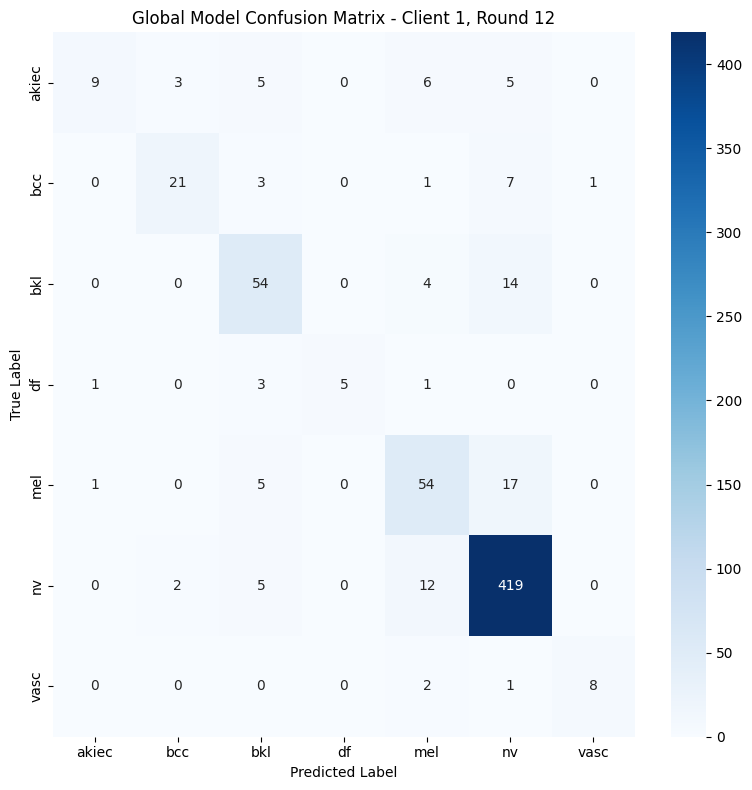


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.4329, Test Accuracy: 86.68%, F1-Score: 0.8556
Confusion Matrix:
 [[  4   3   6   0   6   3   0]
 [  1  32   2   0   0   3   0]
 [  0   2  40   0   5  11   0]
 [  2   1   0   3   1   2   0]
 [  0   2   4   0  40  21   1]
 [  1   1   2   0   8 451   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.18      0.27        22
           1       0.78      0.84      0.81        38
           2       0.74      0.69      0.71        58
           3       1.00      0.33      0.50         9
           4       0.66      0.59      0.62        68
           5       0.92      0.97      0.95       463
           6       0.90      0.90      0.90        10

    accuracy                           0.87       668
   macro avg       0.79      0.64      0.68       668
weighted avg       0.86      0.87      0.86       668

Sensitivity/Recall:
 [0.18181818 0.84210526 0.68965517 0.33333333 0.58823529 0.9740

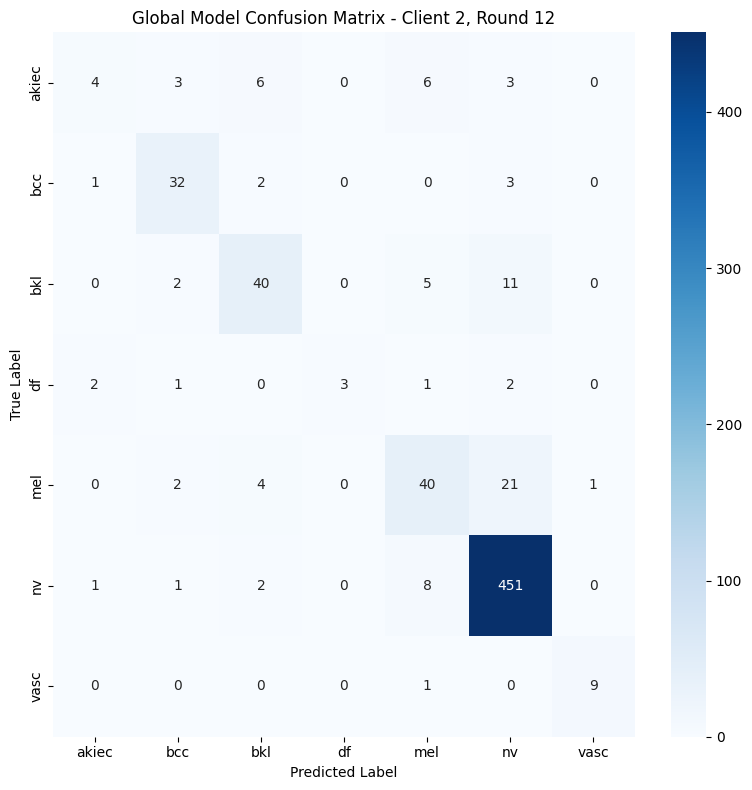


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]

Test Loss: 0.5331, Test Accuracy: 85.03%, F1-Score: 0.8405
Confusion Matrix:
 [[  7   2   3   0   4   2   0]
 [  2  33   1   0   2   1   1]
 [  0   4  58   0   5  15   0]
 [  0   0   1   2   0   2   0]
 [  0   1   1   0  36  36   0]
 [  0   3   5   0   8 418   0]
 [  0   0   0   0   0   1  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.39      0.52        18
           1       0.77      0.82      0.80        40
           2       0.84      0.71      0.77        82
           3       1.00      0.40      0.57         5
           4       0.65      0.49      0.56        74
           5       0.88      0.96      0.92       434
           6       0.93      0.93      0.93        15

    accuracy                           0.85       668
   macro avg       0.84      0.67      0.72       668
weighted avg       0.84      0.85      0.84       668

Sensitivity/Recall:
 [0.38888889 0.825      0.70731707 0.4        0.48648649 0.9631

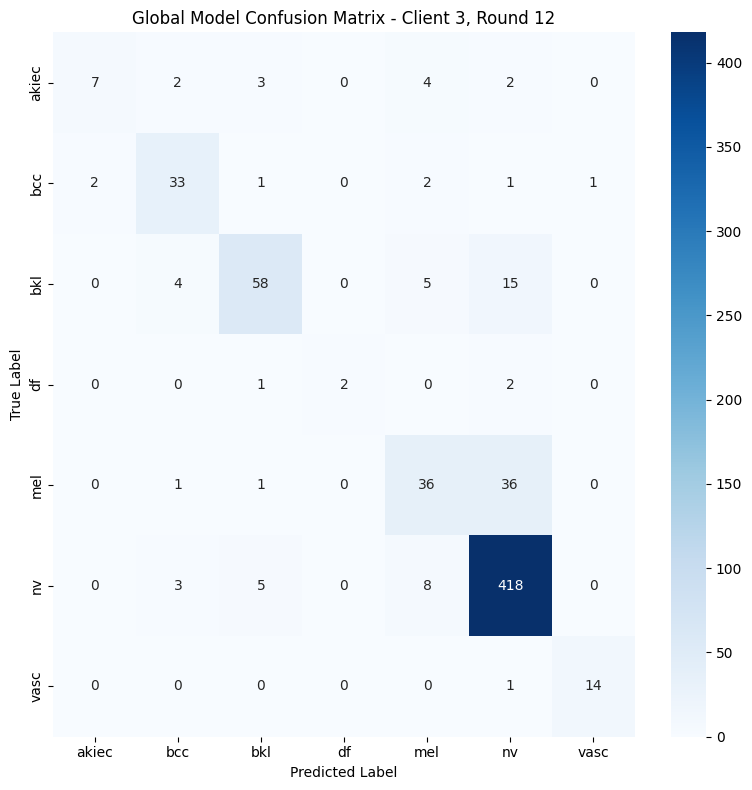


--- Round 13 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [04:27<00:00,  3.18s/it]


Client 1 Epoch 1: Train Loss: 0.2013, Train Accuracy: 96.93%


Client 1 Epoch 2: 100%|██████████| 84/84 [04:27<00:00,  3.19s/it]


Client 1 Epoch 2: Train Loss: 0.2043, Train Accuracy: 97.94%


Client 1 Epoch 3: 100%|██████████| 84/84 [04:27<00:00,  3.19s/it]


Client 1 Epoch 3: Train Loss: 0.2947, Train Accuracy: 96.82%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:26<00:00,  1.26s/it]


Test Loss: 0.6744, Test Accuracy: 77.58%, F1-Score: 0.7821
Confusion Matrix:
 [[ 11   2   5   0   7   2   1]
 [  3  19   4   0   0   6   1]
 [  2   0  53   0  10   7   0]
 [  2   0   3   4   1   0   0]
 [  1   0   5   0  55  16   0]
 [  0   6  28   0  33 371   0]
 [  0   1   0   0   3   1   6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.39      0.47        28
           1       0.68      0.58      0.62        33
           2       0.54      0.74      0.62        72
           3       1.00      0.40      0.57        10
           4       0.50      0.71      0.59        77
           5       0.92      0.85      0.88       438
           6       0.75      0.55      0.63        11

    accuracy                           0.78       669
   macro avg       0.71      0.60      0.63       669
weighted avg       0.80      0.78      0.78       669

Sensitivity/Recall:
 [0.39285714 0.57575758 0.73611111 0.4        0.71428571 0.8470

Client 2 Epoch 1: 100%|██████████| 84/84 [04:26<00:00,  3.17s/it]


Client 2 Epoch 1: Train Loss: 0.2195, Train Accuracy: 96.55%


Client 2 Epoch 2: 100%|██████████| 84/84 [04:25<00:00,  3.17s/it]


Client 2 Epoch 2: Train Loss: 0.2617, Train Accuracy: 97.41%


Client 2 Epoch 3: 100%|██████████| 84/84 [04:28<00:00,  3.20s/it]


Client 2 Epoch 3: Train Loss: 0.3199, Train Accuracy: 97.19%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


Test Loss: 0.6020, Test Accuracy: 84.73%, F1-Score: 0.8353
Confusion Matrix:
 [[ 11   2   3   0   4   2   0]
 [  0  31   3   0   1   3   0]
 [  2   3  36   0   1  16   0]
 [  1   1   0   6   1   0   0]
 [  0   2   3   0  26  36   1]
 [  0   1   5   0  10 447   0]
 [  0   0   0   0   0   1   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.50      0.61        22
           1       0.78      0.82      0.79        38
           2       0.72      0.62      0.67        58
           3       1.00      0.67      0.80         9
           4       0.60      0.38      0.47        68
           5       0.89      0.97      0.92       463
           6       0.90      0.90      0.90        10

    accuracy                           0.85       668
   macro avg       0.81      0.69      0.74       668
weighted avg       0.83      0.85      0.84       668

Sensitivity/Recall:
 [0.5        0.81578947 0.62068966 0.66666667 0.38235294 0.9654

Client 3 Epoch 1: 100%|██████████| 84/84 [07:01<00:00,  5.02s/it]


Client 3 Epoch 1: Train Loss: 0.2318, Train Accuracy: 96.22%


Client 3 Epoch 2: 100%|██████████| 84/84 [06:53<00:00,  4.93s/it]


Client 3 Epoch 2: Train Loss: 0.2723, Train Accuracy: 97.64%


Client 3 Epoch 3: 100%|██████████| 84/84 [06:53<00:00,  4.92s/it]


Client 3 Epoch 3: Train Loss: 0.2073, Train Accuracy: 98.58%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:25<00:00,  1.20s/it]


Test Loss: 0.7405, Test Accuracy: 84.13%, F1-Score: 0.8326
Confusion Matrix:
 [[ 15   0   0   0   3   0   0]
 [  2  28   1   2   0   5   2]
 [  4   3  49   0   3  22   1]
 [  0   0   0   3   0   2   0]
 [  1   0   2   0  38  33   0]
 [  2   4   7   0   6 415   0]
 [  0   0   0   0   0   1  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.83      0.71        18
           1       0.80      0.70      0.75        40
           2       0.83      0.60      0.70        82
           3       0.60      0.60      0.60         5
           4       0.76      0.51      0.61        74
           5       0.87      0.96      0.91       434
           6       0.82      0.93      0.88        15

    accuracy                           0.84       668
   macro avg       0.76      0.73      0.74       668
weighted avg       0.84      0.84      0.83       668

Sensitivity/Recall:
 [0.83333333 0.7        0.59756098 0.6        0.51351351 0.9562

Testing: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]

Test Loss: 0.5056, Test Accuracy: 86.10%, F1-Score: 0.8589
Confusion Matrix:
 [[ 14   2   3   1   6   2   0]
 [  1  21   6   0   0   4   1]
 [  0   0  57   0   3  12   0]
 [  1   0   3   6   0   0   0]
 [  0   0   2   0  60  15   0]
 [  0   6   8   0  13 410   1]
 [  0   0   0   0   2   1   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.50      0.64        28
           1       0.72      0.64      0.68        33
           2       0.72      0.79      0.75        72
           3       0.86      0.60      0.71        10
           4       0.71      0.78      0.75        77
           5       0.92      0.94      0.93       438
           6       0.80      0.73      0.76        11

    accuracy                           0.86       669
   macro avg       0.80      0.71      0.74       669
weighted avg       0.86      0.86      0.86       669

Sensitivity/Recall:
 [0.5        0.63636364 0.79166667 0.6        0.77922078 0.9360

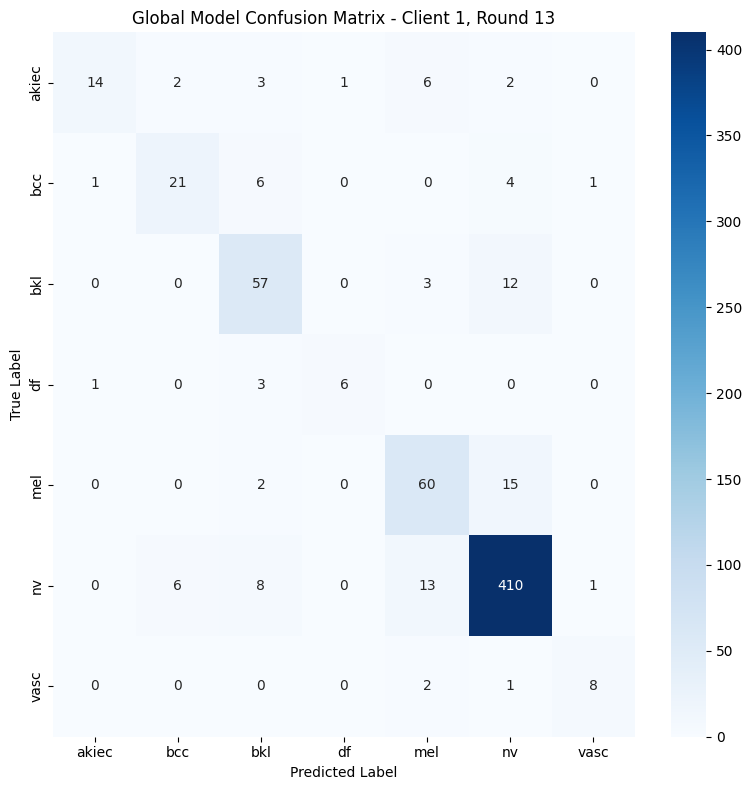


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.4203, Test Accuracy: 85.78%, F1-Score: 0.8544
Confusion Matrix:
 [[  6   1   7   0   6   2   0]
 [  2  30   4   0   1   1   0]
 [  0   1  44   0   5   8   0]
 [  3   0   0   4   1   1   0]
 [  0   2   5   0  42  19   0]
 [  0   1   8   0  16 438   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.27      0.36        22
           1       0.86      0.79      0.82        38
           2       0.65      0.76      0.70        58
           3       1.00      0.44      0.62         9
           4       0.58      0.62      0.60        68
           5       0.93      0.95      0.94       463
           6       1.00      0.90      0.95        10

    accuracy                           0.86       668
   macro avg       0.80      0.68      0.71       668
weighted avg       0.86      0.86      0.85       668

Sensitivity/Recall:
 [0.27272727 0.78947368 0.75862069 0.44444444 0.61764706 0.9460

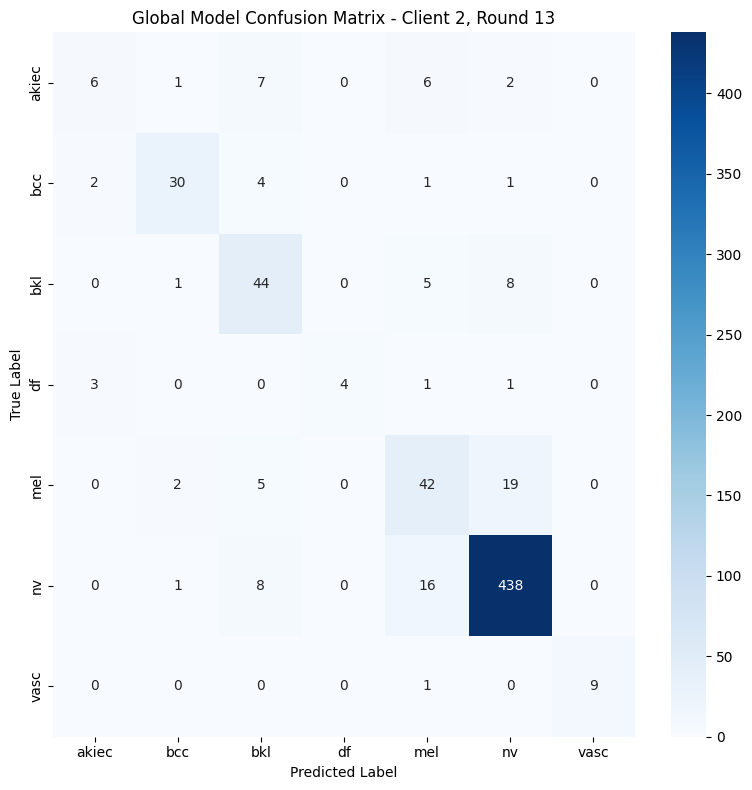


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.5445, Test Accuracy: 85.33%, F1-Score: 0.8497
Confusion Matrix:
 [[  9   1   4   0   4   0   0]
 [  2  33   0   0   2   2   1]
 [  0   4  60   0   7  11   0]
 [  0   0   0   3   0   2   0]
 [  0   0   2   0  43  29   0]
 [  0   4   7   0  14 408   1]
 [  0   0   0   0   0   1  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.50      0.62        18
           1       0.79      0.82      0.80        40
           2       0.82      0.73      0.77        82
           3       1.00      0.60      0.75         5
           4       0.61      0.58      0.60        74
           5       0.90      0.94      0.92       434
           6       0.88      0.93      0.90        15

    accuracy                           0.85       668
   macro avg       0.83      0.73      0.77       668
weighted avg       0.85      0.85      0.85       668

Sensitivity/Recall:
 [0.5        0.825      0.73170732 0.6        0.58108108 0.9400

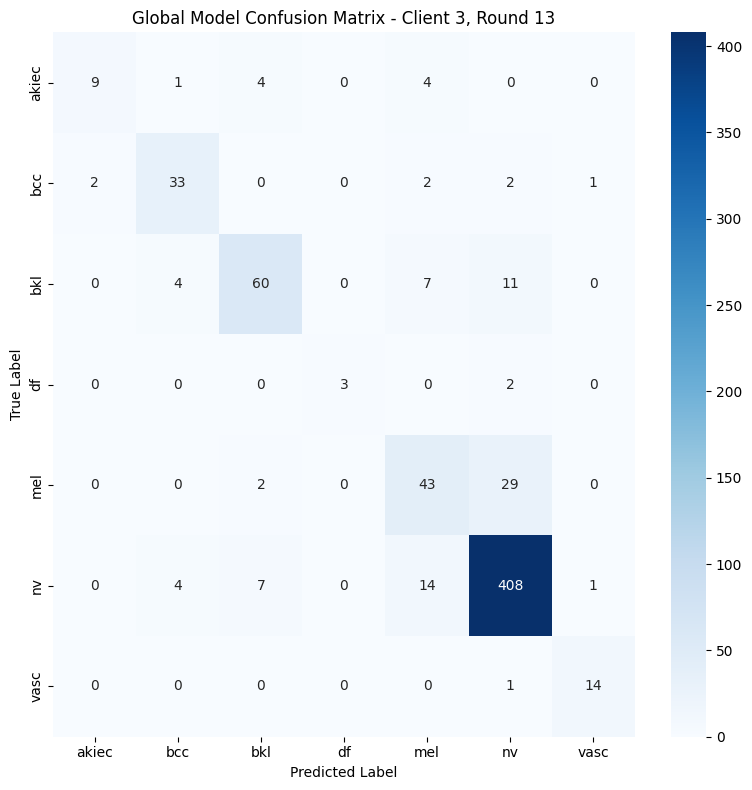


--- Round 14 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [04:36<00:00,  3.30s/it]


Client 1 Epoch 1: Train Loss: 0.2082, Train Accuracy: 97.34%


Client 1 Epoch 2: 100%|██████████| 84/84 [04:28<00:00,  3.19s/it]


Client 1 Epoch 2: Train Loss: 0.2484, Train Accuracy: 97.49%


Client 1 Epoch 3: 100%|██████████| 84/84 [04:29<00:00,  3.21s/it]


Client 1 Epoch 3: Train Loss: 0.2566, Train Accuracy: 97.94%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Test Loss: 0.7198, Test Accuracy: 82.21%, F1-Score: 0.8166
Confusion Matrix:
 [[ 11   3   4   0   6   3   1]
 [  0  18   4   0   1   9   1]
 [  2   0  45   0   8  17   0]
 [  0   0   2   8   0   0   0]
 [  3   0   3   0  52  19   0]
 [  0   2  14   1  12 409   0]
 [  0   0   0   0   1   3   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.39      0.50        28
           1       0.78      0.55      0.64        33
           2       0.62      0.62      0.62        72
           3       0.89      0.80      0.84        10
           4       0.65      0.68      0.66        77
           5       0.89      0.93      0.91       438
           6       0.78      0.64      0.70        11

    accuracy                           0.82       669
   macro avg       0.76      0.66      0.70       669
weighted avg       0.82      0.82      0.82       669

Sensitivity/Recall:
 [0.39285714 0.54545455 0.625      0.8        0.67532468 0.9337

Client 2 Epoch 1: 100%|██████████| 84/84 [04:31<00:00,  3.23s/it]


Client 2 Epoch 1: Train Loss: 0.2196, Train Accuracy: 96.59%


Client 2 Epoch 2: 100%|██████████| 84/84 [04:24<00:00,  3.15s/it]


Client 2 Epoch 2: Train Loss: 0.2091, Train Accuracy: 98.09%


Client 2 Epoch 3: 100%|██████████| 84/84 [04:24<00:00,  3.15s/it]


Client 2 Epoch 3: Train Loss: 0.3002, Train Accuracy: 97.08%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:14<00:00,  1.46it/s]


Test Loss: 0.5522, Test Accuracy: 85.63%, F1-Score: 0.8490
Confusion Matrix:
 [[  8   3   6   0   4   1   0]
 [  0  34   2   0   0   2   0]
 [  1   7  39   0   3   8   0]
 [  1   3   0   3   0   2   0]
 [  0   4   6   0  35  23   0]
 [  0   4   4   0  11 444   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.36      0.50        22
           1       0.62      0.89      0.73        38
           2       0.68      0.67      0.68        58
           3       1.00      0.33      0.50         9
           4       0.65      0.51      0.57        68
           5       0.93      0.96      0.94       463
           6       1.00      0.90      0.95        10

    accuracy                           0.86       668
   macro avg       0.81      0.66      0.70       668
weighted avg       0.86      0.86      0.85       668

Sensitivity/Recall:
 [0.36363636 0.89473684 0.67241379 0.33333333 0.51470588 0.9589

Client 3 Epoch 1: 100%|██████████| 84/84 [06:15<00:00,  4.47s/it]


Client 3 Epoch 1: Train Loss: 0.2130, Train Accuracy: 96.63%


Client 3 Epoch 2: 100%|██████████| 84/84 [06:16<00:00,  4.48s/it]


Client 3 Epoch 2: Train Loss: 0.2443, Train Accuracy: 97.60%


Client 3 Epoch 3: 100%|██████████| 84/84 [06:16<00:00,  4.48s/it]


Client 3 Epoch 3: Train Loss: 0.2320, Train Accuracy: 97.90%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:39<00:00,  1.90s/it]


Test Loss: 0.5994, Test Accuracy: 80.54%, F1-Score: 0.8040
Confusion Matrix:
 [[  8   0   8   0   1   1   0]
 [  6  28   3   0   3   0   0]
 [  2   3  65   0   1  11   0]
 [  0   0   1   2   0   2   0]
 [  3   0   7   0  35  29   0]
 [  1   3  24   0  16 390   0]
 [  0   0   0   1   1   3  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.44      0.42        18
           1       0.82      0.70      0.76        40
           2       0.60      0.79      0.68        82
           3       0.67      0.40      0.50         5
           4       0.61      0.47      0.53        74
           5       0.89      0.90      0.90       434
           6       1.00      0.67      0.80        15

    accuracy                           0.81       668
   macro avg       0.71      0.63      0.66       668
weighted avg       0.81      0.81      0.80       668

Sensitivity/Recall:
 [0.44444444 0.7        0.79268293 0.4        0.47297297 0.8986

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.60it/s]

Test Loss: 0.5248, Test Accuracy: 85.80%, F1-Score: 0.8534
Confusion Matrix:
 [[ 10   2   8   0   5   3   0]
 [  0  22   5   0   0   6   0]
 [  0   0  55   0   7  10   0]
 [  1   0   3   6   0   0   0]
 [  1   0   1   0  59  16   0]
 [  0   3   8   0  12 415   0]
 [  0   0   0   0   2   2   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.36      0.50        28
           1       0.81      0.67      0.73        33
           2       0.69      0.76      0.72        72
           3       1.00      0.60      0.75        10
           4       0.69      0.77      0.73        77
           5       0.92      0.95      0.93       438
           6       1.00      0.64      0.78        11

    accuracy                           0.86       669
   macro avg       0.85      0.68      0.74       669
weighted avg       0.86      0.86      0.85       669

Sensitivity/Recall:
 [0.35714286 0.66666667 0.76388889 0.6        0.76623377 0.9474

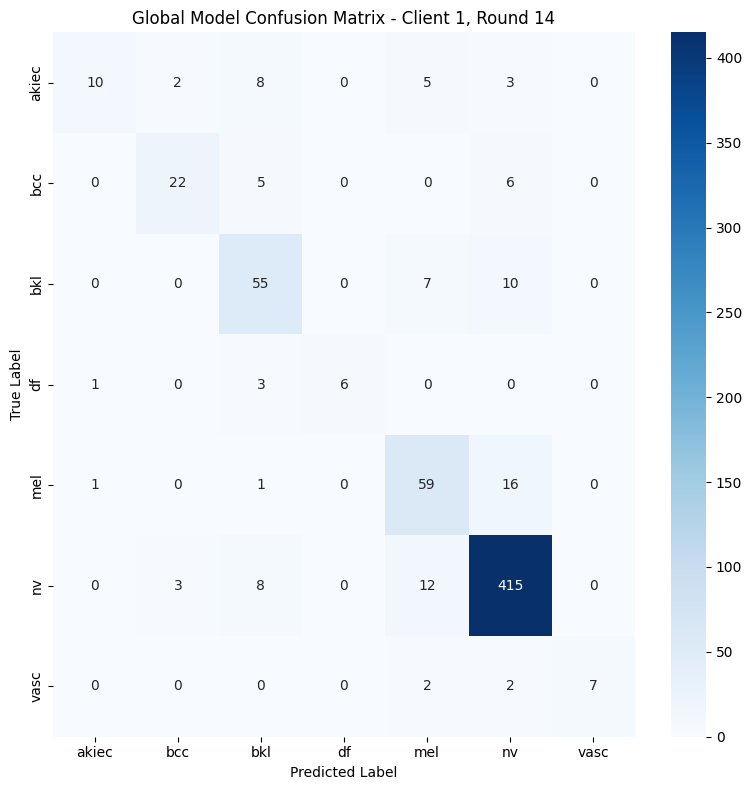


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.4350, Test Accuracy: 86.23%, F1-Score: 0.8527
Confusion Matrix:
 [[  5   1   7   0   5   4   0]
 [  0  31   4   0   0   3   0]
 [  1   2  42   0   5   8   0]
 [  3   0   0   3   1   2   0]
 [  0   2   4   0  38  24   0]
 [  1   1   6   0   7 448   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.23      0.31        22
           1       0.84      0.82      0.83        38
           2       0.67      0.72      0.69        58
           3       1.00      0.33      0.50         9
           4       0.67      0.56      0.61        68
           5       0.92      0.97      0.94       463
           6       1.00      0.90      0.95        10

    accuracy                           0.86       668
   macro avg       0.80      0.65      0.69       668
weighted avg       0.85      0.86      0.85       668

Sensitivity/Recall:
 [0.22727273 0.81578947 0.72413793 0.33333333 0.55882353 0.9676

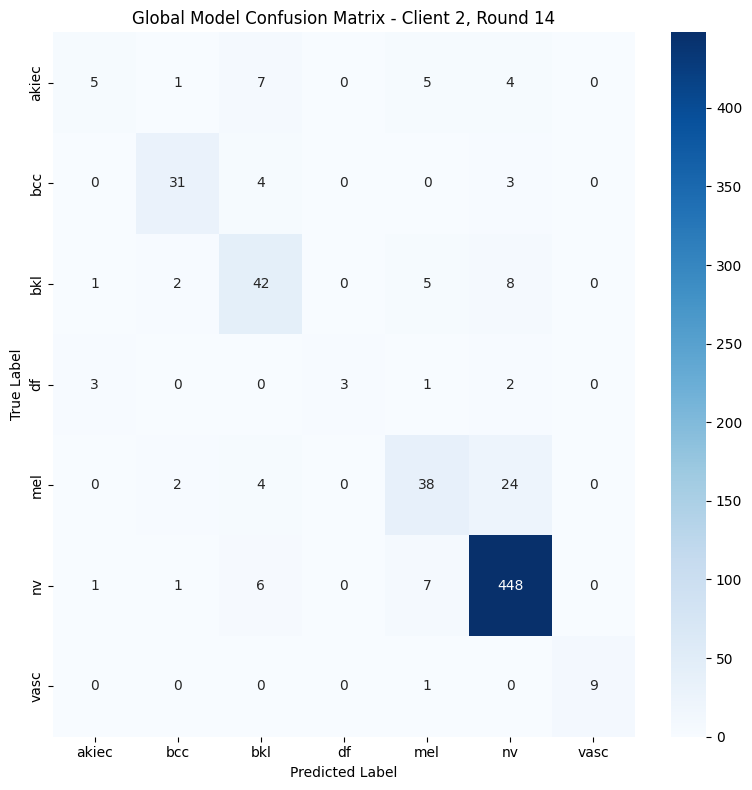


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.5230, Test Accuracy: 85.93%, F1-Score: 0.8546
Confusion Matrix:
 [[ 10   1   3   0   3   1   0]
 [  3  33   1   0   3   0   0]
 [  0   5  56   0   8  13   0]
 [  0   0   1   2   1   1   0]
 [  0   0   1   0  44  29   0]
 [  0   3   6   0  10 415   0]
 [  0   0   0   0   0   1  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.56      0.65        18
           1       0.79      0.82      0.80        40
           2       0.82      0.68      0.75        82
           3       1.00      0.40      0.57         5
           4       0.64      0.59      0.62        74
           5       0.90      0.96      0.93       434
           6       1.00      0.93      0.97        15

    accuracy                           0.86       668
   macro avg       0.85      0.71      0.75       668
weighted avg       0.86      0.86      0.85       668

Sensitivity/Recall:
 [0.55555556 0.825      0.68292683 0.4        0.59459459 0.9562

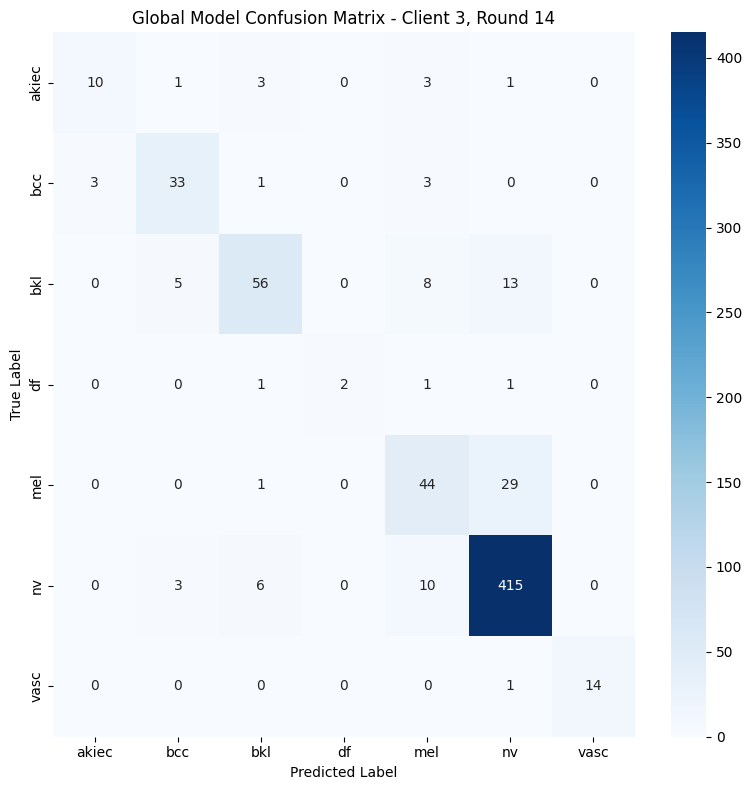


--- Round 15 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [04:45<00:00,  3.40s/it]


Client 1 Epoch 1: Train Loss: 0.1856, Train Accuracy: 97.38%


Client 1 Epoch 2: 100%|██████████| 84/84 [04:45<00:00,  3.40s/it]


Client 1 Epoch 2: Train Loss: 0.2273, Train Accuracy: 97.90%


Client 1 Epoch 3: 100%|██████████| 84/84 [04:45<00:00,  3.40s/it]


Client 1 Epoch 3: Train Loss: 0.3073, Train Accuracy: 97.34%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:40<00:00,  1.91s/it]


Test Loss: 0.6469, Test Accuracy: 82.51%, F1-Score: 0.8214
Confusion Matrix:
 [[ 12   9   1   0   3   3   0]
 [  0  26   1   0   0   5   1]
 [  3   2  50   0   6  11   0]
 [  1   1   2   5   1   0   0]
 [  1   1   3   0  43  27   2]
 [  0  12   8   1  10 405   2]
 [  0   0   0   0   0   0  11]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.43      0.53        28
           1       0.51      0.79      0.62        33
           2       0.77      0.69      0.73        72
           3       0.83      0.50      0.62        10
           4       0.68      0.56      0.61        77
           5       0.90      0.92      0.91       438
           6       0.69      1.00      0.81        11

    accuracy                           0.83       669
   macro avg       0.73      0.70      0.69       669
weighted avg       0.83      0.83      0.82       669

Sensitivity/Recall:
 [0.42857143 0.78787879 0.69444444 0.5        0.55844156 0.9246

Client 2 Epoch 1: 100%|██████████| 84/84 [05:19<00:00,  3.80s/it]


Client 2 Epoch 1: Train Loss: 0.2103, Train Accuracy: 97.00%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:19<00:00,  3.80s/it]


Client 2 Epoch 2: Train Loss: 0.2466, Train Accuracy: 97.71%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:19<00:00,  3.80s/it]


Client 2 Epoch 3: Train Loss: 0.2769, Train Accuracy: 97.34%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Test Loss: 0.4675, Test Accuracy: 84.43%, F1-Score: 0.8438
Confusion Matrix:
 [[  7   1   5   0   7   2   0]
 [  4  29   2   0   2   1   0]
 [  2   2  40   1   6   7   0]
 [  3   0   0   4   1   1   0]
 [  2   1   4   0  42  19   0]
 [  1   3   5   0  19 435   0]
 [  0   0   0   0   1   2   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.32      0.34        22
           1       0.81      0.76      0.78        38
           2       0.71      0.69      0.70        58
           3       0.80      0.44      0.57         9
           4       0.54      0.62      0.58        68
           5       0.93      0.94      0.94       463
           6       1.00      0.70      0.82        10

    accuracy                           0.84       668
   macro avg       0.74      0.64      0.68       668
weighted avg       0.85      0.84      0.84       668

Sensitivity/Recall:
 [0.31818182 0.76315789 0.68965517 0.44444444 0.61764706 0.9395

Client 3 Epoch 1: 100%|██████████| 84/84 [05:13<00:00,  3.73s/it]


Client 3 Epoch 1: Train Loss: 0.2079, Train Accuracy: 97.08%


Client 3 Epoch 2: 100%|██████████| 84/84 [05:13<00:00,  3.73s/it]


Client 3 Epoch 2: Train Loss: 0.2840, Train Accuracy: 97.12%


Client 3 Epoch 3: 100%|██████████| 84/84 [05:13<00:00,  3.74s/it]


Client 3 Epoch 3: Train Loss: 0.2664, Train Accuracy: 97.83%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.55it/s]


Test Loss: 0.6562, Test Accuracy: 83.83%, F1-Score: 0.8339
Confusion Matrix:
 [[  7   5   3   0   3   0   0]
 [  1  35   1   0   0   1   2]
 [  0   6  52   0   8  16   0]
 [  0   0   0   3   0   2   0]
 [  0   2   1   0  44  27   0]
 [  1   8   5   0  15 404   1]
 [  0   0   0   0   0   0  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.39      0.52        18
           1       0.62      0.88      0.73        40
           2       0.84      0.63      0.72        82
           3       1.00      0.60      0.75         5
           4       0.63      0.59      0.61        74
           5       0.90      0.93      0.91       434
           6       0.83      1.00      0.91        15

    accuracy                           0.84       668
   macro avg       0.80      0.72      0.74       668
weighted avg       0.84      0.84      0.83       668

Sensitivity/Recall:
 [0.38888889 0.875      0.63414634 0.6        0.59459459 0.9308

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.60it/s]

Test Loss: 0.4631, Test Accuracy: 86.40%, F1-Score: 0.8609
Confusion Matrix:
 [[ 13   3   5   0   5   2   0]
 [  0  25   2   0   0   5   1]
 [  0   0  54   0   5  13   0]
 [  1   0   2   7   0   0   0]
 [  1   0   2   0  56  17   1]
 [  0   4   7   2  13 412   0]
 [  0   0   0   0   0   0  11]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.46      0.60        28
           1       0.78      0.76      0.77        33
           2       0.75      0.75      0.75        72
           3       0.78      0.70      0.74        10
           4       0.71      0.73      0.72        77
           5       0.92      0.94      0.93       438
           6       0.85      1.00      0.92        11

    accuracy                           0.86       669
   macro avg       0.81      0.76      0.77       669
weighted avg       0.86      0.86      0.86       669

Sensitivity/Recall:
 [0.46428571 0.75757576 0.75       0.7        0.72727273 0.9406

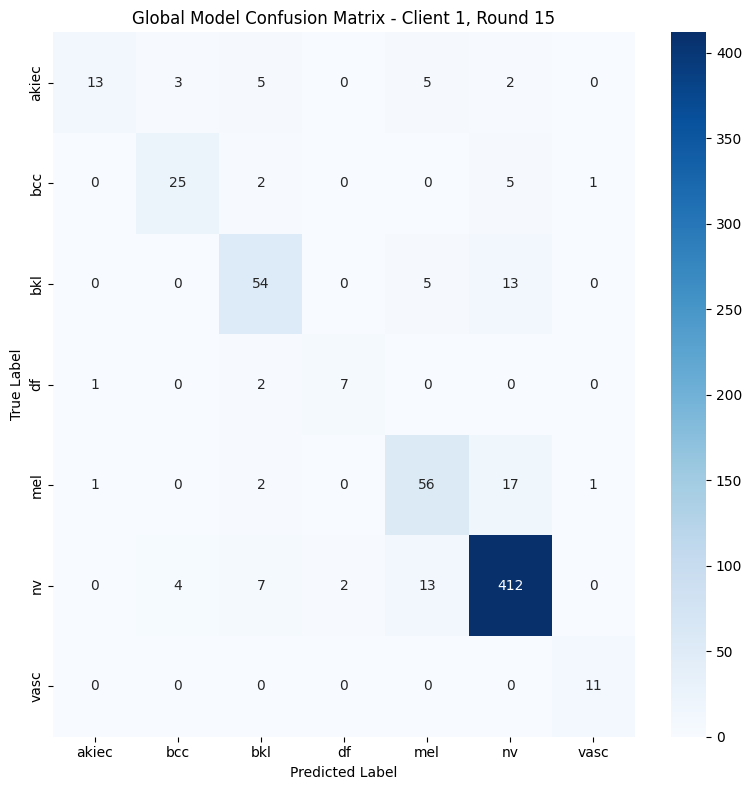


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]

Test Loss: 0.4393, Test Accuracy: 87.57%, F1-Score: 0.8718
Confusion Matrix:
 [[  9   2   5   0   5   1   0]
 [  1  32   1   0   1   3   0]
 [  0   4  42   1   5   6   0]
 [  1   2   0   4   2   0   0]
 [  0   2   5   0  43  17   1]
 [  1   1   6   0  10 445   0]
 [  0   0   0   0   0   0  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.41      0.53        22
           1       0.74      0.84      0.79        38
           2       0.71      0.72      0.72        58
           3       0.80      0.44      0.57         9
           4       0.65      0.63      0.64        68
           5       0.94      0.96      0.95       463
           6       0.91      1.00      0.95        10

    accuracy                           0.88       668
   macro avg       0.79      0.72      0.74       668
weighted avg       0.87      0.88      0.87       668

Sensitivity/Recall:
 [0.40909091 0.84210526 0.72413793 0.44444444 0.63235294 0.9611

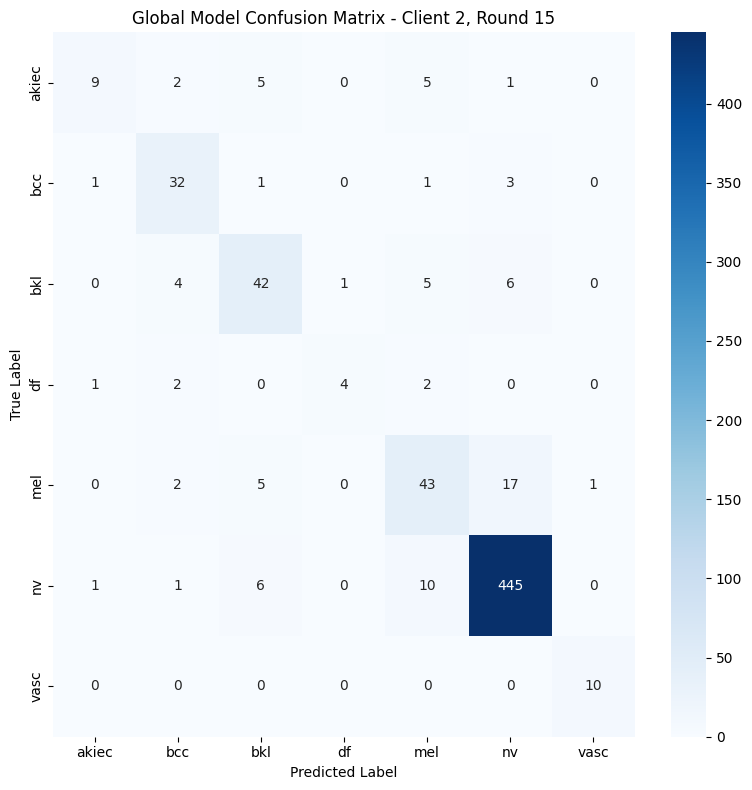


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]

Test Loss: 0.5030, Test Accuracy: 85.93%, F1-Score: 0.8542
Confusion Matrix:
 [[  9   2   2   0   3   2   0]
 [  2  35   1   0   0   0   2]
 [  1   4  55   0   7  15   0]
 [  0   0   0   3   0   2   0]
 [  0   0   3   0  44  27   0]
 [  0   5   2   0  13 413   1]
 [  0   0   0   0   0   0  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.50      0.60        18
           1       0.76      0.88      0.81        40
           2       0.87      0.67      0.76        82
           3       1.00      0.60      0.75         5
           4       0.66      0.59      0.62        74
           5       0.90      0.95      0.92       434
           6       0.83      1.00      0.91        15

    accuracy                           0.86       668
   macro avg       0.82      0.74      0.77       668
weighted avg       0.86      0.86      0.85       668

Sensitivity/Recall:
 [0.5        0.875      0.67073171 0.6        0.59459459 0.9516

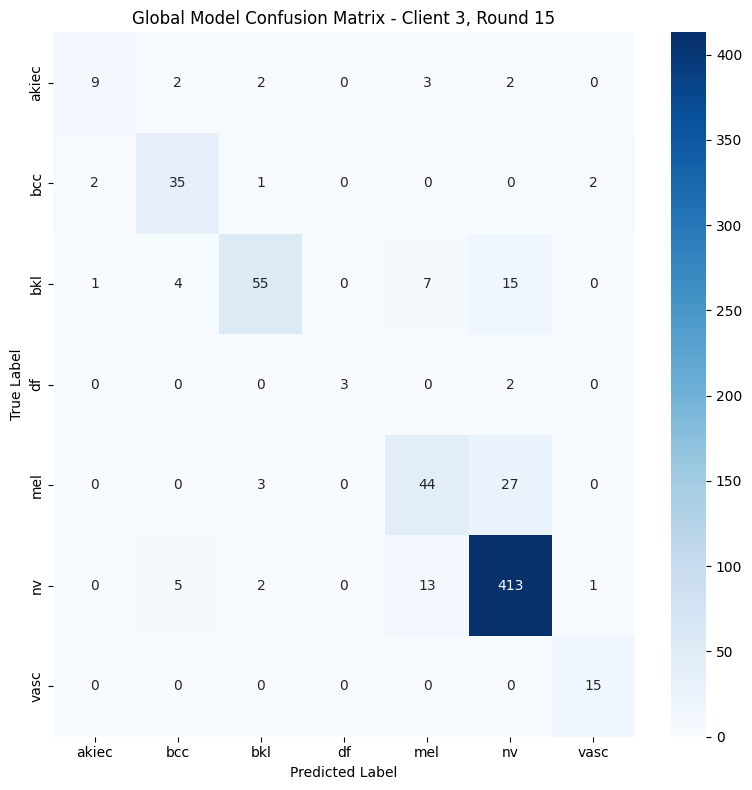


--- Round 16 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [04:42<00:00,  3.36s/it]


Client 1 Epoch 1: Train Loss: 0.2094, Train Accuracy: 96.93%


Client 1 Epoch 2: 100%|██████████| 84/84 [04:42<00:00,  3.37s/it]


Client 1 Epoch 2: Train Loss: 0.2758, Train Accuracy: 97.49%


Client 1 Epoch 3: 100%|██████████| 84/84 [04:42<00:00,  3.37s/it]


Client 1 Epoch 3: Train Loss: 0.2368, Train Accuracy: 98.32%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:33<00:00,  1.61s/it]


Test Loss: 0.7244, Test Accuracy: 81.17%, F1-Score: 0.8021
Confusion Matrix:
 [[  6   2   4   1   8   6   1]
 [  1  17   0   0   6   8   1]
 [  1   0  47   0   7  17   0]
 [  0   0   2   8   0   0   0]
 [  0   0   4   0  45  28   0]
 [  1   0   5   0  20 412   0]
 [  0   0   0   0   2   1   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.21      0.32        28
           1       0.89      0.52      0.65        33
           2       0.76      0.65      0.70        72
           3       0.89      0.80      0.84        10
           4       0.51      0.58      0.55        77
           5       0.87      0.94      0.91       438
           6       0.80      0.73      0.76        11

    accuracy                           0.81       669
   macro avg       0.77      0.63      0.68       669
weighted avg       0.81      0.81      0.80       669

Sensitivity/Recall:
 [0.21428571 0.51515152 0.65277778 0.8        0.58441558 0.9406

Client 2 Epoch 1: 100%|██████████| 84/84 [05:21<00:00,  3.83s/it]


Client 2 Epoch 1: Train Loss: 0.2115, Train Accuracy: 97.23%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:21<00:00,  3.83s/it]


Client 2 Epoch 2: Train Loss: 0.2270, Train Accuracy: 98.50%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:21<00:00,  3.83s/it]


Client 2 Epoch 3: Train Loss: 0.2440, Train Accuracy: 98.01%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


Test Loss: 0.6801, Test Accuracy: 84.88%, F1-Score: 0.8394
Confusion Matrix:
 [[  9   1   2   0   6   4   0]
 [  3  27   0   0   1   7   0]
 [  5   0  29   0   9  15   0]
 [  2   0   0   2   1   4   0]
 [  0   1   1   0  42  24   0]
 [  0   2   0   0  13 448   0]
 [  0   0   0   0   0   0  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.41      0.44        22
           1       0.87      0.71      0.78        38
           2       0.91      0.50      0.64        58
           3       1.00      0.22      0.36         9
           4       0.58      0.62      0.60        68
           5       0.89      0.97      0.93       463
           6       1.00      1.00      1.00        10

    accuracy                           0.85       668
   macro avg       0.82      0.63      0.68       668
weighted avg       0.85      0.85      0.84       668

Sensitivity/Recall:
 [0.40909091 0.71052632 0.5        0.22222222 0.61764706 0.9676

Client 3 Epoch 1: 100%|██████████| 84/84 [05:40<00:00,  4.05s/it]


Client 3 Epoch 1: Train Loss: 0.1852, Train Accuracy: 97.98%


Client 3 Epoch 2: 100%|██████████| 84/84 [05:39<00:00,  4.04s/it]


Client 3 Epoch 2: Train Loss: 0.2368, Train Accuracy: 97.53%


Client 3 Epoch 3: 100%|██████████| 84/84 [05:40<00:00,  4.05s/it]


Client 3 Epoch 3: Train Loss: 0.3552, Train Accuracy: 96.59%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:27<00:00,  1.29s/it]


Test Loss: 0.6532, Test Accuracy: 81.59%, F1-Score: 0.8169
Confusion Matrix:
 [[ 11   1   3   0   3   0   0]
 [  6  28   2   0   1   1   2]
 [  2   4  50   0  12  14   0]
 [  0   0   0   3   0   2   0]
 [  1   1   0   0  45  27   0]
 [  0   6   6   0  28 394   0]
 [  0   0   0   1   0   0  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.61      0.58        18
           1       0.70      0.70      0.70        40
           2       0.82      0.61      0.70        82
           3       0.75      0.60      0.67         5
           4       0.51      0.61      0.55        74
           5       0.90      0.91      0.90       434
           6       0.88      0.93      0.90        15

    accuracy                           0.82       668
   macro avg       0.73      0.71      0.71       668
weighted avg       0.82      0.82      0.82       668

Sensitivity/Recall:
 [0.61111111 0.7        0.6097561  0.6        0.60810811 0.9078

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.59it/s]

Test Loss: 0.5139, Test Accuracy: 87.00%, F1-Score: 0.8664
Confusion Matrix:
 [[ 15   0   3   1   6   3   0]
 [  0  19   3   0   3   7   1]
 [  1   0  53   0   5  13   0]
 [  0   0   2   8   0   0   0]
 [  1   0   2   0  57  17   0]
 [  0   0   3   1  15 419   0]
 [  0   0   0   0   0   0  11]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.54      0.67        28
           1       1.00      0.58      0.73        33
           2       0.80      0.74      0.77        72
           3       0.80      0.80      0.80        10
           4       0.66      0.74      0.70        77
           5       0.91      0.96      0.93       438
           6       0.92      1.00      0.96        11

    accuracy                           0.87       669
   macro avg       0.85      0.76      0.79       669
weighted avg       0.87      0.87      0.87       669

Sensitivity/Recall:
 [0.53571429 0.57575758 0.73611111 0.8        0.74025974 0.9566

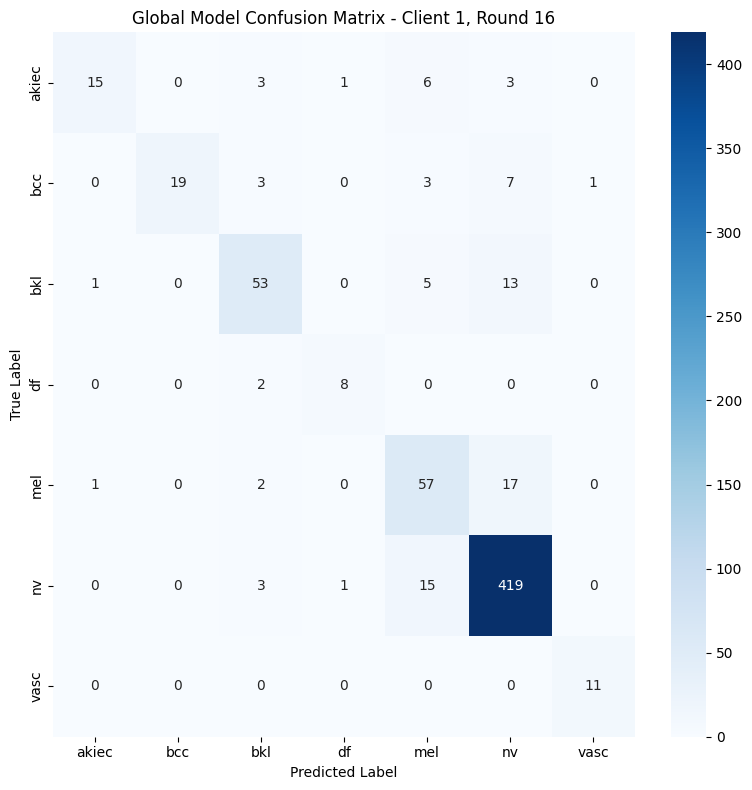


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.4743, Test Accuracy: 86.38%, F1-Score: 0.8575
Confusion Matrix:
 [[  7   1   5   0   5   4   0]
 [  2  26   3   0   4   3   0]
 [  1   0  40   2   6   9   0]
 [  1   0   0   6   1   1   0]
 [  0   0   5   0  40  23   0]
 [  0   1   4   0  10 448   0]
 [  0   0   0   0   0   0  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.32      0.42        22
           1       0.93      0.68      0.79        38
           2       0.70      0.69      0.70        58
           3       0.75      0.67      0.71         9
           4       0.61      0.59      0.60        68
           5       0.92      0.97      0.94       463
           6       1.00      1.00      1.00        10

    accuracy                           0.86       668
   macro avg       0.79      0.70      0.74       668
weighted avg       0.86      0.86      0.86       668

Sensitivity/Recall:
 [0.31818182 0.68421053 0.68965517 0.66666667 0.58823529 0.9676

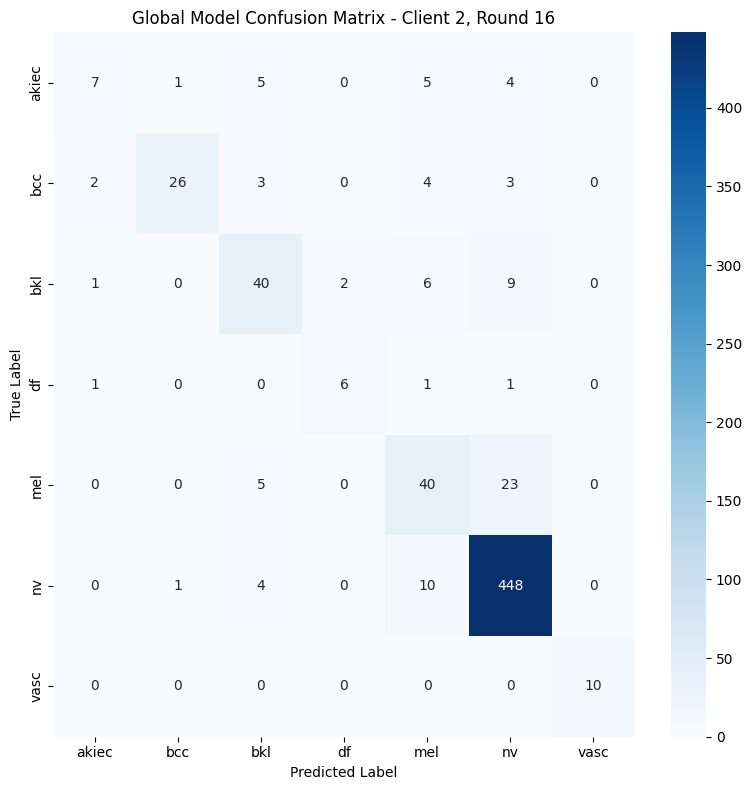


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]

Test Loss: 0.5744, Test Accuracy: 85.63%, F1-Score: 0.8502
Confusion Matrix:
 [[  7   1   3   0   6   1   0]
 [  4  31   0   0   3   1   1]
 [  0   3  58   0   5  16   0]
 [  0   0   0   3   0   2   0]
 [  0   1   0   0  42  31   0]
 [  0   3   4   0  11 416   0]
 [  0   0   0   0   0   0  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.39      0.48        18
           1       0.79      0.78      0.78        40
           2       0.89      0.71      0.79        82
           3       1.00      0.60      0.75         5
           4       0.63      0.57      0.60        74
           5       0.89      0.96      0.92       434
           6       0.94      1.00      0.97        15

    accuracy                           0.86       668
   macro avg       0.83      0.71      0.76       668
weighted avg       0.85      0.86      0.85       668

Sensitivity/Recall:
 [0.38888889 0.775      0.70731707 0.6        0.56756757 0.9585

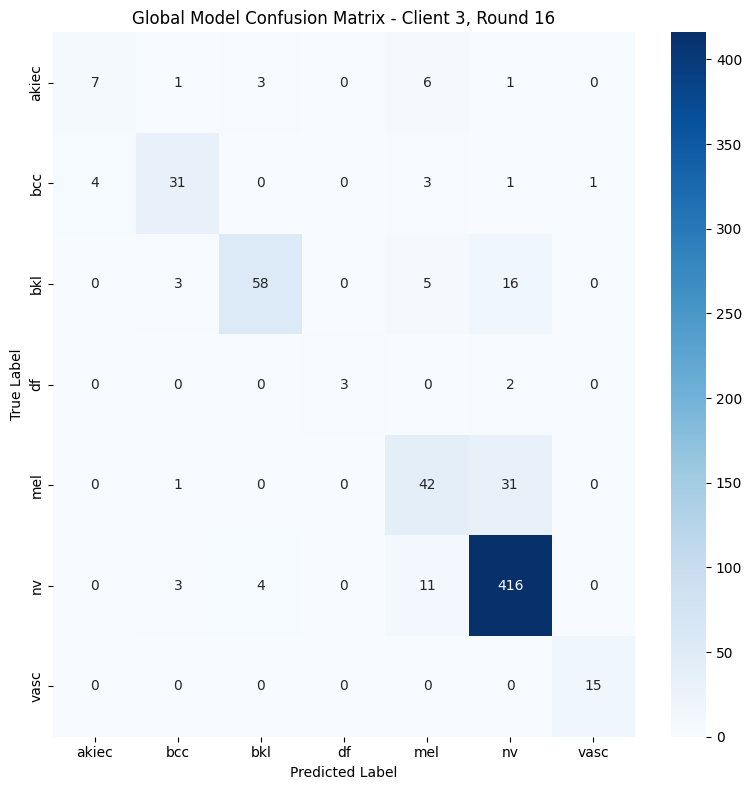


--- Round 17 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [04:58<00:00,  3.56s/it]


Client 1 Epoch 1: Train Loss: 0.2047, Train Accuracy: 97.19%


Client 1 Epoch 2: 100%|██████████| 84/84 [04:59<00:00,  3.56s/it]


Client 1 Epoch 2: Train Loss: 0.2165, Train Accuracy: 98.17%


Client 1 Epoch 3: 100%|██████████| 84/84 [04:59<00:00,  3.56s/it]


Client 1 Epoch 3: Train Loss: 0.2382, Train Accuracy: 97.94%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:26<00:00,  1.26s/it]


Test Loss: 0.7112, Test Accuracy: 80.42%, F1-Score: 0.7965
Confusion Matrix:
 [[  2   6   9   3   5   3   0]
 [  0  23   6   0   0   4   0]
 [  0   0  56   0   4  12   0]
 [  0   0   2   8   0   0   0]
 [  0   0   9   0  53  15   0]
 [  0   6  18   2  22 390   0]
 [  0   0   0   0   3   2   6]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.07      0.13        28
           1       0.66      0.70      0.68        33
           2       0.56      0.78      0.65        72
           3       0.62      0.80      0.70        10
           4       0.61      0.69      0.65        77
           5       0.92      0.89      0.90       438
           6       1.00      0.55      0.71        11

    accuracy                           0.80       669
   macro avg       0.77      0.64      0.63       669
weighted avg       0.83      0.80      0.80       669

Sensitivity/Recall:
 [0.07142857 0.6969697  0.77777778 0.8        0.68831169 0.8904

Client 2 Epoch 1: 100%|██████████| 84/84 [04:28<00:00,  3.20s/it]


Client 2 Epoch 1: Train Loss: 0.1752, Train Accuracy: 97.60%


Client 2 Epoch 2: 100%|██████████| 84/84 [04:28<00:00,  3.19s/it]


Client 2 Epoch 2: Train Loss: 0.2501, Train Accuracy: 97.60%


Client 2 Epoch 3: 100%|██████████| 84/84 [04:27<00:00,  3.19s/it]


Client 2 Epoch 3: Train Loss: 0.3323, Train Accuracy: 97.38%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:31<00:00,  1.52s/it]


Test Loss: 0.5742, Test Accuracy: 85.18%, F1-Score: 0.8473
Confusion Matrix:
 [[  8   0   4   0   8   2   0]
 [  2  25   3   0   3   5   0]
 [  2   2  35   0   8  11   0]
 [  3   0   1   4   0   1   0]
 [  0   0   3   0  43  22   0]
 [  0   0   3   0  16 444   0]
 [  0   0   0   0   0   0  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.36      0.43        22
           1       0.93      0.66      0.77        38
           2       0.71      0.60      0.65        58
           3       1.00      0.44      0.62         9
           4       0.55      0.63      0.59        68
           5       0.92      0.96      0.94       463
           6       1.00      1.00      1.00        10

    accuracy                           0.85       668
   macro avg       0.81      0.67      0.71       668
weighted avg       0.85      0.85      0.85       668

Sensitivity/Recall:
 [0.36363636 0.65789474 0.60344828 0.44444444 0.63235294 0.9589

Client 3 Epoch 1: 100%|██████████| 84/84 [05:55<00:00,  4.24s/it]


Client 3 Epoch 1: Train Loss: 0.1897, Train Accuracy: 97.41%


Client 3 Epoch 2: 100%|██████████| 84/84 [05:56<00:00,  4.24s/it]


Client 3 Epoch 2: Train Loss: 0.2767, Train Accuracy: 97.12%


Client 3 Epoch 3: 100%|██████████| 84/84 [05:56<00:00,  4.24s/it]


Client 3 Epoch 3: Train Loss: 0.2915, Train Accuracy: 97.53%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:19<00:00,  1.06it/s]


Test Loss: 0.6705, Test Accuracy: 84.43%, F1-Score: 0.8375
Confusion Matrix:
 [[ 14   1   2   0   1   0   0]
 [  2  35   0   0   1   1   1]
 [  4   4  58   0   3  13   0]
 [  0   0   0   3   0   2   0]
 [  2   0   4   0  34  33   1]
 [  1   6  10   0   9 407   1]
 [  0   0   0   1   0   1  13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.78      0.68        18
           1       0.76      0.88      0.81        40
           2       0.78      0.71      0.74        82
           3       0.75      0.60      0.67         5
           4       0.71      0.46      0.56        74
           5       0.89      0.94      0.91       434
           6       0.81      0.87      0.84        15

    accuracy                           0.84       668
   macro avg       0.76      0.75      0.75       668
weighted avg       0.84      0.84      0.84       668

Sensitivity/Recall:
 [0.77777778 0.875      0.70731707 0.6        0.45945946 0.9377

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]


Test Loss: 0.5411, Test Accuracy: 85.65%, F1-Score: 0.8529
Confusion Matrix:
 [[ 12   1   3   2   6   4   0]
 [  0  22   3   0   2   5   1]
 [  1   0  56   0   1  14   0]
 [  0   0   3   7   0   0   0]
 [  0   0   5   0  55  17   0]
 [  0   4  10   2  11 411   0]
 [  0   0   0   0   0   1  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.43      0.59        28
           1       0.81      0.67      0.73        33
           2       0.70      0.78      0.74        72
           3       0.64      0.70      0.67        10
           4       0.73      0.71      0.72        77
           5       0.91      0.94      0.92       438
           6       0.91      0.91      0.91        11

    accuracy                           0.86       669
   macro avg       0.80      0.73      0.75       669
weighted avg       0.86      0.86      0.85       669

Sensitivity/Recall:
 [0.42857143 0.66666667 0.77777778 0.7        0.71428571 0.9383

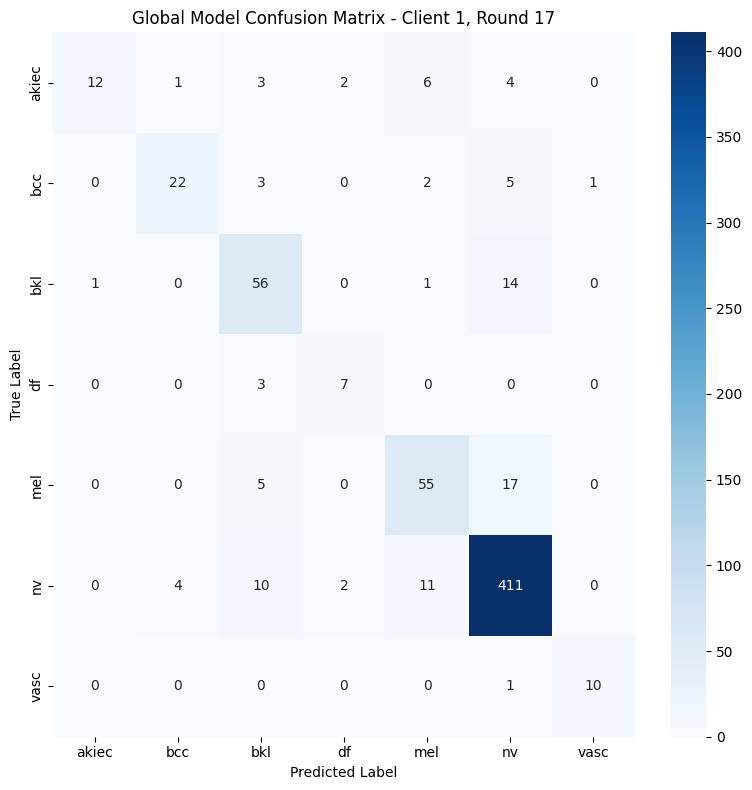


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]

Test Loss: 0.4254, Test Accuracy: 87.57%, F1-Score: 0.8710
Confusion Matrix:
 [[  8   2   5   0   4   3   0]
 [  1  31   3   0   1   2   0]
 [  0   1  47   0   2   8   0]
 [  1   0   0   7   0   1   0]
 [  0   1   6   0  40  21   0]
 [  0   2   6   0  13 442   0]
 [  0   0   0   0   0   0  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.36      0.50        22
           1       0.84      0.82      0.83        38
           2       0.70      0.81      0.75        58
           3       1.00      0.78      0.88         9
           4       0.67      0.59      0.62        68
           5       0.93      0.95      0.94       463
           6       1.00      1.00      1.00        10

    accuracy                           0.88       668
   macro avg       0.85      0.76      0.79       668
weighted avg       0.87      0.88      0.87       668

Sensitivity/Recall:
 [0.36363636 0.81578947 0.81034483 0.77777778 0.58823529 0.9546

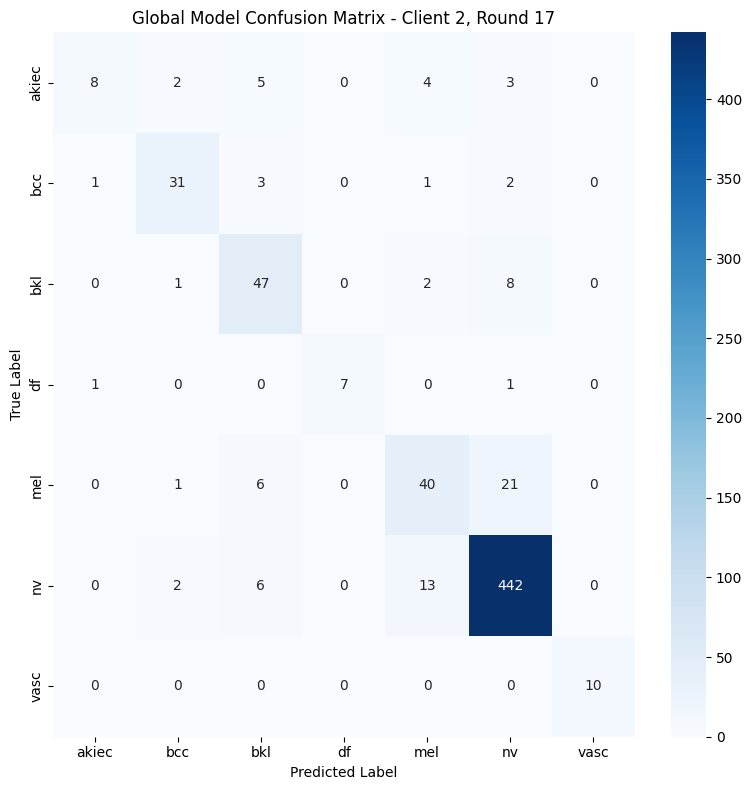


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]

Test Loss: 0.5457, Test Accuracy: 86.08%, F1-Score: 0.8541
Confusion Matrix:
 [[  7   1   5   0   4   1   0]
 [  2  34   1   0   2   1   0]
 [  0   5  59   0   3  15   0]
 [  0   0   0   3   0   2   0]
 [  0   0   6   0  42  26   0]
 [  0   4   4   0   9 416   1]
 [  0   0   0   1   0   0  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.39      0.52        18
           1       0.77      0.85      0.81        40
           2       0.79      0.72      0.75        82
           3       0.75      0.60      0.67         5
           4       0.70      0.57      0.63        74
           5       0.90      0.96      0.93       434
           6       0.93      0.93      0.93        15

    accuracy                           0.86       668
   macro avg       0.80      0.72      0.75       668
weighted avg       0.85      0.86      0.85       668

Sensitivity/Recall:
 [0.38888889 0.85       0.7195122  0.6        0.56756757 0.9585

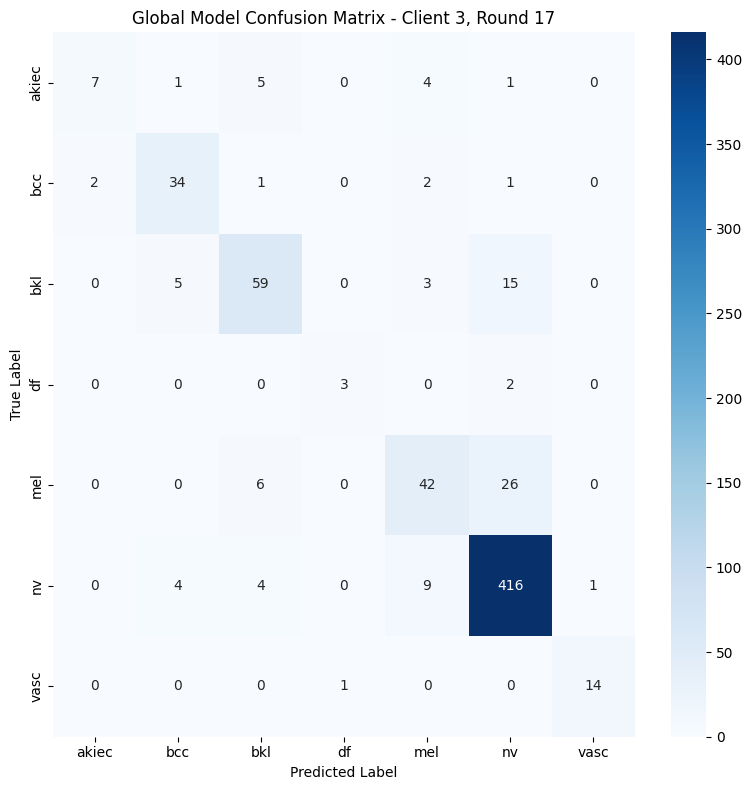


--- Round 18 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [04:43<00:00,  3.38s/it]


Client 1 Epoch 1: Train Loss: 0.2200, Train Accuracy: 96.97%


Client 1 Epoch 2: 100%|██████████| 84/84 [04:43<00:00,  3.38s/it]


Client 1 Epoch 2: Train Loss: 0.2379, Train Accuracy: 98.13%


Client 1 Epoch 3: 100%|██████████| 84/84 [04:44<00:00,  3.38s/it]


Client 1 Epoch 3: Train Loss: 0.1780, Train Accuracy: 99.14%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:31<00:00,  1.52s/it]


Test Loss: 0.6195, Test Accuracy: 84.30%, F1-Score: 0.8352
Confusion Matrix:
 [[ 14   3   2   0   6   3   0]
 [  2  25   0   0   1   5   0]
 [  3   0  46   0   3  20   0]
 [  0   0   3   6   1   0   0]
 [  3   0   2   0  45  27   0]
 [  0   6   4   0   6 422   0]
 [  0   0   0   0   2   3   6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.50      0.56        28
           1       0.74      0.76      0.75        33
           2       0.81      0.64      0.71        72
           3       1.00      0.60      0.75        10
           4       0.70      0.58      0.64        77
           5       0.88      0.96      0.92       438
           6       1.00      0.55      0.71        11

    accuracy                           0.84       669
   macro avg       0.82      0.66      0.72       669
weighted avg       0.84      0.84      0.84       669

Sensitivity/Recall:
 [0.5        0.75757576 0.63888889 0.6        0.58441558 0.9634

Client 2 Epoch 1: 100%|██████████| 84/84 [04:37<00:00,  3.30s/it]


Client 2 Epoch 1: Train Loss: 0.2023, Train Accuracy: 97.56%


Client 2 Epoch 2: 100%|██████████| 84/84 [04:37<00:00,  3.30s/it]


Client 2 Epoch 2: Train Loss: 0.2617, Train Accuracy: 98.09%


Client 2 Epoch 3: 100%|██████████| 84/84 [04:37<00:00,  3.30s/it]


Client 2 Epoch 3: Train Loss: 0.2429, Train Accuracy: 98.39%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


Test Loss: 0.6611, Test Accuracy: 83.83%, F1-Score: 0.8258
Confusion Matrix:
 [[  7   0   3   1   5   6   0]
 [  3  24   3   0   0   8   0]
 [  1   1  30   0   7  19   0]
 [  2   0   0   3   0   4   0]
 [  1   0   3   0  38  26   0]
 [  0   1   3   0   8 451   0]
 [  0   0   0   0   2   1   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.32      0.39        22
           1       0.92      0.63      0.75        38
           2       0.71      0.52      0.60        58
           3       0.75      0.33      0.46         9
           4       0.63      0.56      0.59        68
           5       0.88      0.97      0.92       463
           6       1.00      0.70      0.82        10

    accuracy                           0.84       668
   macro avg       0.77      0.58      0.65       668
weighted avg       0.83      0.84      0.83       668

Sensitivity/Recall:
 [0.31818182 0.63157895 0.51724138 0.33333333 0.55882353 0.9740

Client 3 Epoch 1: 100%|██████████| 84/84 [05:55<00:00,  4.23s/it]


Client 3 Epoch 1: Train Loss: 0.1867, Train Accuracy: 97.71%


Client 3 Epoch 2: 100%|██████████| 84/84 [05:55<00:00,  4.23s/it]


Client 3 Epoch 2: Train Loss: 0.3314, Train Accuracy: 96.67%


Client 3 Epoch 3: 100%|██████████| 84/84 [05:55<00:00,  4.23s/it]


Client 3 Epoch 3: Train Loss: 0.2865, Train Accuracy: 98.39%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:36<00:00,  1.74s/it]


Test Loss: 0.7261, Test Accuracy: 82.63%, F1-Score: 0.8203
Confusion Matrix:
 [[  3   5   7   0   3   0   0]
 [  0  37   2   0   1   0   0]
 [  0   8  55   0   7  12   0]
 [  0   2   0   3   0   0   0]
 [  0   3   1   0  40  30   0]
 [  0  15   7   0  12 400   0]
 [  0   0   0   0   0   1  14]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.17      0.29        18
           1       0.53      0.93      0.67        40
           2       0.76      0.67      0.71        82
           3       1.00      0.60      0.75         5
           4       0.63      0.54      0.58        74
           5       0.90      0.92      0.91       434
           6       1.00      0.93      0.97        15

    accuracy                           0.83       668
   macro avg       0.83      0.68      0.70       668
weighted avg       0.84      0.83      0.82       668

Sensitivity/Recall:
 [0.16666667 0.925      0.67073171 0.6        0.54054054 0.9216

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.59it/s]

Test Loss: 0.5348, Test Accuracy: 86.55%, F1-Score: 0.8594
Confusion Matrix:
 [[ 11   5   4   0   5   3   0]
 [  0  23   4   0   0   5   1]
 [  0   0  54   0   2  16   0]
 [  0   0   3   7   0   0   0]
 [  1   0   3   0  55  18   0]
 [  0   4   5   0   7 422   0]
 [  0   0   0   0   3   1   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.39      0.55        28
           1       0.72      0.70      0.71        33
           2       0.74      0.75      0.74        72
           3       1.00      0.70      0.82        10
           4       0.76      0.71      0.74        77
           5       0.91      0.96      0.93       438
           6       0.88      0.64      0.74        11

    accuracy                           0.87       669
   macro avg       0.85      0.69      0.75       669
weighted avg       0.86      0.87      0.86       669

Sensitivity/Recall:
 [0.39285714 0.6969697  0.75       0.7        0.71428571 0.9634

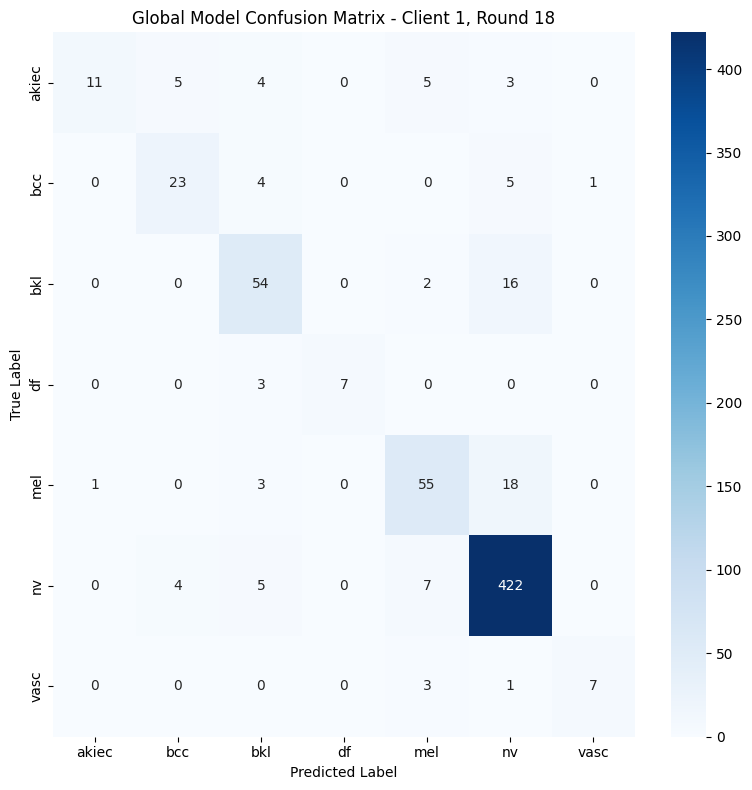


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.59it/s]

Test Loss: 0.4808, Test Accuracy: 86.68%, F1-Score: 0.8568
Confusion Matrix:
 [[  5   3   6   0   5   3   0]
 [  0  31   3   0   1   3   0]
 [  0   2  41   0   4  11   0]
 [  2   1   0   3   2   1   0]
 [  0   3   4   0  40  21   0]
 [  1   1   3   0   8 450   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.23      0.33        22
           1       0.76      0.82      0.78        38
           2       0.72      0.71      0.71        58
           3       1.00      0.33      0.50         9
           4       0.66      0.59      0.62        68
           5       0.92      0.97      0.95       463
           6       1.00      0.90      0.95        10

    accuracy                           0.87       668
   macro avg       0.81      0.65      0.69       668
weighted avg       0.86      0.87      0.86       668

Sensitivity/Recall:
 [0.22727273 0.81578947 0.70689655 0.33333333 0.58823529 0.9719

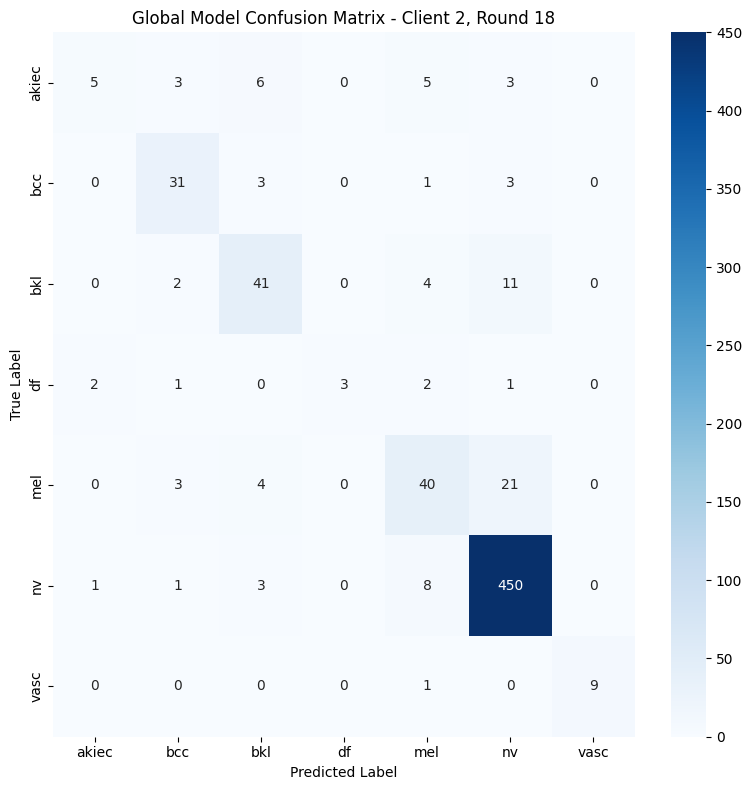


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.6038, Test Accuracy: 85.33%, F1-Score: 0.8463
Confusion Matrix:
 [[ 10   1   4   0   1   2   0]
 [  2  34   1   0   2   1   0]
 [  0   5  51   0   7  19   0]
 [  0   0   0   3   0   2   0]
 [  0   2   1   0  41  30   0]
 [  0   5   2   0  10 417   0]
 [  0   0   0   1   0   0  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.56      0.67        18
           1       0.72      0.85      0.78        40
           2       0.86      0.62      0.72        82
           3       0.75      0.60      0.67         5
           4       0.67      0.55      0.61        74
           5       0.89      0.96      0.92       434
           6       1.00      0.93      0.97        15

    accuracy                           0.85       668
   macro avg       0.82      0.73      0.76       668
weighted avg       0.85      0.85      0.85       668

Sensitivity/Recall:
 [0.55555556 0.85       0.62195122 0.6        0.55405405 0.9608

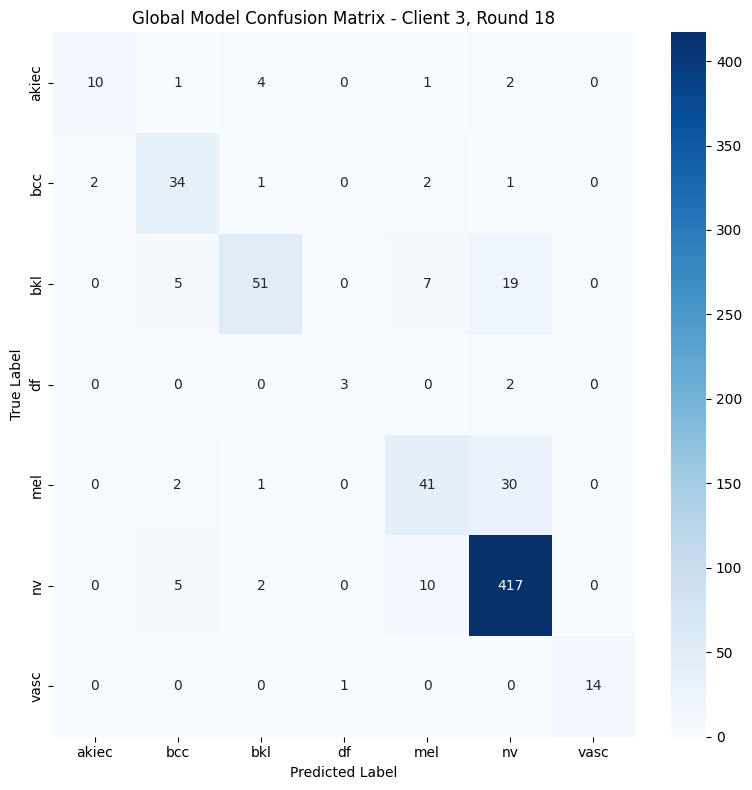


--- Round 19 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [04:33<00:00,  3.26s/it]


Client 1 Epoch 1: Train Loss: 0.1757, Train Accuracy: 97.83%


Client 1 Epoch 2: 100%|██████████| 84/84 [04:34<00:00,  3.26s/it]


Client 1 Epoch 2: Train Loss: 0.2458, Train Accuracy: 97.94%


Client 1 Epoch 3: 100%|██████████| 84/84 [04:34<00:00,  3.27s/it]


Client 1 Epoch 3: Train Loss: 0.2335, Train Accuracy: 98.35%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:19<00:00,  1.06it/s]


Test Loss: 0.6940, Test Accuracy: 81.61%, F1-Score: 0.8151
Confusion Matrix:
 [[  8  14   2   0   1   3   0]
 [  0  29   0   0   0   3   1]
 [  2   4  52   0   3  11   0]
 [  0   2   1   5   2   0   0]
 [  3   4   7   0  46  17   0]
 [  2   9  17   0  12 398   0]
 [  0   0   0   0   1   2   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.29      0.37        28
           1       0.47      0.88      0.61        33
           2       0.66      0.72      0.69        72
           3       1.00      0.50      0.67        10
           4       0.71      0.60      0.65        77
           5       0.92      0.91      0.91       438
           6       0.89      0.73      0.80        11

    accuracy                           0.82       669
   macro avg       0.74      0.66      0.67       669
weighted avg       0.83      0.82      0.82       669

Sensitivity/Recall:
 [0.28571429 0.87878788 0.72222222 0.5        0.5974026  0.9086

Client 2 Epoch 1: 100%|██████████| 84/84 [04:33<00:00,  3.26s/it]


Client 2 Epoch 1: Train Loss: 0.1785, Train Accuracy: 97.86%


Client 2 Epoch 2: 100%|██████████| 84/84 [04:33<00:00,  3.25s/it]


Client 2 Epoch 2: Train Loss: 0.2283, Train Accuracy: 98.28%


Client 2 Epoch 3: 100%|██████████| 84/84 [04:33<00:00,  3.26s/it]


Client 2 Epoch 3: Train Loss: 0.2400, Train Accuracy: 98.31%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:32<00:00,  1.54s/it]


Test Loss: 0.7234, Test Accuracy: 84.28%, F1-Score: 0.8375
Confusion Matrix:
 [[  9   0  12   0   0   1   0]
 [  2  24   8   0   0   4   0]
 [  0   1  46   0   1  10   0]
 [  2   0   2   1   3   1   0]
 [  0   1  12   0  34  21   0]
 [  1   0  14   0   8 440   0]
 [  0   0   0   0   0   1   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.41      0.50        22
           1       0.92      0.63      0.75        38
           2       0.49      0.79      0.61        58
           3       1.00      0.11      0.20         9
           4       0.74      0.50      0.60        68
           5       0.92      0.95      0.94       463
           6       1.00      0.90      0.95        10

    accuracy                           0.84       668
   macro avg       0.82      0.61      0.65       668
weighted avg       0.86      0.84      0.84       668

Sensitivity/Recall:
 [0.40909091 0.63157895 0.79310345 0.11111111 0.5        0.9503

Client 3 Epoch 1: 100%|██████████| 84/84 [05:43<00:00,  4.09s/it]


Client 3 Epoch 1: Train Loss: 0.1566, Train Accuracy: 98.35%


Client 3 Epoch 2: 100%|██████████| 84/84 [05:44<00:00,  4.11s/it]


Client 3 Epoch 2: Train Loss: 0.2395, Train Accuracy: 97.38%


Client 3 Epoch 3: 100%|██████████| 84/84 [05:44<00:00,  4.10s/it]


Client 3 Epoch 3: Train Loss: 0.3230, Train Accuracy: 97.64%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it]


Test Loss: 0.6279, Test Accuracy: 82.49%, F1-Score: 0.8198
Confusion Matrix:
 [[ 13   2   2   0   1   0   0]
 [  3  32   2   0   1   0   2]
 [  1   3  61   0   3  14   0]
 [  0   0   2   1   0   2   0]
 [  2   3   5   0  34  29   1]
 [  1   5  13   0  19 395   1]
 [  0   0   0   0   0   0  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.72      0.68        18
           1       0.71      0.80      0.75        40
           2       0.72      0.74      0.73        82
           3       1.00      0.20      0.33         5
           4       0.59      0.46      0.52        74
           5       0.90      0.91      0.90       434
           6       0.79      1.00      0.88        15

    accuracy                           0.82       668
   macro avg       0.76      0.69      0.69       668
weighted avg       0.82      0.82      0.82       668

Sensitivity/Recall:
 [0.72222222 0.8        0.74390244 0.2        0.45945946 0.9101

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.5286, Test Accuracy: 86.10%, F1-Score: 0.8588
Confusion Matrix:
 [[ 15   2   6   0   4   1   0]
 [  1  23   4   0   0   4   1]
 [  1   0  57   0   1  13   0]
 [  1   0   3   6   0   0   0]
 [  2   0   6   0  51  18   0]
 [  0   3  13   0   8 414   0]
 [  0   0   0   0   0   1  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.54      0.62        28
           1       0.82      0.70      0.75        33
           2       0.64      0.79      0.71        72
           3       1.00      0.60      0.75        10
           4       0.80      0.66      0.72        77
           5       0.92      0.95      0.93       438
           6       0.91      0.91      0.91        11

    accuracy                           0.86       669
   macro avg       0.83      0.73      0.77       669
weighted avg       0.86      0.86      0.86       669

Sensitivity/Recall:
 [0.53571429 0.6969697  0.79166667 0.6        0.66233766 0.9452

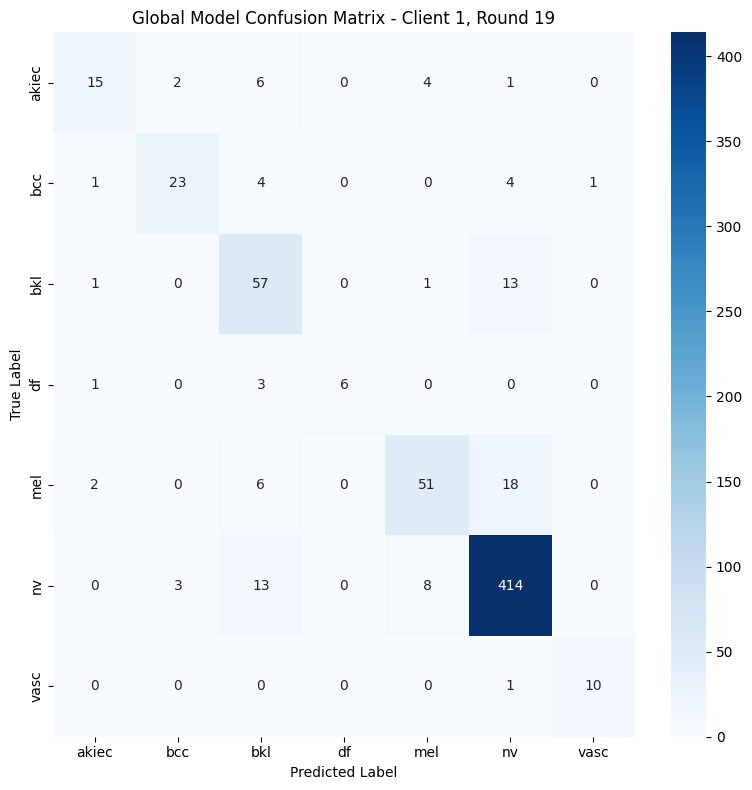


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]

Test Loss: 0.5145, Test Accuracy: 87.13%, F1-Score: 0.8669
Confusion Matrix:
 [[ 10   2   6   0   2   2   0]
 [  1  30   4   0   0   3   0]
 [  0   1  50   0   2   5   0]
 [  2   0   0   4   2   1   0]
 [  0   3   6   0  38  21   0]
 [  0   3   9   0  11 440   0]
 [  0   0   0   0   0   0  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.45      0.57        22
           1       0.77      0.79      0.78        38
           2       0.67      0.86      0.75        58
           3       1.00      0.44      0.62         9
           4       0.69      0.56      0.62        68
           5       0.93      0.95      0.94       463
           6       1.00      1.00      1.00        10

    accuracy                           0.87       668
   macro avg       0.83      0.72      0.75       668
weighted avg       0.87      0.87      0.87       668

Sensitivity/Recall:
 [0.45454545 0.78947368 0.86206897 0.44444444 0.55882353 0.9503

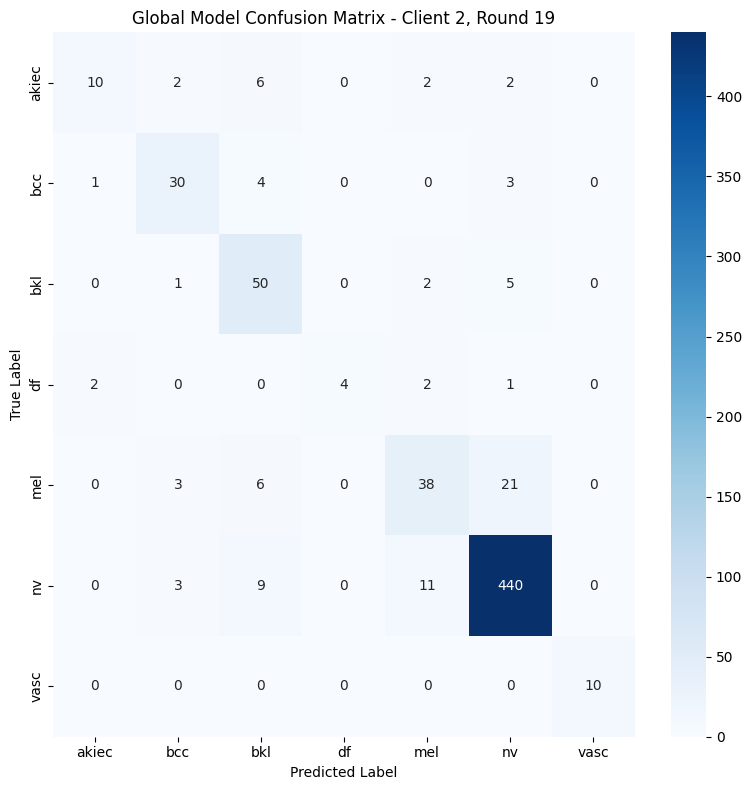


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]

Test Loss: 0.5673, Test Accuracy: 86.53%, F1-Score: 0.8586
Confusion Matrix:
 [[  8   1   5   0   2   2   0]
 [  2  36   0   0   1   0   1]
 [  0   5  63   0   3  11   0]
 [  0   0   1   2   0   2   0]
 [  0   2   1   0  41  30   0]
 [  0   4   7   0  10 413   0]
 [  0   0   0   0   0   0  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.44      0.57        18
           1       0.75      0.90      0.82        40
           2       0.82      0.77      0.79        82
           3       1.00      0.40      0.57         5
           4       0.72      0.55      0.63        74
           5       0.90      0.95      0.93       434
           6       0.94      1.00      0.97        15

    accuracy                           0.87       668
   macro avg       0.85      0.72      0.75       668
weighted avg       0.86      0.87      0.86       668

Sensitivity/Recall:
 [0.44444444 0.9        0.76829268 0.4        0.55405405 0.9516

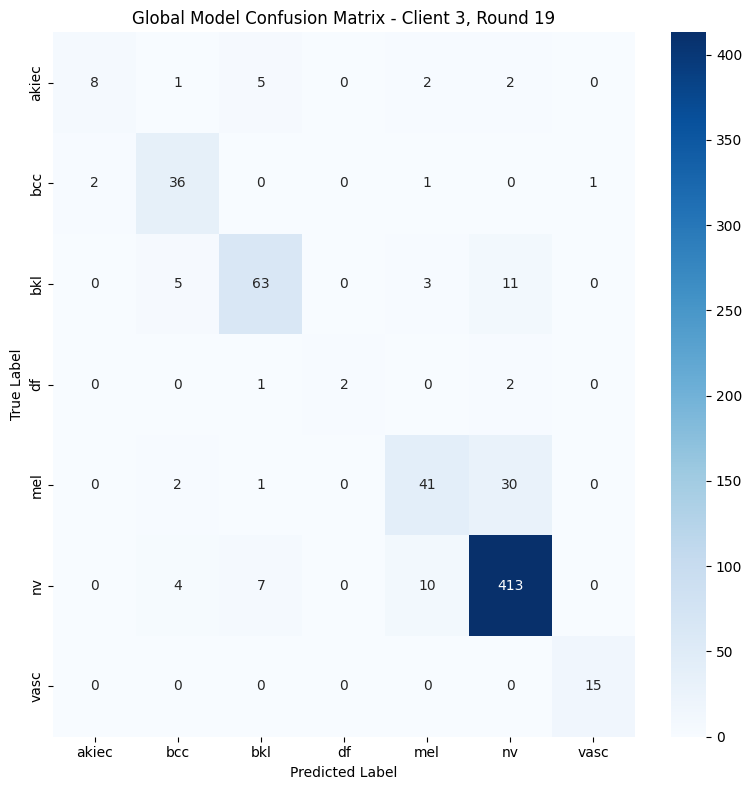


--- Round 20 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [04:39<00:00,  3.33s/it]


Client 1 Epoch 1: Train Loss: 0.1720, Train Accuracy: 98.02%


Client 1 Epoch 2: 100%|██████████| 84/84 [04:40<00:00,  3.34s/it]


Client 1 Epoch 2: Train Loss: 0.2753, Train Accuracy: 97.87%


Client 1 Epoch 3: 100%|██████████| 84/84 [04:40<00:00,  3.34s/it]


Client 1 Epoch 3: Train Loss: 0.2555, Train Accuracy: 98.05%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:26<00:00,  1.27s/it]


Test Loss: 0.6997, Test Accuracy: 81.61%, F1-Score: 0.8116
Confusion Matrix:
 [[ 10   8   6   0   2   1   1]
 [  0  23   4   0   0   6   0]
 [  0   2  55   0   5  10   0]
 [  0   3   3   2   2   0   0]
 [  1   3  13   0  41  18   1]
 [  0   4  18   0  11 404   1]
 [  0   0   0   0   0   0  11]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.36      0.51        28
           1       0.53      0.70      0.61        33
           2       0.56      0.76      0.64        72
           3       1.00      0.20      0.33        10
           4       0.67      0.53      0.59        77
           5       0.92      0.92      0.92       438
           6       0.79      1.00      0.88        11

    accuracy                           0.82       669
   macro avg       0.77      0.64      0.64       669
weighted avg       0.83      0.82      0.81       669

Sensitivity/Recall:
 [0.35714286 0.6969697  0.76388889 0.2        0.53246753 0.9223

Client 2 Epoch 1: 100%|██████████| 84/84 [04:46<00:00,  3.41s/it]


Client 2 Epoch 1: Train Loss: 0.1757, Train Accuracy: 98.35%


Client 2 Epoch 2: 100%|██████████| 84/84 [04:46<00:00,  3.41s/it]


Client 2 Epoch 2: Train Loss: 0.2102, Train Accuracy: 98.20%


Client 2 Epoch 3: 100%|██████████| 84/84 [04:46<00:00,  3.41s/it]


Client 2 Epoch 3: Train Loss: 0.3378, Train Accuracy: 97.30%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:33<00:00,  1.58s/it]


Test Loss: 0.5675, Test Accuracy: 83.98%, F1-Score: 0.8361
Confusion Matrix:
 [[  8   2   9   0   2   1   0]
 [  1  30   3   1   0   3   0]
 [  0   5  43   0   3   7   0]
 [  3   1   1   2   1   1   0]
 [  0   3   8   0  36  21   0]
 [  1   2  14   0  11 435   0]
 [  0   0   0   2   1   0   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.36      0.46        22
           1       0.70      0.79      0.74        38
           2       0.55      0.74      0.63        58
           3       0.40      0.22      0.29         9
           4       0.67      0.53      0.59        68
           5       0.93      0.94      0.93       463
           6       1.00      0.70      0.82        10

    accuracy                           0.84       668
   macro avg       0.69      0.61      0.64       668
weighted avg       0.84      0.84      0.84       668

Sensitivity/Recall:
 [0.36363636 0.78947368 0.74137931 0.22222222 0.52941176 0.9395

Client 3 Epoch 1: 100%|██████████| 84/84 [05:59<00:00,  4.28s/it]


Client 3 Epoch 1: Train Loss: 0.1700, Train Accuracy: 98.05%


Client 3 Epoch 2: 100%|██████████| 84/84 [06:00<00:00,  4.29s/it]


Client 3 Epoch 2: Train Loss: 0.2396, Train Accuracy: 98.09%


Client 3 Epoch 3: 100%|██████████| 84/84 [06:00<00:00,  4.29s/it]


Client 3 Epoch 3: Train Loss: 0.2866, Train Accuracy: 98.24%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.55it/s]


Test Loss: 0.5890, Test Accuracy: 82.19%, F1-Score: 0.8247
Confusion Matrix:
 [[ 11   2   4   0   0   1   0]
 [  2  33   4   0   1   0   0]
 [  1   5  64   0   4   8   0]
 [  0   0   2   1   0   2   0]
 [  2   1   5   0  47  19   0]
 [  0   5  19   0  28 381   1]
 [  0   0   1   1   1   0  12]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.61      0.65        18
           1       0.72      0.82      0.77        40
           2       0.65      0.78      0.71        82
           3       0.50      0.20      0.29         5
           4       0.58      0.64      0.61        74
           5       0.93      0.88      0.90       434
           6       0.92      0.80      0.86        15

    accuracy                           0.82       668
   macro avg       0.71      0.68      0.68       668
weighted avg       0.83      0.82      0.82       668

Sensitivity/Recall:
 [0.61111111 0.825      0.7804878  0.2        0.63513514 0.8778

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.60it/s]

Test Loss: 0.5284, Test Accuracy: 85.80%, F1-Score: 0.8568
Confusion Matrix:
 [[ 13   2   8   0   3   2   0]
 [  0  22   5   0   0   5   1]
 [  1   1  58   0   2  10   0]
 [  0   0   3   6   1   0   0]
 [  1   0   4   0  59  13   0]
 [  0   3  14   0  12 409   0]
 [  0   0   0   0   3   1   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.46      0.60        28
           1       0.79      0.67      0.72        33
           2       0.63      0.81      0.71        72
           3       1.00      0.60      0.75        10
           4       0.74      0.77      0.75        77
           5       0.93      0.93      0.93       438
           6       0.88      0.64      0.74        11

    accuracy                           0.86       669
   macro avg       0.83      0.70      0.74       669
weighted avg       0.87      0.86      0.86       669

Sensitivity/Recall:
 [0.46428571 0.66666667 0.80555556 0.6        0.76623377 0.9337

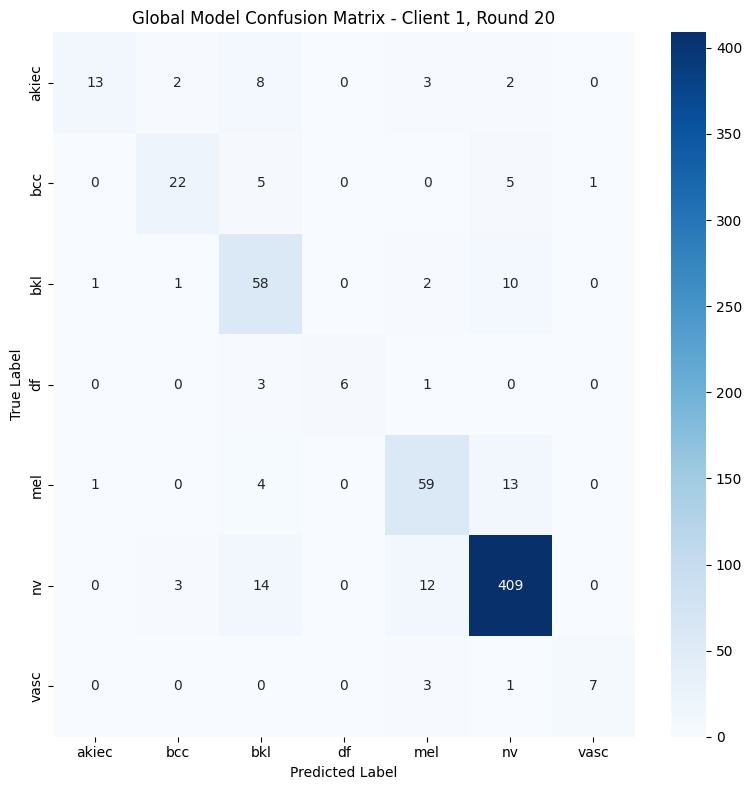


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]


Test Loss: 0.4866, Test Accuracy: 86.23%, F1-Score: 0.8581
Confusion Matrix:
 [[  9   1   8   0   3   1   0]
 [  2  29   4   0   0   3   0]
 [  0   1  50   0   2   5   0]
 [  2   1   1   2   2   1   0]
 [  0   4   7   0  39  18   0]
 [  0   2  13   0  10 438   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.41      0.51        22
           1       0.76      0.76      0.76        38
           2       0.60      0.86      0.71        58
           3       1.00      0.22      0.36         9
           4       0.68      0.57      0.62        68
           5       0.94      0.95      0.94       463
           6       1.00      0.90      0.95        10

    accuracy                           0.86       668
   macro avg       0.81      0.67      0.69       668
weighted avg       0.87      0.86      0.86       668

Sensitivity/Recall:
 [0.40909091 0.76315789 0.86206897 0.22222222 0.57352941 0.9460

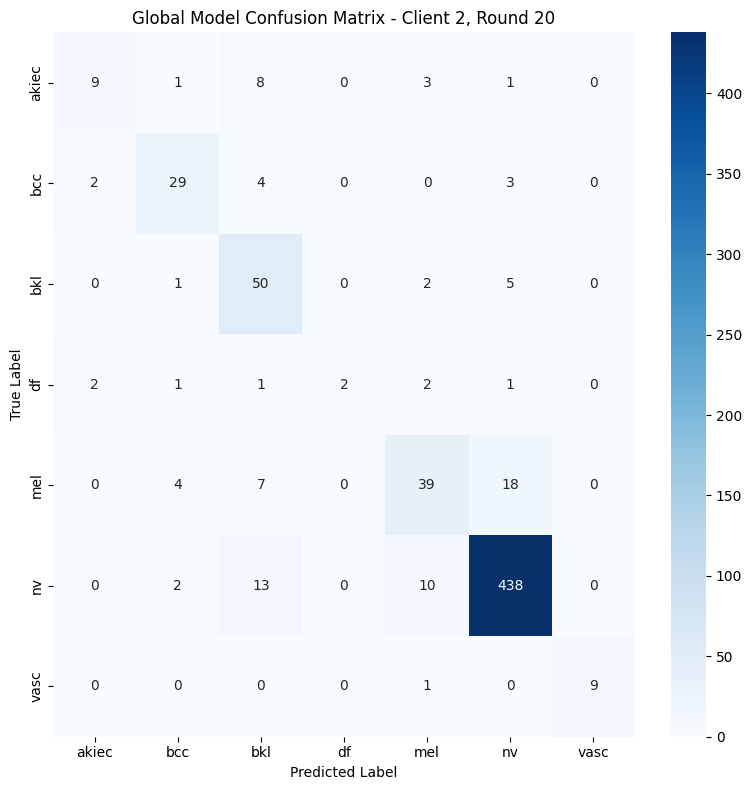


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.5677, Test Accuracy: 86.53%, F1-Score: 0.8602
Confusion Matrix:
 [[  9   1   6   0   1   1   0]
 [  2  36   1   0   1   0   0]
 [  0   5  65   0   5   7   0]
 [  0   0   1   2   0   2   0]
 [  0   1   3   0  41  29   0]
 [  0   3  10   0  11 410   0]
 [  0   0   0   0   0   0  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.50      0.62        18
           1       0.78      0.90      0.84        40
           2       0.76      0.79      0.77        82
           3       1.00      0.40      0.57         5
           4       0.69      0.55      0.62        74
           5       0.91      0.94      0.93       434
           6       1.00      1.00      1.00        15

    accuracy                           0.87       668
   macro avg       0.85      0.73      0.76       668
weighted avg       0.86      0.87      0.86       668

Sensitivity/Recall:
 [0.5        0.9        0.79268293 0.4        0.55405405 0.9447

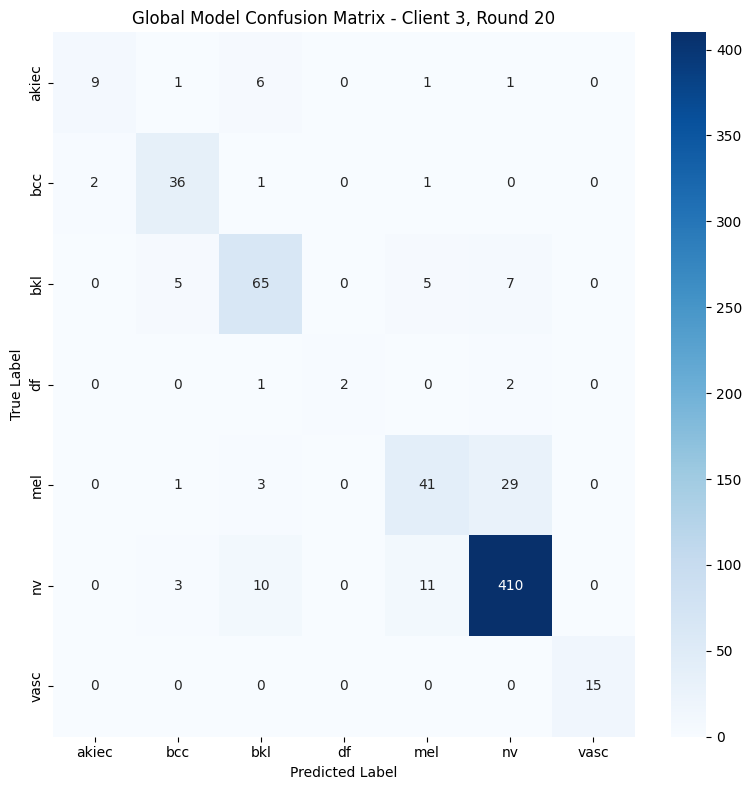


--- Round 21 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [04:22<00:00,  3.12s/it]


Client 1 Epoch 1: Train Loss: 0.1805, Train Accuracy: 97.34%


Client 1 Epoch 2: 100%|██████████| 84/84 [04:22<00:00,  3.13s/it]


Client 1 Epoch 2: Train Loss: 0.2441, Train Accuracy: 98.28%


Client 1 Epoch 3: 100%|██████████| 84/84 [04:22<00:00,  3.13s/it]


Client 1 Epoch 3: Train Loss: 0.2833, Train Accuracy: 97.79%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Test Loss: 0.6101, Test Accuracy: 85.20%, F1-Score: 0.8494
Confusion Matrix:
 [[ 14   2   4   0   6   2   0]
 [  1  23   1   0   1   6   1]
 [  1   0  49   0   7  15   0]
 [  0   0   1   9   0   0   0]
 [  0   0   2   0  55  17   3]
 [  0   2  10   1  14 411   0]
 [  0   0   0   0   1   1   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.50      0.64        28
           1       0.85      0.70      0.77        33
           2       0.73      0.68      0.71        72
           3       0.90      0.90      0.90        10
           4       0.65      0.71      0.68        77
           5       0.91      0.94      0.92       438
           6       0.69      0.82      0.75        11

    accuracy                           0.85       669
   macro avg       0.80      0.75      0.77       669
weighted avg       0.85      0.85      0.85       669

Sensitivity/Recall:
 [0.5        0.6969697  0.68055556 0.9        0.71428571 0.9383

Client 2 Epoch 1: 100%|██████████| 84/84 [04:53<00:00,  3.49s/it]


Client 2 Epoch 1: Train Loss: 0.1668, Train Accuracy: 97.94%


Client 2 Epoch 2: 100%|██████████| 84/84 [04:52<00:00,  3.48s/it]


Client 2 Epoch 2: Train Loss: 0.1586, Train Accuracy: 99.06%


Client 2 Epoch 3: 100%|██████████| 84/84 [04:52<00:00,  3.48s/it]


Client 2 Epoch 3: Train Loss: 0.1339, Train Accuracy: 99.10%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:37<00:00,  1.80s/it]


Test Loss: 0.6663, Test Accuracy: 84.43%, F1-Score: 0.8451
Confusion Matrix:
 [[  5   4  11   0   2   0   0]
 [  2  30   4   0   0   2   0]
 [  0   1  52   0   1   4   0]
 [  2   0   1   6   0   0   0]
 [  0   2  12   0  39  15   0]
 [  1   2  19   0  19 422   0]
 [  0   0   0   0   0   0  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.23      0.31        22
           1       0.77      0.79      0.78        38
           2       0.53      0.90      0.66        58
           3       1.00      0.67      0.80         9
           4       0.64      0.57      0.60        68
           5       0.95      0.91      0.93       463
           6       1.00      1.00      1.00        10

    accuracy                           0.84       668
   macro avg       0.77      0.72      0.73       668
weighted avg       0.86      0.84      0.85       668

Sensitivity/Recall:
 [0.22727273 0.78947368 0.89655172 0.66666667 0.57352941 0.9114

Client 3 Epoch 1: 100%|██████████| 84/84 [05:36<00:00,  4.00s/it]


Client 3 Epoch 1: Train Loss: 0.1637, Train Accuracy: 98.05%


Client 3 Epoch 2: 100%|██████████| 84/84 [05:37<00:00,  4.02s/it]


Client 3 Epoch 2: Train Loss: 0.3158, Train Accuracy: 97.71%


Client 3 Epoch 3: 100%|██████████| 84/84 [05:37<00:00,  4.02s/it]


Client 3 Epoch 3: Train Loss: 0.2369, Train Accuracy: 99.06%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Test Loss: 0.7420, Test Accuracy: 81.44%, F1-Score: 0.8151
Confusion Matrix:
 [[ 10   1   0   0   5   2   0]
 [  3  33   0   0   2   2   0]
 [  1   4  43   0  13  21   0]
 [  0   0   0   3   0   2   0]
 [  1   1   4   0  52  16   0]
 [  0   5   7   0  30 392   0]
 [  0   0   2   1   1   0  11]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.56      0.61        18
           1       0.75      0.82      0.79        40
           2       0.77      0.52      0.62        82
           3       0.75      0.60      0.67         5
           4       0.50      0.70      0.59        74
           5       0.90      0.90      0.90       434
           6       1.00      0.73      0.85        15

    accuracy                           0.81       668
   macro avg       0.76      0.69      0.72       668
weighted avg       0.83      0.81      0.82       668

Sensitivity/Recall:
 [0.55555556 0.825      0.52439024 0.6        0.7027027  0.9032

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.59it/s]

Test Loss: 0.5132, Test Accuracy: 86.40%, F1-Score: 0.8625
Confusion Matrix:
 [[ 14   1   5   0   6   2   0]
 [  0  22   4   0   0   6   1]
 [  1   0  57   0   4  10   0]
 [  0   0   3   7   0   0   0]
 [  1   0   3   0  57  15   1]
 [  0   1  13   0  12 412   0]
 [  0   0   0   0   1   1   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.50      0.64        28
           1       0.92      0.67      0.77        33
           2       0.67      0.79      0.73        72
           3       1.00      0.70      0.82        10
           4       0.71      0.74      0.73        77
           5       0.92      0.94      0.93       438
           6       0.82      0.82      0.82        11

    accuracy                           0.86       669
   macro avg       0.85      0.74      0.78       669
weighted avg       0.87      0.86      0.86       669

Sensitivity/Recall:
 [0.5        0.66666667 0.79166667 0.7        0.74025974 0.9406

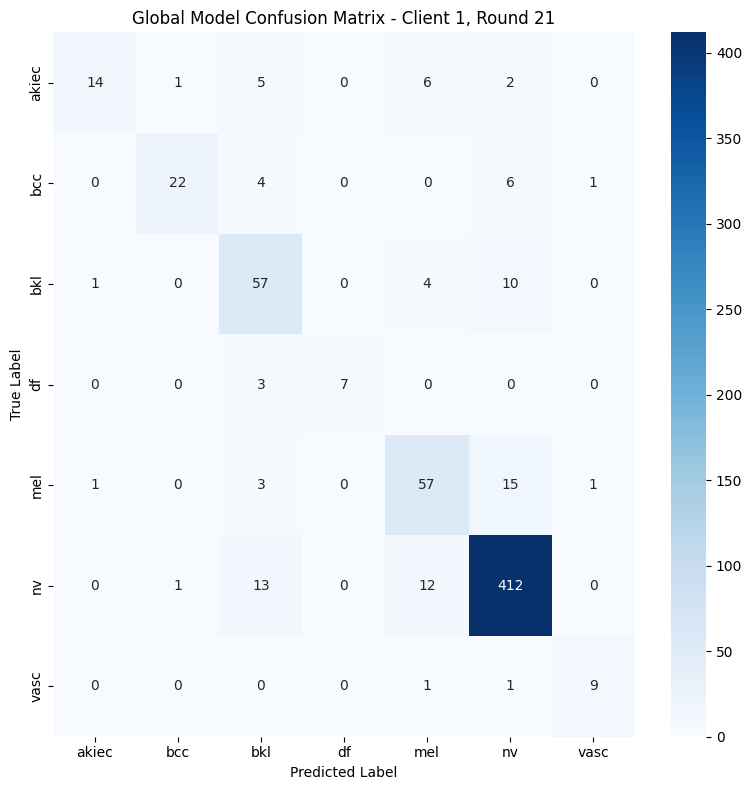


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]

Test Loss: 0.4817, Test Accuracy: 87.72%, F1-Score: 0.8730
Confusion Matrix:
 [[  7   1   8   0   3   3   0]
 [  2  29   3   0   0   4   0]
 [  0   1  47   0   3   7   0]
 [  2   0   0   4   2   1   0]
 [  0   3   5   0  46  14   0]
 [  1   1   6   0  12 443   0]
 [  0   0   0   0   0   0  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.32      0.41        22
           1       0.83      0.76      0.79        38
           2       0.68      0.81      0.74        58
           3       1.00      0.44      0.62         9
           4       0.70      0.68      0.69        68
           5       0.94      0.96      0.95       463
           6       1.00      1.00      1.00        10

    accuracy                           0.88       668
   macro avg       0.82      0.71      0.74       668
weighted avg       0.88      0.88      0.87       668

Sensitivity/Recall:
 [0.31818182 0.76315789 0.81034483 0.44444444 0.67647059 0.9568

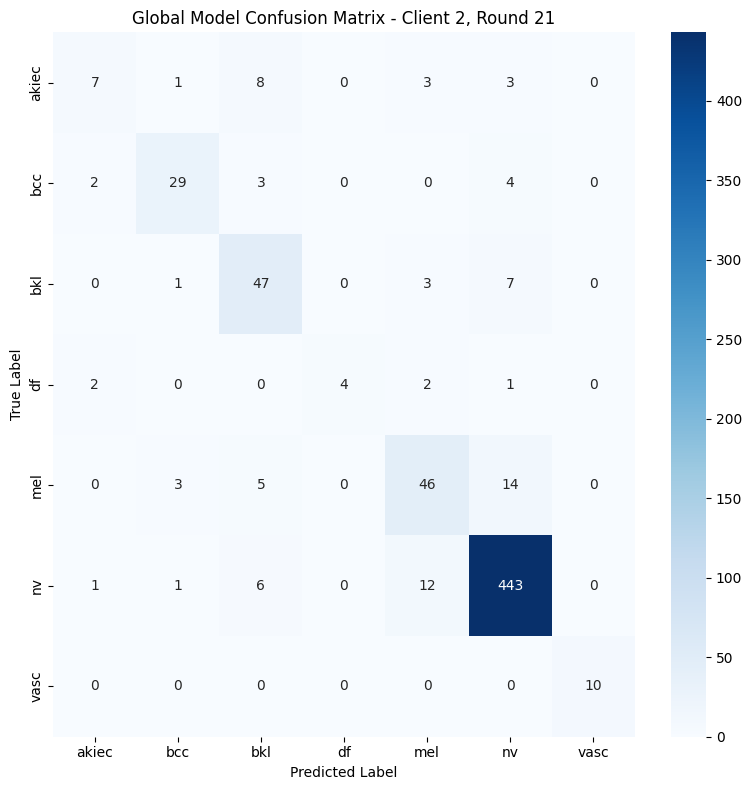


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]

Test Loss: 0.6127, Test Accuracy: 85.93%, F1-Score: 0.8550
Confusion Matrix:
 [[  7   1   3   0   6   1   0]
 [  2  34   0   0   2   2   0]
 [  0   5  59   0   6  12   0]
 [  0   0   0   3   0   2   0]
 [  0   1   0   0  45  28   0]
 [  0   2   5   0  15 411   1]
 [  0   0   0   0   0   0  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.39      0.52        18
           1       0.79      0.85      0.82        40
           2       0.88      0.72      0.79        82
           3       1.00      0.60      0.75         5
           4       0.61      0.61      0.61        74
           5       0.90      0.95      0.92       434
           6       0.94      1.00      0.97        15

    accuracy                           0.86       668
   macro avg       0.84      0.73      0.77       668
weighted avg       0.86      0.86      0.86       668

Sensitivity/Recall:
 [0.38888889 0.85       0.7195122  0.6        0.60810811 0.9470

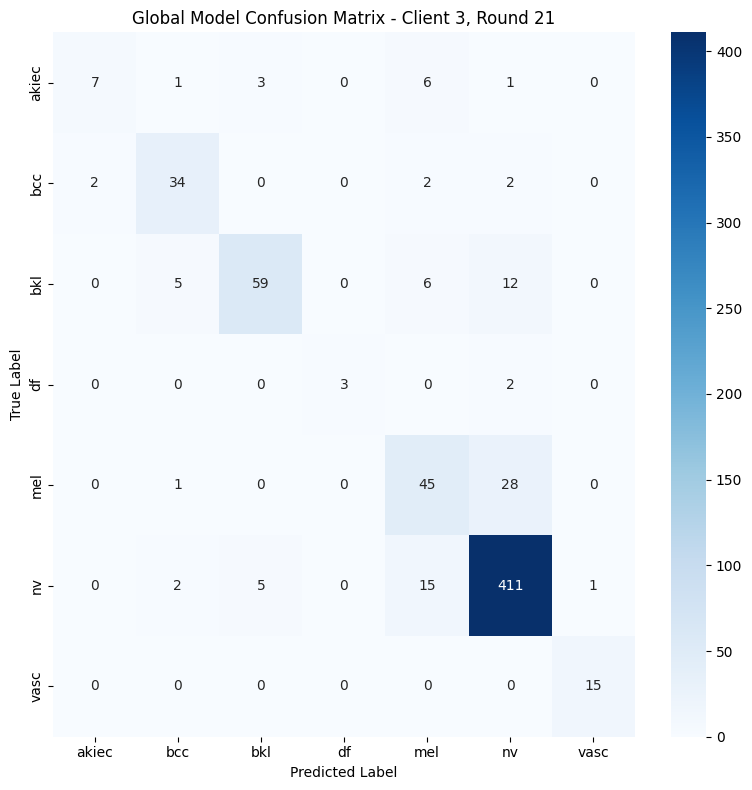


--- Round 22 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [03:42<00:00,  2.64s/it]


Client 1 Epoch 1: Train Loss: 0.1641, Train Accuracy: 98.28%


Client 1 Epoch 2: 100%|██████████| 84/84 [03:42<00:00,  2.65s/it]


Client 1 Epoch 2: Train Loss: 0.3002, Train Accuracy: 97.27%


Client 1 Epoch 3: 100%|██████████| 84/84 [03:42<00:00,  2.65s/it]


Client 1 Epoch 3: Train Loss: 0.2465, Train Accuracy: 98.54%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:14<00:00,  1.42it/s]


Test Loss: 0.7671, Test Accuracy: 83.41%, F1-Score: 0.8207
Confusion Matrix:
 [[ 14   2   3   0   2   6   1]
 [  2  21   2   0   0   7   1]
 [  2   0  42   0   3  25   0]
 [  0   0   2   8   0   0   0]
 [  4   0   6   0  35  31   1]
 [  0   0   7   1   3 427   0]
 [  0   0   0   0   0   0  11]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.50      0.56        28
           1       0.91      0.64      0.75        33
           2       0.68      0.58      0.63        72
           3       0.89      0.80      0.84        10
           4       0.81      0.45      0.58        77
           5       0.86      0.97      0.91       438
           6       0.79      1.00      0.88        11

    accuracy                           0.83       669
   macro avg       0.80      0.71      0.74       669
weighted avg       0.83      0.83      0.82       669

Sensitivity/Recall:
 [0.5        0.63636364 0.58333333 0.8        0.45454545 0.9748

Client 2 Epoch 1: 100%|██████████| 84/84 [05:42<00:00,  4.08s/it]


Client 2 Epoch 1: Train Loss: 0.1678, Train Accuracy: 98.01%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:43<00:00,  4.08s/it]


Client 2 Epoch 2: Train Loss: 0.2058, Train Accuracy: 98.76%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:42<00:00,  4.08s/it]


Client 2 Epoch 3: Train Loss: 0.1734, Train Accuracy: 99.21%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:46<00:00,  2.20s/it]


Test Loss: 0.6024, Test Accuracy: 85.33%, F1-Score: 0.8434
Confusion Matrix:
 [[  9   2   4   0   4   3   0]
 [  1  29   3   0   1   4   0]
 [  0   4  34   0   6  14   0]
 [  4   1   0   3   1   0   0]
 [  1   4   1   0  35  27   0]
 [  1   1   3   0   8 450   0]
 [  0   0   0   0   0   0  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.41      0.47        22
           1       0.71      0.76      0.73        38
           2       0.76      0.59      0.66        58
           3       1.00      0.33      0.50         9
           4       0.64      0.51      0.57        68
           5       0.90      0.97      0.94       463
           6       1.00      1.00      1.00        10

    accuracy                           0.85       668
   macro avg       0.80      0.65      0.70       668
weighted avg       0.84      0.85      0.84       668

Sensitivity/Recall:
 [0.40909091 0.76315789 0.5862069  0.33333333 0.51470588 0.9719

Client 3 Epoch 1: 100%|██████████| 84/84 [05:19<00:00,  3.81s/it]


Client 3 Epoch 1: Train Loss: 0.1903, Train Accuracy: 97.83%


Client 3 Epoch 2: 100%|██████████| 84/84 [05:20<00:00,  3.81s/it]


Client 3 Epoch 2: Train Loss: 0.1915, Train Accuracy: 98.73%


Client 3 Epoch 3: 100%|██████████| 84/84 [05:20<00:00,  3.81s/it]


Client 3 Epoch 3: Train Loss: 0.2636, Train Accuracy: 97.90%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:22<00:00,  1.05s/it]


Test Loss: 0.7721, Test Accuracy: 81.29%, F1-Score: 0.8010
Confusion Matrix:
 [[ 11   0   4   0   2   1   0]
 [  8  19   5   0   2   6   0]
 [  2   1  46   0   6  27   0]
 [  0   0   0   3   0   2   0]
 [  2   0   1   0  34  37   0]
 [  1   1   4   0  11 417   0]
 [  0   0   1   0   0   1  13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.61      0.52        18
           1       0.90      0.47      0.62        40
           2       0.75      0.56      0.64        82
           3       1.00      0.60      0.75         5
           4       0.62      0.46      0.53        74
           5       0.85      0.96      0.90       434
           6       1.00      0.87      0.93        15

    accuracy                           0.81       668
   macro avg       0.80      0.65      0.70       668
weighted avg       0.81      0.81      0.80       668

Sensitivity/Recall:
 [0.61111111 0.475      0.56097561 0.6        0.45945946 0.9608

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.60it/s]

Test Loss: 0.6012, Test Accuracy: 86.10%, F1-Score: 0.8545
Confusion Matrix:
 [[ 13   2   6   0   6   1   0]
 [  1  20   2   0   1   8   1]
 [  1   0  53   0   2  16   0]
 [  0   0   3   7   0   0   0]
 [  1   0   3   0  50  22   1]
 [  0   1   8   0   5 424   0]
 [  0   0   0   0   1   1   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.46      0.59        28
           1       0.87      0.61      0.71        33
           2       0.71      0.74      0.72        72
           3       1.00      0.70      0.82        10
           4       0.77      0.65      0.70        77
           5       0.90      0.97      0.93       438
           6       0.82      0.82      0.82        11

    accuracy                           0.86       669
   macro avg       0.84      0.71      0.76       669
weighted avg       0.86      0.86      0.85       669

Sensitivity/Recall:
 [0.46428571 0.60606061 0.73611111 0.7        0.64935065 0.9680

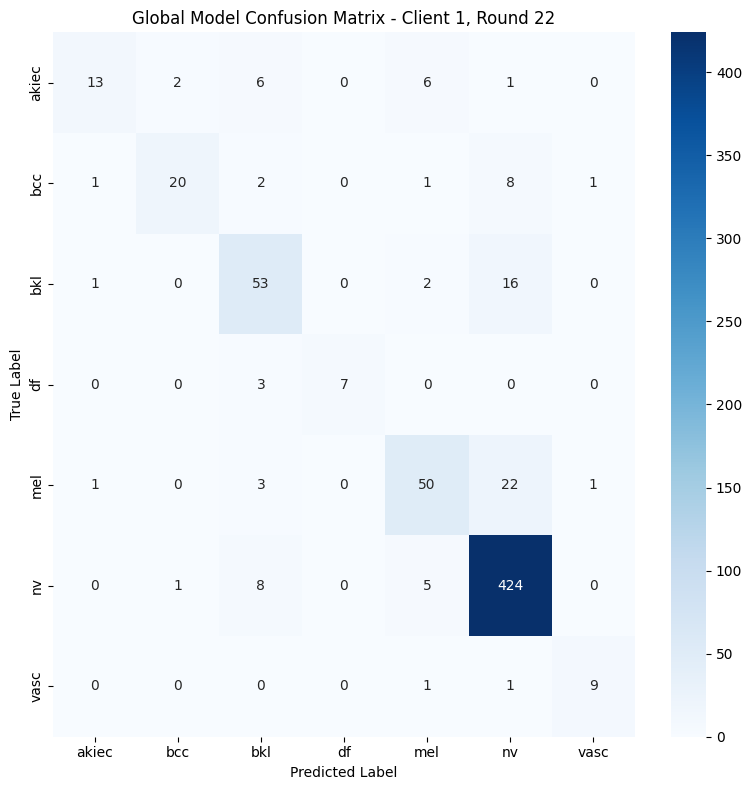


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.5522, Test Accuracy: 86.38%, F1-Score: 0.8533
Confusion Matrix:
 [[  7   1   7   0   3   4   0]
 [  4  26   3   1   0   4   0]
 [  1   1  40   1   3  12   0]
 [  3   0   0   3   0   3   0]
 [  0   2   2   0  37  27   0]
 [  0   1   3   0   5 454   0]
 [  0   0   0   0   0   0  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.32      0.38        22
           1       0.84      0.68      0.75        38
           2       0.73      0.69      0.71        58
           3       0.60      0.33      0.43         9
           4       0.77      0.54      0.64        68
           5       0.90      0.98      0.94       463
           6       1.00      1.00      1.00        10

    accuracy                           0.86       668
   macro avg       0.76      0.65      0.69       668
weighted avg       0.85      0.86      0.85       668

Sensitivity/Recall:
 [0.31818182 0.68421053 0.68965517 0.33333333 0.54411765 0.9805

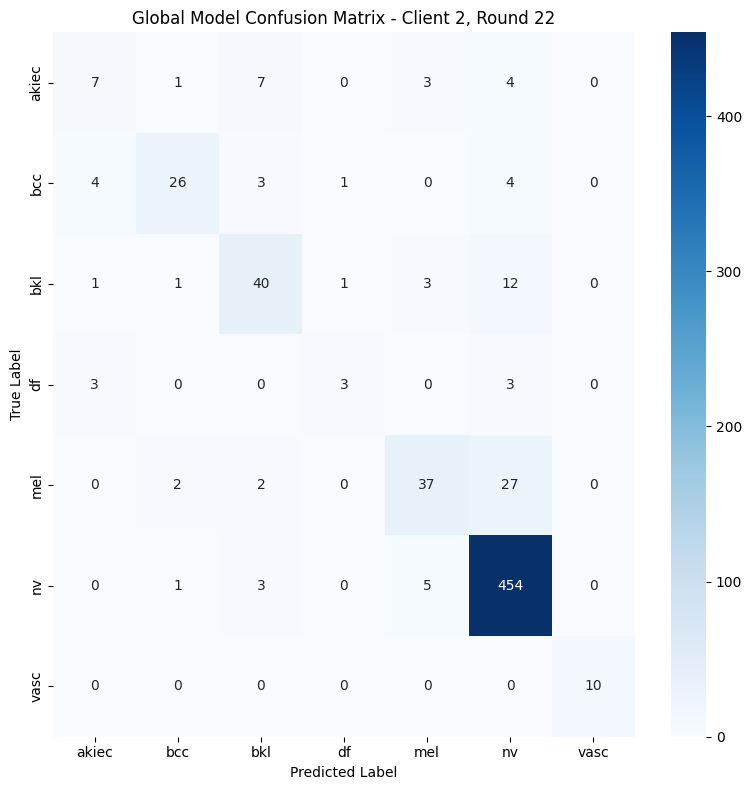


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.6807, Test Accuracy: 86.08%, F1-Score: 0.8521
Confusion Matrix:
 [[  9   1   5   0   2   1   0]
 [  2  28   2   0   3   4   1]
 [  0   5  56   0   5  16   0]
 [  0   0   0   3   0   2   0]
 [  1   0   1   0  40  32   0]
 [  0   1   2   0   6 425   0]
 [  0   0   0   0   0   1  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.50      0.60        18
           1       0.80      0.70      0.75        40
           2       0.85      0.68      0.76        82
           3       1.00      0.60      0.75         5
           4       0.71      0.54      0.62        74
           5       0.88      0.98      0.93       434
           6       0.93      0.93      0.93        15

    accuracy                           0.86       668
   macro avg       0.85      0.71      0.76       668
weighted avg       0.85      0.86      0.85       668

Sensitivity/Recall:
 [0.5        0.7        0.68292683 0.6        0.54054054 0.9792

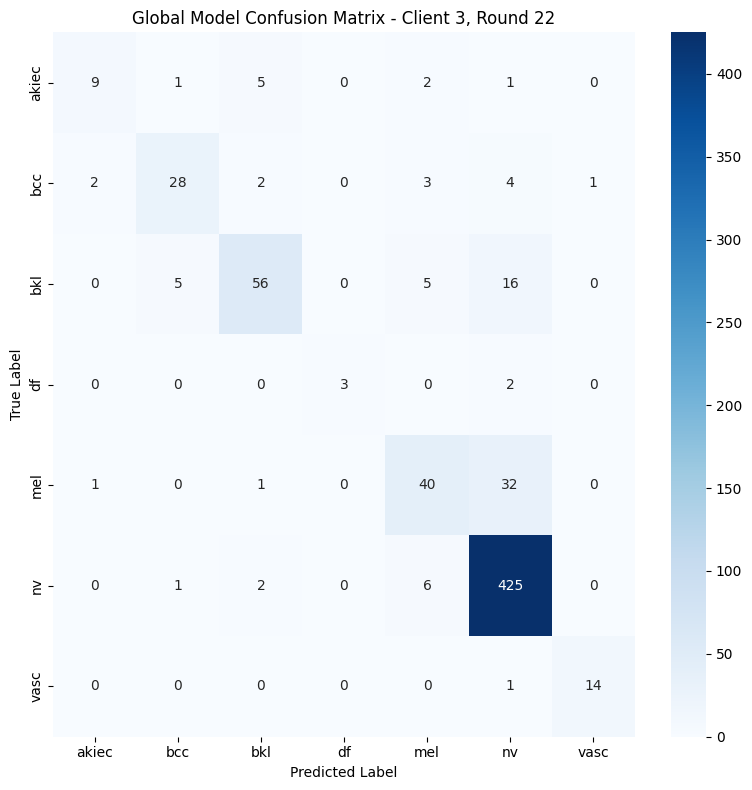


--- Round 23 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [03:51<00:00,  2.76s/it]


Client 1 Epoch 1: Train Loss: 0.1489, Train Accuracy: 98.65%


Client 1 Epoch 2: 100%|██████████| 84/84 [03:52<00:00,  2.77s/it]


Client 1 Epoch 2: Train Loss: 0.2543, Train Accuracy: 98.28%


Client 1 Epoch 3: 100%|██████████| 84/84 [03:52<00:00,  2.77s/it]


Client 1 Epoch 3: Train Loss: 0.2194, Train Accuracy: 98.95%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:19<00:00,  1.05it/s]


Test Loss: 0.7366, Test Accuracy: 83.56%, F1-Score: 0.8286
Confusion Matrix:
 [[ 10   4   7   0   5   2   0]
 [  0  22   2   0   2   7   0]
 [  0   0  43   0   9  20   0]
 [  0   0   3   4   2   1   0]
 [  0   0   2   0  58  17   0]
 [  1   0   8   0  14 415   0]
 [  0   0   0   0   2   2   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.36      0.51        28
           1       0.85      0.67      0.75        33
           2       0.66      0.60      0.63        72
           3       1.00      0.40      0.57        10
           4       0.63      0.75      0.69        77
           5       0.89      0.95      0.92       438
           6       1.00      0.64      0.78        11

    accuracy                           0.84       669
   macro avg       0.85      0.62      0.69       669
weighted avg       0.84      0.84      0.83       669

Sensitivity/Recall:
 [0.35714286 0.66666667 0.59722222 0.4        0.75324675 0.9474

Client 2 Epoch 1: 100%|██████████| 84/84 [05:26<00:00,  3.88s/it]


Client 2 Epoch 1: Train Loss: 0.1785, Train Accuracy: 98.01%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:25<00:00,  3.87s/it]


Client 2 Epoch 2: Train Loss: 0.2649, Train Accuracy: 97.98%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:25<00:00,  3.87s/it]


Client 2 Epoch 3: Train Loss: 0.2368, Train Accuracy: 98.95%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:41<00:00,  1.98s/it]


Test Loss: 0.5353, Test Accuracy: 85.93%, F1-Score: 0.8545
Confusion Matrix:
 [[ 13   3   4   0   1   1   0]
 [  2  34   0   1   0   1   0]
 [  2   4  37   0   4  11   0]
 [  2   1   0   3   2   1   0]
 [  0   5   4   0  37  22   0]
 [  1   7   4   0  11 440   0]
 [  0   0   0   0   0   0  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.59      0.62        22
           1       0.63      0.89      0.74        38
           2       0.76      0.64      0.69        58
           3       0.75      0.33      0.46         9
           4       0.67      0.54      0.60        68
           5       0.92      0.95      0.94       463
           6       1.00      1.00      1.00        10

    accuracy                           0.86       668
   macro avg       0.77      0.71      0.72       668
weighted avg       0.86      0.86      0.85       668

Sensitivity/Recall:
 [0.59090909 0.89473684 0.63793103 0.33333333 0.54411765 0.9503

Client 3 Epoch 1: 100%|██████████| 84/84 [05:50<00:00,  4.18s/it]


Client 3 Epoch 1: Train Loss: 0.1755, Train Accuracy: 98.16%


Client 3 Epoch 2: 100%|██████████| 84/84 [05:51<00:00,  4.19s/it]


Client 3 Epoch 2: Train Loss: 0.3302, Train Accuracy: 97.26%


Client 3 Epoch 3: 100%|██████████| 84/84 [05:52<00:00,  4.19s/it]


Client 3 Epoch 3: Train Loss: 0.2819, Train Accuracy: 98.80%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:21<00:00,  1.02s/it]


Test Loss: 0.6859, Test Accuracy: 84.43%, F1-Score: 0.8449
Confusion Matrix:
 [[ 10   1   4   0   2   1   0]
 [  1  33   2   3   1   0   0]
 [  0   5  62   0   6   9   0]
 [  0   0   0   4   0   1   0]
 [  0   0   3   0  47  24   0]
 [  0   5  14   0  21 393   1]
 [  0   0   0   0   0   0  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.56      0.69        18
           1       0.75      0.82      0.79        40
           2       0.73      0.76      0.74        82
           3       0.57      0.80      0.67         5
           4       0.61      0.64      0.62        74
           5       0.92      0.91      0.91       434
           6       0.94      1.00      0.97        15

    accuracy                           0.84       668
   macro avg       0.78      0.78      0.77       668
weighted avg       0.85      0.84      0.84       668

Sensitivity/Recall:
 [0.55555556 0.825      0.75609756 0.8        0.63513514 0.9055

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.5499, Test Accuracy: 86.55%, F1-Score: 0.8611
Confusion Matrix:
 [[ 11   3   7   0   5   2   0]
 [  0  25   3   0   0   5   0]
 [  0   0  55   0   3  14   0]
 [  0   0   3   7   0   0   0]
 [  1   1   2   0  56  16   1]
 [  0   2   9   1   9 416   1]
 [  0   0   0   0   1   1   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.39      0.55        28
           1       0.81      0.76      0.78        33
           2       0.70      0.76      0.73        72
           3       0.88      0.70      0.78        10
           4       0.76      0.73      0.74        77
           5       0.92      0.95      0.93       438
           6       0.82      0.82      0.82        11

    accuracy                           0.87       669
   macro avg       0.83      0.73      0.76       669
weighted avg       0.87      0.87      0.86       669

Sensitivity/Recall:
 [0.39285714 0.75757576 0.76388889 0.7        0.72727273 0.9497

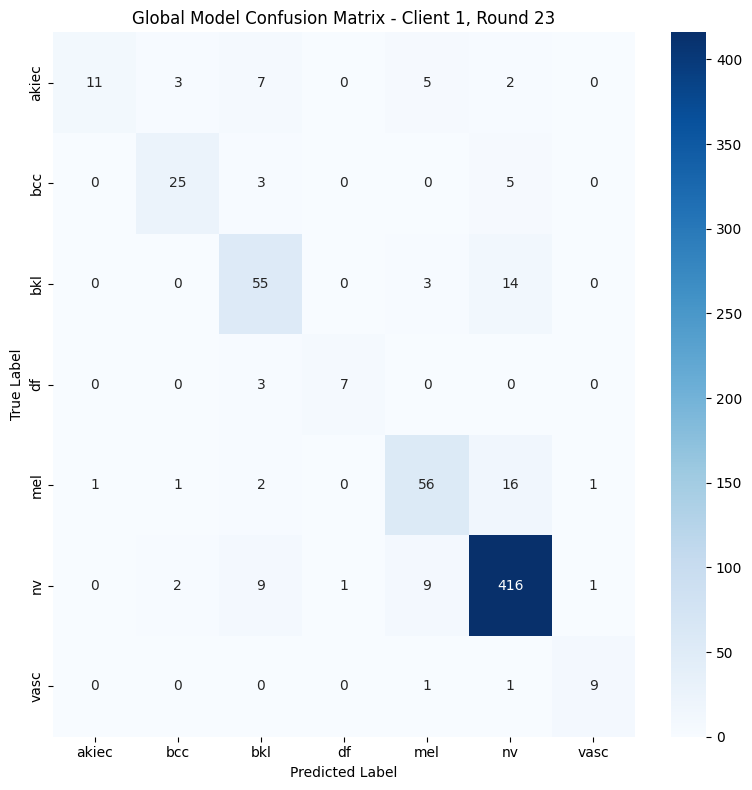


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.4683, Test Accuracy: 87.57%, F1-Score: 0.8697
Confusion Matrix:
 [[  7   2   7   0   4   2   0]
 [  1  30   3   1   0   3   0]
 [  1   1  44   1   5   6   0]
 [  1   1   0   4   2   1   0]
 [  0   3   2   0  43  20   0]
 [  0   3   5   0   8 447   0]
 [  0   0   0   0   0   0  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.32      0.44        22
           1       0.75      0.79      0.77        38
           2       0.72      0.76      0.74        58
           3       0.67      0.44      0.53         9
           4       0.69      0.63      0.66        68
           5       0.93      0.97      0.95       463
           6       1.00      1.00      1.00        10

    accuracy                           0.88       668
   macro avg       0.78      0.70      0.73       668
weighted avg       0.87      0.88      0.87       668

Sensitivity/Recall:
 [0.31818182 0.78947368 0.75862069 0.44444444 0.63235294 0.9654

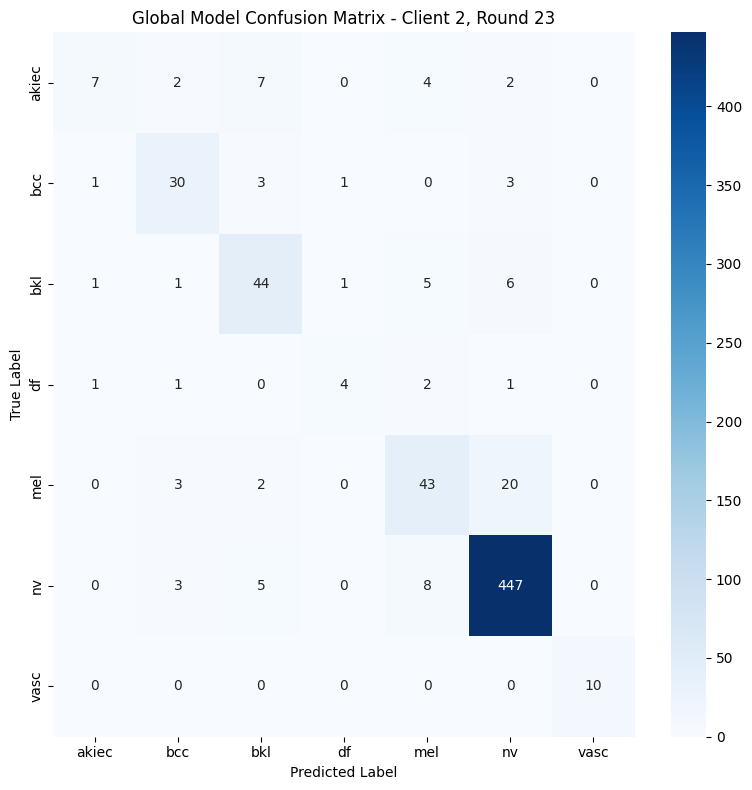


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.6915, Test Accuracy: 85.48%, F1-Score: 0.8476
Confusion Matrix:
 [[  9   1   5   0   2   1   0]
 [  2  34   1   0   2   0   1]
 [  1   5  54   0   6  16   0]
 [  0   0   1   2   0   2   0]
 [  0   1   2   0  41  30   0]
 [  0   3   5   0  10 416   0]
 [  0   0   0   0   0   0  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.50      0.60        18
           1       0.77      0.85      0.81        40
           2       0.79      0.66      0.72        82
           3       1.00      0.40      0.57         5
           4       0.67      0.55      0.61        74
           5       0.89      0.96      0.93       434
           6       0.94      1.00      0.97        15

    accuracy                           0.85       668
   macro avg       0.83      0.70      0.74       668
weighted avg       0.85      0.85      0.85       668

Sensitivity/Recall:
 [0.5        0.85       0.65853659 0.4        0.55405405 0.9585

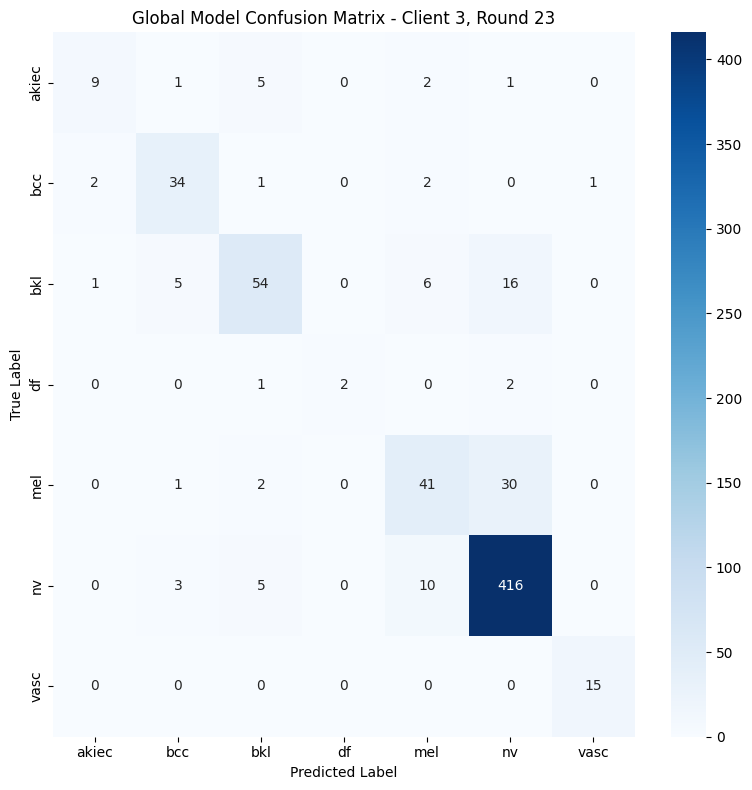


--- Round 24 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [03:51<00:00,  2.75s/it]


Client 1 Epoch 1: Train Loss: 0.1626, Train Accuracy: 98.17%


Client 1 Epoch 2: 100%|██████████| 84/84 [03:51<00:00,  2.76s/it]


Client 1 Epoch 2: Train Loss: 0.2530, Train Accuracy: 98.28%


Client 1 Epoch 3: 100%|██████████| 84/84 [03:52<00:00,  2.76s/it]


Client 1 Epoch 3: Train Loss: 0.2675, Train Accuracy: 98.17%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Test Loss: 0.6332, Test Accuracy: 85.20%, F1-Score: 0.8472
Confusion Matrix:
 [[ 13   8   2   1   1   2   1]
 [  1  23   1   1   0   6   1]
 [  3   1  49   0   5  14   0]
 [  0   0   2   8   0   0   0]
 [  4   0   3   0  50  20   0]
 [  0   2   9   1   7 418   1]
 [  0   0   0   0   1   1   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.46      0.53        28
           1       0.68      0.70      0.69        33
           2       0.74      0.68      0.71        72
           3       0.73      0.80      0.76        10
           4       0.78      0.65      0.71        77
           5       0.91      0.95      0.93       438
           6       0.75      0.82      0.78        11

    accuracy                           0.85       669
   macro avg       0.74      0.72      0.73       669
weighted avg       0.85      0.85      0.85       669

Sensitivity/Recall:
 [0.46428571 0.6969697  0.68055556 0.8        0.64935065 0.9543

Client 2 Epoch 1: 100%|██████████| 84/84 [05:29<00:00,  3.92s/it]


Client 2 Epoch 1: Train Loss: 0.1342, Train Accuracy: 98.76%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:28<00:00,  3.91s/it]


Client 2 Epoch 2: Train Loss: 0.1926, Train Accuracy: 98.84%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:28<00:00,  3.91s/it]


Client 2 Epoch 3: Train Loss: 0.2846, Train Accuracy: 97.68%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:41<00:00,  1.98s/it]


Test Loss: 0.6263, Test Accuracy: 85.93%, F1-Score: 0.8521
Confusion Matrix:
 [[ 14   0   3   2   0   3   0]
 [  3  28   1   1   0   5   0]
 [  2   2  40   1   3  10   0]
 [  3   0   0   5   0   1   0]
 [  2   0   5   2  30  28   1]
 [  2   2   5   1   4 449   0]
 [  0   0   0   1   1   0   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.64      0.58        22
           1       0.88      0.74      0.80        38
           2       0.74      0.69      0.71        58
           3       0.38      0.56      0.45         9
           4       0.79      0.44      0.57        68
           5       0.91      0.97      0.94       463
           6       0.89      0.80      0.84        10

    accuracy                           0.86       668
   macro avg       0.73      0.69      0.70       668
weighted avg       0.86      0.86      0.85       668

Sensitivity/Recall:
 [0.63636364 0.73684211 0.68965517 0.55555556 0.44117647 0.9697

Client 3 Epoch 1: 100%|██████████| 84/84 [05:20<00:00,  3.81s/it]


Client 3 Epoch 1: Train Loss: 0.1608, Train Accuracy: 98.01%


Client 3 Epoch 2: 100%|██████████| 84/84 [05:16<00:00,  3.77s/it]


Client 3 Epoch 2: Train Loss: 0.2342, Train Accuracy: 98.43%


Client 3 Epoch 3: 100%|██████████| 84/84 [05:21<00:00,  3.83s/it]


Client 3 Epoch 3: Train Loss: 0.2210, Train Accuracy: 98.80%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


Test Loss: 0.7217, Test Accuracy: 83.53%, F1-Score: 0.8249
Confusion Matrix:
 [[  9   2   3   0   4   0   0]
 [  2  33   1   0   2   1   1]
 [  1   6  50   0   8  17   0]
 [  0   0   0   1   2   2   0]
 [  0   0   1   0  34  38   1]
 [  0   5   2   0  10 416   1]
 [  0   0   0   0   0   0  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.50      0.60        18
           1       0.72      0.82      0.77        40
           2       0.88      0.61      0.72        82
           3       1.00      0.20      0.33         5
           4       0.57      0.46      0.51        74
           5       0.88      0.96      0.92       434
           6       0.83      1.00      0.91        15

    accuracy                           0.84       668
   macro avg       0.80      0.65      0.68       668
weighted avg       0.83      0.84      0.82       668

Sensitivity/Recall:
 [0.5        0.825      0.6097561  0.2        0.45945946 0.9585

Testing: 100%|██████████| 21/21 [00:15<00:00,  1.35it/s]

Test Loss: 0.5096, Test Accuracy: 88.19%, F1-Score: 0.8803
Confusion Matrix:
 [[ 17   1   5   0   4   1   0]
 [  2  26   2   0   0   2   1]
 [  1   0  57   0   3  11   0]
 [  0   0   3   7   0   0   0]
 [  2   0   2   0  56  17   0]
 [  0   3   8   0  10 416   1]
 [  0   0   0   0   0   0  11]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.61      0.68        28
           1       0.87      0.79      0.83        33
           2       0.74      0.79      0.77        72
           3       1.00      0.70      0.82        10
           4       0.77      0.73      0.75        77
           5       0.93      0.95      0.94       438
           6       0.85      1.00      0.92        11

    accuracy                           0.88       669
   macro avg       0.85      0.79      0.81       669
weighted avg       0.88      0.88      0.88       669

Sensitivity/Recall:
 [0.60714286 0.78787879 0.79166667 0.7        0.72727273 0.9497

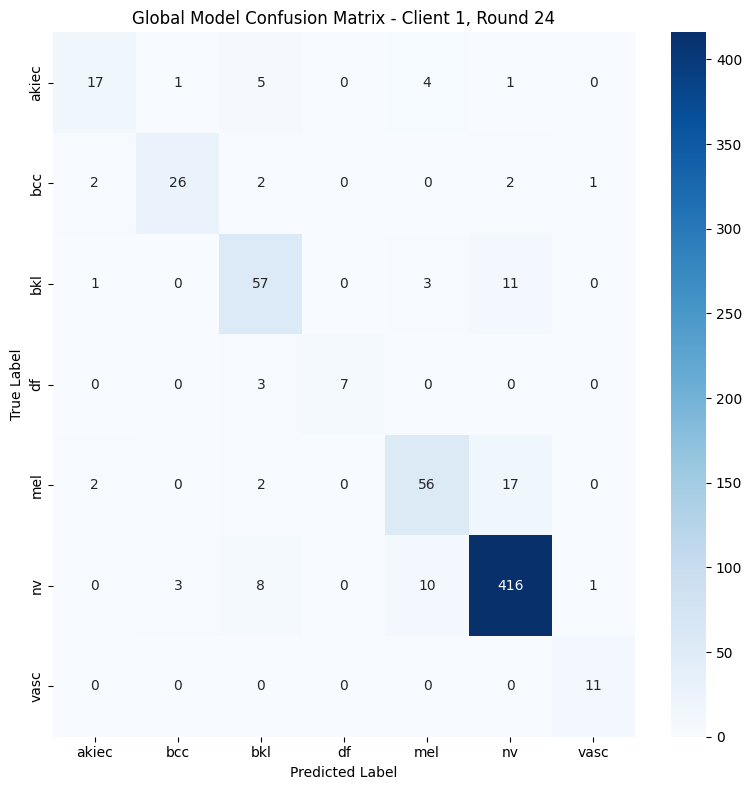


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:15<00:00,  1.34it/s]

Test Loss: 0.4783, Test Accuracy: 88.47%, F1-Score: 0.8778
Confusion Matrix:
 [[  9   2   6   0   3   2   0]
 [  1  32   2   0   1   2   0]
 [  1   0  44   1   3   9   0]
 [  1   0   0   5   2   1   0]
 [  0   2   3   0  39  24   0]
 [  0   1   5   0   5 452   0]
 [  0   0   0   0   0   0  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.41      0.53        22
           1       0.86      0.84      0.85        38
           2       0.73      0.76      0.75        58
           3       0.83      0.56      0.67         9
           4       0.74      0.57      0.64        68
           5       0.92      0.98      0.95       463
           6       1.00      1.00      1.00        10

    accuracy                           0.88       668
   macro avg       0.83      0.73      0.77       668
weighted avg       0.88      0.88      0.88       668

Sensitivity/Recall:
 [0.40909091 0.84210526 0.75862069 0.55555556 0.57352941 0.9762

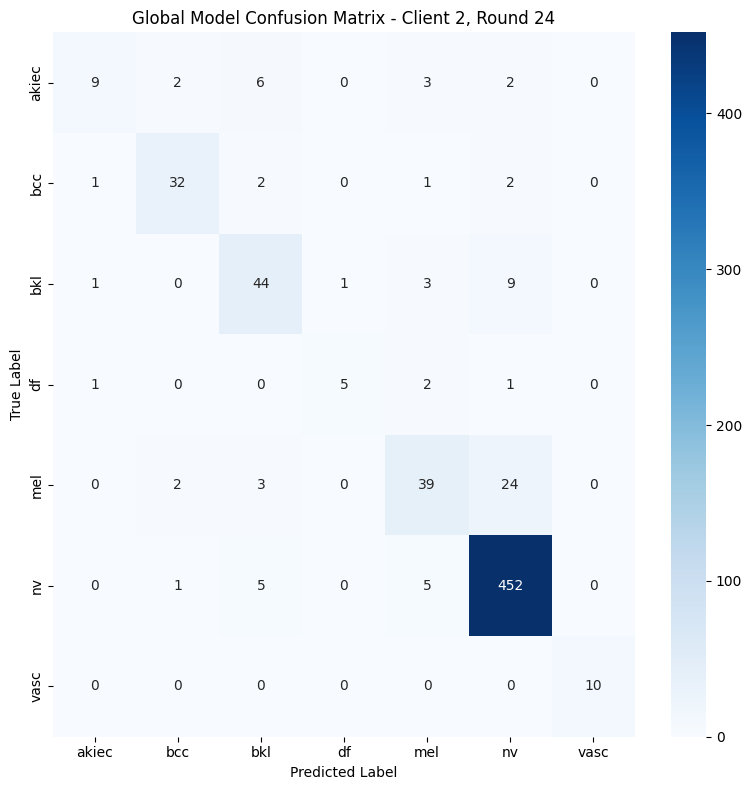


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.6729, Test Accuracy: 87.28%, F1-Score: 0.8673
Confusion Matrix:
 [[ 12   1   2   0   2   1   0]
 [  3  33   0   0   2   1   1]
 [  1   5  59   0   4  13   0]
 [  0   0   0   3   0   2   0]
 [  0   1   1   0  42  30   0]
 [  0   3   3   0   8 419   1]
 [  0   0   0   0   0   0  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.67      0.71        18
           1       0.77      0.82      0.80        40
           2       0.91      0.72      0.80        82
           3       1.00      0.60      0.75         5
           4       0.72      0.57      0.64        74
           5       0.90      0.97      0.93       434
           6       0.88      1.00      0.94        15

    accuracy                           0.87       668
   macro avg       0.85      0.76      0.79       668
weighted avg       0.87      0.87      0.87       668

Sensitivity/Recall:
 [0.66666667 0.825      0.7195122  0.6        0.56756757 0.9654

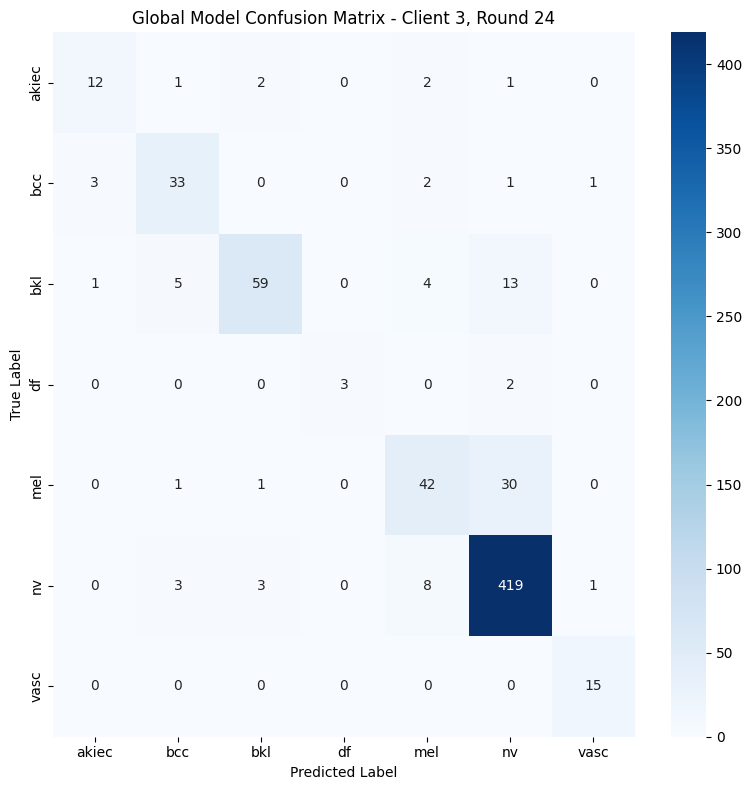


--- Round 25 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [04:00<00:00,  2.86s/it]


Client 1 Epoch 1: Train Loss: 0.1686, Train Accuracy: 98.05%


Client 1 Epoch 2: 100%|██████████| 84/84 [03:50<00:00,  2.74s/it]


Client 1 Epoch 2: Train Loss: 0.2568, Train Accuracy: 98.28%


Client 1 Epoch 3: 100%|██████████| 84/84 [03:50<00:00,  2.75s/it]


Client 1 Epoch 3: Train Loss: 0.2007, Train Accuracy: 99.29%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.53it/s]


Test Loss: 0.6644, Test Accuracy: 85.65%, F1-Score: 0.8519
Confusion Matrix:
 [[ 13   3   5   2   3   2   0]
 [  1  25   4   0   0   3   0]
 [  3   0  47   0   6  16   0]
 [  0   0   0  10   0   0   0]
 [  2   0   4   1  52  18   0]
 [  0   4   7   1   8 418   0]
 [  0   0   0   0   2   1   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.46      0.55        28
           1       0.78      0.76      0.77        33
           2       0.70      0.65      0.68        72
           3       0.71      1.00      0.83        10
           4       0.73      0.68      0.70        77
           5       0.91      0.95      0.93       438
           6       1.00      0.73      0.84        11

    accuracy                           0.86       669
   macro avg       0.79      0.75      0.76       669
weighted avg       0.85      0.86      0.85       669

Sensitivity/Recall:
 [0.46428571 0.75757576 0.65277778 1.         0.67532468 0.9543

Client 2 Epoch 1: 100%|██████████| 84/84 [05:24<00:00,  3.86s/it]


Client 2 Epoch 1: Train Loss: 0.1413, Train Accuracy: 98.84%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:15<00:00,  3.76s/it]


Client 2 Epoch 2: Train Loss: 0.3350, Train Accuracy: 97.38%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:15<00:00,  3.76s/it]


Client 2 Epoch 3: Train Loss: 0.1966, Train Accuracy: 99.51%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:40<00:00,  1.95s/it]


Test Loss: 0.6004, Test Accuracy: 85.48%, F1-Score: 0.8502
Confusion Matrix:
 [[  7   2   7   0   5   1   0]
 [  1  29   4   0   1   3   0]
 [  3   2  39   0   4  10   0]
 [  1   0   1   4   1   2   0]
 [  0   1   6   0  41  20   0]
 [  0   1   4   0  16 442   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.32      0.41        22
           1       0.83      0.76      0.79        38
           2       0.64      0.67      0.66        58
           3       1.00      0.44      0.62         9
           4       0.59      0.60      0.60        68
           5       0.92      0.95      0.94       463
           6       1.00      0.90      0.95        10

    accuracy                           0.85       668
   macro avg       0.80      0.67      0.71       668
weighted avg       0.85      0.85      0.85       668

Sensitivity/Recall:
 [0.31818182 0.76315789 0.67241379 0.44444444 0.60294118 0.9546

Client 3 Epoch 1: 100%|██████████| 84/84 [05:46<00:00,  4.13s/it]


Client 3 Epoch 1: Train Loss: 0.1444, Train Accuracy: 98.50%


Client 3 Epoch 2: 100%|██████████| 84/84 [05:45<00:00,  4.12s/it]


Client 3 Epoch 2: Train Loss: 0.1404, Train Accuracy: 99.14%


Client 3 Epoch 3: 100%|██████████| 84/84 [05:44<00:00,  4.10s/it]


Client 3 Epoch 3: Train Loss: 0.2862, Train Accuracy: 97.38%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Test Loss: 0.8037, Test Accuracy: 78.44%, F1-Score: 0.7929
Confusion Matrix:
 [[  7   1   4   0   6   0   0]
 [  4  31   2   0   3   0   0]
 [  1   5  51   0  13  12   0]
 [  0   0   2   1   1   1   0]
 [  0   0   1   0  51  22   0]
 [  0   3  11   0  49 370   1]
 [  0   0   0   0   1   1  13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.39      0.47        18
           1       0.78      0.78      0.78        40
           2       0.72      0.62      0.67        82
           3       1.00      0.20      0.33         5
           4       0.41      0.69      0.52        74
           5       0.91      0.85      0.88       434
           6       0.93      0.87      0.90        15

    accuracy                           0.78       668
   macro avg       0.76      0.63      0.65       668
weighted avg       0.82      0.78      0.79       668

Sensitivity/Recall:
 [0.38888889 0.775      0.62195122 0.2        0.68918919 0.8525

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.59it/s]

Test Loss: 0.5729, Test Accuracy: 87.14%, F1-Score: 0.8683
Confusion Matrix:
 [[ 13   1   5   1   6   2   0]
 [  0  24   3   0   0   6   0]
 [  1   0  55   0   4  12   0]
 [  0   0   2   8   0   0   0]
 [  1   0   3   0  58  15   0]
 [  0   2   6   0  12 418   0]
 [  0   0   0   0   3   1   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.46      0.60        28
           1       0.89      0.73      0.80        33
           2       0.74      0.76      0.75        72
           3       0.89      0.80      0.84        10
           4       0.70      0.75      0.72        77
           5       0.92      0.95      0.94       438
           6       1.00      0.64      0.78        11

    accuracy                           0.87       669
   macro avg       0.86      0.73      0.78       669
weighted avg       0.87      0.87      0.87       669

Sensitivity/Recall:
 [0.46428571 0.72727273 0.76388889 0.8        0.75324675 0.9543

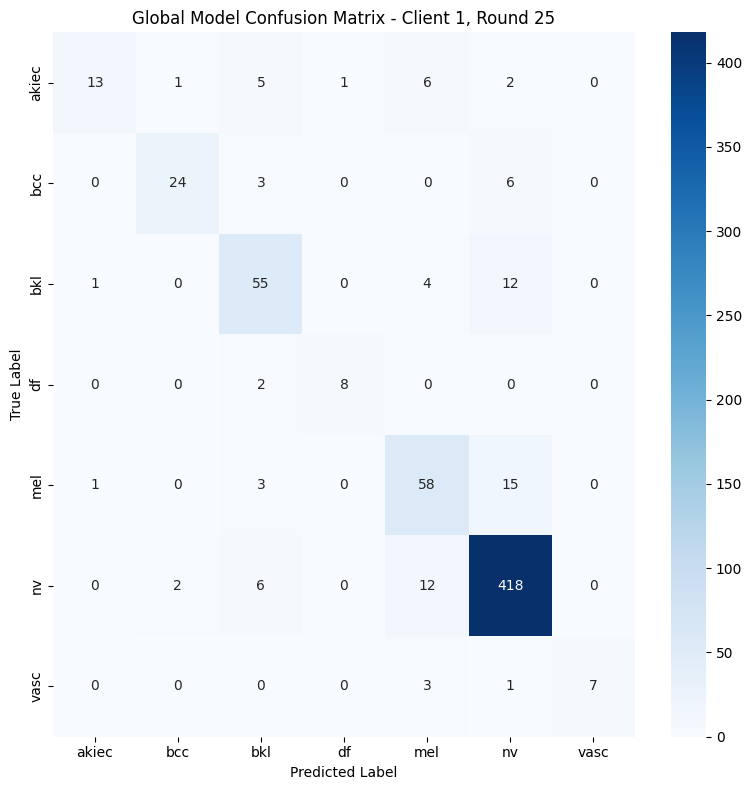


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]

Test Loss: 0.4680, Test Accuracy: 87.57%, F1-Score: 0.8706
Confusion Matrix:
 [[  7   2   6   0   5   2   0]
 [  1  31   3   0   1   2   0]
 [  0   1  41   0   5  11   0]
 [  1   0   0   6   1   1   0]
 [  0   2   4   0  44  18   0]
 [  0   1   2   0  13 447   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.32      0.45        22
           1       0.84      0.82      0.83        38
           2       0.73      0.71      0.72        58
           3       1.00      0.67      0.80         9
           4       0.63      0.65      0.64        68
           5       0.93      0.97      0.95       463
           6       1.00      0.90      0.95        10

    accuracy                           0.88       668
   macro avg       0.84      0.72      0.76       668
weighted avg       0.87      0.88      0.87       668

Sensitivity/Recall:
 [0.31818182 0.81578947 0.70689655 0.66666667 0.64705882 0.9654

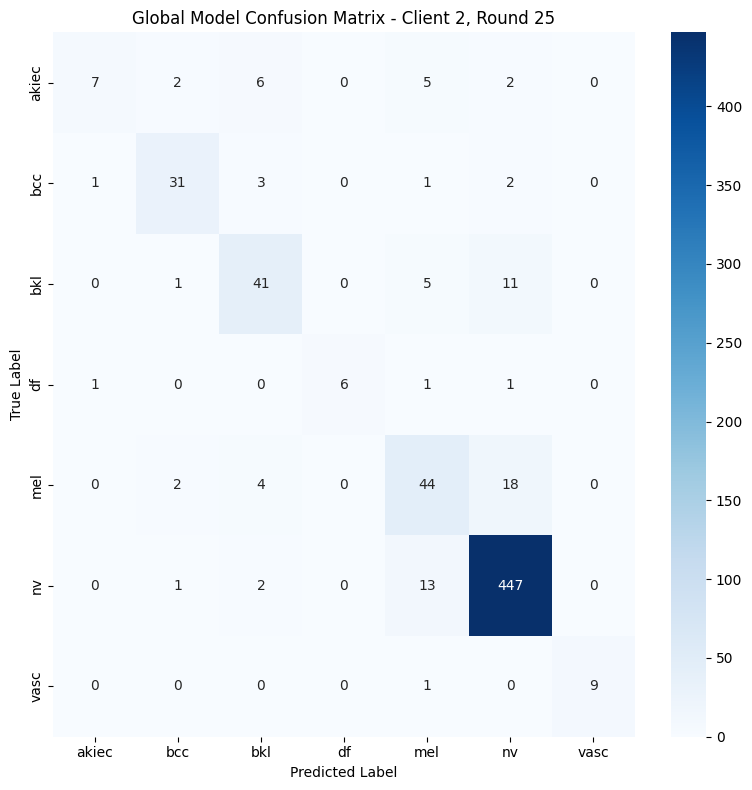


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]

Test Loss: 0.6333, Test Accuracy: 86.98%, F1-Score: 0.8649
Confusion Matrix:
 [[ 10   1   5   0   1   1   0]
 [  3  33   0   1   2   1   0]
 [  1   4  57   0   6  14   0]
 [  0   0   0   3   0   2   0]
 [  0   1   1   0  46  26   0]
 [  0   2   5   0   8 419   0]
 [  0   0   0   0   1   1  13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.56      0.62        18
           1       0.80      0.82      0.81        40
           2       0.84      0.70      0.76        82
           3       0.75      0.60      0.67         5
           4       0.72      0.62      0.67        74
           5       0.90      0.97      0.93       434
           6       1.00      0.87      0.93        15

    accuracy                           0.87       668
   macro avg       0.82      0.73      0.77       668
weighted avg       0.86      0.87      0.86       668

Sensitivity/Recall:
 [0.55555556 0.825      0.69512195 0.6        0.62162162 0.9654

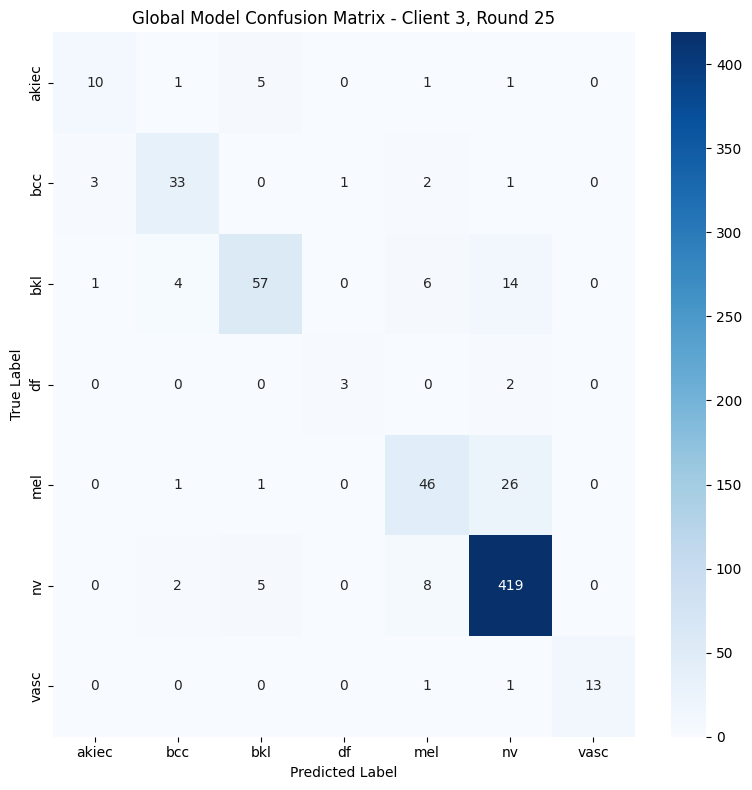


--- Round 26 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [03:52<00:00,  2.77s/it]


Client 1 Epoch 1: Train Loss: 0.1507, Train Accuracy: 98.62%


Client 1 Epoch 2: 100%|██████████| 84/84 [03:53<00:00,  2.78s/it]


Client 1 Epoch 2: Train Loss: 0.2704, Train Accuracy: 97.87%


Client 1 Epoch 3: 100%|██████████| 84/84 [03:52<00:00,  2.77s/it]


Client 1 Epoch 3: Train Loss: 0.3022, Train Accuracy: 98.47%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:20<00:00,  1.01it/s]


Test Loss: 0.6545, Test Accuracy: 85.05%, F1-Score: 0.8470
Confusion Matrix:
 [[ 16   1   4   0   4   2   1]
 [  0  19   3   1   3   5   2]
 [  3   0  47   0   8  14   0]
 [  0   0   1   9   0   0   0]
 [  2   0   2   0  52  19   2]
 [  0   1   9   0  11 415   2]
 [  0   0   0   0   0   0  11]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.57      0.65        28
           1       0.90      0.58      0.70        33
           2       0.71      0.65      0.68        72
           3       0.90      0.90      0.90        10
           4       0.67      0.68      0.67        77
           5       0.91      0.95      0.93       438
           6       0.61      1.00      0.76        11

    accuracy                           0.85       669
   macro avg       0.78      0.76      0.76       669
weighted avg       0.85      0.85      0.85       669

Sensitivity/Recall:
 [0.57142857 0.57575758 0.65277778 0.9        0.67532468 0.9474

Client 2 Epoch 1: 100%|██████████| 84/84 [05:47<00:00,  4.14s/it]


Client 2 Epoch 1: Train Loss: 0.1461, Train Accuracy: 98.69%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:47<00:00,  4.13s/it]


Client 2 Epoch 2: Train Loss: 0.2906, Train Accuracy: 97.49%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:47<00:00,  4.13s/it]


Client 2 Epoch 3: Train Loss: 0.2580, Train Accuracy: 98.65%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:43<00:00,  2.06s/it]


Test Loss: 0.5245, Test Accuracy: 85.33%, F1-Score: 0.8493
Confusion Matrix:
 [[ 13   0   4   0   4   1   0]
 [  2  27   4   0   1   4   0]
 [  2   1  45   0   3   7   0]
 [  3   0   0   2   0   4   0]
 [  1   2   7   0  42  16   0]
 [  0   2   8   0  16 437   0]
 [  0   0   0   0   2   4   4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.59      0.60        22
           1       0.84      0.71      0.77        38
           2       0.66      0.78      0.71        58
           3       1.00      0.22      0.36         9
           4       0.62      0.62      0.62        68
           5       0.92      0.94      0.93       463
           6       1.00      0.40      0.57        10

    accuracy                           0.85       668
   macro avg       0.81      0.61      0.65       668
weighted avg       0.86      0.85      0.85       668

Sensitivity/Recall:
 [0.59090909 0.71052632 0.77586207 0.22222222 0.61764706 0.9438

Client 3 Epoch 1: 100%|██████████| 84/84 [05:26<00:00,  3.89s/it]


Client 3 Epoch 1: Train Loss: 0.1426, Train Accuracy: 98.73%


Client 3 Epoch 2: 100%|██████████| 84/84 [05:27<00:00,  3.90s/it]


Client 3 Epoch 2: Train Loss: 0.2653, Train Accuracy: 98.13%


Client 3 Epoch 3: 100%|██████████| 84/84 [05:27<00:00,  3.90s/it]


Client 3 Epoch 3: Train Loss: 0.2364, Train Accuracy: 98.46%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:15<00:00,  1.34it/s]


Test Loss: 0.7369, Test Accuracy: 81.44%, F1-Score: 0.8030
Confusion Matrix:
 [[  9   0   4   0   4   1   0]
 [  7  18   3   0   3   9   0]
 [  0   3  54   0   8  17   0]
 [  0   0   0   3   0   2   0]
 [  0   0   1   0  35  38   0]
 [  0   2   5   0  10 417   0]
 [  0   0   1   1   3   2   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.50      0.53        18
           1       0.78      0.45      0.57        40
           2       0.79      0.66      0.72        82
           3       0.75      0.60      0.67         5
           4       0.56      0.47      0.51        74
           5       0.86      0.96      0.91       434
           6       1.00      0.53      0.70        15

    accuracy                           0.81       668
   macro avg       0.76      0.60      0.66       668
weighted avg       0.81      0.81      0.80       668

Sensitivity/Recall:
 [0.5        0.45       0.65853659 0.6        0.47297297 0.9608

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.59it/s]

Test Loss: 0.5687, Test Accuracy: 86.40%, F1-Score: 0.8604
Confusion Matrix:
 [[ 13   1   5   0   6   3   0]
 [  1  20   3   0   1   8   0]
 [  1   0  54   0   5  12   0]
 [  0   0   2   8   0   0   0]
 [  1   0   2   0  59  15   0]
 [  0   1   8   0  12 417   0]
 [  0   0   1   0   2   1   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.46      0.59        28
           1       0.91      0.61      0.73        33
           2       0.72      0.75      0.73        72
           3       1.00      0.80      0.89        10
           4       0.69      0.77      0.73        77
           5       0.91      0.95      0.93       438
           6       1.00      0.64      0.78        11

    accuracy                           0.86       669
   macro avg       0.86      0.71      0.77       669
weighted avg       0.87      0.86      0.86       669

Sensitivity/Recall:
 [0.46428571 0.60606061 0.75       0.8        0.76623377 0.9520

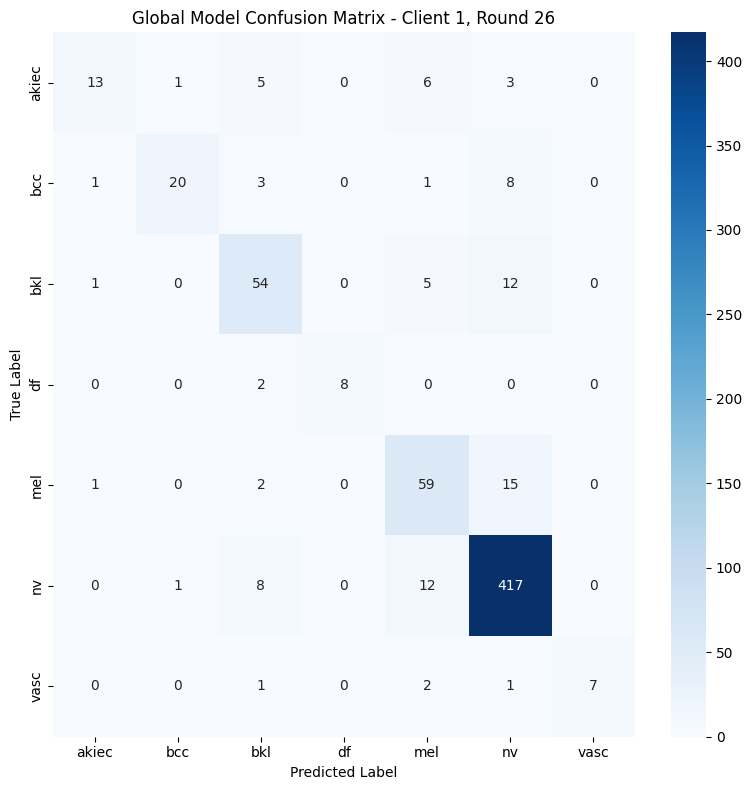


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.4930, Test Accuracy: 86.68%, F1-Score: 0.8625
Confusion Matrix:
 [[  9   1   5   0   6   1   0]
 [  2  27   3   0   2   4   0]
 [  0   0  43   0   5  10   0]
 [  1   0   0   4   2   2   0]
 [  0   2   5   0  42  19   0]
 [  0   1   7   0  10 445   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.41      0.53        22
           1       0.87      0.71      0.78        38
           2       0.68      0.74      0.71        58
           3       1.00      0.44      0.62         9
           4       0.62      0.62      0.62        68
           5       0.93      0.96      0.94       463
           6       1.00      0.90      0.95        10

    accuracy                           0.87       668
   macro avg       0.84      0.68      0.74       668
weighted avg       0.87      0.87      0.86       668

Sensitivity/Recall:
 [0.40909091 0.71052632 0.74137931 0.44444444 0.61764706 0.9611

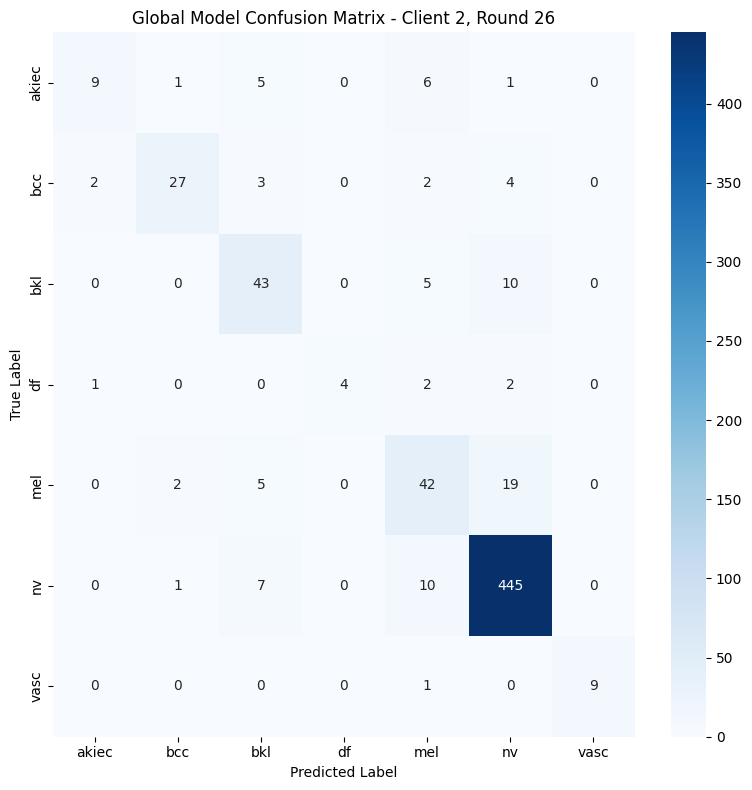


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]

Test Loss: 0.5893, Test Accuracy: 86.68%, F1-Score: 0.8612
Confusion Matrix:
 [[ 10   1   3   0   3   1   0]
 [  3  34   0   1   1   1   0]
 [  0   3  60   0   7  12   0]
 [  0   0   1   2   0   2   0]
 [  0   0   2   0  42  30   0]
 [  0   3   5   0   9 417   0]
 [  0   0   1   0   0   0  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.56      0.65        18
           1       0.83      0.85      0.84        40
           2       0.83      0.73      0.78        82
           3       0.67      0.40      0.50         5
           4       0.68      0.57      0.62        74
           5       0.90      0.96      0.93       434
           6       1.00      0.93      0.97        15

    accuracy                           0.87       668
   macro avg       0.81      0.71      0.75       668
weighted avg       0.86      0.87      0.86       668

Sensitivity/Recall:
 [0.55555556 0.85       0.73170732 0.4        0.56756757 0.9608

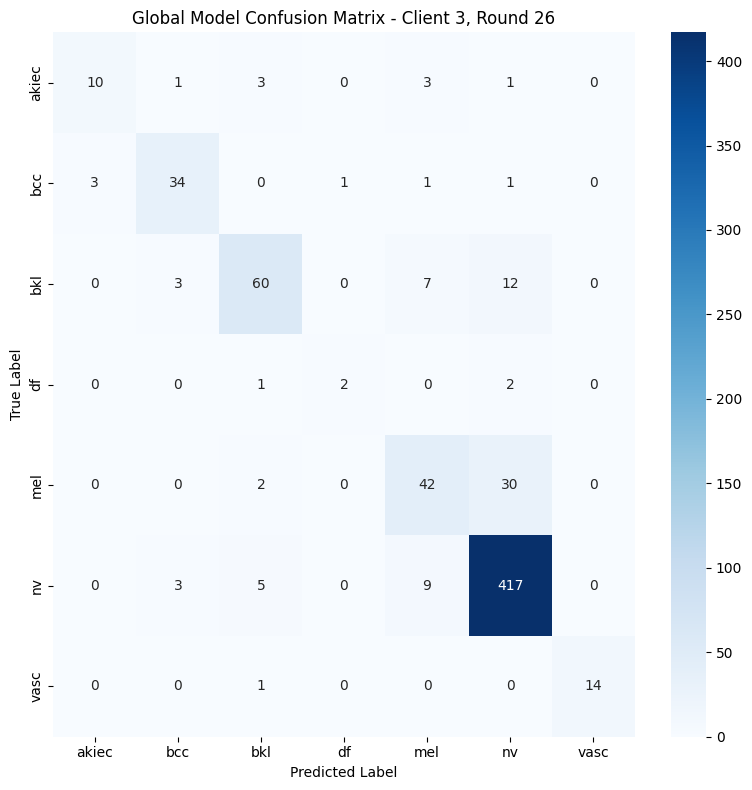


--- Round 27 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [03:42<00:00,  2.65s/it]


Client 1 Epoch 1: Train Loss: 0.1528, Train Accuracy: 98.80%


Client 1 Epoch 2: 100%|██████████| 84/84 [03:42<00:00,  2.65s/it]


Client 1 Epoch 2: Train Loss: 0.2683, Train Accuracy: 98.20%


Client 1 Epoch 3: 100%|██████████| 84/84 [03:42<00:00,  2.65s/it]


Client 1 Epoch 3: Train Loss: 0.2773, Train Accuracy: 98.47%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:28<00:00,  1.36s/it]


Test Loss: 0.7077, Test Accuracy: 84.75%, F1-Score: 0.8433
Confusion Matrix:
 [[ 15   3   0   0   8   2   0]
 [  2  20   2   0   3   5   1]
 [  4   0  41   0   8  19   0]
 [  0   1   0   9   0   0   0]
 [  1   0   0   0  57  19   0]
 [  0   0   8   0  14 416   0]
 [  0   0   0   0   2   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.54      0.60        28
           1       0.83      0.61      0.70        33
           2       0.80      0.57      0.67        72
           3       1.00      0.90      0.95        10
           4       0.62      0.74      0.67        77
           5       0.90      0.95      0.93       438
           6       0.90      0.82      0.86        11

    accuracy                           0.85       669
   macro avg       0.82      0.73      0.77       669
weighted avg       0.85      0.85      0.84       669

Sensitivity/Recall:
 [0.53571429 0.60606061 0.56944444 0.9        0.74025974 0.9497

Client 2 Epoch 1: 100%|██████████| 84/84 [05:24<00:00,  3.86s/it]


Client 2 Epoch 1: Train Loss: 0.1494, Train Accuracy: 98.46%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:24<00:00,  3.87s/it]


Client 2 Epoch 2: Train Loss: 0.3219, Train Accuracy: 97.83%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:25<00:00,  3.87s/it]


Client 2 Epoch 3: Train Loss: 0.2361, Train Accuracy: 99.14%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:43<00:00,  2.06s/it]


Test Loss: 0.5003, Test Accuracy: 87.43%, F1-Score: 0.8706
Confusion Matrix:
 [[ 12   2   4   0   2   2   0]
 [  2  30   4   0   0   2   0]
 [  1   0  42   1   7   7   0]
 [  2   1   0   3   2   1   0]
 [  0   3   5   0  42  18   0]
 [  0   2   5   0  10 446   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.55      0.62        22
           1       0.79      0.79      0.79        38
           2       0.70      0.72      0.71        58
           3       0.75      0.33      0.46         9
           4       0.66      0.62      0.64        68
           5       0.94      0.96      0.95       463
           6       1.00      0.90      0.95        10

    accuracy                           0.87       668
   macro avg       0.79      0.70      0.73       668
weighted avg       0.87      0.87      0.87       668

Sensitivity/Recall:
 [0.54545455 0.78947368 0.72413793 0.33333333 0.61764706 0.9632

Client 3 Epoch 1: 100%|██████████| 84/84 [05:10<00:00,  3.70s/it]


Client 3 Epoch 1: Train Loss: 0.1446, Train Accuracy: 98.54%


Client 3 Epoch 2: 100%|██████████| 84/84 [05:11<00:00,  3.70s/it]


Client 3 Epoch 2: Train Loss: 0.3125, Train Accuracy: 97.71%


Client 3 Epoch 3: 100%|██████████| 84/84 [05:11<00:00,  3.70s/it]


Client 3 Epoch 3: Train Loss: 0.2030, Train Accuracy: 99.48%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:21<00:00,  1.02s/it]


Test Loss: 0.7826, Test Accuracy: 83.68%, F1-Score: 0.8269
Confusion Matrix:
 [[  8   2   4   0   2   2   0]
 [  2  33   1   1   2   1   0]
 [  0   5  53   0   6  18   0]
 [  0   0   0   3   0   2   0]
 [  0   1   1   0  34  38   0]
 [  0   5   6   0   9 413   1]
 [  0   0   0   0   0   0  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.44      0.57        18
           1       0.72      0.82      0.77        40
           2       0.82      0.65      0.72        82
           3       0.75      0.60      0.67         5
           4       0.64      0.46      0.54        74
           5       0.87      0.95      0.91       434
           6       0.94      1.00      0.97        15

    accuracy                           0.84       668
   macro avg       0.79      0.70      0.73       668
weighted avg       0.83      0.84      0.83       668

Sensitivity/Recall:
 [0.44444444 0.825      0.64634146 0.6        0.45945946 0.9516

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.60it/s]


Test Loss: 0.5689, Test Accuracy: 86.55%, F1-Score: 0.8620
Confusion Matrix:
 [[ 13   1   4   0   6   4   0]
 [  1  20   5   0   1   5   1]
 [  1   0  54   0   6  11   0]
 [  0   0   1   9   0   0   0]
 [  1   0   3   0  57  16   0]
 [  0   1   8   0  11 417   1]
 [  0   0   0   0   1   1   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.46      0.59        28
           1       0.91      0.61      0.73        33
           2       0.72      0.75      0.73        72
           3       1.00      0.90      0.95        10
           4       0.70      0.74      0.72        77
           5       0.92      0.95      0.93       438
           6       0.82      0.82      0.82        11

    accuracy                           0.87       669
   macro avg       0.84      0.75      0.78       669
weighted avg       0.87      0.87      0.86       669

Sensitivity/Recall:
 [0.46428571 0.60606061 0.75       0.9        0.74025974 0.9520

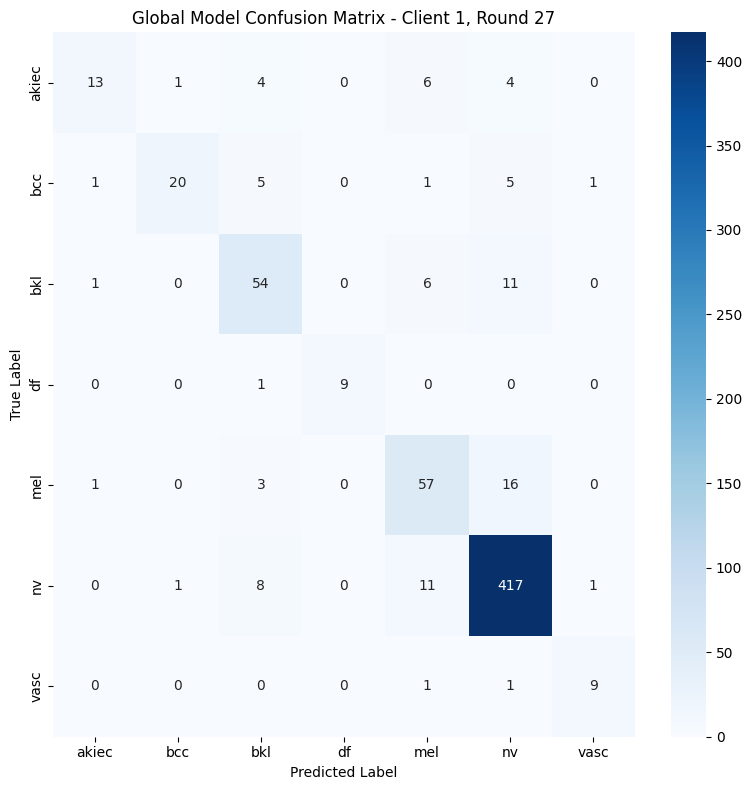


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.61it/s]

Test Loss: 0.4971, Test Accuracy: 88.02%, F1-Score: 0.8744
Confusion Matrix:
 [[ 10   1   6   0   3   2   0]
 [  0  32   1   0   1   4   0]
 [  0   1  40   1   7   9   0]
 [  0   0   0   6   2   1   0]
 [  0   1   5   0  39  23   0]
 [  0   1   3   0   8 451   0]
 [  0   0   0   0   0   0  10]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.45      0.62        22
           1       0.89      0.84      0.86        38
           2       0.73      0.69      0.71        58
           3       0.86      0.67      0.75         9
           4       0.65      0.57      0.61        68
           5       0.92      0.97      0.95       463
           6       1.00      1.00      1.00        10

    accuracy                           0.88       668
   macro avg       0.86      0.74      0.79       668
weighted avg       0.88      0.88      0.87       668

Sensitivity/Recall:
 [0.45454545 0.84210526 0.68965517 0.66666667 0.57352941 0.9740

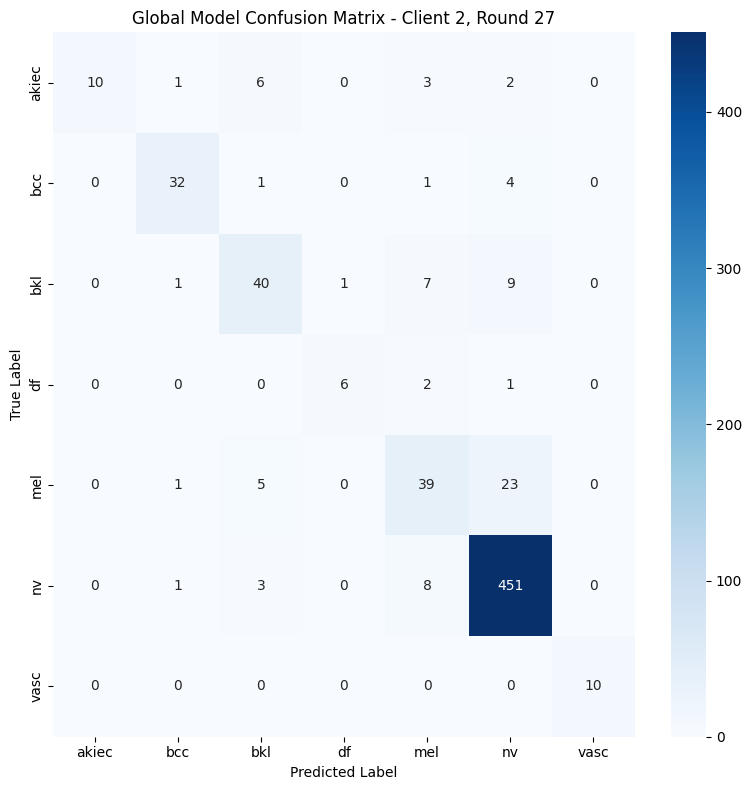


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.61it/s]

Test Loss: 0.6352, Test Accuracy: 85.63%, F1-Score: 0.8480
Confusion Matrix:
 [[  8   1   5   0   3   1   0]
 [  2  33   0   1   2   1   1]
 [  0   3  58   0   4  17   0]
 [  0   0   0   3   0   2   0]
 [  0   1   1   0  38  34   0]
 [  0   5   3   0   8 417   1]
 [  0   0   0   0   0   0  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.44      0.57        18
           1       0.77      0.82      0.80        40
           2       0.87      0.71      0.78        82
           3       0.75      0.60      0.67         5
           4       0.69      0.51      0.59        74
           5       0.88      0.96      0.92       434
           6       0.88      1.00      0.94        15

    accuracy                           0.86       668
   macro avg       0.81      0.72      0.75       668
weighted avg       0.85      0.86      0.85       668

Sensitivity/Recall:
 [0.44444444 0.825      0.70731707 0.6        0.51351351 0.9608

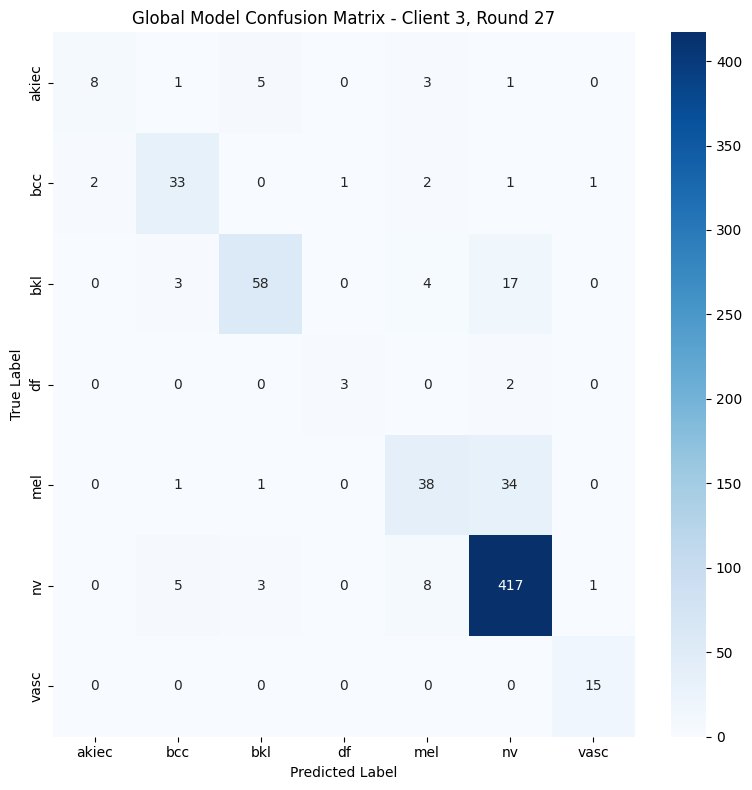


--- Round 28 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [04:01<00:00,  2.87s/it]


Client 1 Epoch 1: Train Loss: 0.1688, Train Accuracy: 98.50%


Client 1 Epoch 2: 100%|██████████| 84/84 [04:01<00:00,  2.88s/it]


Client 1 Epoch 2: Train Loss: 0.2340, Train Accuracy: 98.28%


Client 1 Epoch 3: 100%|██████████| 84/84 [04:01<00:00,  2.88s/it]


Client 1 Epoch 3: Train Loss: 0.2122, Train Accuracy: 99.03%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:28<00:00,  1.37s/it]


Test Loss: 0.8548, Test Accuracy: 83.41%, F1-Score: 0.8232
Confusion Matrix:
 [[ 13   2   2   0   7   4   0]
 [  1  19   3   0   2   7   1]
 [  2   0  30   0  18  22   0]
 [  0   0   1   8   0   1   0]
 [  0   0   0   0  57  20   0]
 [  0   0   2   0  12 424   0]
 [  0   0   1   0   1   2   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.46      0.59        28
           1       0.90      0.58      0.70        33
           2       0.77      0.42      0.54        72
           3       1.00      0.80      0.89        10
           4       0.59      0.74      0.66        77
           5       0.88      0.97      0.92       438
           6       0.88      0.64      0.74        11

    accuracy                           0.83       669
   macro avg       0.83      0.66      0.72       669
weighted avg       0.84      0.83      0.82       669

Sensitivity/Recall:
 [0.46428571 0.57575758 0.41666667 0.8        0.74025974 0.9680

Client 2 Epoch 1: 100%|██████████| 84/84 [05:24<00:00,  3.86s/it]


Client 2 Epoch 1: Train Loss: 0.1512, Train Accuracy: 98.65%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:23<00:00,  3.86s/it]


Client 2 Epoch 2: Train Loss: 0.1875, Train Accuracy: 98.88%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:23<00:00,  3.86s/it]


Client 2 Epoch 3: Train Loss: 0.2053, Train Accuracy: 98.88%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:40<00:00,  1.95s/it]


Test Loss: 0.6761, Test Accuracy: 85.93%, F1-Score: 0.8525
Confusion Matrix:
 [[ 10   5   4   0   0   3   0]
 [  1  34   3   0   0   0   0]
 [  1   1  49   0   1   6   0]
 [  1   2   0   5   1   0   0]
 [  1   3   9   0  29  26   0]
 [  2   2  10   0  11 438   0]
 [  0   0   1   0   0   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.45      0.53        22
           1       0.72      0.89      0.80        38
           2       0.64      0.84      0.73        58
           3       1.00      0.56      0.71         9
           4       0.69      0.43      0.53        68
           5       0.93      0.95      0.94       463
           6       1.00      0.90      0.95        10

    accuracy                           0.86       668
   macro avg       0.80      0.72      0.74       668
weighted avg       0.86      0.86      0.85       668

Sensitivity/Recall:
 [0.45454545 0.89473684 0.84482759 0.55555556 0.42647059 0.9460

Client 3 Epoch 1: 100%|██████████| 84/84 [06:01<00:00,  4.30s/it]


Client 3 Epoch 1: Train Loss: 0.1733, Train Accuracy: 98.20%


Client 3 Epoch 2: 100%|██████████| 84/84 [06:02<00:00,  4.31s/it]


Client 3 Epoch 2: Train Loss: 0.2434, Train Accuracy: 98.84%


Client 3 Epoch 3: 100%|██████████| 84/84 [06:02<00:00,  4.31s/it]


Client 3 Epoch 3: Train Loss: 0.1377, Train Accuracy: 99.51%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Test Loss: 0.6790, Test Accuracy: 85.48%, F1-Score: 0.8501
Confusion Matrix:
 [[ 12   1   2   0   2   1   0]
 [  3  33   1   1   2   0   0]
 [  1   6  62   0   2  11   0]
 [  0   0   0   4   0   1   0]
 [  0   2   3   0  37  32   0]
 [  0   6   6   0  13 409   0]
 [  0   0   1   0   0   0  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.67      0.71        18
           1       0.69      0.82      0.75        40
           2       0.83      0.76      0.79        82
           3       0.80      0.80      0.80         5
           4       0.66      0.50      0.57        74
           5       0.90      0.94      0.92       434
           6       1.00      0.93      0.97        15

    accuracy                           0.85       668
   macro avg       0.80      0.77      0.79       668
weighted avg       0.85      0.85      0.85       668

Sensitivity/Recall:
 [0.66666667 0.825      0.75609756 0.8        0.5        0.9423

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.5458, Test Accuracy: 86.70%, F1-Score: 0.8627
Confusion Matrix:
 [[ 15   1   5   0   4   3   0]
 [  0  21   6   0   0   6   0]
 [  2   0  50   0   6  14   0]
 [  0   0   2   8   0   0   0]
 [  2   0   1   0  55  18   1]
 [  0   1   6   1   8 422   0]
 [  0   0   1   0   0   1   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.54      0.64        28
           1       0.91      0.64      0.75        33
           2       0.70      0.69      0.70        72
           3       0.89      0.80      0.84        10
           4       0.75      0.71      0.73        77
           5       0.91      0.96      0.94       438
           6       0.90      0.82      0.86        11

    accuracy                           0.87       669
   macro avg       0.84      0.74      0.78       669
weighted avg       0.86      0.87      0.86       669

Sensitivity/Recall:
 [0.53571429 0.63636364 0.69444444 0.8        0.71428571 0.9634

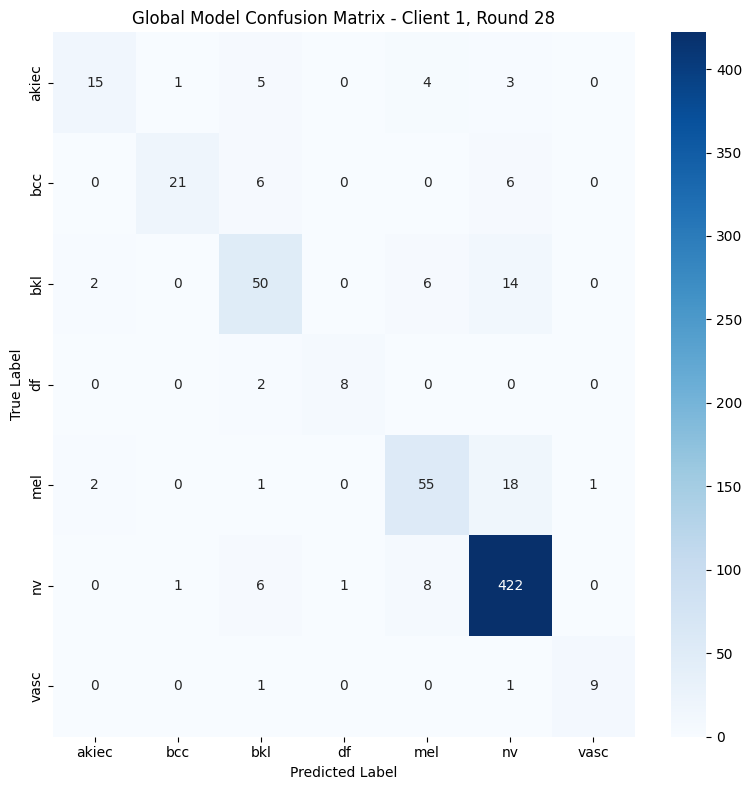


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.61it/s]

Test Loss: 0.5338, Test Accuracy: 87.87%, F1-Score: 0.8722
Confusion Matrix:
 [[  9   2   7   0   1   3   0]
 [  2  33   2   0   0   1   0]
 [  0   2  41   0   5  10   0]
 [  2   0   0   5   1   1   0]
 [  0   2   5   0  39  22   0]
 [  0   2   2   0   9 450   0]
 [  0   0   0   0   0   0  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.41      0.51        22
           1       0.80      0.87      0.84        38
           2       0.72      0.71      0.71        58
           3       1.00      0.56      0.71         9
           4       0.71      0.57      0.63        68
           5       0.92      0.97      0.95       463
           6       1.00      1.00      1.00        10

    accuracy                           0.88       668
   macro avg       0.84      0.73      0.77       668
weighted avg       0.87      0.88      0.87       668

Sensitivity/Recall:
 [0.40909091 0.86842105 0.70689655 0.55555556 0.57352941 0.9719

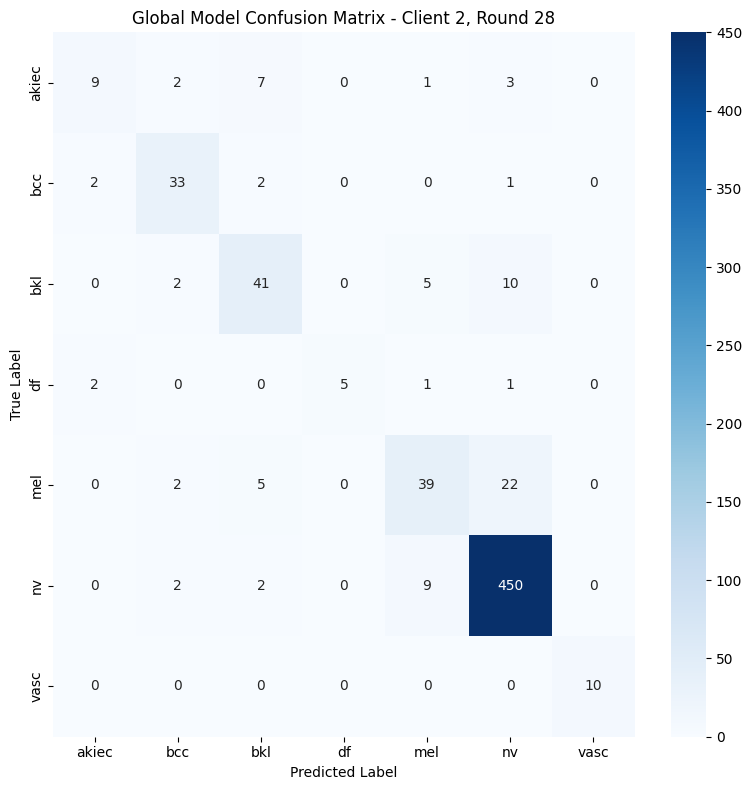


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:12<00:00,  1.63it/s]

Test Loss: 0.6924, Test Accuracy: 85.18%, F1-Score: 0.8435
Confusion Matrix:
 [[ 12   1   1   0   3   1   0]
 [  2  31   1   1   2   2   1]
 [  0   4  56   0   6  16   0]
 [  0   0   0   3   0   2   0]
 [  0   1   2   0  35  36   0]
 [  0   2   6   0   8 417   1]
 [  0   0   0   0   0   0  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.67      0.75        18
           1       0.79      0.78      0.78        40
           2       0.85      0.68      0.76        82
           3       0.75      0.60      0.67         5
           4       0.65      0.47      0.55        74
           5       0.88      0.96      0.92       434
           6       0.88      1.00      0.94        15

    accuracy                           0.85       668
   macro avg       0.81      0.74      0.77       668
weighted avg       0.84      0.85      0.84       668

Sensitivity/Recall:
 [0.66666667 0.775      0.68292683 0.6        0.47297297 0.9608

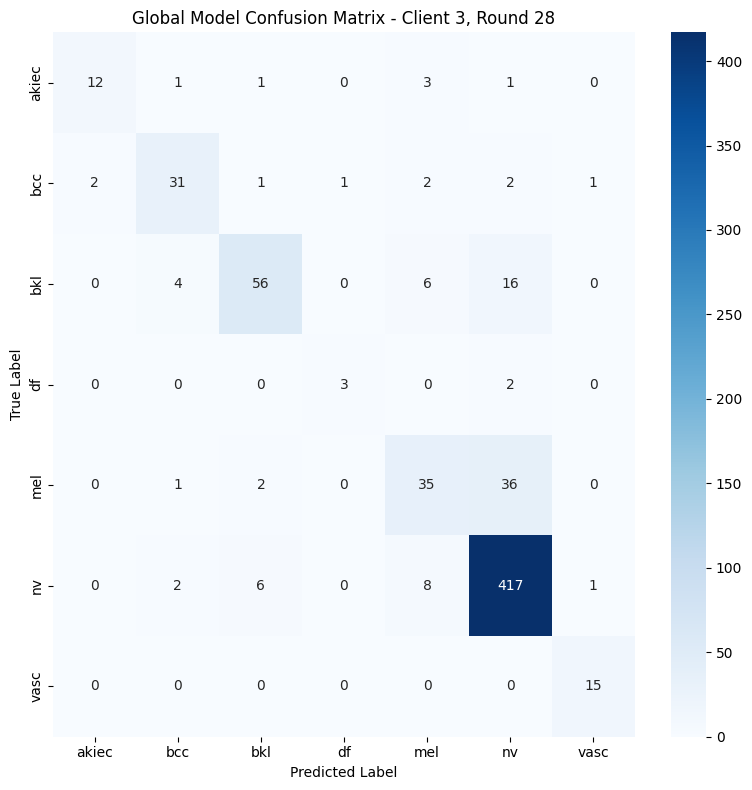


--- Round 29 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [04:00<00:00,  2.86s/it]


Client 1 Epoch 1: Train Loss: 0.1406, Train Accuracy: 98.73%


Client 1 Epoch 2: 100%|██████████| 84/84 [04:00<00:00,  2.87s/it]


Client 1 Epoch 2: Train Loss: 0.2495, Train Accuracy: 98.62%


Client 1 Epoch 3: 100%|██████████| 84/84 [04:00<00:00,  2.87s/it]


Client 1 Epoch 3: Train Loss: 0.2791, Train Accuracy: 98.24%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it]


Test Loss: 0.7530, Test Accuracy: 83.26%, F1-Score: 0.8261
Confusion Matrix:
 [[ 12   4   6   0   4   1   1]
 [  0  19   3   0   1   9   1]
 [  0   0  50   0   2  20   0]
 [  0   0   3   7   0   0   0]
 [  4   0   5   0  45  22   1]
 [  0   0  11   0  12 413   2]
 [  0   0   0   0   0   0  11]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.43      0.55        28
           1       0.83      0.58      0.68        33
           2       0.64      0.69      0.67        72
           3       1.00      0.70      0.82        10
           4       0.70      0.58      0.64        77
           5       0.89      0.94      0.91       438
           6       0.69      1.00      0.81        11

    accuracy                           0.83       669
   macro avg       0.79      0.70      0.73       669
weighted avg       0.83      0.83      0.83       669

Sensitivity/Recall:
 [0.42857143 0.57575758 0.69444444 0.7        0.58441558 0.9429

Client 2 Epoch 1: 100%|██████████| 84/84 [05:08<00:00,  3.67s/it]


Client 2 Epoch 1: Train Loss: 0.1453, Train Accuracy: 98.76%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:08<00:00,  3.67s/it]


Client 2 Epoch 2: Train Loss: 0.2593, Train Accuracy: 98.28%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:09<00:00,  3.68s/it]


Client 2 Epoch 3: Train Loss: 0.2965, Train Accuracy: 98.28%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:39<00:00,  1.88s/it]


Test Loss: 0.6594, Test Accuracy: 84.58%, F1-Score: 0.8350
Confusion Matrix:
 [[ 10   0   6   0   2   4   0]
 [  2  27   1   0   1   7   0]
 [  1   1  38   0   2  16   0]
 [  1   0   1   4   1   2   0]
 [  0   4   4   0  31  29   0]
 [  1   1   4   0   9 448   0]
 [  0   0   1   0   0   2   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.45      0.54        22
           1       0.82      0.71      0.76        38
           2       0.69      0.66      0.67        58
           3       1.00      0.44      0.62         9
           4       0.67      0.46      0.54        68
           5       0.88      0.97      0.92       463
           6       1.00      0.70      0.82        10

    accuracy                           0.85       668
   macro avg       0.82      0.63      0.70       668
weighted avg       0.84      0.85      0.84       668

Sensitivity/Recall:
 [0.45454545 0.71052632 0.65517241 0.44444444 0.45588235 0.9676

Client 3 Epoch 1: 100%|██████████| 84/84 [05:24<00:00,  3.87s/it]


Client 3 Epoch 1: Train Loss: 0.1519, Train Accuracy: 98.65%


Client 3 Epoch 2: 100%|██████████| 84/84 [05:25<00:00,  3.87s/it]


Client 3 Epoch 2: Train Loss: 0.1833, Train Accuracy: 98.43%


Client 3 Epoch 3: 100%|██████████| 84/84 [05:25<00:00,  3.87s/it]


Client 3 Epoch 3: Train Loss: 0.3526, Train Accuracy: 97.64%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:12<00:00,  1.67it/s]


Test Loss: 0.7472, Test Accuracy: 82.63%, F1-Score: 0.8201
Confusion Matrix:
 [[ 14   2   0   0   1   1   0]
 [  3  34   1   0   0   0   2]
 [  1   6  55   0   6  14   0]
 [  0   0   0   3   0   2   0]
 [  2   1   4   0  34  33   0]
 [  1   9   8   0  13 403   0]
 [  0   0   1   1   0   4   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.78      0.72        18
           1       0.65      0.85      0.74        40
           2       0.80      0.67      0.73        82
           3       0.75      0.60      0.67         5
           4       0.63      0.46      0.53        74
           5       0.88      0.93      0.90       434
           6       0.82      0.60      0.69        15

    accuracy                           0.83       668
   macro avg       0.74      0.70      0.71       668
weighted avg       0.82      0.83      0.82       668

Sensitivity/Recall:
 [0.77777778 0.85       0.67073171 0.6        0.45945946 0.9285

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.60it/s]

Test Loss: 0.6037, Test Accuracy: 85.05%, F1-Score: 0.8458
Confusion Matrix:
 [[ 13   1   7   0   5   2   0]
 [  0  20   5   0   0   8   0]
 [  1   0  53   0   1  17   0]
 [  0   0   2   8   0   0   0]
 [  3   0   3   0  50  21   0]
 [  0   2  12   0   7 417   0]
 [  0   0   1   0   1   1   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.46      0.58        28
           1       0.87      0.61      0.71        33
           2       0.64      0.74      0.68        72
           3       1.00      0.80      0.89        10
           4       0.78      0.65      0.71        77
           5       0.89      0.95      0.92       438
           6       1.00      0.73      0.84        11

    accuracy                           0.85       669
   macro avg       0.85      0.71      0.76       669
weighted avg       0.85      0.85      0.85       669

Sensitivity/Recall:
 [0.46428571 0.60606061 0.73611111 0.8        0.64935065 0.9520

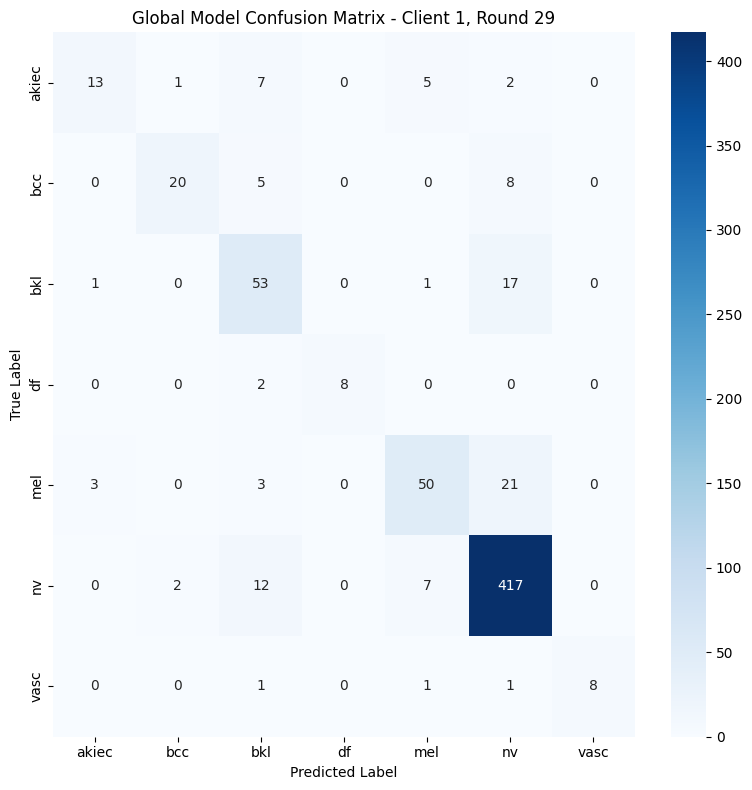


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.61it/s]

Test Loss: 0.5405, Test Accuracy: 87.57%, F1-Score: 0.8696
Confusion Matrix:
 [[ 10   2   5   0   1   4   0]
 [  1  31   3   0   1   2   0]
 [  0   1  44   0   2  11   0]
 [  1   0   0   5   2   1   0]
 [  0   4   7   0  37  20   0]
 [  0   1   4   0   9 449   0]
 [  0   0   1   0   0   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.45      0.59        22
           1       0.79      0.82      0.81        38
           2       0.69      0.76      0.72        58
           3       1.00      0.56      0.71         9
           4       0.71      0.54      0.62        68
           5       0.92      0.97      0.95       463
           6       1.00      0.90      0.95        10

    accuracy                           0.88       668
   macro avg       0.85      0.71      0.76       668
weighted avg       0.87      0.88      0.87       668

Sensitivity/Recall:
 [0.45454545 0.81578947 0.75862069 0.55555556 0.54411765 0.9697

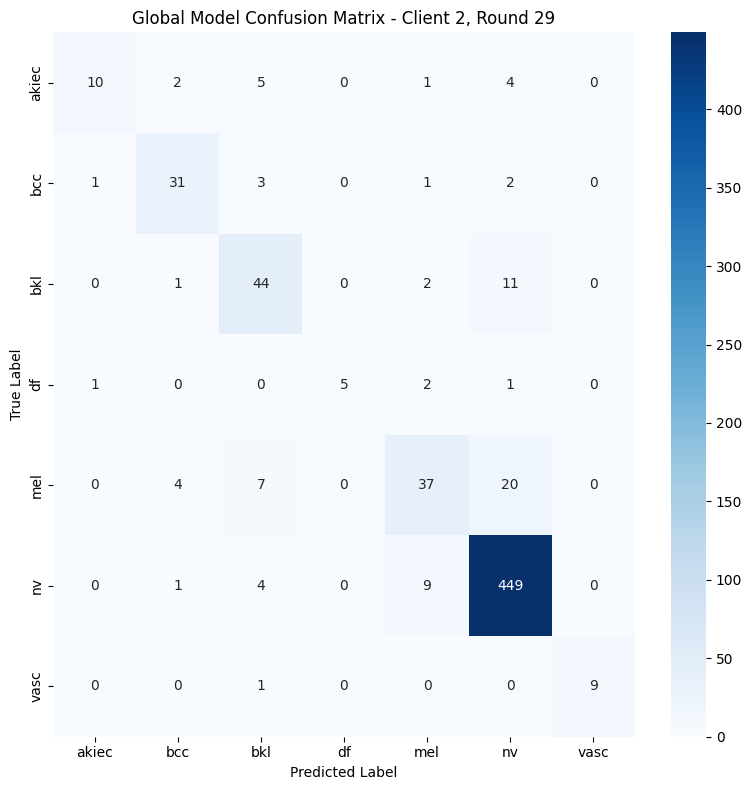


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:12<00:00,  1.62it/s]

Test Loss: 0.6490, Test Accuracy: 85.18%, F1-Score: 0.8434
Confusion Matrix:
 [[ 13   1   1   0   2   1   0]
 [  2  30   2   0   1   3   2]
 [  1   4  56   0   6  15   0]
 [  0   0   0   3   0   2   0]
 [  0   1   3   0  35  35   0]
 [  0   1   6   0   9 418   0]
 [  0   0   0   0   0   1  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.72      0.76        18
           1       0.81      0.75      0.78        40
           2       0.82      0.68      0.75        82
           3       1.00      0.60      0.75         5
           4       0.66      0.47      0.55        74
           5       0.88      0.96      0.92       434
           6       0.88      0.93      0.90        15

    accuracy                           0.85       668
   macro avg       0.84      0.73      0.77       668
weighted avg       0.84      0.85      0.84       668

Sensitivity/Recall:
 [0.72222222 0.75       0.68292683 0.6        0.47297297 0.9631

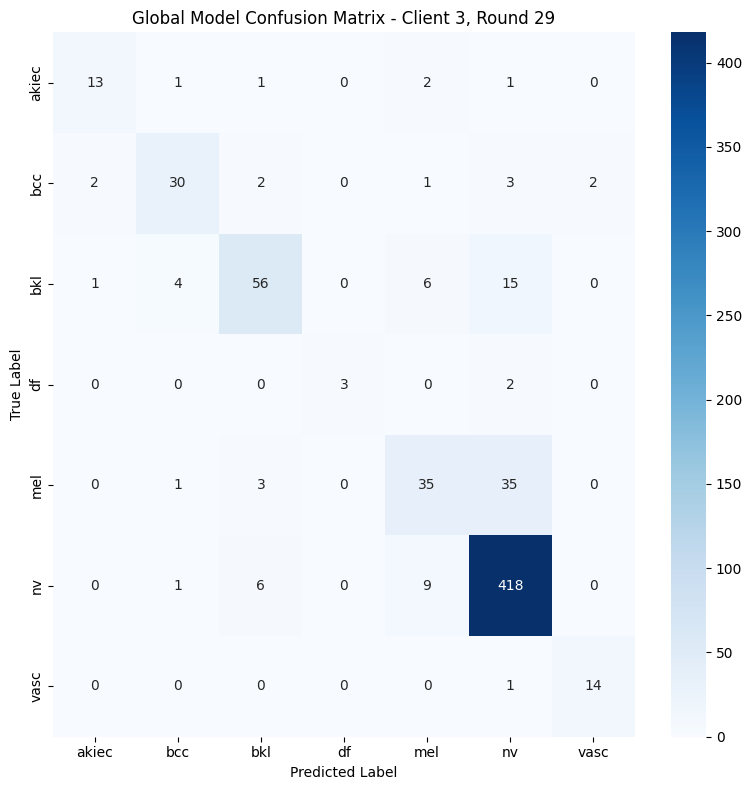


--- Round 30 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [03:56<00:00,  2.82s/it]


Client 1 Epoch 1: Train Loss: 0.1267, Train Accuracy: 98.99%


Client 1 Epoch 2: 100%|██████████| 84/84 [03:51<00:00,  2.76s/it]


Client 1 Epoch 2: Train Loss: 0.2639, Train Accuracy: 98.09%


Client 1 Epoch 3: 100%|██████████| 84/84 [03:49<00:00,  2.73s/it]


Client 1 Epoch 3: Train Loss: 0.3059, Train Accuracy: 97.90%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:23<00:00,  1.12s/it]


Test Loss: 0.8331, Test Accuracy: 80.87%, F1-Score: 0.7950
Confusion Matrix:
 [[ 15   1   7   0   1   4   0]
 [  3  17   3   0   0  10   0]
 [  3   0  54   0   1  14   0]
 [  1   0   4   5   0   0   0]
 [  0   0  11   0  28  38   0]
 [  0   2  16   1   3 416   0]
 [  0   0   0   0   2   3   6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.54      0.60        28
           1       0.85      0.52      0.64        33
           2       0.57      0.75      0.65        72
           3       0.83      0.50      0.62        10
           4       0.80      0.36      0.50        77
           5       0.86      0.95      0.90       438
           6       1.00      0.55      0.71        11

    accuracy                           0.81       669
   macro avg       0.80      0.59      0.66       669
weighted avg       0.81      0.81      0.80       669

Sensitivity/Recall:
 [0.53571429 0.51515152 0.75       0.5        0.36363636 0.9497

Client 2 Epoch 1: 100%|██████████| 84/84 [05:49<00:00,  4.16s/it]


Client 2 Epoch 1: Train Loss: 0.1438, Train Accuracy: 98.91%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:40<00:00,  4.05s/it]


Client 2 Epoch 2: Train Loss: 0.2618, Train Accuracy: 97.64%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:40<00:00,  4.05s/it]


Client 2 Epoch 3: Train Loss: 0.2897, Train Accuracy: 98.58%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:45<00:00,  2.19s/it]


Test Loss: 0.7061, Test Accuracy: 83.68%, F1-Score: 0.8209
Confusion Matrix:
 [[  4   4   6   0   3   5   0]
 [  0  32   1   0   2   3   0]
 [  0   5  28   0   4  21   0]
 [  0   1   1   2   1   4   0]
 [  0   3   2   0  39  24   0]
 [  0   2   5   0  10 446   0]
 [  0   0   0   0   2   0   8]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.18      0.31        22
           1       0.68      0.84      0.75        38
           2       0.65      0.48      0.55        58
           3       1.00      0.22      0.36         9
           4       0.64      0.57      0.60        68
           5       0.89      0.96      0.92       463
           6       1.00      0.80      0.89        10

    accuracy                           0.84       668
   macro avg       0.84      0.58      0.63       668
weighted avg       0.84      0.84      0.82       668

Sensitivity/Recall:
 [0.18181818 0.84210526 0.48275862 0.22222222 0.57352941 0.9632

Client 3 Epoch 1: 100%|██████████| 84/84 [05:27<00:00,  3.89s/it]


Client 3 Epoch 1: Train Loss: 0.1610, Train Accuracy: 98.46%


Client 3 Epoch 2: 100%|██████████| 84/84 [05:18<00:00,  3.79s/it]


Client 3 Epoch 2: Train Loss: 0.0942, Train Accuracy: 99.85%


Client 3 Epoch 3: 100%|██████████| 84/84 [05:18<00:00,  3.79s/it]


Client 3 Epoch 3: Train Loss: 0.0660, Train Accuracy: 99.59%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it]


Test Loss: 0.6689, Test Accuracy: 86.98%, F1-Score: 0.8604
Confusion Matrix:
 [[ 14   0   2   0   0   2   0]
 [  4  30   1   1   1   2   1]
 [  1   3  62   0   2  14   0]
 [  0   0   0   3   0   2   0]
 [  1   0   4   0  34  35   0]
 [  0   2   4   0   4 424   0]
 [  0   0   0   1   0   0  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.78      0.74        18
           1       0.86      0.75      0.80        40
           2       0.85      0.76      0.80        82
           3       0.60      0.60      0.60         5
           4       0.83      0.46      0.59        74
           5       0.89      0.98      0.93       434
           6       0.93      0.93      0.93        15

    accuracy                           0.87       668
   macro avg       0.81      0.75      0.77       668
weighted avg       0.87      0.87      0.86       668

Sensitivity/Recall:
 [0.77777778 0.75       0.75609756 0.6        0.45945946 0.9769

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.59it/s]

Test Loss: 0.6355, Test Accuracy: 85.50%, F1-Score: 0.8476
Confusion Matrix:
 [[ 11   2   8   0   5   2   0]
 [  0  21   4   0   0   8   0]
 [  1   0  55   0   0  16   0]
 [  0   0   4   6   0   0   0]
 [  0   0   3   0  49  25   0]
 [  0   1   7   1   7 422   0]
 [  0   0   0   0   2   1   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.39      0.55        28
           1       0.88      0.64      0.74        33
           2       0.68      0.76      0.72        72
           3       0.86      0.60      0.71        10
           4       0.78      0.64      0.70        77
           5       0.89      0.96      0.93       438
           6       1.00      0.73      0.84        11

    accuracy                           0.86       669
   macro avg       0.86      0.67      0.74       669
weighted avg       0.86      0.86      0.85       669

Sensitivity/Recall:
 [0.39285714 0.63636364 0.76388889 0.6        0.63636364 0.9634

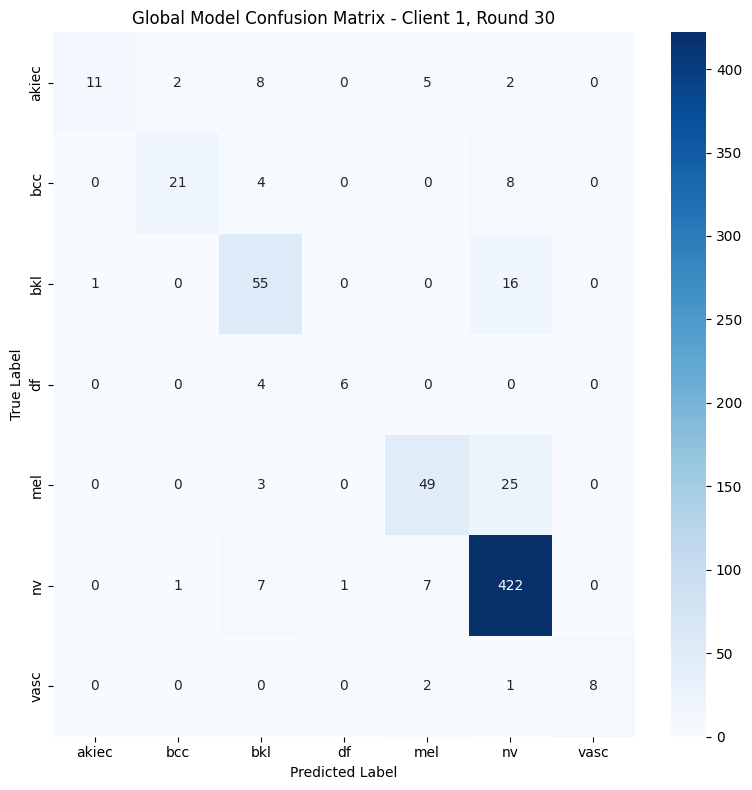


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:12<00:00,  1.62it/s]

Test Loss: 0.5824, Test Accuracy: 86.53%, F1-Score: 0.8524
Confusion Matrix:
 [[  7   1   6   0   1   7   0]
 [  2  27   3   0   1   5   0]
 [  0   0  43   0   2  13   0]
 [  3   0   0   2   1   3   0]
 [  0   1   5   0  35  27   0]
 [  0   1   3   0   4 455   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.32      0.41        22
           1       0.90      0.71      0.79        38
           2       0.72      0.74      0.73        58
           3       1.00      0.22      0.36         9
           4       0.78      0.51      0.62        68
           5       0.89      0.98      0.94       463
           6       1.00      0.90      0.95        10

    accuracy                           0.87       668
   macro avg       0.84      0.63      0.69       668
weighted avg       0.86      0.87      0.85       668

Sensitivity/Recall:
 [0.31818182 0.71052632 0.74137931 0.22222222 0.51470588 0.9827

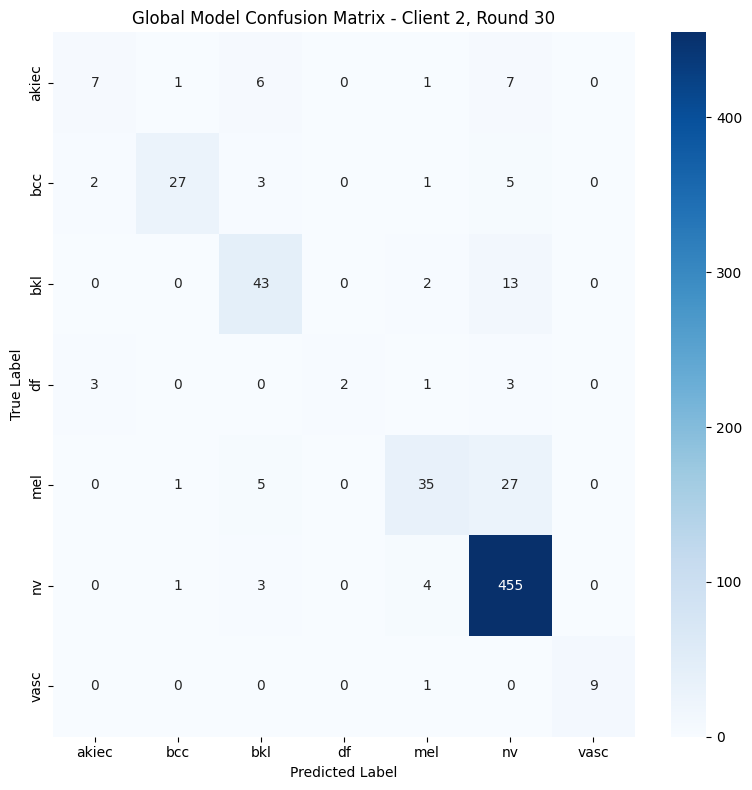


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.61it/s]


Test Loss: 0.6513, Test Accuracy: 86.83%, F1-Score: 0.8596
Confusion Matrix:
 [[ 11   1   2   0   2   2   0]
 [  4  30   0   0   2   4   0]
 [  0   3  60   0   3  16   0]
 [  0   0   0   3   0   2   0]
 [  0   0   2   0  37  35   0]
 [  0   2   2   0   5 425   0]
 [  0   0   0   0   0   1  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.61      0.67        18
           1       0.83      0.75      0.79        40
           2       0.91      0.73      0.81        82
           3       1.00      0.60      0.75         5
           4       0.76      0.50      0.60        74
           5       0.88      0.98      0.92       434
           6       1.00      0.93      0.97        15

    accuracy                           0.87       668
   macro avg       0.87      0.73      0.79       668
weighted avg       0.86      0.87      0.86       668

Sensitivity/Recall:
 [0.61111111 0.75       0.73170732 0.6        0.5        0.9792

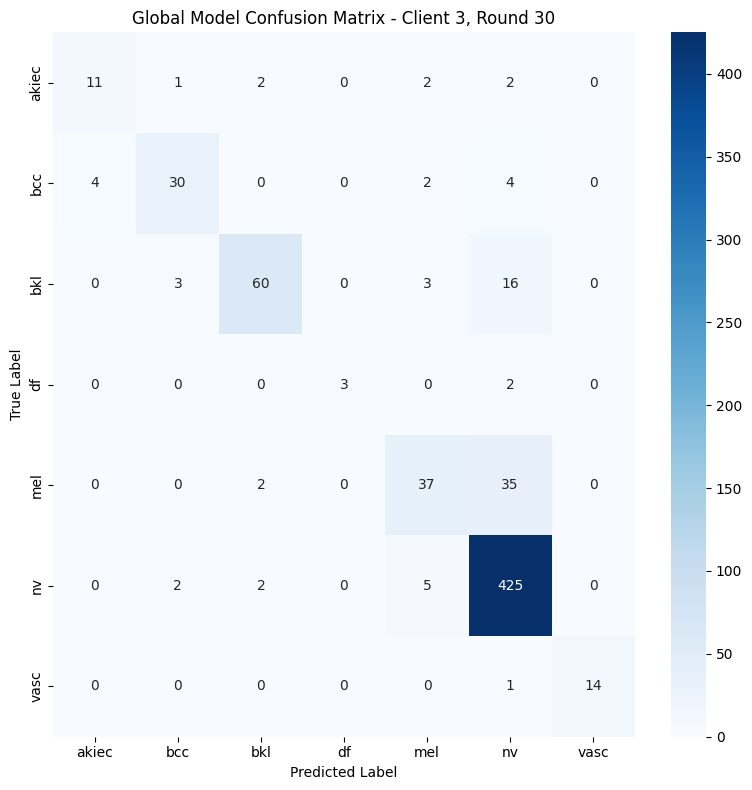


--- Round 31 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [03:58<00:00,  2.84s/it]


Client 1 Epoch 1: Train Loss: 0.1422, Train Accuracy: 98.47%


Client 1 Epoch 2: 100%|██████████| 84/84 [03:58<00:00,  2.84s/it]


Client 1 Epoch 2: Train Loss: 0.2286, Train Accuracy: 99.18%


Client 1 Epoch 3: 100%|██████████| 84/84 [03:58<00:00,  2.84s/it]


Client 1 Epoch 3: Train Loss: 0.1078, Train Accuracy: 99.85%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:28<00:00,  1.35s/it]


Test Loss: 0.7074, Test Accuracy: 84.90%, F1-Score: 0.8417
Confusion Matrix:
 [[  9   5   6   0   5   3   0]
 [  1  20   3   0   1   8   0]
 [  1   0  55   0   0  16   0]
 [  0   0   2   8   0   0   0]
 [  2   0   3   0  52  20   0]
 [  0   1   9   1  10 417   0]
 [  0   0   0   0   3   1   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.32      0.44        28
           1       0.77      0.61      0.68        33
           2       0.71      0.76      0.73        72
           3       0.89      0.80      0.84        10
           4       0.73      0.68      0.70        77
           5       0.90      0.95      0.92       438
           6       1.00      0.64      0.78        11

    accuracy                           0.85       669
   macro avg       0.81      0.68      0.73       669
weighted avg       0.84      0.85      0.84       669

Sensitivity/Recall:
 [0.32142857 0.60606061 0.76388889 0.8        0.67532468 0.9520

Client 2 Epoch 1: 100%|██████████| 84/84 [05:43<00:00,  4.09s/it]


Client 2 Epoch 1: Train Loss: 0.1433, Train Accuracy: 98.54%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:43<00:00,  4.09s/it]


Client 2 Epoch 2: Train Loss: 0.2277, Train Accuracy: 98.84%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:43<00:00,  4.09s/it]


Client 2 Epoch 3: Train Loss: 0.1388, Train Accuracy: 99.63%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:43<00:00,  2.06s/it]


Test Loss: 0.6461, Test Accuracy: 85.33%, F1-Score: 0.8465
Confusion Matrix:
 [[  4   3   6   0   8   1   0]
 [  1  30   2   0   3   2   0]
 [  0   0  41   0   6  11   0]
 [  2   0   1   2   2   2   0]
 [  0   2   7   0  44  15   0]
 [  0   1   7   0  14 441   0]
 [  0   0   0   0   2   0   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.18      0.28        22
           1       0.83      0.79      0.81        38
           2       0.64      0.71      0.67        58
           3       1.00      0.22      0.36         9
           4       0.56      0.65      0.60        68
           5       0.93      0.95      0.94       463
           6       1.00      0.80      0.89        10

    accuracy                           0.85       668
   macro avg       0.79      0.61      0.65       668
weighted avg       0.85      0.85      0.85       668

Sensitivity/Recall:
 [0.18181818 0.78947368 0.70689655 0.22222222 0.64705882 0.9524

Client 3 Epoch 1: 100%|██████████| 84/84 [05:22<00:00,  3.84s/it]


Client 3 Epoch 1: Train Loss: 0.1381, Train Accuracy: 98.91%


Client 3 Epoch 2: 100%|██████████| 84/84 [05:23<00:00,  3.85s/it]


Client 3 Epoch 2: Train Loss: 0.1792, Train Accuracy: 99.14%


Client 3 Epoch 3: 100%|██████████| 84/84 [05:23<00:00,  3.85s/it]


Client 3 Epoch 3: Train Loss: 0.1608, Train Accuracy: 99.18%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:18<00:00,  1.15it/s]


Test Loss: 0.8558, Test Accuracy: 83.83%, F1-Score: 0.8274
Confusion Matrix:
 [[ 15   0   0   0   3   0   0]
 [  5  30   1   0   1   2   1]
 [  4   5  57   0   6  10   0]
 [  1   0   1   1   0   2   0]
 [  1   1   8   0  28  36   0]
 [  0   4   5   0   9 415   1]
 [  0   0   0   0   0   1  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.83      0.68        18
           1       0.75      0.75      0.75        40
           2       0.79      0.70      0.74        82
           3       1.00      0.20      0.33         5
           4       0.60      0.38      0.46        74
           5       0.89      0.96      0.92       434
           6       0.88      0.93      0.90        15

    accuracy                           0.84       668
   macro avg       0.78      0.68      0.68       668
weighted avg       0.83      0.84      0.83       668

Sensitivity/Recall:
 [0.83333333 0.75       0.69512195 0.2        0.37837838 0.9562

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.6167, Test Accuracy: 87.29%, F1-Score: 0.8699
Confusion Matrix:
 [[ 14   1   6   0   5   2   0]
 [  0  24   4   0   0   5   0]
 [  0   0  58   0   3  11   0]
 [  0   0   4   6   0   0   0]
 [  1   0   4   0  55  17   0]
 [  0   2  10   0   6 420   0]
 [  0   0   0   0   3   1   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.50      0.65        28
           1       0.89      0.73      0.80        33
           2       0.67      0.81      0.73        72
           3       1.00      0.60      0.75        10
           4       0.76      0.71      0.74        77
           5       0.92      0.96      0.94       438
           6       1.00      0.64      0.78        11

    accuracy                           0.87       669
   macro avg       0.88      0.71      0.77       669
weighted avg       0.88      0.87      0.87       669

Sensitivity/Recall:
 [0.5        0.72727273 0.80555556 0.6        0.71428571 0.9589

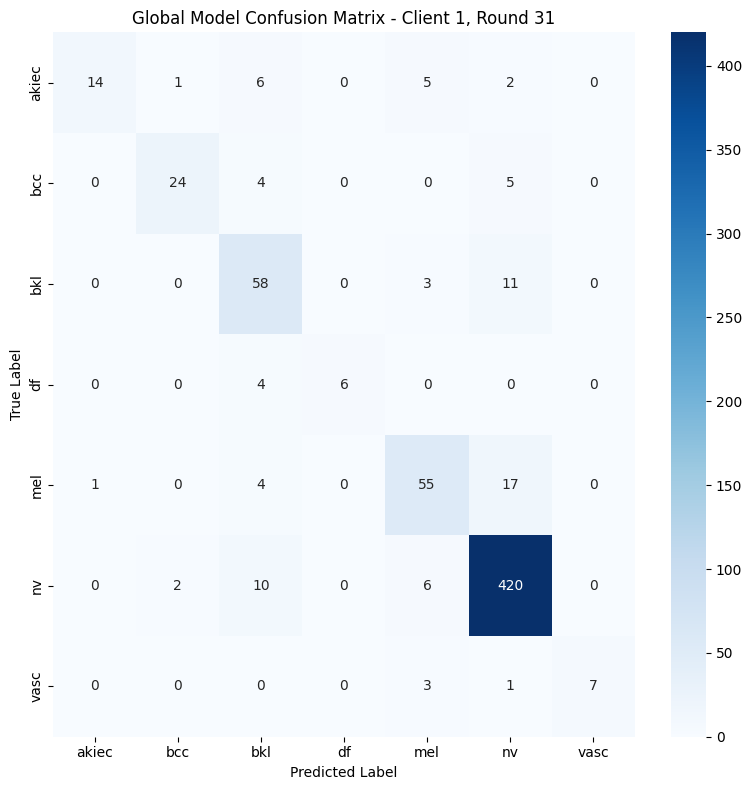


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.61it/s]

Test Loss: 0.5063, Test Accuracy: 88.17%, F1-Score: 0.8753
Confusion Matrix:
 [[  9   1   6   0   3   3   0]
 [  0  29   3   0   2   4   0]
 [  0   1  45   0   3   9   0]
 [  1   0   1   4   1   2   0]
 [  0   1   6   0  41  20   0]
 [  0   1   5   0   5 452   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.41      0.56        22
           1       0.88      0.76      0.82        38
           2       0.68      0.78      0.73        58
           3       1.00      0.44      0.62         9
           4       0.73      0.60      0.66        68
           5       0.92      0.98      0.95       463
           6       1.00      0.90      0.95        10

    accuracy                           0.88       668
   macro avg       0.87      0.70      0.75       668
weighted avg       0.88      0.88      0.88       668

Sensitivity/Recall:
 [0.40909091 0.76315789 0.77586207 0.44444444 0.60294118 0.9762

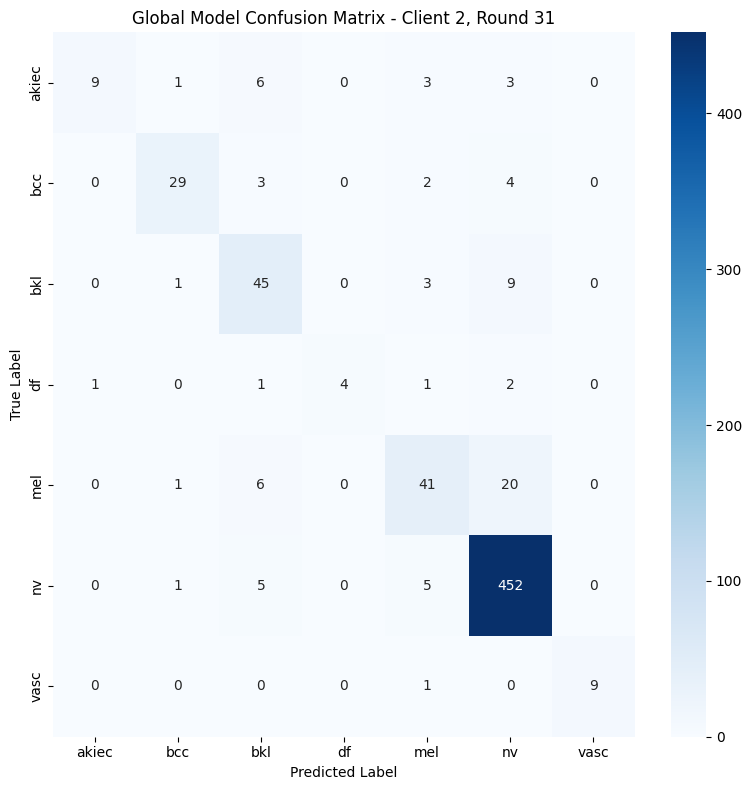


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.61it/s]

Test Loss: 0.6985, Test Accuracy: 85.78%, F1-Score: 0.8496
Confusion Matrix:
 [[ 11   1   2   0   2   2   0]
 [  2  34   1   0   2   1   0]
 [  1   5  61   0   4  11   0]
 [  0   0   0   3   0   2   0]
 [  0   1   1   0  34  38   0]
 [  0   4   6   0   7 417   0]
 [  0   0   0   0   1   1  13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.61      0.69        18
           1       0.76      0.85      0.80        40
           2       0.86      0.74      0.80        82
           3       1.00      0.60      0.75         5
           4       0.68      0.46      0.55        74
           5       0.88      0.96      0.92       434
           6       1.00      0.87      0.93        15

    accuracy                           0.86       668
   macro avg       0.85      0.73      0.78       668
weighted avg       0.85      0.86      0.85       668

Sensitivity/Recall:
 [0.61111111 0.85       0.74390244 0.6        0.45945946 0.9608

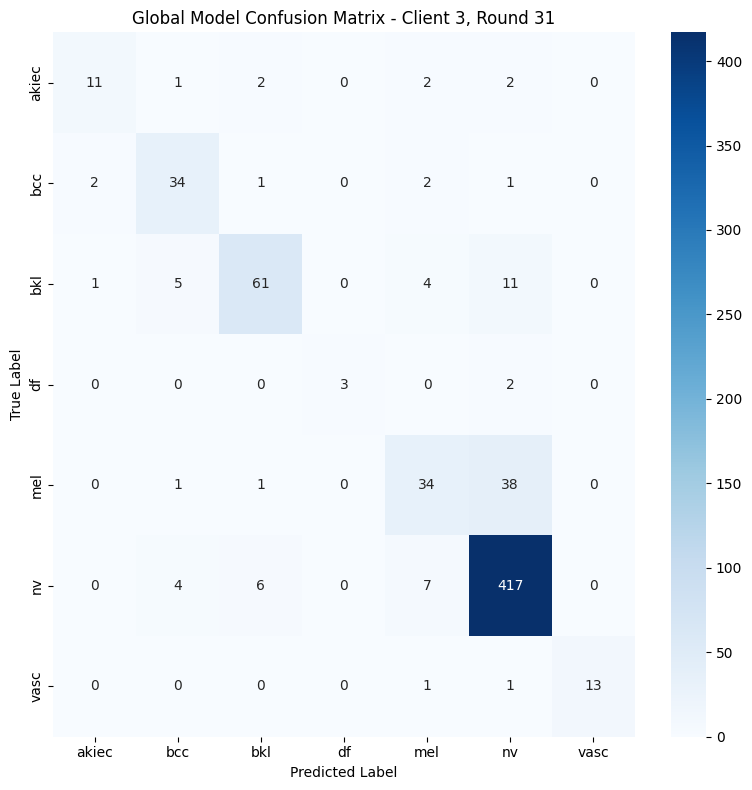


--- Round 32 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [04:16<00:00,  3.05s/it]


Client 1 Epoch 1: Train Loss: 0.1279, Train Accuracy: 98.91%


Client 1 Epoch 2: 100%|██████████| 84/84 [04:16<00:00,  3.06s/it]


Client 1 Epoch 2: Train Loss: 0.1677, Train Accuracy: 99.25%


Client 1 Epoch 3: 100%|██████████| 84/84 [04:16<00:00,  3.05s/it]


Client 1 Epoch 3: Train Loss: 0.2861, Train Accuracy: 97.87%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]


Test Loss: 0.8901, Test Accuracy: 80.87%, F1-Score: 0.7946
Confusion Matrix:
 [[  5  12   3   0   2   6   0]
 [  0  25   2   0   0   5   1]
 [  2   1  34   0   6  29   0]
 [  2   2   1   4   0   1   0]
 [  3   0   3   0  49  19   3]
 [  0   4   4   0  16 414   0]
 [  0   0   0   0   0   1  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.18      0.25        28
           1       0.57      0.76      0.65        33
           2       0.72      0.47      0.57        72
           3       1.00      0.40      0.57        10
           4       0.67      0.64      0.65        77
           5       0.87      0.95      0.91       438
           6       0.71      0.91      0.80        11

    accuracy                           0.81       669
   macro avg       0.71      0.61      0.63       669
weighted avg       0.80      0.81      0.79       669

Sensitivity/Recall:
 [0.17857143 0.75757576 0.47222222 0.4        0.63636364 0.9452

Client 2 Epoch 1: 100%|██████████| 84/84 [05:20<00:00,  3.81s/it]


Client 2 Epoch 1: Train Loss: 0.1346, Train Accuracy: 99.03%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:19<00:00,  3.80s/it]


Client 2 Epoch 2: Train Loss: 0.2486, Train Accuracy: 98.61%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:19<00:00,  3.80s/it]


Client 2 Epoch 3: Train Loss: 0.2816, Train Accuracy: 98.69%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:43<00:00,  2.06s/it]


Test Loss: 0.7136, Test Accuracy: 85.03%, F1-Score: 0.8472
Confusion Matrix:
 [[ 10   4   5   0   1   2   0]
 [  0  35   1   0   1   1   0]
 [  0   4  45   0   5   4   0]
 [  3   2   1   2   1   0   0]
 [  0   6   8   0  35  19   0]
 [  0   2  13   0  16 432   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.45      0.57        22
           1       0.66      0.92      0.77        38
           2       0.62      0.78      0.69        58
           3       1.00      0.22      0.36         9
           4       0.58      0.51      0.55        68
           5       0.94      0.93      0.94       463
           6       1.00      0.90      0.95        10

    accuracy                           0.85       668
   macro avg       0.80      0.67      0.69       668
weighted avg       0.86      0.85      0.85       668

Sensitivity/Recall:
 [0.45454545 0.92105263 0.77586207 0.22222222 0.51470588 0.9330

Client 3 Epoch 1: 100%|██████████| 84/84 [05:46<00:00,  4.12s/it]


Client 3 Epoch 1: Train Loss: 0.1706, Train Accuracy: 98.24%


Client 3 Epoch 2: 100%|██████████| 84/84 [05:47<00:00,  4.14s/it]


Client 3 Epoch 2: Train Loss: 0.1918, Train Accuracy: 99.29%


Client 3 Epoch 3: 100%|██████████| 84/84 [05:47<00:00,  4.14s/it]


Client 3 Epoch 3: Train Loss: 0.1095, Train Accuracy: 99.81%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:23<00:00,  1.12s/it]


Test Loss: 0.7005, Test Accuracy: 85.63%, F1-Score: 0.8503
Confusion Matrix:
 [[ 12   1   2   0   2   1   0]
 [  4  34   1   0   1   0   0]
 [  0   7  54   0   6  15   0]
 [  0   0   0   3   0   2   0]
 [  0   1   3   0  40  30   0]
 [  0   4   7   0   8 415   0]
 [  0   0   0   1   0   0  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.67      0.71        18
           1       0.72      0.85      0.78        40
           2       0.81      0.66      0.72        82
           3       0.75      0.60      0.67         5
           4       0.70      0.54      0.61        74
           5       0.90      0.96      0.93       434
           6       1.00      0.93      0.97        15

    accuracy                           0.86       668
   macro avg       0.80      0.74      0.77       668
weighted avg       0.85      0.86      0.85       668

Sensitivity/Recall:
 [0.66666667 0.85       0.65853659 0.6        0.54054054 0.9562

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.6332, Test Accuracy: 85.20%, F1-Score: 0.8457
Confusion Matrix:
 [[  8   9   5   0   3   3   0]
 [  0  24   4   0   0   5   0]
 [  1   0  52   0   5  14   0]
 [  1   0   3   6   0   0   0]
 [  3   0   4   0  54  15   1]
 [  0   3   7   0  10 418   0]
 [  0   0   0   0   2   1   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.29      0.39        28
           1       0.67      0.73      0.70        33
           2       0.69      0.72      0.71        72
           3       1.00      0.60      0.75        10
           4       0.73      0.70      0.72        77
           5       0.92      0.95      0.94       438
           6       0.89      0.73      0.80        11

    accuracy                           0.85       669
   macro avg       0.79      0.67      0.71       669
weighted avg       0.85      0.85      0.85       669

Sensitivity/Recall:
 [0.28571429 0.72727273 0.72222222 0.6        0.7012987  0.9543

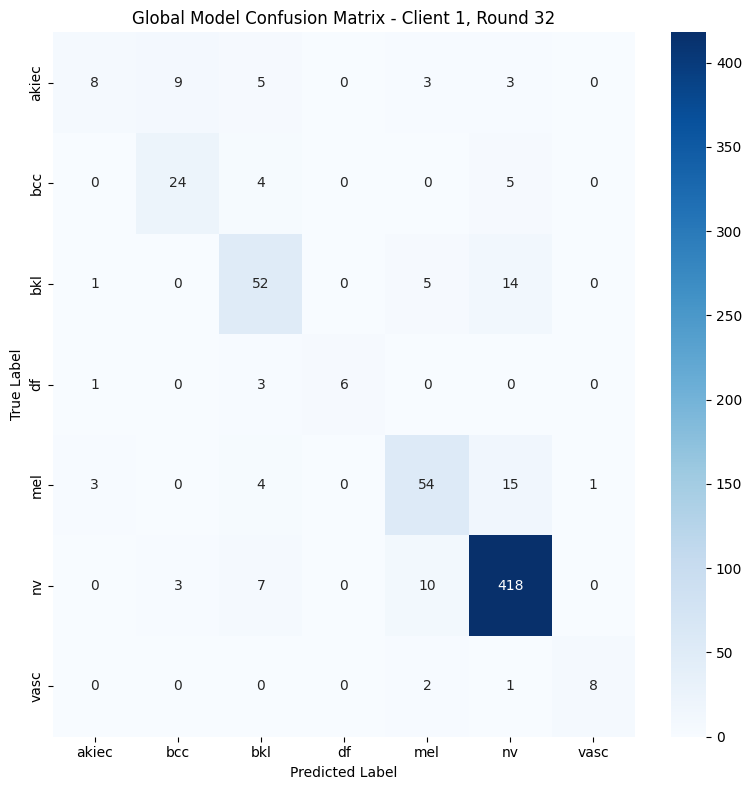


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.61it/s]

Test Loss: 0.5298, Test Accuracy: 88.47%, F1-Score: 0.8799
Confusion Matrix:
 [[ 11   2   5   0   2   2   0]
 [  1  33   2   0   0   2   0]
 [  0   4  45   0   3   6   0]
 [  0   1   0   6   1   1   0]
 [  0   5   4   0  38  21   0]
 [  0   1   8   0   5 449   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.50      0.65        22
           1       0.72      0.87      0.79        38
           2       0.70      0.78      0.74        58
           3       1.00      0.67      0.80         9
           4       0.76      0.56      0.64        68
           5       0.93      0.97      0.95       463
           6       1.00      0.90      0.95        10

    accuracy                           0.88       668
   macro avg       0.86      0.75      0.79       668
weighted avg       0.88      0.88      0.88       668

Sensitivity/Recall:
 [0.5        0.86842105 0.77586207 0.66666667 0.55882353 0.9697

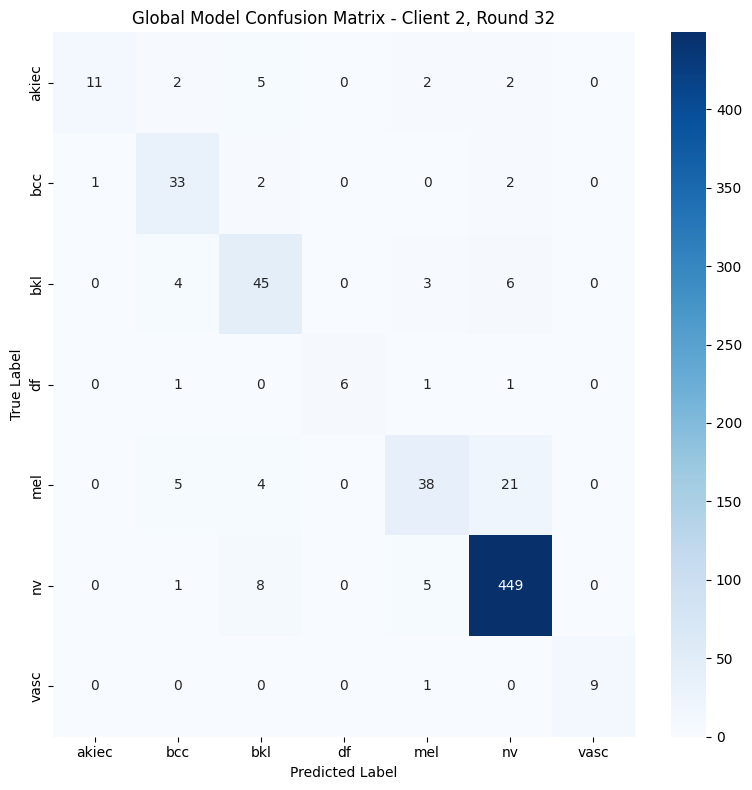


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.61it/s]

Test Loss: 0.6988, Test Accuracy: 87.28%, F1-Score: 0.8675
Confusion Matrix:
 [[ 11   1   2   0   3   1   0]
 [  2  36   0   0   0   0   2]
 [  0   5  61   0   6  10   0]
 [  0   0   0   3   0   2   0]
 [  0   1   2   0  42  29   0]
 [  0   5   7   0   5 417   0]
 [  0   0   0   1   0   1  13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.61      0.71        18
           1       0.75      0.90      0.82        40
           2       0.85      0.74      0.79        82
           3       0.75      0.60      0.67         5
           4       0.75      0.57      0.65        74
           5       0.91      0.96      0.93       434
           6       0.87      0.87      0.87        15

    accuracy                           0.87       668
   macro avg       0.82      0.75      0.78       668
weighted avg       0.87      0.87      0.87       668

Sensitivity/Recall:
 [0.61111111 0.9        0.74390244 0.6        0.56756757 0.9608

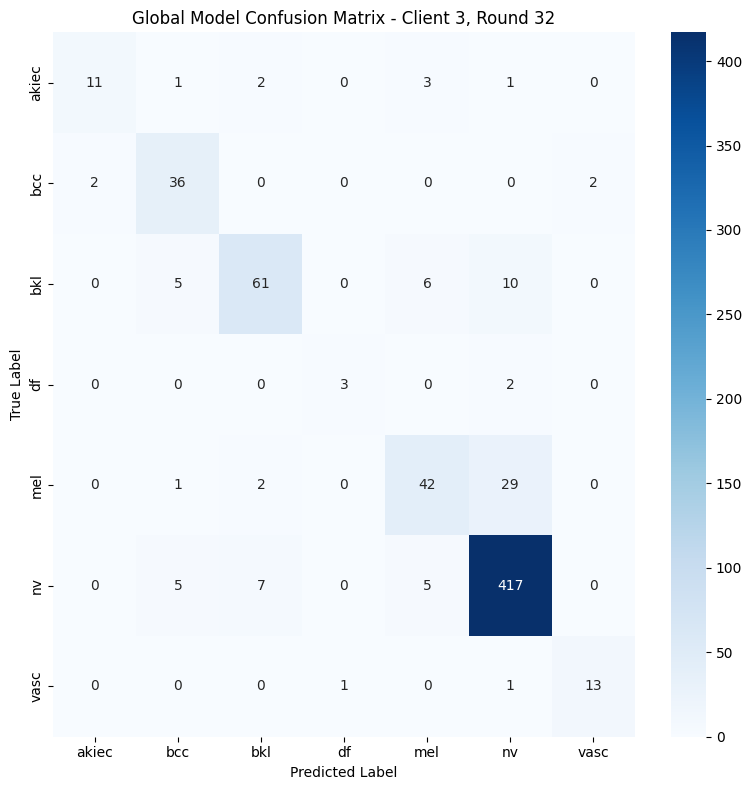


--- Round 33 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [04:18<00:00,  3.07s/it]


Client 1 Epoch 1: Train Loss: 0.1475, Train Accuracy: 98.73%


Client 1 Epoch 2: 100%|██████████| 84/84 [04:18<00:00,  3.07s/it]


Client 1 Epoch 2: Train Loss: 0.1703, Train Accuracy: 99.44%


Client 1 Epoch 3: 100%|██████████| 84/84 [04:18<00:00,  3.07s/it]


Client 1 Epoch 3: Train Loss: 0.2086, Train Accuracy: 99.03%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:06<00:00,  3.03it/s]


Test Loss: 0.8483, Test Accuracy: 84.01%, F1-Score: 0.8287
Confusion Matrix:
 [[ 12   1   3   1   5   6   0]
 [  0  17   2   0   1  12   1]
 [  2   0  45   0   5  20   0]
 [  0   0   1   8   0   1   0]
 [  0   0   6   0  45  26   0]
 [  0   1   7   0   3 427   0]
 [  0   0   0   0   1   2   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.43      0.57        28
           1       0.89      0.52      0.65        33
           2       0.70      0.62      0.66        72
           3       0.89      0.80      0.84        10
           4       0.75      0.58      0.66        77
           5       0.86      0.97      0.92       438
           6       0.89      0.73      0.80        11

    accuracy                           0.84       669
   macro avg       0.84      0.67      0.73       669
weighted avg       0.84      0.84      0.83       669

Sensitivity/Recall:
 [0.42857143 0.51515152 0.625      0.8        0.58441558 0.9748

Client 2 Epoch 1: 100%|██████████| 84/84 [05:54<00:00,  4.23s/it]


Client 2 Epoch 1: Train Loss: 0.1406, Train Accuracy: 98.58%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:54<00:00,  4.22s/it]


Client 2 Epoch 2: Train Loss: 0.3114, Train Accuracy: 98.35%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:54<00:00,  4.22s/it]


Client 2 Epoch 3: Train Loss: 0.1655, Train Accuracy: 99.85%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:43<00:00,  2.07s/it]


Test Loss: 0.5224, Test Accuracy: 88.02%, F1-Score: 0.8780
Confusion Matrix:
 [[ 14   0   5   0   2   1   0]
 [  5  27   4   0   0   2   0]
 [  1   0  47   0   3   7   0]
 [  2   0   0   5   1   1   0]
 [  0   2   6   0  41  19   0]
 [  0   2   7   0   9 445   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.64      0.64        22
           1       0.87      0.71      0.78        38
           2       0.68      0.81      0.74        58
           3       1.00      0.56      0.71         9
           4       0.72      0.60      0.66        68
           5       0.94      0.96      0.95       463
           6       1.00      0.90      0.95        10

    accuracy                           0.88       668
   macro avg       0.83      0.74      0.78       668
weighted avg       0.88      0.88      0.88       668

Sensitivity/Recall:
 [0.63636364 0.71052632 0.81034483 0.55555556 0.60294118 0.9611

Client 3 Epoch 1: 100%|██████████| 84/84 [05:10<00:00,  3.70s/it]


Client 3 Epoch 1: Train Loss: 0.1298, Train Accuracy: 99.29%


Client 3 Epoch 2: 100%|██████████| 84/84 [05:12<00:00,  3.72s/it]


Client 3 Epoch 2: Train Loss: 0.3076, Train Accuracy: 97.79%


Client 3 Epoch 3: 100%|██████████| 84/84 [05:11<00:00,  3.71s/it]


Client 3 Epoch 3: Train Loss: 0.2965, Train Accuracy: 98.84%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:12<00:00,  1.68it/s]


Test Loss: 0.7551, Test Accuracy: 85.03%, F1-Score: 0.8459
Confusion Matrix:
 [[  9   1   3   1   2   2   0]
 [  1  37   1   0   1   0   0]
 [  0   6  61   0   4  11   0]
 [  0   0   1   4   0   0   0]
 [  0   1   3   0  39  31   0]
 [  0  11   9   0  10 404   0]
 [  0   0   0   1   0   0  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.50      0.64        18
           1       0.66      0.93      0.77        40
           2       0.78      0.74      0.76        82
           3       0.67      0.80      0.73         5
           4       0.70      0.53      0.60        74
           5       0.90      0.93      0.92       434
           6       1.00      0.93      0.97        15

    accuracy                           0.85       668
   macro avg       0.80      0.77      0.77       668
weighted avg       0.85      0.85      0.85       668

Sensitivity/Recall:
 [0.5        0.925      0.74390244 0.8        0.52702703 0.9308

Testing: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]

Test Loss: 0.5720, Test Accuracy: 88.04%, F1-Score: 0.8764
Confusion Matrix:
 [[ 14   1   6   0   5   2   0]
 [  0  25   3   0   1   4   0]
 [  2   0  53   0   3  14   0]
 [  0   0   1   9   0   0   0]
 [  2   0   2   0  55  18   0]
 [  0   3   7   0   4 424   0]
 [  0   0   0   0   1   1   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.50      0.61        28
           1       0.86      0.76      0.81        33
           2       0.74      0.74      0.74        72
           3       1.00      0.90      0.95        10
           4       0.80      0.71      0.75        77
           5       0.92      0.97      0.94       438
           6       1.00      0.82      0.90        11

    accuracy                           0.88       669
   macro avg       0.87      0.77      0.81       669
weighted avg       0.88      0.88      0.88       669

Sensitivity/Recall:
 [0.5        0.75757576 0.73611111 0.9        0.71428571 0.9680

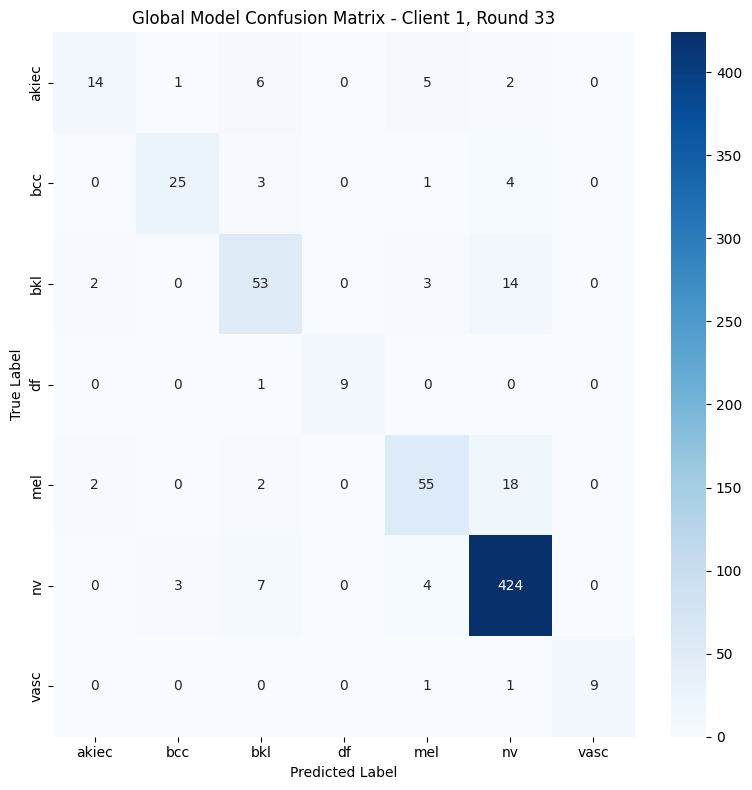


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.61it/s]

Test Loss: 0.5245, Test Accuracy: 88.62%, F1-Score: 0.8811
Confusion Matrix:
 [[ 12   1   5   0   2   2   0]
 [  2  32   3   0   1   0   0]
 [  0   1  47   1   2   7   0]
 [  0   1   0   5   2   1   0]
 [  0   3   3   0  38  24   0]
 [  0   2   6   0   6 449   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.55      0.67        22
           1       0.80      0.84      0.82        38
           2       0.73      0.81      0.77        58
           3       0.83      0.56      0.67         9
           4       0.73      0.56      0.63        68
           5       0.93      0.97      0.95       463
           6       1.00      0.90      0.95        10

    accuracy                           0.89       668
   macro avg       0.84      0.74      0.78       668
weighted avg       0.88      0.89      0.88       668

Sensitivity/Recall:
 [0.54545455 0.84210526 0.81034483 0.55555556 0.55882353 0.9697

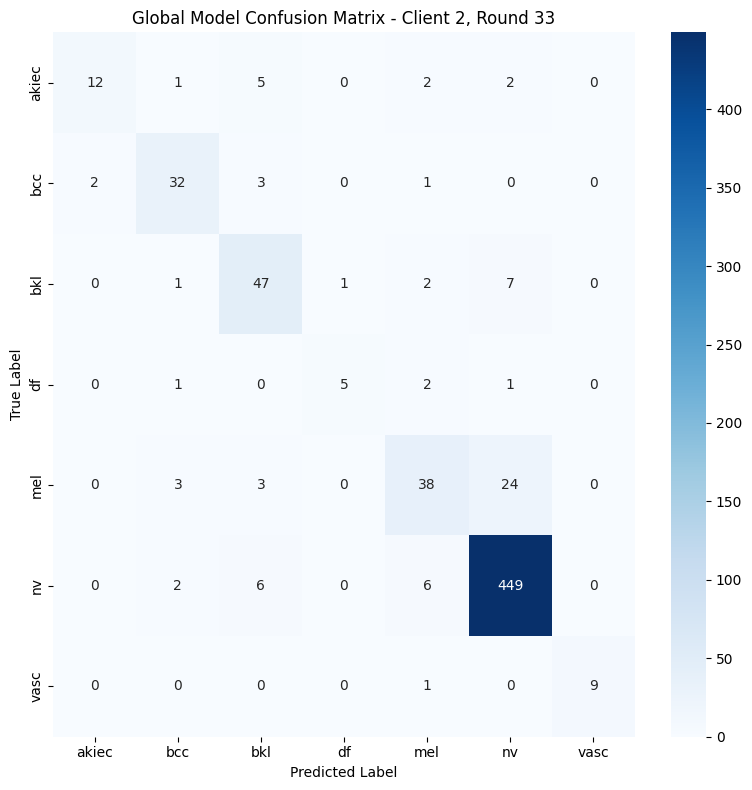


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.61it/s]

Test Loss: 0.7007, Test Accuracy: 86.98%, F1-Score: 0.8642
Confusion Matrix:
 [[ 12   1   1   0   2   2   0]
 [  2  33   1   0   1   1   2]
 [  0   4  61   0   5  12   0]
 [  0   0   0   3   1   1   0]
 [  0   1   1   0  40  32   0]
 [  0   4   3   0   9 418   0]
 [  0   0   0   0   0   1  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.67      0.75        18
           1       0.77      0.82      0.80        40
           2       0.91      0.74      0.82        82
           3       1.00      0.60      0.75         5
           4       0.69      0.54      0.61        74
           5       0.90      0.96      0.93       434
           6       0.88      0.93      0.90        15

    accuracy                           0.87       668
   macro avg       0.86      0.75      0.79       668
weighted avg       0.87      0.87      0.86       668

Sensitivity/Recall:
 [0.66666667 0.825      0.74390244 0.6        0.54054054 0.9631

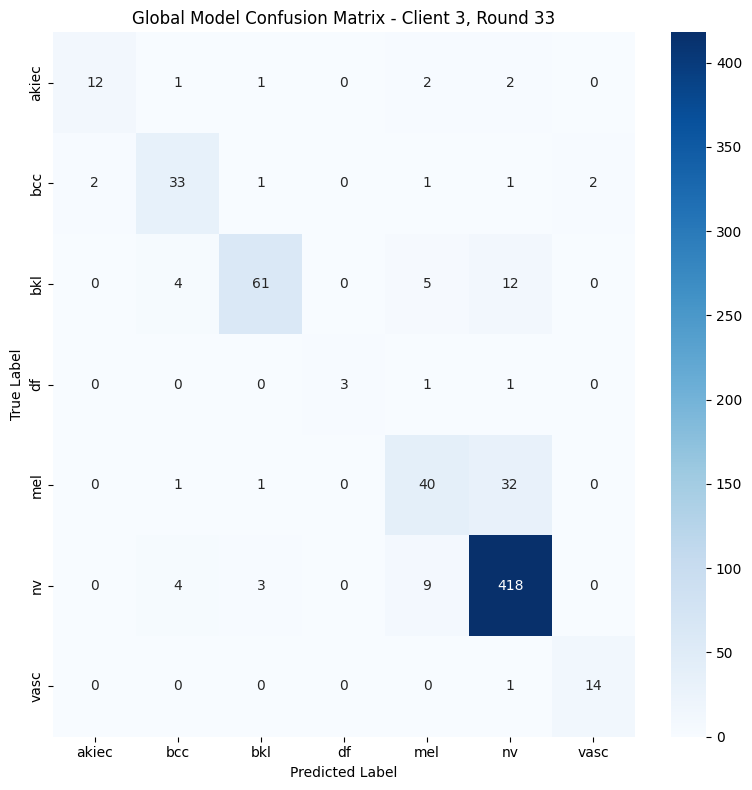


--- Round 34 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [04:10<00:00,  2.98s/it]


Client 1 Epoch 1: Train Loss: 0.1008, Train Accuracy: 99.03%


Client 1 Epoch 2: 100%|██████████| 84/84 [04:10<00:00,  2.99s/it]


Client 1 Epoch 2: Train Loss: 0.3560, Train Accuracy: 97.42%


Client 1 Epoch 3: 100%|██████████| 84/84 [04:10<00:00,  2.99s/it]


Client 1 Epoch 3: Train Loss: 0.2619, Train Accuracy: 99.29%

Evaluating Client 1 on its local test set


Testing: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]


Test Loss: 0.8914, Test Accuracy: 82.36%, F1-Score: 0.8074
Confusion Matrix:
 [[ 17   3   1   0   2   5   0]
 [  1  20   2   0   0   9   1]
 [  2   0  30   1   2  37   0]
 [  0   0   0   9   0   1   0]
 [  3   1   2   0  41  30   0]
 [  0   1   2   0   8 427   0]
 [  0   0   0   0   2   2   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.61      0.67        28
           1       0.80      0.61      0.69        33
           2       0.81      0.42      0.55        72
           3       0.90      0.90      0.90        10
           4       0.75      0.53      0.62        77
           5       0.84      0.97      0.90       438
           6       0.88      0.64      0.74        11

    accuracy                           0.82       669
   macro avg       0.82      0.67      0.72       669
weighted avg       0.82      0.82      0.81       669

Sensitivity/Recall:
 [0.60714286 0.60606061 0.41666667 0.9        0.53246753 0.9748

Client 2 Epoch 1: 100%|██████████| 84/84 [05:28<00:00,  3.91s/it]


Client 2 Epoch 1: Train Loss: 0.1392, Train Accuracy: 98.84%


Client 2 Epoch 2: 100%|██████████| 84/84 [05:27<00:00,  3.90s/it]


Client 2 Epoch 2: Train Loss: 0.2364, Train Accuracy: 98.69%


Client 2 Epoch 3: 100%|██████████| 84/84 [05:27<00:00,  3.90s/it]


Client 2 Epoch 3: Train Loss: 0.1951, Train Accuracy: 99.55%

Evaluating Client 2 on its local test set


Testing: 100%|██████████| 21/21 [00:44<00:00,  2.10s/it]


Test Loss: 0.7177, Test Accuracy: 85.93%, F1-Score: 0.8489
Confusion Matrix:
 [[ 10   1   6   0   2   3   0]
 [  2  29   2   0   3   2   0]
 [  0   1  37   0   5  15   0]
 [  1   1   1   1   1   4   0]
 [  0   1   5   0  38  24   0]
 [  0   1   4   0   8 450   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.45      0.57        22
           1       0.85      0.76      0.81        38
           2       0.67      0.64      0.65        58
           3       1.00      0.11      0.20         9
           4       0.66      0.56      0.60        68
           5       0.90      0.97      0.94       463
           6       1.00      0.90      0.95        10

    accuracy                           0.86       668
   macro avg       0.84      0.63      0.67       668
weighted avg       0.85      0.86      0.85       668

Sensitivity/Recall:
 [0.45454545 0.76315789 0.63793103 0.11111111 0.55882353 0.9719

Client 3 Epoch 1: 100%|██████████| 84/84 [05:02<00:00,  3.60s/it]


Client 3 Epoch 1: Train Loss: 0.1483, Train Accuracy: 98.76%


Client 3 Epoch 2: 100%|██████████| 84/84 [05:03<00:00,  3.61s/it]


Client 3 Epoch 2: Train Loss: 0.2872, Train Accuracy: 98.16%


Client 3 Epoch 3: 100%|██████████| 84/84 [05:03<00:00,  3.62s/it]


Client 3 Epoch 3: Train Loss: 0.2283, Train Accuracy: 99.14%

Evaluating Client 3 on its local test set


Testing: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]


Test Loss: 0.9670, Test Accuracy: 82.19%, F1-Score: 0.8019
Confusion Matrix:
 [[  6   1   5   1   3   2   0]
 [  1  20   5   1   2  11   0]
 [  0   2  60   0   2  18   0]
 [  0   0   0   3   0   2   0]
 [  0   0   1   0  26  47   0]
 [  0   1   6   0   2 425   0]
 [  0   0   0   1   1   4   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.33      0.48        18
           1       0.83      0.50      0.62        40
           2       0.78      0.73      0.75        82
           3       0.50      0.60      0.55         5
           4       0.72      0.35      0.47        74
           5       0.83      0.98      0.90       434
           6       1.00      0.60      0.75        15

    accuracy                           0.82       668
   macro avg       0.79      0.59      0.65       668
weighted avg       0.82      0.82      0.80       668

Sensitivity/Recall:
 [0.33333333 0.5        0.73170732 0.6        0.35135135 0.9792

Testing: 100%|██████████| 21/21 [00:14<00:00,  1.50it/s]

Test Loss: 0.7135, Test Accuracy: 85.80%, F1-Score: 0.8498
Confusion Matrix:
 [[ 12   1   5   0   5   5   0]
 [  0  21   4   0   0   8   0]
 [  1   0  49   0   2  20   0]
 [  0   0   1   8   0   1   0]
 [  0   0   2   0  51  24   0]
 [  0   1   4   0   7 426   0]
 [  0   0   0   0   2   2   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.43      0.59        28
           1       0.91      0.64      0.75        33
           2       0.75      0.68      0.72        72
           3       1.00      0.80      0.89        10
           4       0.76      0.66      0.71        77
           5       0.88      0.97      0.92       438
           6       1.00      0.64      0.78        11

    accuracy                           0.86       669
   macro avg       0.89      0.69      0.76       669
weighted avg       0.86      0.86      0.85       669

Sensitivity/Recall:
 [0.42857143 0.63636364 0.68055556 0.8        0.66233766 0.9726

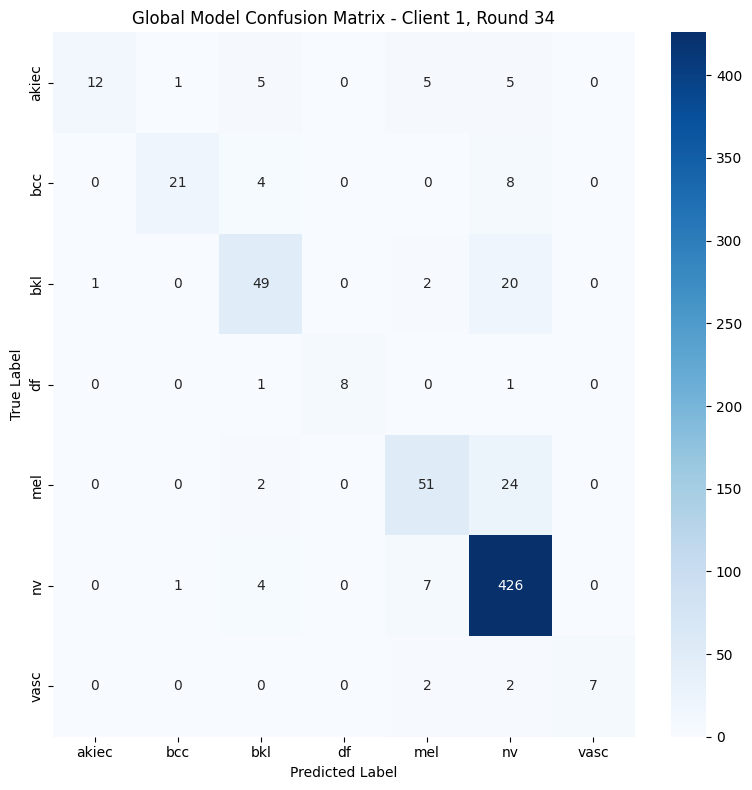


Evaluating Global Model on Client 2 Test Set


Testing: 100%|██████████| 21/21 [00:13<00:00,  1.52it/s]

Test Loss: 0.6543, Test Accuracy: 86.83%, F1-Score: 0.8580
Confusion Matrix:
 [[  8   1   8   0   2   3   0]
 [  0  27   5   0   1   5   0]
 [  0   0  43   0   3  12   0]
 [  0   1   1   3   1   3   0]
 [  0   2   5   0  36  25   0]
 [  0   2   5   0   2 454   0]
 [  0   0   0   0   1   0   9]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.36      0.53        22
           1       0.82      0.71      0.76        38
           2       0.64      0.74      0.69        58
           3       1.00      0.33      0.50         9
           4       0.78      0.53      0.63        68
           5       0.90      0.98      0.94       463
           6       1.00      0.90      0.95        10

    accuracy                           0.87       668
   macro avg       0.88      0.65      0.71       668
weighted avg       0.87      0.87      0.86       668

Sensitivity/Recall:
 [0.36363636 0.71052632 0.74137931 0.33333333 0.52941176 0.9805

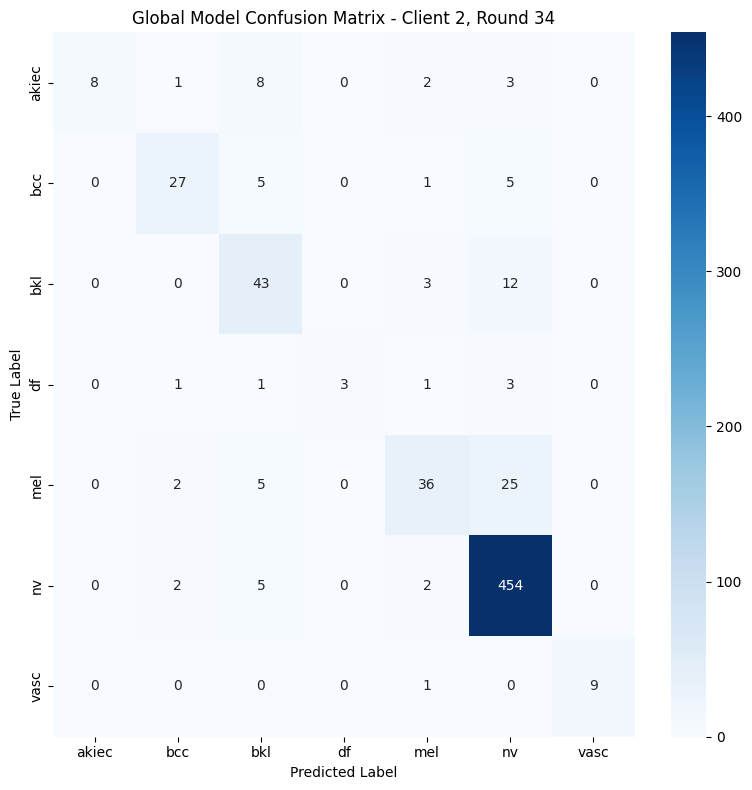


Evaluating Global Model on Client 3 Test Set


Testing: 100%|██████████| 21/21 [00:14<00:00,  1.48it/s]

Test Loss: 0.8350, Test Accuracy: 85.48%, F1-Score: 0.8432
Confusion Matrix:
 [[ 10   1   2   0   3   2   0]
 [  2  32   1   0   2   3   0]
 [  0   4  55   0   4  19   0]
 [  0   0   0   3   0   2   0]
 [  0   1   1   0  32  40   0]
 [  0   2   1   0   5 426   0]
 [  0   0   0   0   1   1  13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.56      0.67        18
           1       0.80      0.80      0.80        40
           2       0.92      0.67      0.77        82
           3       1.00      0.60      0.75         5
           4       0.68      0.43      0.53        74
           5       0.86      0.98      0.92       434
           6       1.00      0.87      0.93        15

    accuracy                           0.85       668
   macro avg       0.87      0.70      0.77       668
weighted avg       0.85      0.85      0.84       668

Sensitivity/Recall:
 [0.55555556 0.8        0.67073171 0.6        0.43243243 0.9815

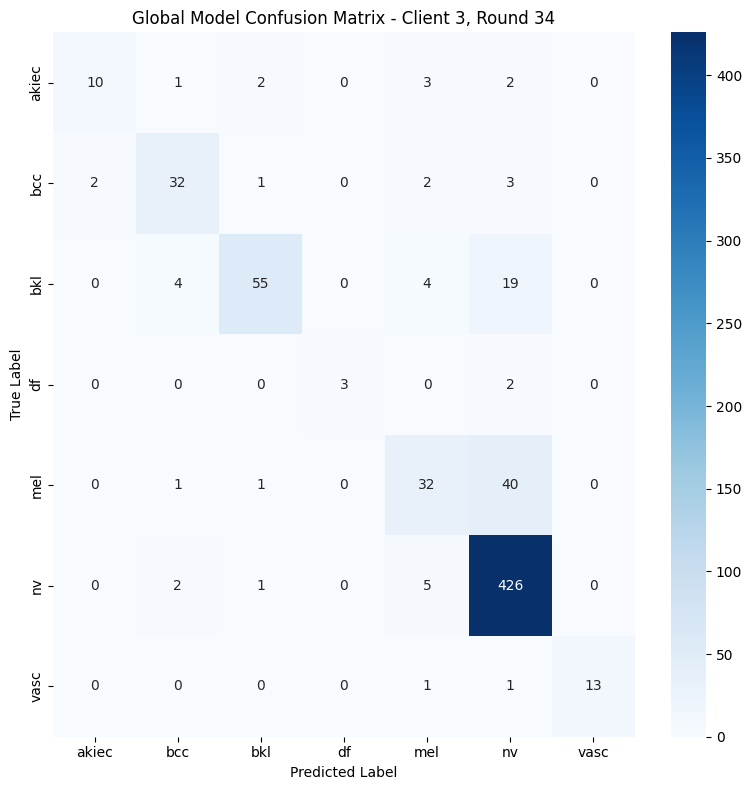


--- Round 35 ---

Training Client 1


Client 1 Epoch 1: 100%|██████████| 84/84 [04:16<00:00,  3.05s/it]


Client 1 Epoch 1: Train Loss: 0.1317, Train Accuracy: 98.84%


Client 1 Epoch 2:  96%|█████████▋| 81/84 [04:08<00:09,  3.07s/it]

In [ ]:
# ----------------------------------------------------------
# Federated Learning Training Loop
# ----------------------------------------------------------

# This list stores training history, including per-round and per-client statistics
history = []

# Start federated training for the defined number of rounds
for round_num in range(NUM_ROUNDS):
    print(f"\n--- Round {round_num + 1} ---")

    # Stores training/testing metrics for all clients in this round
    client_histories = []

    # ----------------------------------------------------------
    # Train Each Client Separately in the Current Round
    # ----------------------------------------------------------
    for client_id in range(NUM_CLIENTS):
        print(f"\nTraining Client {client_id + 1}")

        # ----------------------
        # Apply Proximal Term (FedProx Support)
        # ----------------------
        if MU > 0:
            # Store global model weights to compute proximal regularization term
            if not hasattr(client_models[client_id], 'weight_update'):
                client_models[client_id].weight_update = {}
            for name, global_param in global_model.named_parameters():
                for client_name, client_param in client_models[client_id].named_parameters():
                    if name == client_name:
                        # Save a copy of the global weights before local training starts
                        client_models[client_id].weight_update[name] = global_param.clone().detach()
                        break

        # ----------------------
        # Local Training on Client Dataset
        # ----------------------
        for epoch in range(NUM_EPOCHS_PER_CLIENT):
            # Train the client's model for one epoch on its local data
            train_loss, train_accuracy = train_client(
                client_id + 1,
                client_models[client_id].to(DEVICE),
                client_train_loaders[client_id],
                optimizers[client_id],
                epoch,
                MU
            )

        # ----------------------
        # Evaluate Client Model on Its Own Local Test Set
        # ----------------------
        print(f"\nEvaluating Client {client_id + 1} on its local test set")
        client_test_history, _, _ = test_model(client_models[client_id].to(DEVICE), client_test_loaders[client_id])

        # Store training and evaluation statistics for this client
        client_histories.append({
            'client_id': client_id + 1,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'test_loss': client_test_history['test_loss'],
            'test_accuracy': client_test_history['test_accuracy'],
            'f1_score': client_test_history['f1_score'],
            'confusion_matrix': client_test_history['confusion_matrix'],
            'sensitivity': client_test_history['sensitivity'],
            'recall': client_test_history['recall'],
            'classification_report': client_test_history['classification_report']
        })

    # ----------------------------------------------------------
    # Federated Averaging: Aggregate Client Models into Global Model
    # ----------------------------------------------------------
    federated_averaging(global_model, [model.to('cpu') for model in client_models])

    # Move the updated global model back to the training device (GPU/CPU)
    global_model.to(DEVICE)

    # Refresh local client models from the newly updated global model
    client_models = [copy.deepcopy(global_model) for _ in range(NUM_CLIENTS)]

    # Reinitialize optimizers for each client model
    optimizers = [torch.optim.Adam(model.parameters(), lr=LR) for model in client_models]

    # ----------------------------------------------------------
    # Evaluate the Updated Global Model on Each Client's Test Set
    # ----------------------------------------------------------
    global_test_histories = []
    for client_id in range(NUM_CLIENTS):
        print(f"\nEvaluating Global Model on Client {client_id + 1} Test Set")
        global_test_history, _, _ = test_model(global_model, client_test_loaders[client_id])

        # Save evaluation results for this client
        global_test_histories.append({
            'client_id': client_id + 1,
            'test_loss': global_test_history['test_loss'],
            'test_accuracy': global_test_history['test_accuracy'],
            'f1_score': global_test_history['f1_score'],
            'confusion_matrix': global_test_history['confusion_matrix'],
            'sensitivity': global_test_history['sensitivity'],
            'recall': global_test_history['recall'],
            'classification_report': global_test_history['classification_report']
        })

        # Plot confusion matrix for the updated global model on this client's data
        plot_confusion_matrix(
            np.array(global_test_history['confusion_matrix']),
            classes=class_names,
            title=f'Global Model Confusion Matrix - Client {client_id + 1}, Round {round_num + 1}'
        )

    # ----------------------------------------------------------
    # Save Round Results
    # ----------------------------------------------------------
    history.append({
        'round': round_num + 1,
        'client_histories': client_histories,
        'global_test_histories': global_test_histories
    })

    # Save the global model state after the current round
    torch.save(global_model.state_dict(), f"global_model_round_{round_num + 1}.pth")

    # Save round-specific history in a separate JSON file
    with open(f"history_round_{round_num + 1}.json", 'w') as f:
        json.dump(history[-1], f, indent=4)

# ----------------------------------------------------------
# Final Evaluation of the Global Model on All Clients
# ----------------------------------------------------------
print("\n--- Final Evaluation of Global Model on Each Client's Test Set ---")
for client_id in range(NUM_CLIENTS):
    print(f"\nEvaluating Global Model on Client {client_id + 1} Test Set")
    final_global_test_history, _, _ = test_model(global_model, client_test_loaders[client_id])

    # Plot the final confusion matrix for each client
    plot_confusion_matrix(
        np.array(final_global_test_history['confusion_matrix']),
        classes=class_names,
        title=f'Final Global Model Confusion Matrix - Client {client_id + 1}'
    )

# ----------------------------------------------------------
# Save Final Results
# ----------------------------------------------------------

# Save the final trained global model
torch.save(global_model.state_dict(), "final_global_model.pth")

# Save the complete training history for all rounds
with open("training_history.json", 'w') as f:
    json.dump(history, f, indent=4)

print("\nFederated training completed. Models and history saved.")
